In [1]:
import torch.distributions as dist
import numpy as np
import torch.distributions as dist
import torch
import vsms
import importlib
import vsms.exsample_benchmark
import vsms.exsample_sampler
importlib.reload(vsms.exsample_benchmark)
importlib.reload(vsms.exsample_sampler)
from vsms.exsample_benchmark import *
from vsms.exsample_sampler import *
from vsms.exsample_analytic import *
import scipy.stats
import pandas as pd

In [3]:
## parameters: 
##  M (num chunks), mu_p, sigma_p, Nj. 

## exploration:
## scenario one: fixed mu and sigma. increase Nj variance. gt will do better with more N_j variance.
## scenario two: sigma = 0, decreasing mu. gt should improve as mu decreases and as sigma increases
## scenario three: increasing M. gt should find it harder to warm up

In [4]:
#Nj, muj=fixed, sigmaj=fixed

In [5]:
# fix a count. N 1000 and durations
# fix a number of splits M
# now vary skew: each instance gets assigned to a split.

In [78]:
# normal dist: 95% are within 2sigma
np.set_printoptions(precision=3, suppress=True)

In [572]:
## perfect scorer: assign a fixed score to each instance. frame gets sum of instance scores.
#assign 0 to frames with nothing.
# then, sample from that.
## note: also measure AP

In [577]:
## potentially can do badly.
## what I want to show is when this helps.

In [3]:
#f,s = make_score_order(mm, durations)

In [648]:
# M = 1024.
# then sigma= NF/1024/2
NF = int(2**24)
N = 2000
pows = torch.arange(1, 13, step=3).float()
Ms = 2.**pows # num partitions: 2 to 1024.
chunk_size = NF/Ms
lmu, lsigma = inv_mean_std(M=700/NF, S=500/NF)

In [388]:
#(M,S) = mean_std(lmu, lsigma)

In [207]:
positions = generate_positions(N, NF, sigmas=chunk_size)
durations = generate_durations(N, mu=lmu, sigma=lsigma)

In [763]:
#pos32 = positions[:,-2]

In [681]:
def make_multi_map(starts, ends):
    sz = (ends - starts).sum().item()
    frames = torch.zeros((sz,), dtype=torch.int)
    tracks = torch.zeros((sz,), dtype=torch.int)

    offset = 0
    for (i, (s, e)) in enumerate(zip(starts, ends)):
        l = e - s
        tracks[offset:offset + l] = i
        frames[offset:offset + l] = torch.arange(s, e)
        offset += l

    am = ArrayMultiMap(keys=frames.numpy(), values=tracks.numpy())
    return am

In [764]:
def gen_exp_partitions(pos, durs, Ms):
    ans = []
    starts, ends = generate_tracks(pos.view(-1,1), durs, NF)
    mm = make_multi_map(starts.view(-1), ends.view(-1))
    ps = (ends - starts).float().numpy()/NF
    ps = ps.reshape(-1)

    for i,M in enumerate(Ms):
        Ps = getPs(mm, N, NF, NF//M)
        ans.append({'params':{'NF':NF,
                              'N':N,
                            'minp':ps.min().item(),
                            'mup':ps.mean().item(), 
                            'maxp':ps.max().item(),
                            'sigmap':ps.std().item(), 
                            'M':M},
                    'mm':mm,
                    'Ps':Ps})
        assert Ps.shape[1] == M
        assert np.isclose(Ps.mean(axis=1), ps).all()
        assert (Ps <= 1.).all()
        assert (Ps >= 0.).all()
    return ans

In [765]:
durations.mean()

tensor(697.8220)

In [840]:
def getPs(am: ArrayMultiMap, N: int, NF: int, chsz: int):
    """
    :param am: multimap frames => track ids
    :param N: total instances
    :param NF: total frames in dataset
    :param chsz: chunk size (NF// chsz) = M
    :return:
    """
    assert NF % chsz == 0
    frms = am.okeys
    tids = am.ovalues
    splits = frms // chsz
    nsplits = NF // chsz
    unqs = tids * nsplits + splits
    locs, cts = np.unique(unqs, return_counts=True)
    row = locs // nsplits
    col = locs % nsplits
    Ps = np.zeros((N, nsplits))
    Ps[row, col] = cts
    Ps = Ps / chsz
    return Ps

In [767]:
exps2 = gen_exp_partitions(pos32, durations, np.array([2,16,128,1024]))

In [825]:
(exps2[0]['Ps'] > 0).sum(axis=0), (exps2[1]['Ps'] > 0).sum(axis=0), (exps2[2]['Ps'] > 0).sum(axis=0)

(array([2000,    0]),
 array([1999,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0]),
 array([  0,  16, 122, 495, 759, 479, 128,   9,   1,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]))

In [831]:
(exps2[0]['Ps']).sum(axis=0), (exps2[1]['Ps']).sum(axis=0), (exps2[2]['Ps']).sum(axis=0)

(array([0.166, 0.   ]),
 array([1.329, 0.002, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]),
 array([0.   , 0.073, 0.617, 2.848, 3.87 , 2.54 , 0.646, 0.04 , 0.013,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0

In [828]:
#(durations/NF).sum()*7, (durations/NF).sum(),(durations/NF).sum()/7, (durations/NF).sum(),

In [841]:
durations.sum()/NF

tensor(0.0832)

In [842]:
dc = [1/50., 1/7., 1., 7.]
def gen_Ps_v4(dur_coeffs, sigma_sizes):
    ans = []
    for dur_coeff in dur_coeffs:
        starts, ends = generate_tracks(positions, durations*dur_coeff, NF)    
        for i,chsz in enumerate(sigma_sizes):
            chsz = chsz.int().item()
            bulk = chsz*4
            skew = np.maximum(NF/bulk,1.)
            ps = (ends[:,i] - starts[:,i]).float().numpy()/NF
            mm = make_multi_map(starts[:,i], ends[:,i])
            Ps = getPs(mm, N, NF, NF//128)
            ans.append({'params':{'skew':skew,
                                  'NF':NF,
                                  'N':N,
                                'dur_coeff':dur_coeff,
                                'minp':ps.min().item(),
                                'mup':ps.mean().item(), 
                                'maxp':ps.max().item(),
                                'sigmap':ps.std().item(), 
                                'M':Ps.shape[1]},
                        'mm':mm,
                        'Ps':Ps})
            assert np.isclose(Ps.mean(axis=1), ps).all()
            assert (Ps <= 1.).all()
            assert (Ps >= 0.).all()
    return ans

In [761]:
#all_Ps2 = gen_Ps_v4(dur_coeffs=dc[-1:], sigma_sizes=chunk_size)

In [977]:
bm = pr.BitMap()

In [978]:
bm.add_range(0,10)

In [979]:
batch = np.random.choice(bm, size=5, replace=False)

In [980]:
batch

array([4, 2, 3, 0, 1])

In [982]:
bm.difference_update(pr.FrozenBitMap(batch))

In [1107]:
rnf = RandomlyPermutedRange(NF, 2*NF)

In [1135]:
#frames = np.arange(NF).astype('int')
def make_experiment(mm, batch_size, score, score_params, other_params):
    g = Grader(mm, pr.BitMap([]))
    
    if score == 'random1':
        s = RandomlyPermutedRange(0, NF)
    else:
        M = other_params['M']
        fpc = NF//M
        samplers = [RandomlyPermutedRange(start=fpc*i, end=fpc*(i+1)) for i in range(M)]
        if score == 'gt':
            sm = GtScore
        elif score == 'statscorer':
            sm = StatScorer
        elif score == 'random':
            sm = RandomScore
        else:
            assert False
        
        s = CompositeSampler(samplers, NI=Ps.shape[0], score_method=sm, score_opts=score_params)

    params={'score':score}
    params.update(score_params)
    params.update(other_params)
    exp = Experiment(sampler=s, grader=g, params=params, param_names=params, 
                     NI=N, NF=NF, batch_size=batch_size)
    return exp

In [1112]:
def skew_metric(Ps, fraction=.5):
    Ns = (Ps > 0).sum(axis=0)
    order = np.argsort(-Ns)
    ons = Ns[order]
    fracs = ons/sum(ons)
    needed = (fracs.cumsum() < fraction).sum() + 1
    return Ps.shape[1]/needed

In [1113]:
skew_metric(exps2[-1]['Ps']),skew_metric(exps2[-2]['Ps']),skew_metric(exps2[-3]['Ps']), skew_metric(exps2[-4]['Ps'])

(93.0909090909091, 64.0, 16.0, 2.0)

In [910]:
#np.sort((exps2[-1]['Ps'] > 0).sum(axis=0)), np.sort((exps2[-2]['Ps'] > 0).sum(axis=0))

In [1347]:
#all_levels

In [1284]:
acc = []
# ns = np.array([1,2,4,6,8,10,15,20,30,40,60,80,100,150,200,300,400,600,800,900,1000,1100,
#                1200,1300,1600,2000,3000,4000,4500,5000,7000,8000,10000])
all_levels = np.array(all_levels)
ps = exps2[0]['Ps'].mean(axis=-1)
preds = expected(ps, all_levels)

df2 = pd.DataFrame({'nf':all_levels, 'ni':preds}).assign(method='random')#.assign(**elt['params'])
acc.append(df2)

for elt in tqdm(exps2):
    Ps = elt['Ps'].astype('double')
    ow = MaxN(Ps)
    opts = []
    for n in all_levels:
        try:
            Nstar= ow.solve(n, warm_start=True, verbose=True)
            opts.append(Nstar)
        except Exception as e:
            print(e)
            print('failed at ', n)
            opts.append(np.nan)
        
    df1 = pd.DataFrame({'nf':all_levels, 'ni':opts}).assign(method='this work').assign(**elt['params'])
#     df2 = pd.DataFrame({'nf':ns, 'ni':preds}).assign(method='random').assign(**elt['params'])
    acc.append(df1)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.179e+03  +1.802e+03  +2e+03  2e-01  4e-02  4e-01  3e-01  0.7833  5e-02   1  1  1 |  2  1
 2  +1.880e+03  +1.844e+03  +2e+02  2e-02  3e-03  6e-02  3e-02  0.8923  7e-03   1  1  1 |  0  0
 3  +1.988e+03  +1.969e+03  +6e+01  1e-02  2e-03  4e-02  1e-02  0.6266  5e-02   1  1  1 |  2  2
 4  +1.999e+03  +1.998e+03  +3e+00  4e-04  8e-05  1e-03  4e-04  0.9707  1e-02   2  1  1 |  0  0
 5  +2.000e+03  +2.000e+03  +6e-01  1e-04  2e-05  4e-04  1e-04  0.7833  5e-02   2  1  1 |  2  1
 6  +2.000e+03  +2.000e+03  +1e-01  3e-05  5e-06  8e-05  2e-05  0.7833  1e-03   2  1  1 |  0  1
 7  +2.000e+03  +2.000e+03  +3e-02  7e-06  1e-06  2e-05  5e-06  0.7833  9e-03   2  1  1 |  1  1
 8  +2.000e+03  +2.000e+03  +1e-02  3e-06  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.296e+03  +1.962e+03  +1e+03  2e-01  3e-02  3e-01  2e-01  0.9791  2e-01   1  1  1 |  0  0
 2  +1.969e+03  +1.894e+03  +3e+02  4e-02  7e-03  9e-02  6e-02  0.7833  4e-02   1  1  1 |  0  1
 3  +1.971e+03  +1.953e+03  +9e+01  9e-03  2e-03  2e-02  1e-02  0.7523  4e-03   1  1  1 |  0  1
 4  +1.996e+03  +1.991e+03  +2e+01  3e-03  6e-04  7e-03  4e-03  0.7247  9e-03   1  1  1 |  1  1
 5  +1.997e+03  +1.996e+03  +5e+00  7e-04  1e-04  2e-03  9e-04  0.7763  8e-03   2  1  1 |  0  1
 6  +1.999e+03  +1.998e+03  +1e+00  2e-04  3e-05  4e-04  2e-04  0.7805  9e-03   2  1  1 |  1  1
 7  +1.999e+03  +1.999e+03  +3e-01  3e-05  6e-06  8e-05  4e-05  0.7833  5e-04   2  1  1 |  0  1
 8  +1.999e+03  +1.999e+03  +5e-02  8e-06  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.184e+03  +5.110e+02  +3e+03  3e-01  5e-02  5e-01  5e-01  0.9791  5e-01   1  1  1 |  0  0
 2  +1.790e+03  +1.592e+03  +1e+03  9e-02  2e-02  1e-01  2e-01  0.7833  1e-01   1  1  1 |  0  1
 3  +1.904e+03  +1.858e+03  +3e+02  2e-02  4e-03  2e-02  5e-02  0.7532  1e-02   1  1  1 |  0  1
 4  +1.984e+03  +1.973e+03  +7e+01  5e-03  9e-04  5e-03  1e-02  0.7725  1e-02   1  1  1 |  1  1
 5  +1.992e+03  +1.990e+03  +2e+01  1e-03  2e-04  1e-03  3e-03  0.7334  2e-03   1  1  1 |  0  1
 6  +1.998e+03  +1.997e+03  +2e+00  1e-04  2e-05  1e-04  3e-04  0.9035  2e-03   1  1  1 |  0  0
 7  +1.997e+03  +1.997e+03  +5e-01  3e-05  5e-06  3e-05  8e-05  0.7710  7e-03   2  1  1 |  0  1
 8  +1.997e+03  +1.997e+03  +1e-01  5e-06  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.369e+02  +6.915e+00  +4e+03  4e-01  4e-02  4e-01  7e-01  0.9791  7e-01   1  1  1 |  0  0
 2  +1.806e+03  +1.669e+03  +1e+03  6e-02  1e-02  8e-03  2e-01  0.8944  1e-01   1  1  1 |  0  0
 3  +1.925e+03  +1.894e+03  +3e+02  1e-02  2e-03  2e-03  4e-02  0.7620  5e-03   1  1  1 |  0  1
 4  +1.986e+03  +1.978e+03  +6e+01  3e-03  6e-04  7e-04  1e-02  0.7671  9e-03   1  1  1 |  1  1
 5  +1.994e+03  +1.993e+03  +7e+00  3e-04  6e-05  1e-04  1e-03  0.8937  5e-03   1  1  1 |  0  0
 6  +1.996e+03  +1.996e+03  +2e+00  2e-04  4e-05  9e-05  4e-04  0.6232  5e-02   1  1  1 |  2  2
 7  +1.996e+03  +1.996e+03  +6e-01  4e-05  8e-06  2e-05  9e-05  0.7769  3e-03   2  1  1 |  0  1
 8  +1.996e+03  +1.996e+03  +1e-01  9e-06  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.937e+02  -1.831e+02  +5e+03  4e-01  3e-02  2e-01  8e-01  0.9791  7e-01   1  1  1 |  0  0
 2  +1.867e+03  +1.678e+03  +1e+03  8e-02  2e-02  6e-02  2e-01  0.7781  4e-02   1  1  1 |  0  0
 3  +1.950e+03  +1.907e+03  +3e+02  2e-02  3e-03  1e-02  5e-02  0.7771  9e-03   1  1  1 |  0  1
 4  +1.995e+03  +1.990e+03  +4e+01  2e-03  4e-04  2e-03  6e-03  0.8895  2e-03   1  1  1 |  0  0
 5  +1.993e+03  +1.992e+03  +1e+01  4e-04  9e-05  5e-04  2e-03  0.7676  3e-02   1  1  1 |  0  1
 6  +1.995e+03  +1.995e+03  +2e+00  1e-04  2e-05  1e-04  3e-04  0.7833  9e-03   1  1  1 |  1  1
 7  +1.995e+03  +1.995e+03  +5e-01  2e-05  5e-06  2e-05  8e-05  0.7833  1e-03   2  1  1 |  0  1
 8  +1.995e+03  +1.995e+03  +1e-01  5e-06  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.520e+02  -4.779e+02  +5e+03  5e-01  3e-02  3e-01  9e-01  0.6266  8e-01   1  1  1 |  0  2
 2  +1.837e+03  +1.603e+03  +2e+03  9e-02  2e-02  1e-01  3e-01  0.7628  4e-02   1  1  1 |  0  0
 3  +1.940e+03  +1.887e+03  +4e+02  2e-02  4e-03  2e-02  7e-02  0.7833  2e-02   1  1  1 |  0  1
 4  +1.993e+03  +1.986e+03  +5e+01  3e-03  5e-04  3e-03  8e-03  0.8818  3e-03   1  1  1 |  0  0
 5  +1.992e+03  +1.990e+03  +1e+01  6e-04  1e-04  8e-04  2e-03  0.7668  3e-02   1  1  1 |  0  1
 6  +1.993e+03  +1.993e+03  +3e+00  1e-04  3e-05  2e-04  5e-04  0.7831  9e-03   1  1  1 |  1  1
 7  +1.993e+03  +1.993e+03  +6e-01  3e-05  6e-06  4e-05  1e-04  0.7833  8e-04   2  1  1 |  0  1
 8  +1.994e+03  +1.994e+03  +1e-01  7e-06  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.751e+02  -5.375e+02  +6e+03  5e-01  3e-02  3e-01  9e-01  0.5076  8e-01   1  1  1 |  0  2
 2  +1.974e+03  +1.752e+03  +2e+03  9e-02  2e-02  1e-01  3e-01  0.7785  2e-02   1  1  1 |  0  0
 3  +1.912e+03  +1.863e+03  +4e+02  2e-02  4e-03  2e-02  7e-02  0.7833  2e-02   1  1  1 |  0  1
 4  +1.982e+03  +1.966e+03  +1e+02  6e-03  1e-03  8e-03  2e-02  0.7255  9e-03   1  1  1 |  1  1
 5  +1.990e+03  +1.988e+03  +8e+00  5e-04  1e-04  8e-04  1e-03  0.9309  2e-02   1  1  1 |  0  0
 6  +1.992e+03  +1.991e+03  +3e+00  3e-04  6e-05  4e-04  5e-04  0.6266  5e-02   1  1  1 |  2  2
 7  +1.992e+03  +1.992e+03  +7e-01  6e-05  1e-05  1e-04  1e-04  0.7833  1e-02   2  1  1 |  1  1
 8  +1.992e+03  +1.992e+03  +1e-01  1e-05  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.443e+01  -6.796e+02  +6e+03  5e-01  3e-02  4e-01  1e+00  0.2622  8e-01   1  1  1 |  0  3
 2  +1.823e+03  +1.551e+03  +2e+03  1e-01  2e-02  2e-01  3e-01  0.7535  3e-02   1  1  1 |  0  0
 3  +1.951e+03  +1.939e+03  +1e+02  5e-03  1e-03  8e-03  2e-02  0.9791  3e-02   1  1  1 |  0  0
 4  +1.993e+03  +1.988e+03  +2e+01  2e-03  5e-04  4e-03  4e-03  0.7285  5e-02   1  1  1 |  2  1
 5  +1.989e+03  +1.988e+03  +7e+00  6e-04  1e-04  1e-03  1e-03  0.7436  3e-02   2  1  1 |  0  1
 6  +1.990e+03  +1.989e+03  +1e+00  1e-04  3e-05  3e-04  2e-04  0.7833  2e-04   1  1  1 |  0  1
 7  +1.990e+03  +1.990e+03  +3e-01  3e-05  6e-06  6e-05  5e-05  0.7833  9e-03   2  1  1 |  1  1
 8  +1.990e+03  +1.990e+03  +8e-02  6e-06  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.598e+01  -7.087e+02  +6e+03  5e-01  4e-02  3e-01  1e+00  0.1461  9e-01   1  1  1 |  0  3
 2  +1.892e+03  +1.623e+03  +2e+03  1e-01  2e-02  2e-01  3e-01  0.7603  3e-02   1  1  1 |  0  0
 3  +1.904e+03  +1.841e+03  +5e+02  3e-02  5e-03  4e-02  8e-02  0.7833  4e-02   1  1  1 |  0  1
 4  +1.989e+03  +1.980e+03  +6e+01  4e-03  8e-04  7e-03  1e-02  0.8647  3e-03   1  1  1 |  0  0
 5  +1.982e+03  +1.980e+03  +2e+01  9e-04  2e-04  2e-03  3e-03  0.7760  3e-02   1  1  1 |  0  1
 6  +1.984e+03  +1.984e+03  +4e+00  2e-04  4e-05  4e-04  6e-04  0.7833  9e-03   1  1  1 |  1  1
 7  +1.984e+03  +1.984e+03  +8e-01  4e-05  8e-06  8e-05  1e-04  0.7833  7e-04   2  1  1 |  0  1
 8  +1.984e+03  +1.984e+03  +2e-01  1e-05  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.090e+01  -7.108e+02  +6e+03  5e-01  4e-02  3e-01  1e+00  0.1287  9e-01   1  1  1 |  0  3
 2  +1.915e+03  +1.646e+03  +2e+03  1e-01  2e-02  2e-01  3e-01  0.7621  2e-02   1  1  1 |  0  0
 3  +1.896e+03  +1.832e+03  +5e+02  3e-02  5e-03  4e-02  8e-02  0.7833  5e-02   1  1  1 |  0  1
 4  +1.985e+03  +1.975e+03  +6e+01  4e-03  8e-04  7e-03  1e-02  0.8701  3e-03   1  1  1 |  0  0
 5  +1.977e+03  +1.975e+03  +2e+01  9e-04  2e-04  2e-03  3e-03  0.7799  2e-02   1  1  1 |  0  1
 6  +1.978e+03  +1.978e+03  +3e+00  2e-04  4e-05  4e-04  6e-04  0.7833  9e-03   1  1  1 |  1  1
 7  +1.978e+03  +1.978e+03  +8e-01  4e-05  8e-06  8e-05  1e-04  0.7833  4e-04   2  1  1 |  0  1
 8  +1.979e+03  +1.979e+03  +2e-01  1e-05  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.356e+01  -7.068e+02  +6e+03  5e-01  4e-02  3e-01  1e+00  0.1405  9e-01   1  1  1 |  0  3
 2  +1.923e+03  +1.654e+03  +2e+03  1e-01  2e-02  2e-01  3e-01  0.7622  2e-02   1  1  1 |  0  0
 3  +1.891e+03  +1.826e+03  +5e+02  3e-02  5e-03  4e-02  8e-02  0.7833  5e-02   1  1  1 |  0  1
 4  +1.980e+03  +1.971e+03  +6e+01  4e-03  8e-04  7e-03  1e-02  0.8818  4e-03   1  1  1 |  0  0
 5  +1.971e+03  +1.970e+03  +1e+01  8e-04  2e-04  1e-03  2e-03  0.7816  1e-02   1  1  1 |  0  1
 6  +1.973e+03  +1.972e+03  +3e+00  2e-04  4e-05  4e-04  6e-04  0.7833  5e-02   1  1  1 |  2  1
 7  +1.973e+03  +1.973e+03  +8e-01  5e-05  9e-06  9e-05  1e-04  0.7833  1e-02   1  1  1 |  1  1
 8  +1.973e+03  +1.973e+03  +3e-01  2e-05  4e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.080e+01  -6.984e+02  +6e+03  5e-01  4e-02  3e-01  1e+00  0.1685  9e-01   1  1  1 |  0  3
 2  +1.925e+03  +1.656e+03  +2e+03  2e-01  2e-02  2e-01  3e-01  0.7617  2e-02   1  1  1 |  0  0
 3  +1.888e+03  +1.821e+03  +5e+02  3e-02  6e-03  4e-02  9e-02  0.7833  6e-02   1  1  1 |  0  1
 4  +1.976e+03  +1.968e+03  +5e+01  4e-03  7e-04  6e-03  9e-03  0.8964  5e-03   1  1  1 |  0  0
 5  +1.967e+03  +1.965e+03  +1e+01  7e-04  1e-04  1e-03  2e-03  0.7819  5e-03   1  1  1 |  0  1
 6  +1.967e+03  +1.966e+03  +3e+00  2e-04  3e-05  4e-04  6e-04  0.7833  6e-02   1  1  1 |  2  1
 7  +1.967e+03  +1.967e+03  +7e-01  4e-05  8e-06  8e-05  1e-04  0.7833  9e-03   2  1  1 |  1  1
 8  +1.967e+03  +1.967e+03  +3e-01  2e-05  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.253e+01  -6.853e+02  +6e+03  5e-01  4e-02  3e-01  1e+00  0.2101  9e-01   1  1  1 |  0  3
 2  +1.925e+03  +1.656e+03  +2e+03  2e-01  2e-02  2e-01  3e-01  0.7608  2e-02   1  1  1 |  0  0
 3  +1.885e+03  +1.817e+03  +5e+02  3e-02  6e-03  5e-02  9e-02  0.7833  7e-02   1  1  1 |  0  1
 4  +1.952e+03  +1.932e+03  +1e+02  9e-03  2e-03  1e-02  2e-02  0.7292  5e-03   1  1  1 |  0  1
 5  +1.957e+03  +1.953e+03  +3e+01  2e-03  4e-04  3e-03  5e-03  0.7721  3e-03   1  1  1 |  0  1
 6  +1.961e+03  +1.960e+03  +7e+00  5e-04  9e-05  8e-04  1e-03  0.7833  9e-03   1  1  1 |  1  1
 7  +1.961e+03  +1.961e+03  +2e+00  1e-04  2e-05  2e-04  3e-04  0.7833  2e-02   1  1  1 |  1  1
 8  +1.961e+03  +1.961e+03  +4e-01  2e-05  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.948e+01  -6.663e+02  +6e+03  5e-01  5e-02  3e-01  1e+00  0.2649  8e-01   1  1  1 |  0  3
 2  +1.922e+03  +1.654e+03  +2e+03  2e-01  2e-02  2e-01  3e-01  0.7596  3e-02   1  1  1 |  0  0
 3  +1.882e+03  +1.813e+03  +5e+02  3e-02  6e-03  5e-02  9e-02  0.7833  7e-02   1  1  1 |  0  1
 4  +1.948e+03  +1.929e+03  +1e+02  9e-03  2e-03  1e-02  2e-02  0.7406  5e-03   1  1  1 |  0  1
 5  +1.952e+03  +1.947e+03  +3e+01  2e-03  4e-04  3e-03  5e-03  0.7731  3e-03   1  1  1 |  0  1
 6  +1.956e+03  +1.955e+03  +7e+00  4e-04  9e-05  7e-04  1e-03  0.7833  9e-03   1  1  1 |  1  1
 7  +1.956e+03  +1.955e+03  +2e+00  1e-04  2e-05  2e-04  3e-04  0.7833  2e-02   1  1  1 |  1  1
 8  +1.956e+03  +1.956e+03  +3e-01  2e-05  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.028e+02  -6.401e+02  +6e+03  5e-01  5e-02  4e-01  1e+00  0.3336  8e-01   1  1  1 |  0  3
 2  +1.917e+03  +1.651e+03  +2e+03  2e-01  2e-02  2e-01  3e-01  0.7583  3e-02   1  1  1 |  0  0
 3  +1.871e+03  +1.847e+03  +2e+02  1e-02  2e-03  2e-02  3e-02  0.9791  8e-02   1  1  1 |  0  0
 4  +1.942e+03  +1.929e+03  +6e+01  7e-03  1e-03  1e-02  1e-02  0.6266  5e-02   1  1  1 |  2  2
 5  +1.948e+03  +1.946e+03  +1e+01  1e-03  3e-04  3e-03  2e-03  0.7813  3e-03   1  1  1 |  0  1
 6  +1.950e+03  +1.949e+03  +3e+00  3e-04  6e-05  7e-04  5e-04  0.7833  1e-02   1  1  1 |  1  1
 7  +1.950e+03  +1.950e+03  +7e-01  7e-05  1e-05  2e-04  1e-04  0.7833  1e-02   1  1  1 |  1  1
 8  +1.950e+03  +1.950e+03  +1e-01  2e-05  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.340e+02  -6.049e+02  +6e+03  5e-01  5e-02  4e-01  1e+00  0.4169  8e-01   1  1  1 |  0  3
 2  +1.912e+03  +1.647e+03  +2e+03  2e-01  2e-02  2e-01  3e-01  0.7568  3e-02   1  1  1 |  0  0
 3  +1.870e+03  +1.845e+03  +2e+02  1e-02  2e-03  2e-02  3e-02  0.9791  8e-02   1  1  1 |  0  0
 4  +1.938e+03  +1.925e+03  +6e+01  7e-03  1e-03  1e-02  1e-02  0.6266  5e-02   1  1  1 |  2  2
 5  +1.944e+03  +1.944e+03  +2e+00  2e-04  3e-05  4e-04  3e-04  0.9751  2e-03   1  1  1 |  0  0
 6  +1.945e+03  +1.944e+03  +6e-01  8e-05  2e-05  2e-04  1e-04  0.6266  5e-02   1  1  1 |  2  2
 7  +1.945e+03  +1.945e+03  +2e-01  3e-05  7e-06  7e-05  4e-05  0.6266  5e-02   1  1  1 |  2  2
 8  +1.945e+03  +1.945e+03  +6e-02  8e-06  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.714e+02  -5.699e+02  +6e+03  5e-01  5e-02  4e-01  9e-01  0.5013  8e-01   1  1  1 |  0  3
 2  +1.875e+03  +1.608e+03  +2e+03  2e-01  2e-02  2e-01  3e-01  0.7506  3e-02   1  1  1 |  0  0
 3  +1.882e+03  +1.855e+03  +2e+02  1e-02  2e-03  2e-02  4e-02  0.9791  9e-02   1  1  1 |  0  0
 4  +1.950e+03  +1.941e+03  +5e+01  4e-03  8e-04  9e-03  7e-03  0.7830  5e-02   1  1  1 |  2  1
 5  +1.939e+03  +1.937e+03  +1e+01  9e-04  2e-04  2e-03  2e-03  0.7781  2e-03   1  1  1 |  0  1
 6  +1.939e+03  +1.938e+03  +3e+00  2e-04  4e-05  4e-04  4e-04  0.7833  2e-02   1  1  1 |  1  1
 7  +1.939e+03  +1.939e+03  +5e-01  5e-05  9e-06  1e-04  9e-05  0.7833  9e-03   1  1  1 |  1  1
 8  +1.939e+03  +1.939e+03  +1e-01  9e-06  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.231e+02  -4.980e+02  +5e+03  5e-01  5e-02  4e-01  9e-01  0.6266  8e-01   1  1  1 |  0  2
 2  +1.919e+03  +1.669e+03  +2e+03  1e-01  2e-02  2e-01  3e-01  0.7576  3e-02   1  1  1 |  0  0
 3  +1.863e+03  +1.837e+03  +2e+02  1e-02  2e-03  2e-02  3e-02  0.9791  9e-02   1  1  1 |  0  0
 4  +1.928e+03  +1.915e+03  +7e+01  7e-03  1e-03  1e-02  1e-02  0.6266  5e-02   1  1  1 |  2  2
 5  +1.932e+03  +1.929e+03  +1e+01  1e-03  3e-04  3e-03  2e-03  0.7806  1e-03   1  1  1 |  0  1
 6  +1.934e+03  +1.933e+03  +3e+00  3e-04  6e-05  7e-04  5e-04  0.7833  9e-03   1  1  1 |  1  1
 7  +1.934e+03  +1.934e+03  +8e-01  7e-05  1e-05  2e-04  1e-04  0.7833  1e-02   1  1  1 |  1  1
 8  +1.934e+03  +1.934e+03  +2e-01  2e-05  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.971e+02  -4.048e+02  +5e+03  5e-01  5e-02  4e-01  9e-01  0.7833  8e-01   1  1  1 |  0  1
 2  +1.943e+03  +1.709e+03  +2e+03  1e-01  2e-02  1e-01  3e-01  0.7618  3e-02   1  1  1 |  0  0
 3  +1.854e+03  +1.829e+03  +2e+02  1e-02  2e-03  2e-02  3e-02  0.9791  1e-01   1  1  1 |  0  0
 4  +1.922e+03  +1.909e+03  +6e+01  7e-03  1e-03  1e-02  1e-02  0.6266  5e-02   1  1  1 |  2  2
 5  +1.927e+03  +1.924e+03  +1e+01  1e-03  3e-04  3e-03  2e-03  0.7822  5e-04   1  1  1 |  0  1
 6  +1.928e+03  +1.928e+03  +3e+00  3e-04  6e-05  7e-04  5e-04  0.7833  1e-02   1  1  1 |  1  1
 7  +1.929e+03  +1.928e+03  +1e+00  1e-04  2e-05  3e-04  2e-04  0.6266  5e-02   1  1  1 |  2  2
 8  +1.929e+03  +1.929e+03  +3e-01  3e-05  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +3.982e+02  -2.763e+02  +5e+03  4e-01  5e-02  4e-01  8e-01  0.9791  8e-01   1  1  1 |  0  0
 2  +1.981e+03  +1.768e+03  +1e+03  1e-01  2e-02  1e-01  2e-01  0.7693  3e-02   1  1  1 |  0  0
 3  +1.845e+03  +1.822e+03  +2e+02  1e-02  2e-03  2e-02  3e-02  0.9791  1e-01   1  1  1 |  0  0
 4  +1.915e+03  +1.902e+03  +6e+01  6e-03  1e-03  2e-02  9e-03  0.6266  5e-02   1  1  1 |  2  2
 5  +1.922e+03  +1.919e+03  +1e+01  1e-03  3e-04  4e-03  2e-03  0.7833  1e-02   1  1  1 |  1  1
 6  +1.923e+03  +1.922e+03  +3e+00  3e-04  6e-05  8e-04  5e-04  0.7833  1e-02   1  1  1 |  1  1
 7  +1.923e+03  +1.923e+03  +1e+00  1e-04  3e-05  3e-04  2e-04  0.6266  5e-02   1  1  1 |  2  2
 8  +1.923e+03  +1.923e+03  +3e-01  3e-05  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.624e+02  -2.655e+02  +5e+03  5e-01  6e-02  5e-01  8e-01  0.9791  8e-01   1  1  1 |  0  0
 2  +1.792e+03  +1.549e+03  +2e+03  1e-01  2e-02  1e-01  3e-01  0.7538  6e-02   1  1  1 |  0  0
 3  +1.916e+03  +1.878e+03  +3e+02  2e-02  3e-03  3e-02  5e-02  0.9442  1e-01   1  1  1 |  0  0
 4  +1.908e+03  +1.900e+03  +7e+01  4e-03  7e-04  7e-03  1e-02  0.7703  2e-03   1  1  1 |  0  1
 5  +1.917e+03  +1.915e+03  +1e+01  9e-04  2e-04  2e-03  2e-03  0.7833  9e-03   1  1  1 |  1  1
 6  +1.916e+03  +1.915e+03  +3e+00  2e-04  3e-05  4e-04  5e-04  0.7833  7e-04   1  1  1 |  0  1
 7  +1.916e+03  +1.916e+03  +7e-01  4e-05  8e-06  9e-05  1e-04  0.7833  9e-03   1  1  1 |  1  1
 8  +1.916e+03  +1.916e+03  +2e-01  9e-06  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.658e+02  -2.316e+02  +5e+03  6e-01  7e-02  7e-01  8e-01  0.9791  7e-01   1  1  1 |  0  0
 2  +1.869e+03  +1.698e+03  +1e+03  1e-01  1e-02  1e-02  2e-01  0.9252  1e-01   1  1  1 |  0  0
 3  +1.862e+03  +1.837e+03  +2e+02  1e-02  2e-03  8e-03  4e-02  0.8812  5e-02   1  1  1 |  0  0
 4  +1.903e+03  +1.891e+03  +8e+01  6e-03  1e-03  5e-03  1e-02  0.6042  5e-02   1  1  1 |  2  2
 5  +1.904e+03  +1.902e+03  +2e+01  1e-03  2e-04  1e-03  3e-03  0.7807  3e-03   1  1  1 |  0  1
 6  +1.905e+03  +1.905e+03  +4e+00  3e-04  5e-05  3e-04  7e-04  0.7833  1e-02   1  1  1 |  1  1
 7  +1.905e+03  +1.905e+03  +9e-01  6e-05  1e-05  6e-05  2e-04  0.7826  1e-02   1  1  1 |  1  1
 8  +1.905e+03  +1.905e+03  +4e-01  2e-05  5e-

 1  +6.566e+02  -1.889e+02  +4e+03  7e-01  8e-02  8e-01  7e-01  0.9791  7e-01   1  1  1 |  0  0
 2  +1.431e+03  +1.076e+03  +2e+03  2e-01  3e-02  2e-01  4e-01  0.7285  2e-01   1  1  1 |  0  1
 3  +1.816e+03  +1.760e+03  +5e+02  3e-02  5e-03  9e-03  8e-02  0.8535  3e-02   1  1  1 |  0  0
 4  +1.887e+03  +1.860e+03  +2e+02  1e-02  2e-03  7e-03  3e-02  0.6027  6e-02   1  1  1 |  1  2
 5  +1.895e+03  +1.894e+03  +9e+00  5e-04  1e-04  5e-04  1e-03  0.9646  9e-03   1  1  1 |  0  0
 6  +1.895e+03  +1.894e+03  +7e+00  5e-04  9e-05  5e-04  1e-03  0.2531  5e-01   1  1  1 |  7  6
 7  +1.896e+03  +1.895e+03  +3e+00  2e-04  4e-05  2e-04  5e-04  0.6266  5e-02   1  1  1 |  2  2
 8  +1.896e+03  +1.896e+03  +7e-01  4e-05  8e-06  6e-05  1e-04  0.7833  1e-02   1  1  1 |  1  1
 9  +1.896e+03  +1.896e+03  +3e-01  2e-05  3e-06  2e-05  4e-05  0.6266  5e-02   1  1  1 |  2  2
10  +1.896e+03  +1.896e+03  +6e-02  4e-06  8e-07  6e-06  1e-05  0.7833  9e-03   2  1  1 |  1  1
11  +1.896e+03  +1.896e+03  +2e-02  2e-0


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.484e+02  -1.362e+02  +4e+03  7e-01  8e-02  9e-01  7e-01  0.9791  7e-01   1  1  1 |  0  0
 2  +1.326e+03  +9.206e+02  +2e+03  2e-01  3e-02  2e-01  4e-01  0.7833  4e-01   1  1  1 |  0  1
 3  +1.844e+03  +1.773e+03  +5e+02  4e-02  6e-03  1e-02  9e-02  0.8369  3e-02   1  1  1 |  0  0
 4  +1.884e+03  +1.865e+03  +1e+02  8e-03  2e-03  4e-03  2e-02  0.7670  2e-02   1  1  1 |  0  1
 5  +1.884e+03  +1.880e+03  +3e+01  2e-03  3e-04  9e-04  5e-03  0.7754  2e-03   1  1  1 |  0  1
 6  +1.887e+03  +1.886e+03  +8e+00  5e-04  9e-05  4e-04  1e-03  0.7833  5e-02   1  1  1 |  2  1
 7  +1.887e+03  +1.886e+03  +2e+00  1e-04  2e-05  1e-04  3e-04  0.7828  1e-02   2  1  1 |  1  1
 8  +1.887e+03  +1.887e+03  +4e-01  3e-05  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.067e+02  -2.480e+02  +4e+03  8e-01  9e-02  1e+00  7e-01  0.8342  7e-01   1  1  1 |  0  0
 2  +7.263e+02  -2.105e+02  +4e+03  7e-01  9e-02  1e+00  7e-01  0.0538  7e-01   1  1  1 |  0  0
 3  +9.001e+02  +7.835e+01  +4e+03  6e-01  8e-02  8e-01  6e-01  0.2276  5e-01   1  1  1 |  0  0
 4  +1.582e+03  +1.237e+03  +2e+03  2e-01  3e-02  2e-01  3e-01  0.7833  3e-01   1  1  1 |  0  1
 5  +1.771e+03  +1.723e+03  +3e+02  2e-02  4e-03  4e-03  6e-02  0.8681  3e-02   1  1  1 |  0  0
 6  +1.885e+03  +1.871e+03  +8e+01  7e-03  1e-03  3e-03  1e-02  0.7833  5e-02   1  1  1 |  2  1
 7  +1.874e+03  +1.870e+03  +2e+01  1e-03  3e-04  7e-04  3e-03  0.7661  1e-03   1  1  1 |  0  1
 8  +1.876e+03  +1.876e+03  +6e-01  4e-05  8e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.783e+02  -4.332e+02  +5e+03  9e-01  9e-02  1e+00  8e-01  0.6530  7e-01   1  1  1 |  0  0
 2  +5.831e+02  -4.175e+02  +5e+03  8e-01  9e-02  1e+00  8e-01  0.0269  8e-01   1  1  1 |  0  0
 3  +6.493e+02  -2.709e+02  +4e+03  7e-01  9e-02  9e-01  7e-01  0.1369  6e-01   1  1  1 |  0  0
 4  +1.104e+03  +5.908e+02  +3e+03  3e-01  4e-02  3e-01  5e-01  0.6039  4e-01   1  1  1 |  0  2
 5  +1.771e+03  +1.681e+03  +7e+02  4e-02  8e-03  7e-03  1e-01  0.8494  4e-02   1  1  1 |  0  0
 6  +1.888e+03  +1.865e+03  +1e+02  1e-02  2e-03  3e-03  2e-02  0.7833  9e-03   1  1  1 |  1  1
 7  +1.863e+03  +1.859e+03  +4e+01  2e-03  4e-04  6e-04  6e-03  0.7782  2e-03   1  1  1 |  0  1
 8  +1.868e+03  +1.867e+03  +7e+00  5e-04  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.219e+02  -5.207e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.5571  6e-01   1  1  1 |  0  0
 2  +5.211e+02  -5.121e+02  +5e+03  9e-01  9e-02  1e+00  8e-01  0.0159  8e-01   1  1  1 |  0  0
 3  +5.421e+02  -4.013e+02  +5e+03  7e-01  9e-02  9e-01  8e-01  0.1111  7e-01   1  1  1 |  0  0
 4  +9.990e+02  +4.652e+02  +3e+03  3e-01  4e-02  3e-01  6e-01  0.5685  4e-01   1  1  1 |  0  2
 5  +1.771e+03  +1.665e+03  +9e+02  5e-02  9e-03  2e-02  1e-01  0.8289  4e-02   1  1  1 |  0  0
 6  +1.874e+03  +1.849e+03  +2e+02  1e-02  2e-03  5e-03  3e-02  0.7833  1e-02   1  1  1 |  1  1
 7  +1.852e+03  +1.846e+03  +4e+01  2e-03  4e-04  1e-03  7e-03  0.7788  2e-03   1  1  1 |  0  1
 8  +1.858e+03  +1.857e+03  +9e+00  6e-04  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.021e+02  -5.577e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.5071  6e-01   1  1  1 |  0  0
 2  +4.987e+02  -5.516e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.0109  9e-01   1  1  1 |  0  0
 3  +4.876e+02  -4.186e+02  +5e+03  7e-01  8e-02  8e-01  8e-01  0.1349  8e-01   1  1  1 |  0  0
 4  +1.380e+03  +1.002e+03  +2e+03  2e-01  3e-02  2e-01  4e-01  0.7562  3e-01   1  1  1 |  0  1
 5  +1.768e+03  +1.716e+03  +4e+02  2e-02  4e-03  3e-03  7e-02  0.8711  2e-02   1  1  1 |  0  0
 6  +1.865e+03  +1.850e+03  +1e+02  7e-03  1e-03  4e-03  2e-02  0.7833  5e-02   1  1  1 |  2  1
 7  +1.845e+03  +1.841e+03  +2e+01  1e-03  3e-04  8e-04  4e-03  0.7792  2e-03   1  1  1 |  0  1
 8  +1.846e+03  +1.846e+03  +5e+00  3e-04  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.006e+02  -5.737e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.4693  6e-01   1  1  1 |  0  0
 2  +4.949e+02  -5.686e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.0073  9e-01   1  1  1 |  0  0
 3  +3.978e+02  -3.289e+02  +5e+03  5e-01  6e-02  4e-01  8e-01  0.2714  8e-01   1  1  1 |  0  3
 4  +1.846e+03  +1.594e+03  +2e+03  1e-01  2e-02  1e-01  3e-01  0.7480  4e-02   1  1  1 |  0  0
 5  +1.826e+03  +1.805e+03  +1e+02  9e-03  2e-03  1e-02  2e-02  0.9306  2e-02   1  1  1 |  0  0
 6  +1.830e+03  +1.826e+03  +3e+01  2e-03  4e-04  3e-03  5e-03  0.7829  1e-04   1  1  1 |  0  1
 7  +1.831e+03  +1.829e+03  +1e+01  8e-04  2e-04  1e-03  2e-03  0.6266  5e-02   1  1  1 |  2  2
 8  +1.832e+03  +1.832e+03  +4e-01  2e-05  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.179e+02  -5.665e+02  +5e+03  1e+00  1e-01  1e+00  8e-01  0.4473  6e-01   1  1  1 |  0  0
 2  +5.097e+02  -5.617e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.0053  9e-01   1  1  1 |  0  0
 3  +3.703e+02  -3.595e+02  +5e+03  5e-01  6e-02  4e-01  8e-01  0.2176  8e-01   1  1  1 |  0  3
 4  +1.882e+03  +1.625e+03  +2e+03  1e-01  2e-02  2e-01  3e-01  0.7480  4e-02   1  1  1 |  0  0
 5  +1.797e+03  +1.765e+03  +2e+02  1e-02  3e-03  2e-02  4e-02  0.8887  2e-02   1  1  1 |  0  0
 6  +1.817e+03  +1.809e+03  +5e+01  3e-03  7e-04  5e-03  8e-03  0.7833  9e-03   1  1  1 |  1  1
 7  +1.813e+03  +1.811e+03  +1e+01  7e-04  1e-04  1e-03  2e-03  0.7833  2e-02   1  1  1 |  1  1
 8  +1.814e+03  +1.814e+03  +3e+00  2e-04  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.503e+02  -5.413e+02  +5e+03  1e+00  1e-01  1e+00  8e-01  0.4360  5e-01   1  1  1 |  0  0
 2  +5.387e+02  -5.366e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.0041  9e-01   1  1  1 |  0  0
 3  +3.726e+02  -3.584e+02  +5e+03  5e-01  6e-02  4e-01  8e-01  0.1957  8e-01   1  1  1 |  0  3
 4  +1.904e+03  +1.646e+03  +2e+03  1e-01  2e-02  2e-01  3e-01  0.7483  4e-02   1  1  1 |  0  0
 5  +1.775e+03  +1.740e+03  +3e+02  2e-02  3e-03  2e-02  4e-02  0.8754  3e-02   1  1  1 |  0  0
 6  +1.799e+03  +1.791e+03  +5e+01  4e-03  8e-04  6e-03  9e-03  0.7833  9e-03   1  1  1 |  1  1
 7  +1.793e+03  +1.791e+03  +1e+01  8e-04  1e-04  1e-03  2e-03  0.7830  6e-04   1  1  1 |  0  1
 8  +1.795e+03  +1.794e+03  +3e+00  2e-04  4e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.891e+02  -5.070e+02  +5e+03  1e+00  1e-01  1e+00  8e-01  0.4320  5e-01   1  1  1 |  0  0
 2  +5.732e+02  -5.025e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.0036  9e-01   1  1  1 |  0  0
 3  +3.929e+02  -3.376e+02  +5e+03  5e-01  6e-02  4e-01  8e-01  0.1962  8e-01   1  1  1 |  0  3
 4  +1.911e+03  +1.652e+03  +2e+03  1e-01  2e-02  2e-01  3e-01  0.7479  4e-02   1  1  1 |  0  0
 5  +1.760e+03  +1.724e+03  +3e+02  2e-02  3e-03  2e-02  4e-02  0.8732  3e-02   1  1  1 |  0  0
 6  +1.780e+03  +1.772e+03  +5e+01  4e-03  8e-04  6e-03  9e-03  0.7833  9e-03   1  1  1 |  1  1
 7  +1.773e+03  +1.772e+03  +1e+01  8e-04  2e-04  1e-03  2e-03  0.7833  2e-02   1  1  1 |  1  1
 8  +1.775e+03  +1.775e+03  +3e+00  2e-04  4e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.313e+02  -4.679e+02  +5e+03  1e+00  1e-01  1e+00  8e-01  0.4318  5e-01   1  1  1 |  0  0
 2  +6.096e+02  -4.638e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.0035  9e-01   1  1  1 |  0  0
 3  +4.265e+02  -3.020e+02  +5e+03  5e-01  6e-02  4e-01  8e-01  0.2110  8e-01   1  1  1 |  0  3
 4  +1.905e+03  +1.648e+03  +2e+03  1e-01  2e-02  2e-01  3e-01  0.7471  4e-02   1  1  1 |  0  0
 5  +1.749e+03  +1.715e+03  +2e+02  2e-02  3e-03  2e-02  4e-02  0.8786  2e-02   1  1  1 |  0  0
 6  +1.759e+03  +1.752e+03  +5e+01  4e-03  7e-04  5e-03  9e-03  0.7833  9e-03   1  1  1 |  1  1
 7  +1.755e+03  +1.753e+03  +1e+01  8e-04  2e-04  1e-03  2e-03  0.7833  2e-02   1  1  1 |  1  1
 8  +1.756e+03  +1.755e+03  +3e+00  2e-04  4e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.691e+02  -4.320e+02  +5e+03  1e+00  1e-01  1e+00  8e-01  0.4334  5e-01   1  1  1 |  0  0
 2  +6.404e+02  -4.287e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.0037  1e+00   1  1  1 |  0  0
 3  +4.671e+02  -2.581e+02  +4e+03  5e-01  6e-02  4e-01  7e-01  0.2337  7e-01   1  1  1 |  0  3
 4  +1.890e+03  +1.637e+03  +2e+03  1e-01  2e-02  2e-01  3e-01  0.7465  4e-02   1  1  1 |  0  0
 5  +1.743e+03  +1.712e+03  +2e+02  1e-02  3e-03  2e-02  4e-02  0.8885  2e-02   1  1  1 |  0  0
 6  +1.741e+03  +1.734e+03  +5e+01  3e-03  6e-04  5e-03  8e-03  0.7833  1e-02   1  1  1 |  1  1
 7  +1.739e+03  +1.737e+03  +1e+01  7e-04  1e-04  1e-03  2e-03  0.7833  1e-02   1  1  1 |  1  1
 8  +1.739e+03  +1.739e+03  +2e+00  2e-04  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.079e+02  -3.947e+02  +5e+03  1e+00  1e-01  1e+00  8e-01  0.4358  4e-01   1  1  1 |  0  0
 2  +6.693e+02  -3.929e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.0041  1e+00   1  1  1 |  0  0
 3  +5.235e+02  -1.958e+02  +4e+03  5e-01  6e-02  4e-01  7e-01  0.2665  7e-01   1  1  1 |  0  3
 4  +1.865e+03  +1.619e+03  +2e+03  1e-01  2e-02  2e-01  3e-01  0.7469  4e-02   1  1  1 |  0  0
 5  +1.742e+03  +1.715e+03  +2e+02  1e-02  2e-03  2e-02  3e-02  0.9036  2e-02   1  1  1 |  0  0
 6  +1.722e+03  +1.716e+03  +4e+01  3e-03  5e-04  4e-03  7e-03  0.7833  2e-02   1  1  1 |  1  1
 7  +1.724e+03  +1.721e+03  +2e+01  1e-03  2e-04  2e-03  3e-03  0.6266  5e-02   1  1  1 |  2  2
 8  +1.723e+03  +1.722e+03  +4e+00  3e-04  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.472e+02  -3.566e+02  +4e+03  1e+00  1e-01  1e+00  7e-01  0.4389  4e-01   1  1  1 |  0  0
 2  +6.938e+02  -3.572e+02  +4e+03  9e-01  1e-01  1e+00  7e-01  0.0050  1e+00   1  1  1 |  0  0
 3  +6.071e+02  -1.016e+02  +4e+03  5e-01  6e-02  5e-01  7e-01  0.3121  6e-01   1  1  1 |  0  3
 4  +1.830e+03  +1.596e+03  +1e+03  1e-01  2e-02  1e-01  2e-01  0.7510  5e-02   1  1  1 |  0  0
 5  +1.761e+03  +1.699e+03  +4e+02  3e-02  6e-03  4e-02  7e-02  0.7391  1e-02   1  1  1 |  0  1
 6  +1.710e+03  +1.697e+03  +1e+02  6e-03  1e-03  8e-03  2e-02  0.7748  2e-03   1  1  1 |  0  1
 7  +1.710e+03  +1.707e+03  +2e+01  1e-03  3e-04  2e-03  4e-03  0.7833  9e-03   1  1  1 |  1  1
 8  +1.707e+03  +1.706e+03  +5e+00  3e-04  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.869e+02  -3.179e+02  +4e+03  1e+00  1e-01  1e+00  7e-01  0.4424  4e-01   1  1  1 |  0  0
 2  +7.090e+02  -3.229e+02  +4e+03  9e-01  1e-01  1e+00  7e-01  0.0067  1e+00   1  1  1 |  0  0
 3  +7.500e+02  +1.275e+02  +4e+03  4e-01  5e-02  3e-01  6e-01  0.4682  5e-01   1  1  1 |  0  2
 4  +1.874e+03  +1.700e+03  +1e+03  9e-02  2e-02  8e-02  2e-01  0.7779  3e-02   1  1  1 |  0  0
 5  +1.709e+03  +1.665e+03  +3e+02  2e-02  4e-03  2e-02  6e-02  0.7369  1e-02   1  1  1 |  0  1
 6  +1.699e+03  +1.689e+03  +7e+01  5e-03  9e-04  5e-03  1e-02  0.7833  1e-02   1  1  1 |  1  1
 7  +1.692e+03  +1.689e+03  +2e+01  1e-03  2e-04  1e-03  3e-03  0.7833  1e-02   1  1  1 |  1  1
 8  +1.693e+03  +1.691e+03  +1e+01  6e-04  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.268e+02  -2.787e+02  +4e+03  1e+00  1e-01  1e+00  7e-01  0.4462  4e-01   1  1  1 |  0  0
 2  +7.014e+02  -2.929e+02  +4e+03  8e-01  1e-01  1e+00  7e-01  0.0102  1e+00   1  1  1 |  0  0
 3  +1.054e+03  +4.871e+02  +3e+03  3e-01  5e-02  4e-01  5e-01  0.5707  4e-01   1  1  1 |  0  2
 4  +1.711e+03  +1.582e+03  +9e+02  6e-02  1e-02  3e-02  2e-01  0.8069  4e-02   1  1  1 |  0  0
 5  +1.724e+03  +1.693e+03  +2e+02  1e-02  3e-03  1e-02  4e-02  0.7833  2e-02   1  1  1 |  1  1
 6  +1.675e+03  +1.669e+03  +5e+01  3e-03  6e-04  2e-03  8e-03  0.7810  2e-03   1  1  1 |  0  1
 7  +1.678e+03  +1.677e+03  +1e+01  7e-04  1e-04  6e-04  2e-03  0.7833  9e-03   1  1  1 |  1  1
 8  +1.676e+03  +1.675e+03  +3e+00  1e-04  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.668e+02  -2.393e+02  +4e+03  1e+00  1e-01  1e+00  7e-01  0.4501  4e-01   1  1  1 |  0  0
 2  +6.120e+02  -2.792e+02  +4e+03  7e-01  9e-02  8e-01  7e-01  0.0218  1e+00   1  1  1 |  0  0
 3  +1.949e+03  +1.662e+03  +1e+03  2e-01  3e-02  2e-01  2e-01  0.8525  2e-01   1  1  1 |  0  0
 4  +1.731e+03  +1.667e+03  +4e+02  3e-02  6e-03  5e-02  6e-02  0.7833  4e-02   1  1  1 |  0  1
 5  +1.669e+03  +1.655e+03  +9e+01  7e-03  1e-03  1e-02  1e-02  0.7814  1e-03   1  1  1 |  0  1
 6  +1.665e+03  +1.660e+03  +3e+01  3e-03  5e-04  5e-03  6e-03  0.6266  5e-02   1  1  1 |  2  2
 7  +1.661e+03  +1.660e+03  +8e+00  6e-04  1e-04  1e-03  1e-03  0.7833  1e-02   1  1  1 |  1  1
 8  +1.661e+03  +1.660e+03  +3e+00  2e-04  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +9.069e+02  -1.998e+02  +4e+03  1e+00  1e-01  1e+00  7e-01  0.4541  3e-01   1  1  1 |  0  0
 2  +5.180e+02  -2.760e+02  +4e+03  6e-01  7e-02  6e-01  7e-01  0.0359  1e+00   1  1  1 |  0  4
 3  +1.935e+03  +1.613e+03  +2e+03  2e-01  3e-02  3e-01  3e-01  0.7204  6e-02   1  1  1 |  0  0
 4  +1.727e+03  +1.674e+03  +3e+02  3e-02  5e-03  5e-02  5e-02  0.8591  4e-02   1  1  1 |  0  0
 5  +1.646e+03  +1.635e+03  +8e+01  6e-03  1e-03  1e-02  1e-02  0.7833  3e-02   1  1  1 |  1  1
 6  +1.650e+03  +1.647e+03  +2e+01  2e-03  3e-04  3e-03  3e-03  0.7833  5e-02   1  1  1 |  2  1
 7  +1.645e+03  +1.645e+03  +5e+00  3e-04  7e-05  7e-04  8e-04  0.7833  2e-02   1  1  1 |  1  1
 8  +1.645e+03  +1.645e+03  +1e+00  8e-05  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +9.470e+02  -1.602e+02  +4e+03  1e+00  1e-01  1e+00  7e-01  0.4581  3e-01   1  1  1 |  0  0
 2  +5.395e+02  -2.547e+02  +4e+03  6e-01  7e-02  6e-01  7e-01  0.0366  1e+00   1  1  1 |  0  4
 3  +1.946e+03  +1.623e+03  +2e+03  2e-01  3e-02  3e-01  3e-01  0.7197  6e-02   1  1  1 |  0  0
 4  +1.719e+03  +1.664e+03  +3e+02  3e-02  5e-03  5e-02  5e-02  0.8544  4e-02   1  1  1 |  0  0
 5  +1.632e+03  +1.620e+03  +8e+01  6e-03  1e-03  1e-02  1e-02  0.7833  3e-02   1  1  1 |  1  1
 6  +1.636e+03  +1.633e+03  +2e+01  2e-03  3e-04  3e-03  3e-03  0.7833  5e-02   1  1  1 |  2  1
 7  +1.630e+03  +1.630e+03  +5e+00  3e-04  7e-05  8e-04  8e-04  0.7833  2e-02   1  1  1 |  1  1
 8  +1.631e+03  +1.630e+03  +1e+00  8e-05  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +9.870e+02  -1.206e+02  +4e+03  1e+00  1e-01  1e+00  7e-01  0.4622  3e-01   1  1  1 |  0  0
 2  +5.610e+02  -2.334e+02  +4e+03  6e-01  7e-02  6e-01  7e-01  0.0377  1e+00   1  1  1 |  0  4
 3  +1.957e+03  +1.634e+03  +2e+03  2e-01  3e-02  3e-01  3e-01  0.7189  6e-02   1  1  1 |  0  0
 4  +1.710e+03  +1.655e+03  +3e+02  3e-02  6e-03  5e-02  5e-02  0.8535  4e-02   1  1  1 |  0  0
 5  +1.619e+03  +1.606e+03  +8e+01  6e-03  1e-03  1e-02  1e-02  0.7833  3e-02   1  1  1 |  1  1
 6  +1.622e+03  +1.618e+03  +2e+01  2e-03  3e-04  4e-03  3e-03  0.7833  5e-02   1  1  1 |  2  1
 7  +1.616e+03  +1.615e+03  +5e+00  3e-04  7e-05  8e-04  8e-04  0.7833  2e-02   1  1  1 |  1  1
 8  +1.616e+03  +1.616e+03  +1e+00  9e-05  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.027e+03  -8.096e+01  +4e+03  1e+00  1e-01  1e+00  7e-01  0.4663  3e-01   1  1  1 |  0  0
 2  +5.824e+02  -2.122e+02  +4e+03  6e-01  7e-02  6e-01  7e-01  0.0392  1e+00   1  1  1 |  0  4
 3  +1.968e+03  +1.644e+03  +2e+03  2e-01  3e-02  3e-01  3e-01  0.7183  6e-02   1  1  1 |  0  0
 4  +1.702e+03  +1.646e+03  +3e+02  3e-02  6e-03  5e-02  5e-02  0.8537  5e-02   1  1  1 |  0  0
 5  +1.605e+03  +1.593e+03  +8e+01  6e-03  1e-03  1e-02  1e-02  0.7827  3e-02   1  1  1 |  1  1
 6  +1.607e+03  +1.604e+03  +2e+01  2e-03  3e-04  4e-03  3e-03  0.7833  5e-02   1  1  1 |  2  1
 7  +1.603e+03  +1.601e+03  +8e+00  6e-04  1e-04  1e-03  1e-03  0.6266  2e-02   1  1  1 |  1  2
 8  +1.601e+03  +1.601e+03  +2e+00  2e-04  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.067e+03  -4.142e+01  +4e+03  1e+00  1e-01  1e+00  7e-01  0.4704  3e-01   1  1  1 |  0  0
 2  +6.038e+02  -1.910e+02  +4e+03  6e-01  7e-02  6e-01  7e-01  0.0410  1e+00   1  1  1 |  0  4
 3  +1.979e+03  +1.654e+03  +2e+03  2e-01  3e-02  3e-01  3e-01  0.7178  6e-02   1  1  1 |  0  0
 4  +1.693e+03  +1.637e+03  +3e+02  3e-02  6e-03  5e-02  5e-02  0.8546  5e-02   1  1  1 |  0  0
 5  +1.592e+03  +1.579e+03  +8e+01  6e-03  1e-03  1e-02  1e-02  0.7807  3e-02   1  1  1 |  1  1
 6  +1.593e+03  +1.590e+03  +2e+01  2e-03  3e-04  4e-03  3e-03  0.7833  5e-02   1  1  1 |  2  1
 7  +1.587e+03  +1.587e+03  +6e+00  4e-04  9e-05  1e-03  9e-04  0.7833  7e-02   1  1  1 |  2  1
 8  +1.587e+03  +1.587e+03  +1e+00  1e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.136e+03  +2.757e+01  +4e+03  1e+00  1e-01  2e+00  7e-01  0.4775  3e-01   1  1  1 |  0  0
 2  +6.409e+02  -1.541e+02  +4e+03  6e-01  7e-02  7e-01  7e-01  0.0449  1e+00   1  1  1 |  0  4
 3  +1.997e+03  +1.672e+03  +2e+03  2e-01  4e-02  3e-01  3e-01  0.7169  6e-02   1  1  1 |  0  0
 4  +1.678e+03  +1.623e+03  +3e+02  3e-02  6e-03  5e-02  5e-02  0.8573  5e-02   1  1  1 |  0  0
 5  +1.569e+03  +1.556e+03  +8e+01  6e-03  1e-03  1e-02  1e-02  0.7786  3e-02   1  1  1 |  1  1
 6  +1.569e+03  +1.566e+03  +2e+01  2e-03  4e-04  4e-03  3e-03  0.7833  5e-02   1  1  1 |  2  1
 7  +1.563e+03  +1.562e+03  +6e+00  4e-04  9e-05  1e-03  9e-04  0.7833  7e-02   1  1  1 |  2  1
 8  +1.563e+03  +1.562e+03  +1e+00  1e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.235e+03  +1.255e+02  +4e+03  1e+00  1e-01  2e+00  6e-01  0.4873  3e-01   1  1  1 |  0  0
 2  +6.935e+02  -1.018e+02  +4e+03  6e-01  7e-02  7e-01  6e-01  0.0519  1e+00   1  1  1 |  0  4
 3  +2.024e+03  +1.698e+03  +2e+03  2e-01  4e-02  3e-01  3e-01  0.7159  6e-02   1  1  1 |  0  0
 4  +1.658e+03  +1.603e+03  +3e+02  3e-02  6e-03  5e-02  5e-02  0.8624  5e-02   1  1  1 |  0  0
 5  +1.536e+03  +1.524e+03  +8e+01  6e-03  1e-03  1e-02  1e-02  0.7772  3e-02   1  1  1 |  1  1
 6  +1.536e+03  +1.532e+03  +2e+01  2e-03  4e-04  4e-03  3e-03  0.7833  5e-02   1  1  1 |  2  1
 7  +1.529e+03  +1.528e+03  +7e+00  5e-04  1e-04  1e-03  1e-03  0.7833  1e-01   1  1  1 |  3  1
 8  +1.528e+03  +1.528e+03  +2e+00  1e-04  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.332e+03  +2.225e+02  +4e+03  1e+00  1e-01  2e+00  6e-01  0.4969  2e-01   1  1  1 |  0  0
 2  +7.454e+02  -5.014e+01  +4e+03  6e-01  8e-02  7e-01  6e-01  0.0606  1e+00   1  1  1 |  0  4
 3  +2.049e+03  +1.723e+03  +1e+03  2e-01  4e-02  3e-01  2e-01  0.7152  6e-02   1  1  1 |  0  0
 4  +1.637e+03  +1.584e+03  +3e+02  3e-02  6e-03  5e-02  5e-02  0.8687  5e-02   1  1  1 |  0  0
 5  +1.530e+03  +1.510e+03  +1e+02  1e-02  2e-03  2e-02  2e-02  0.6213  3e-02   1  1  1 |  1  2
 6  +1.502e+03  +1.497e+03  +3e+01  3e-03  5e-04  6e-03  5e-03  0.7833  6e-02   1  1  1 |  2  1
 7  +1.498e+03  +1.496e+03  +1e+01  8e-04  2e-04  2e-03  2e-03  0.7833  1e-01   1  1  1 |  3  1
 8  +1.495e+03  +1.495e+03  +3e+00  2e-04  4e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.412e+03  +3.026e+02  +4e+03  1e+00  1e-01  2e+00  6e-01  0.5046  2e-01   1  1  1 |  0  0
 2  +7.882e+02  -7.543e+00  +4e+03  6e-01  8e-02  7e-01  6e-01  0.0691  1e+00   1  1  1 |  0  4
 3  +2.070e+03  +1.744e+03  +1e+03  2e-01  4e-02  3e-01  2e-01  0.7147  6e-02   1  1  1 |  0  0
 4  +1.620e+03  +1.569e+03  +3e+02  3e-02  6e-03  5e-02  4e-02  0.8744  5e-02   1  1  1 |  0  0
 5  +1.511e+03  +1.490e+03  +1e+02  1e-02  2e-03  2e-02  2e-02  0.6266  9e-02   1  1  1 |  2  2
 6  +1.476e+03  +1.471e+03  +3e+01  3e-03  6e-04  7e-03  5e-03  0.7833  6e-02   1  1  1 |  2  1
 7  +1.472e+03  +1.470e+03  +1e+01  9e-04  2e-04  2e-03  2e-03  0.7833  1e-01   1  1  1 |  3  1
 8  +1.468e+03  +1.468e+03  +1e+00  1e-04  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.508e+03  +3.978e+02  +4e+03  1e+00  1e-01  2e+00  6e-01  0.5135  2e-01   1  1  1 |  0  0
 2  +8.389e+02  +4.302e+01  +4e+03  6e-01  8e-02  7e-01  6e-01  0.0807  1e+00   1  1  1 |  0  4
 3  +2.095e+03  +1.768e+03  +1e+03  2e-01  4e-02  3e-01  2e-01  0.7143  6e-02   1  1  1 |  0  0
 4  +1.600e+03  +1.550e+03  +2e+02  3e-02  5e-03  5e-02  4e-02  0.8816  5e-02   1  1  1 |  0  0
 5  +1.483e+03  +1.463e+03  +1e+02  1e-02  2e-03  2e-02  2e-02  0.6266  9e-02   1  1  1 |  2  2
 6  +1.450e+03  +1.443e+03  +4e+01  3e-03  7e-04  1e-02  7e-03  0.9791  3e-01   1  1  1 |  5  0
 7  +1.441e+03  +1.440e+03  +8e+00  8e-04  2e-04  3e-03  1e-03  0.7833  9e-03   1  1  1 |  1  1
 8  +1.439e+03  +1.438e+03  +5e+00  5e-04  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.602e+03  +4.919e+02  +3e+03  1e+00  1e-01  2e+00  6e-01  0.5221  2e-01   1  1  1 |  0  0
 2  +8.889e+02  +9.298e+01  +3e+03  6e-01  8e-02  7e-01  6e-01  0.0941  1e+00   1  1  1 |  0  4
 3  +2.120e+03  +1.793e+03  +1e+03  2e-01  4e-02  3e-01  2e-01  0.7140  6e-02   1  1  1 |  0  0
 4  +1.579e+03  +1.532e+03  +2e+02  3e-02  5e-03  5e-02  4e-02  0.8892  5e-02   1  1  1 |  0  0
 5  +1.492e+03  +1.464e+03  +1e+02  1e-02  3e-03  4e-02  2e-02  0.6266  4e-01   1  1  1 |  5  2
 6  +1.419e+03  +1.411e+03  +4e+01  4e-03  8e-04  1e-02  7e-03  0.7833  7e-02   1  1  1 |  2  1
 7  +1.414e+03  +1.411e+03  +2e+01  2e-03  4e-04  5e-03  3e-03  0.6266  1e-01   1  1  1 |  3  2
 8  +1.410e+03  +1.409e+03  +7e+00  8e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.695e+03  +5.850e+02  +3e+03  1e+00  1e-01  2e+00  6e-01  0.5303  2e-01   1  1  1 |  0  0
 2  +9.384e+02  +1.424e+02  +3e+03  6e-01  8e-02  8e-01  6e-01  0.1090  1e+00   1  1  1 |  0  4
 3  +2.145e+03  +1.817e+03  +1e+03  2e-01  4e-02  3e-01  2e-01  0.7138  6e-02   1  1  1 |  0  0
 4  +1.669e+03  +1.572e+03  +5e+02  5e-02  1e-02  1e-01  8e-02  0.7176  5e-02   1  1  1 |  0  1
 5  +1.475e+03  +1.437e+03  +2e+02  2e-02  4e-03  4e-02  3e-02  0.6167  4e-02   1  1  1 |  1  2
 6  +1.393e+03  +1.387e+03  +3e+01  3e-03  7e-04  1e-02  5e-03  0.9791  1e-01   1  1  1 |  3  0
 7  +1.387e+03  +1.383e+03  +2e+01  2e-03  4e-04  6e-03  3e-03  0.5013  2e-01   1  1  1 |  4  3
 8  +1.379e+03  +1.378e+03  +4e+00  4e-04  9e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.787e+03  +6.769e+02  +3e+03  1e+00  1e-01  2e+00  5e-01  0.5383  2e-01   1  1  1 |  0  0
 2  +9.872e+02  +1.912e+02  +3e+03  6e-01  8e-02  8e-01  6e-01  0.1257  9e-01   1  1  1 |  0  4
 3  +2.169e+03  +1.842e+03  +1e+03  2e-01  4e-02  4e-01  2e-01  0.7137  6e-02   1  1  1 |  0  0
 4  +1.658e+03  +1.562e+03  +4e+02  5e-02  1e-02  1e-01  7e-02  0.7240  5e-02   1  1  1 |  0  1
 5  +1.462e+03  +1.422e+03  +2e+02  2e-02  5e-03  5e-02  3e-02  0.6212  1e-01   1  1  1 |  2  2
 6  +1.431e+03  +1.404e+03  +1e+02  1e-02  3e-03  5e-02  2e-02  0.9791  7e-01   1  1  1 |  9  0
 7  +1.369e+03  +1.363e+03  +3e+01  3e-03  7e-04  1e-02  5e-03  0.7833  1e-02   1  1  1 |  1  1
 8  +1.352e+03  +1.350e+03  +7e+00  7e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.878e+03  +7.677e+02  +3e+03  1e+00  1e-01  2e+00  5e-01  0.5459  2e-01   1  1  1 |  0  0
 2  +1.036e+03  +2.396e+02  +3e+03  6e-01  8e-02  8e-01  5e-01  0.1442  9e-01   1  1  1 |  0  4
 3  +2.193e+03  +1.866e+03  +1e+03  2e-01  4e-02  4e-01  2e-01  0.7137  6e-02   1  1  1 |  0  0
 4  +1.646e+03  +1.552e+03  +4e+02  5e-02  1e-02  1e-01  7e-02  0.7306  5e-02   1  1  1 |  0  1
 5  +1.496e+03  +1.440e+03  +3e+02  3e-02  7e-03  8e-02  4e-02  0.6266  4e-01   1  1  1 |  5  2
 6  +1.400e+03  +1.375e+03  +1e+02  1e-02  3e-03  5e-02  2e-02  0.9791  4e-01   1  1  1 |  6  0
 7  +1.341e+03  +1.336e+03  +3e+01  3e-03  7e-04  1e-02  5e-03  0.7833  1e-02   1  1  1 |  1  1
 8  +1.324e+03  +1.322e+03  +6e+00  7e-04  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.968e+03  +8.575e+02  +3e+03  1e+00  1e-01  2e+00  5e-01  0.5532  1e-01   1  1  1 |  0  0
 2  +1.219e+03  +3.747e+02  +3e+03  7e-01  9e-02  1e+00  5e-01  0.1315  9e-01   1  1  1 |  0  5
 3  +2.188e+03  +1.844e+03  +1e+03  2e-01  4e-02  4e-01  2e-01  0.7302  1e-01   1  1  1 |  0  0
 4  +1.686e+03  +1.591e+03  +4e+02  5e-02  1e-02  1e-01  7e-02  0.7495  5e-02   1  1  1 |  0  1
 5  +1.343e+03  +1.322e+03  +1e+02  1e-02  2e-03  2e-02  2e-02  0.7661  6e-03   1  1  1 |  0  1
 6  +1.316e+03  +1.311e+03  +2e+01  3e-03  7e-04  7e-03  4e-03  0.7833  5e-02   1  1  1 |  2  1
 7  +1.296e+03  +1.295e+03  +6e+00  7e-04  1e-04  2e-03  1e-03  0.7833  2e-02   1  1  1 |  1  1
 8  +1.294e+03  +1.294e+03  +2e+00  2e-04  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.057e+03  +9.462e+02  +3e+03  1e+00  1e-01  2e+00  5e-01  0.5602  1e-01   1  1  1 |  0  0
 2  +1.273e+03  +4.286e+02  +3e+03  7e-01  9e-02  1e+00  5e-01  0.1491  9e-01   1  1  1 |  0  5
 3  +2.215e+03  +1.872e+03  +1e+03  2e-01  4e-02  4e-01  2e-01  0.7311  1e-01   1  1  1 |  0  0
 4  +1.675e+03  +1.583e+03  +4e+02  5e-02  1e-02  1e-01  6e-02  0.7556  5e-02   1  1  1 |  0  1
 5  +1.318e+03  +1.298e+03  +1e+02  1e-02  2e-03  2e-02  2e-02  0.7665  6e-03   1  1  1 |  0  1
 6  +1.291e+03  +1.286e+03  +2e+01  3e-03  7e-04  7e-03  4e-03  0.7833  5e-02   1  1  1 |  2  1
 7  +1.270e+03  +1.269e+03  +6e+00  7e-04  1e-04  2e-03  9e-04  0.7833  2e-02   1  1  1 |  1  1
 8  +1.268e+03  +1.268e+03  +2e+00  2e-04  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.144e+03  +1.034e+03  +3e+03  1e+00  1e-01  2e+00  5e-01  0.5670  1e-01   1  1  1 |  0  0
 2  +1.326e+03  +4.820e+02  +3e+03  7e-01  9e-02  1e+00  5e-01  0.1682  9e-01   1  1  1 |  0  5
 3  +2.242e+03  +1.900e+03  +1e+03  2e-01  4e-02  4e-01  2e-01  0.7321  1e-01   1  1  1 |  0  0
 4  +1.664e+03  +1.574e+03  +4e+02  5e-02  1e-02  1e-01  6e-02  0.7617  5e-02   1  1  1 |  0  1
 5  +1.293e+03  +1.274e+03  +9e+01  1e-02  2e-03  2e-02  2e-02  0.7668  6e-03   1  1  1 |  0  1
 6  +1.266e+03  +1.261e+03  +2e+01  3e-03  7e-04  7e-03  4e-03  0.7833  5e-02   1  1  1 |  2  1
 7  +1.250e+03  +1.247e+03  +1e+01  1e-03  3e-04  3e-03  2e-03  0.6266  7e-02   1  1  1 |  2  2
 8  +1.243e+03  +1.242e+03  +3e+00  3e-04  7e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.231e+03  +1.120e+03  +3e+03  1e+00  1e-01  2e+00  5e-01  0.5735  1e-01   1  1  1 |  0  0
 2  +1.379e+03  +5.350e+02  +3e+03  7e-01  9e-02  1e+00  5e-01  0.1887  9e-01   1  1  1 |  0  5
 3  +2.269e+03  +1.927e+03  +1e+03  2e-01  4e-02  4e-01  2e-01  0.7333  1e-01   1  1  1 |  0  0
 4  +1.653e+03  +1.565e+03  +3e+02  5e-02  1e-02  1e-01  6e-02  0.7679  5e-02   1  1  1 |  0  1
 5  +1.269e+03  +1.250e+03  +9e+01  1e-02  2e-03  2e-02  1e-02  0.7672  6e-03   1  1  1 |  0  1
 6  +1.242e+03  +1.237e+03  +2e+01  3e-03  7e-04  7e-03  4e-03  0.7833  5e-02   1  1  1 |  2  1
 7  +1.226e+03  +1.224e+03  +1e+01  1e-03  3e-04  4e-03  2e-03  0.6266  1e-01   1  1  1 |  3  2
 8  +1.218e+03  +1.218e+03  +3e+00  3e-04  7e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.302e+03  +1.192e+03  +3e+03  1e+00  1e-01  2e+00  5e-01  0.5787  1e-01   1  1  1 |  0  0
 2  +1.422e+03  +5.789e+02  +3e+03  7e-01  9e-02  1e+00  5e-01  0.2069  9e-01   1  1  1 |  0  5
 3  +2.291e+03  +1.950e+03  +1e+03  2e-01  4e-02  4e-01  2e-01  0.7343  1e-01   1  1  1 |  0  0
 4  +1.643e+03  +1.557e+03  +3e+02  5e-02  1e-02  1e-01  6e-02  0.7731  4e-02   1  1  1 |  0  1
 5  +1.258e+03  +1.238e+03  +9e+01  1e-02  2e-03  3e-02  2e-02  0.7722  4e-02   1  1  1 |  1  1
 6  +1.224e+03  +1.218e+03  +2e+01  3e-03  7e-04  8e-03  4e-03  0.7833  5e-02   1  1  1 |  2  1
 7  +1.206e+03  +1.203e+03  +1e+01  1e-03  3e-04  3e-03  2e-03  0.6266  7e-02   1  1  1 |  2  2
 8  +1.198e+03  +1.198e+03  +2e+00  3e-04  7e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.387e+03  +1.277e+03  +3e+03  1e+00  1e-01  2e+00  5e-01  0.5847  1e-01   1  1  1 |  0  0
 2  +1.475e+03  +6.313e+02  +3e+03  7e-01  1e-01  1e+00  5e-01  0.2302  9e-01   1  1  1 |  0  5
 3  +2.317e+03  +1.978e+03  +1e+03  2e-01  4e-02  4e-01  2e-01  0.7356  1e-01   1  1  1 |  0  0
 4  +1.631e+03  +1.548e+03  +3e+02  5e-02  1e-02  1e-01  5e-02  0.7793  4e-02   1  1  1 |  0  1
 5  +1.309e+03  +1.278e+03  +1e+02  2e-02  4e-03  4e-02  2e-02  0.6181  4e-02   1  1  1 |  1  2
 6  +1.200e+03  +1.193e+03  +3e+01  4e-03  9e-04  1e-02  5e-03  0.7833  1e-02   1  1  1 |  1  1
 7  +1.185e+03  +1.182e+03  +1e+01  2e-03  4e-04  4e-03  2e-03  0.6266  5e-02   1  1  1 |  2  2
 8  +1.175e+03  +1.175e+03  +3e+00  4e-04  8e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.471e+03  +1.360e+03  +3e+03  1e+00  1e-01  2e+00  5e-01  0.5906  1e-01   1  1  1 |  0  0
 2  +1.526e+03  +6.834e+02  +3e+03  7e-01  1e-01  1e+00  5e-01  0.2550  9e-01   1  1  1 |  0  5
 3  +2.343e+03  +2.005e+03  +1e+03  2e-01  4e-02  4e-01  2e-01  0.7371  1e-01   1  1  1 |  0  0
 4  +1.620e+03  +1.539e+03  +3e+02  5e-02  1e-02  1e-01  5e-02  0.7833  4e-02   1  1  1 |  0  1
 5  +1.290e+03  +1.259e+03  +1e+02  2e-02  4e-03  4e-02  2e-02  0.6185  4e-02   1  1  1 |  1  2
 6  +1.178e+03  +1.171e+03  +3e+01  4e-03  9e-04  1e-02  5e-03  0.7833  1e-02   1  1  1 |  1  1
 7  +1.162e+03  +1.159e+03  +1e+01  2e-03  4e-04  4e-03  2e-03  0.6266  5e-02   1  1  1 |  2  2
 8  +1.152e+03  +1.152e+03  +3e+00  4e-04  8e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.554e+03  +1.443e+03  +3e+03  1e+00  1e-01  2e+00  5e-01  0.5962  9e-02   1  1  1 |  0  0
 2  +1.578e+03  +7.352e+02  +3e+03  7e-01  1e-01  1e+00  5e-01  0.2814  9e-01   1  1  1 |  0  5
 3  +2.368e+03  +2.032e+03  +1e+03  2e-01  4e-02  4e-01  2e-01  0.7387  1e-01   1  1  1 |  0  0
 4  +1.613e+03  +1.532e+03  +3e+02  5e-02  1e-02  1e-01  5e-02  0.7833  4e-02   1  1  1 |  0  1
 5  +1.288e+03  +1.255e+03  +1e+02  2e-02  4e-03  5e-02  2e-02  0.6263  1e-01   1  1  1 |  2  2
 6  +1.159e+03  +1.152e+03  +3e+01  4e-03  1e-03  1e-02  5e-03  0.7833  2e-02   1  1  1 |  1  1
 7  +1.142e+03  +1.139e+03  +1e+01  2e-03  4e-04  5e-03  2e-03  0.6266  5e-02   1  1  1 |  2  2
 8  +1.130e+03  +1.130e+03  +3e+00  4e-04  9e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.635e+03  +1.525e+03  +3e+03  1e+00  1e-01  2e+00  5e-01  0.6016  9e-02   1  1  1 |  0  0
 2  +1.629e+03  +7.869e+02  +3e+03  7e-01  1e-01  1e+00  4e-01  0.3092  9e-01   1  1  1 |  0  5
 3  +2.393e+03  +2.059e+03  +1e+03  2e-01  4e-02  4e-01  2e-01  0.7404  1e-01   1  1  1 |  0  0
 4  +1.606e+03  +1.525e+03  +3e+02  5e-02  1e-02  1e-01  5e-02  0.7833  4e-02   1  1  1 |  0  1
 5  +1.272e+03  +1.238e+03  +1e+02  2e-02  4e-03  5e-02  2e-02  0.6264  1e-01   1  1  1 |  2  2
 6  +1.139e+03  +1.131e+03  +3e+01  4e-03  1e-03  1e-02  5e-03  0.7833  2e-02   1  1  1 |  1  1
 7  +1.121e+03  +1.117e+03  +1e+01  2e-03  4e-04  5e-03  2e-03  0.6266  5e-02   1  1  1 |  2  2
 8  +1.109e+03  +1.108e+03  +3e+00  4e-04  9e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.716e+03  +1.606e+03  +3e+03  1e+00  1e-01  2e+00  4e-01  0.6069  8e-02   1  1  1 |  0  0
 2  +1.723e+03  +8.702e+02  +3e+03  7e-01  1e-01  1e+00  4e-01  0.3208  9e-01   1  1  1 |  0  5
 3  +2.425e+03  +2.097e+03  +1e+03  2e-01  4e-02  4e-01  2e-01  0.7590  1e-01   1  1  1 |  0  0
 4  +1.582e+03  +1.504e+03  +3e+02  5e-02  1e-02  1e-01  5e-02  0.7833  4e-02   1  1  1 |  0  1
 5  +1.251e+03  +1.219e+03  +1e+02  2e-02  4e-03  5e-02  2e-02  0.6266  1e-01   1  1  1 |  2  2
 6  +1.119e+03  +1.111e+03  +3e+01  4e-03  1e-03  1e-02  5e-03  0.7833  1e-02   1  1  1 |  1  1
 7  +1.100e+03  +1.096e+03  +1e+01  2e-03  4e-04  5e-03  2e-03  0.6266  5e-02   1  1  1 |  2  2
 8  +1.088e+03  +1.087e+03  +3e+00  4e-04  9e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.796e+03  +1.686e+03  +3e+03  1e+00  1e-01  2e+00  4e-01  0.6119  8e-02   1  1  1 |  0  0
 2  +1.844e+03  +9.741e+02  +3e+03  7e-01  1e-01  1e+00  4e-01  0.3208  9e-01   1  1  1 |  0  5
 3  +2.459e+03  +2.151e+03  +1e+03  2e-01  4e-02  4e-01  2e-01  0.8026  1e-01   1  1  1 |  0  0
 4  +1.510e+03  +1.438e+03  +3e+02  4e-02  1e-02  9e-02  4e-02  0.7833  4e-02   1  1  1 |  0  1
 5  +1.132e+03  +1.116e+03  +7e+01  1e-02  2e-03  2e-02  1e-02  0.7800  3e-02   1  1  1 |  1  1
 6  +1.111e+03  +1.103e+03  +3e+01  5e-03  1e-03  2e-02  5e-03  0.7833  3e-01   1  1  1 |  5  1
 7  +1.069e+03  +1.068e+03  +4e+00  7e-04  2e-04  3e-03  7e-04  0.9791  1e-01   1  1  1 |  3  0
 8  +1.067e+03  +1.067e+03  +2e+00  4e-04  9e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.875e+03  +1.764e+03  +3e+03  1e+00  1e-01  2e+00  4e-01  0.6168  8e-02   1  1  1 |  0  0
 2  +1.963e+03  +1.077e+03  +3e+03  7e-01  1e-01  1e+00  4e-01  0.3208  9e-01   1  1  1 |  0  5
 3  +2.484e+03  +2.214e+03  +9e+02  2e-01  4e-02  3e-01  1e-01  0.8696  2e-01   1  1  1 |  0  0
 4  +1.597e+03  +1.494e+03  +4e+02  6e-02  1e-02  1e-01  6e-02  0.6169  4e-02   1  1  1 |  0  2
 5  +1.165e+03  +1.143e+03  +9e+01  1e-02  3e-03  2e-02  1e-02  0.7833  3e-03   1  1  1 |  0  1
 6  +1.092e+03  +1.083e+03  +4e+01  5e-03  1e-03  1e-02  6e-03  0.6266  6e-02   1  1  1 |  2  2
 7  +1.055e+03  +1.053e+03  +8e+00  1e-03  3e-04  2e-03  1e-03  0.7833  9e-03   1  1  1 |  1  1
 8  +1.048e+03  +1.047e+03  +3e+00  5e-04  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.940e+03  +1.830e+03  +3e+03  1e+00  1e-01  2e+00  4e-01  0.6207  7e-02   1  1  1 |  0  0
 2  +1.885e+03  +1.030e+03  +3e+03  7e-01  1e-01  1e+00  4e-01  0.4010  9e-01   1  1  1 |  0  4
 3  +2.496e+03  +2.178e+03  +1e+03  2e-01  4e-02  4e-01  2e-01  0.7734  1e-01   1  1  1 |  0  0
 4  +1.544e+03  +1.468e+03  +3e+02  5e-02  1e-02  1e-01  4e-02  0.7833  4e-02   1  1  1 |  0  1
 5  +1.203e+03  +1.172e+03  +1e+02  2e-02  4e-03  5e-02  2e-02  0.6266  1e-01   1  1  1 |  2  2
 6  +1.065e+03  +1.058e+03  +3e+01  4e-03  9e-04  1e-02  5e-03  0.7833  1e-02   1  1  1 |  1  1
 7  +1.043e+03  +1.040e+03  +1e+01  2e-03  4e-04  5e-03  2e-03  0.6266  5e-02   1  1  1 |  2  2
 8  +1.031e+03  +1.030e+03  +3e+00  4e-04  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +3.017e+03  +1.907e+03  +3e+03  1e+00  1e-01  2e+00  4e-01  0.6253  7e-02   1  1  1 |  0  0
 2  +2.004e+03  +1.134e+03  +2e+03  7e-01  1e-01  1e+00  4e-01  0.4010  9e-01   1  1  1 |  0  4
 3  +2.526e+03  +2.231e+03  +9e+02  2e-01  4e-02  4e-01  2e-01  0.8191  1e-01   1  1  1 |  0  0
 4  +1.660e+03  +1.549e+03  +4e+02  7e-02  2e-02  1e-01  6e-02  0.6266  4e-02   1  1  1 |  0  2
 5  +1.146e+03  +1.123e+03  +9e+01  1e-02  3e-03  3e-02  1e-02  0.7833  4e-03   1  1  1 |  0  1
 6  +1.064e+03  +1.055e+03  +4e+01  6e-03  1e-03  1e-02  6e-03  0.6266  6e-02   1  1  1 |  2  2
 7  +1.021e+03  +1.019e+03  +8e+00  1e-03  3e-04  3e-03  1e-03  0.7833  1e-02   1  1  1 |  1  1
 8  +1.014e+03  +1.013e+03  +4e+00  6e-04  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +3.094e+03  +1.983e+03  +2e+03  1e+00  1e-01  2e+00  4e-01  0.6298  7e-02   1  1  1 |  0  0
 2  +2.121e+03  +1.237e+03  +2e+03  7e-01  1e-01  1e+00  4e-01  0.4010  9e-01   1  1  1 |  0  4
 3  +2.544e+03  +2.288e+03  +8e+02  2e-01  4e-02  3e-01  1e-01  0.8870  2e-01   1  1  1 |  0  0
 4  +1.553e+03  +1.457e+03  +3e+02  6e-02  1e-02  1e-01  6e-02  0.6170  3e-02   1  1  1 |  0  2
 5  +1.115e+03  +1.094e+03  +8e+01  1e-02  3e-03  2e-02  1e-02  0.7833  2e-03   1  1  1 |  0  1
 6  +1.040e+03  +1.031e+03  +3e+01  5e-03  1e-03  1e-02  5e-03  0.6266  6e-02   1  1  1 |  2  2
 7  +1.001e+03  +9.990e+02  +7e+00  1e-03  3e-04  2e-03  1e-03  0.7833  9e-03   1  1  1 |  1  1
 8  +9.937e+02  +9.929e+02  +3e+00  5e-04  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +3.605e+03  +2.495e+03  +2e+03  1e+00  1e-01  3e+00  4e-01  0.6571  5e-02   1  1  1 |  0  0
 2  +2.724e+03  +1.800e+03  +2e+03  8e-01  1e-01  2e+00  4e-01  0.5013  9e-01   1  1  1 |  0  3
 3  +2.476e+03  +2.099e+03  +1e+03  3e-01  5e-02  4e-01  2e-01  0.7833  2e-01   1  1  1 |  0  1
 4  +1.245e+03  +1.135e+03  +4e+02  7e-02  2e-02  8e-02  7e-02  0.6966  3e-02   1  1  1 |  0  1
 5  +9.626e+02  +9.374e+02  +1e+02  2e-02  4e-03  2e-02  2e-02  0.7678  2e-03   1  1  1 |  0  1
 6  +9.132e+02  +9.029e+02  +4e+01  6e-03  1e-03  9e-03  7e-03  0.6266  5e-02   1  1  1 |  2  2
 7  +8.812e+02  +8.789e+02  +9e+00  1e-03  3e-04  2e-03  2e-03  0.7833  9e-03   1  1  1 |  1  1
 8  +8.756e+02  +8.746e+02  +4e+00  6e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.271e+03  +3.161e+03  +2e+03  1e+00  1e-01  3e+00  3e-01  0.6876  4e-02   1  1  1 |  0  0
 2  +3.417e+03  +2.486e+03  +2e+03  8e-01  1e-01  2e+00  3e-01  0.7833  9e-01   1  1  1 |  0  1
 3  +2.757e+03  +2.258e+03  +1e+03  4e-01  7e-02  8e-01  2e-01  0.6171  3e-01   1  1  1 |  0  2
 4  +1.243e+03  +1.157e+03  +3e+02  6e-02  1e-02  1e-02  5e-02  0.8506  5e-02   1  1  1 |  0  0
 5  +9.854e+02  +9.617e+02  +7e+01  2e-02  4e-03  2e-02  1e-02  0.7833  5e-02   1  1  1 |  2  1
 6  +8.199e+02  +8.104e+02  +3e+01  6e-03  1e-03  9e-03  5e-03  0.6266  7e-02   1  1  1 |  2  2
 7  +7.502e+02  +7.480e+02  +7e+00  1e-03  3e-04  2e-03  1e-03  0.7833  1e-02   1  1  1 |  1  1
 8  +7.431e+02  +7.419e+02  +4e+00  8e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.871e+03  +3.761e+03  +2e+03  1e+00  1e-01  3e+00  3e-01  0.7109  3e-02   1  1  1 |  0  0
 2  +4.255e+03  +3.301e+03  +2e+03  8e-01  1e-01  3e+00  3e-01  0.9791  9e-01   1  1  1 |  0  0
 3  +2.926e+03  +2.388e+03  +1e+03  4e-01  8e-02  9e-01  2e-01  0.5896  4e-01   1  1  1 |  0  2
 4  +1.545e+03  +1.424e+03  +3e+02  8e-02  2e-02  9e-02  6e-02  0.8036  3e-02   1  1  1 |  0  0
 5  +9.825e+02  +9.534e+02  +7e+01  2e-02  5e-03  3e-02  1e-02  0.7833  2e-02   1  1  1 |  1  1
 6  +7.501e+02  +7.383e+02  +3e+01  8e-03  2e-03  1e-02  5e-03  0.6266  7e-02   1  1  1 |  2  2
 7  +6.496e+02  +6.469e+02  +7e+00  2e-03  4e-04  4e-03  1e-03  0.7833  9e-03   1  1  1 |  1  1
 8  +6.344e+02  +6.332e+02  +3e+00  8e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.414e+03  +4.305e+03  +2e+03  1e+00  1e-01  3e+00  3e-01  0.7294  2e-02   1  1  1 |  0  0
 2  +5.174e+03  +4.180e+03  +1e+03  9e-01  1e-01  3e+00  2e-01  0.9791  9e-01   1  1  1 |  0  0
 3  +3.327e+03  +2.665e+03  +1e+03  5e-01  1e-01  1e+00  2e-01  0.4438  5e-01   1  1  1 |  0  3
 4  +2.376e+03  +2.187e+03  +4e+02  1e-01  3e-02  3e-01  7e-02  0.7752  5e-02   1  1  1 |  0  0
 5  +1.142e+03  +1.100e+03  +1e+02  3e-02  7e-03  6e-02  2e-02  0.7833  5e-03   1  1  1 |  0  1
 6  +7.430e+02  +7.259e+02  +4e+01  1e-02  3e-03  3e-02  7e-03  0.6266  8e-02   1  1  1 |  2  2
 7  +5.782e+02  +5.743e+02  +9e+00  3e-03  7e-04  7e-03  2e-03  0.7833  9e-03   1  1  1 |  1  1
 8  +5.514e+02  +5.498e+02  +4e+00  1e-03  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.909e+03  +4.799e+03  +2e+03  1e+00  1e-01  4e+00  3e-01  0.7443  2e-02   1  1  1 |  0  0
 2  +6.004e+03  +4.985e+03  +1e+03  9e-01  1e-01  4e+00  2e-01  0.9791  8e-01   1  1  1 |  0  0
 3  +4.292e+03  +3.502e+03  +1e+03  7e-01  1e-01  2e+00  2e-01  0.3072  6e-01   1  1  1 |  0  2
 4  +3.129e+03  +2.941e+03  +3e+02  1e-01  3e-02  3e-01  6e-02  0.8816  1e-01   1  1  1 |  0  0
 5  +1.438e+03  +1.365e+03  +2e+02  5e-02  1e-02  1e-01  3e-02  0.6266  6e-02   1  1  1 |  1  2
 6  +6.833e+02  +6.677e+02  +3e+01  1e-02  3e-03  3e-02  6e-03  0.7833  9e-04   1  1  1 |  0  1
 7  +5.486e+02  +5.423e+02  +1e+01  5e-03  1e-03  1e-02  2e-03  0.6266  5e-02   1  1  1 |  2  2
 8  +4.799e+02  +4.785e+02  +3e+00  1e-03  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.288e+03  +5.178e+03  +2e+03  1e+00  1e-01  4e+00  3e-01  0.7548  2e-02   1  1  1 |  0  0
 2  +6.641e+03  +5.606e+03  +1e+03  9e-01  1e-01  4e+00  2e-01  0.9791  8e-01   1  1  1 |  0  0
 3  +5.071e+03  +4.248e+03  +1e+03  7e-01  1e-01  2e+00  2e-01  0.4324  7e-01   1  1  1 |  0  2
 4  +3.594e+03  +3.302e+03  +5e+02  2e-01  5e-02  6e-01  8e-02  0.7833  1e-01   1  1  1 |  0  1
 5  +1.053e+03  +9.766e+02  +2e+02  6e-02  1e-02  1e-01  3e-02  0.7238  2e-02   1  1  1 |  0  1
 6  +5.836e+02  +5.657e+02  +4e+01  1e-02  3e-03  3e-02  7e-03  0.7772  2e-02   1  1  1 |  1  1
 7  +4.830e+02  +4.757e+02  +2e+01  5e-03  1e-03  1e-02  3e-03  0.6266  5e-02   1  1  1 |  2  2
 8  +4.261e+02  +4.245e+02  +3e+00  1e-03  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.113e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.708e+03  +5.598e+03  +1e+03  1e+00  1e-01  4e+00  2e-01  0.7654  1e-02   1  1  1 |  0  0
 2  +7.240e+03  +6.181e+03  +1e+03  9e-01  1e-01  4e+00  2e-01  0.8295  8e-01   1  1  1 |  0  0
 3  +6.273e+03  +5.374e+03  +1e+03  8e-01  1e-01  3e+00  2e-01  0.6266  8e-01   1  1  1 |  0  2
 4  +4.453e+03  +3.968e+03  +7e+02  4e-01  8e-02  1e+00  1e-01  0.6266  3e-01   1  1  1 |  0  2
 5  +1.260e+03  +1.179e+03  +2e+02  6e-02  1e-02  2e-02  3e-02  0.8559  4e-02   1  1  1 |  0  0
 6  +7.568e+02  +7.348e+02  +4e+01  2e-02  4e-03  2e-02  6e-03  0.7833  5e-02   1  1  1 |  2  1
 7  +5.102e+02  +5.012e+02  +2e+01  7e-03  2e-03  1e-02  3e-03  0.6266  6e-02   1  1  1 |  2  2
 8  +4.140e+02  +4.104e+02  +6e+00  3e-03  7e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.883e+03  +1.408e+03  +2e+03  2e-01  5e-02  5e-01  3e-01  0.6831  2e-02   1  1  1 |  0  0
 2  +1.778e+03  +1.582e+03  +1e+03  1e-01  2e-02  3e-01  2e-01  0.9791  4e-01   1  1  1 |  0  0
 3  +1.979e+03  +1.919e+03  +3e+02  3e-02  6e-03  9e-02  5e-02  0.7133  2e-02   1  1  1 |  1  1
 4  +1.979e+03  +1.967e+03  +7e+01  6e-03  1e-03  2e-02  1e-02  0.7770  4e-03   1  1  1 |  0  1
 5  +1.993e+03  +1.990e+03  +1e+01  2e-03  3e-04  4e-03  2e-03  0.7833  9e-03   1  1  1 |  1  1
 6  +1.993e+03  +1.992e+03  +3e+00  3e-04  6e-05  9e-04  5e-04  0.7833  7e-04   2  1  1 |  0  1
 7  +1.993e+03  +1.993e+03  +7e-01  8e-05  2e-05  2e-04  1e-04  0.7833  9e-03   2  1  1 |  1  1
 8  +1.993e+03  +1.993e+03  +2e-01  1e-05  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.371e+03  +7.237e+02  +3e+03  3e-01  7e-02  6e-01  5e-01  0.5602  8e-02   1  1  1 |  0  0
 2  +1.502e+03  +1.046e+03  +2e+03  2e-01  5e-02  5e-01  4e-01  0.8215  7e-01   1  1  1 |  0  0
 3  +2.012e+03  +1.909e+03  +5e+02  5e-02  1e-02  1e-01  8e-02  0.7833  9e-03   1  1  1 |  1  1
 4  +1.956e+03  +1.935e+03  +1e+02  9e-03  2e-03  2e-02  2e-02  0.7833  2e-03   1  1  1 |  0  1
 5  +1.984e+03  +1.979e+03  +2e+01  2e-03  5e-04  6e-03  4e-03  0.7833  9e-03   1  1  1 |  1  1
 6  +1.981e+03  +1.980e+03  +6e+00  5e-04  9e-05  1e-03  9e-04  0.7833  1e-03   2  1  1 |  0  1
 7  +1.983e+03  +1.983e+03  +1e+00  1e-04  2e-05  3e-04  2e-04  0.7833  9e-03   2  1  1 |  1  1
 8  +1.983e+03  +1.983e+03  +3e-01  2e-05  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.232e+03  +5.366e+02  +3e+03  4e-01  7e-02  7e-01  5e-01  0.5495  1e-01   1  1  1 |  0  0
 2  +1.328e+03  +7.461e+02  +3e+03  3e-01  6e-02  6e-01  5e-01  0.5362  7e-01   1  1  1 |  0  0
 3  +2.023e+03  +1.882e+03  +7e+02  7e-02  1e-02  1e-01  1e-01  0.7833  3e-02   1  1  1 |  1  1
 4  +1.937e+03  +1.909e+03  +2e+02  1e-02  3e-03  3e-02  3e-02  0.7833  6e-03   1  1  1 |  0  1
 5  +1.974e+03  +1.968e+03  +3e+01  3e-03  7e-04  7e-03  5e-03  0.7833  9e-03   1  1  1 |  1  1
 6  +1.971e+03  +1.969e+03  +8e+00  6e-04  1e-04  2e-03  1e-03  0.7833  1e-03   1  1  1 |  0  1
 7  +1.972e+03  +1.972e+03  +2e+00  2e-04  3e-05  4e-04  3e-04  0.7833  9e-03   1  1  1 |  1  1
 8  +1.972e+03  +1.972e+03  +4e-01  3e-05  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.325e+03  +6.620e+02  +3e+03  3e-01  7e-02  6e-01  5e-01  0.6297  2e-01   1  1  1 |  0  0
 2  +1.391e+03  +8.437e+02  +3e+03  3e-01  6e-02  5e-01  4e-01  0.5367  7e-01   1  1  1 |  0  0
 3  +2.007e+03  +1.882e+03  +6e+02  6e-02  1e-02  1e-01  1e-01  0.7833  1e-02   1  1  1 |  0  1
 4  +1.930e+03  +1.905e+03  +1e+02  1e-02  2e-03  3e-02  2e-02  0.7833  6e-03   1  1  1 |  0  1
 5  +1.963e+03  +1.958e+03  +3e+01  3e-03  6e-04  6e-03  5e-03  0.7833  9e-03   1  1  1 |  1  1
 6  +1.960e+03  +1.959e+03  +7e+00  5e-04  1e-04  1e-03  1e-03  0.7833  1e-03   1  1  1 |  0  1
 7  +1.962e+03  +1.962e+03  +1e+00  1e-04  3e-05  3e-04  2e-04  0.7833  9e-03   1  1  1 |  1  1
 8  +1.962e+03  +1.962e+03  +3e-01  3e-05  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.755e+03  +1.239e+03  +2e+03  3e-01  5e-02  5e-01  4e-01  0.8455  3e-01   1  1  1 |  0  0
 2  +1.659e+03  +1.282e+03  +2e+03  2e-01  4e-02  4e-01  3e-01  0.6713  7e-01   1  1  1 |  0  0
 3  +1.939e+03  +1.857e+03  +4e+02  4e-02  8e-03  9e-02  7e-02  0.7833  1e-02   1  1  1 |  0  1
 4  +1.933e+03  +1.916e+03  +9e+01  7e-03  2e-03  2e-02  2e-02  0.7829  3e-03   1  1  1 |  0  1
 5  +1.953e+03  +1.949e+03  +2e+01  2e-03  4e-04  5e-03  3e-03  0.7833  9e-03   1  1  1 |  1  1
 6  +1.952e+03  +1.951e+03  +5e+00  3e-04  8e-05  1e-03  8e-04  0.7833  1e-03   1  1  1 |  0  1
 7  +1.953e+03  +1.953e+03  +9e-01  9e-05  2e-05  3e-04  2e-04  0.7833  9e-03   1  1  1 |  1  1
 8  +1.953e+03  +1.953e+03  +2e-01  2e-05  4e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.947e+03  +1.501e+03  +2e+03  2e-01  5e-02  4e-01  3e-01  0.9791  3e-01   1  1  1 |  0  0
 2  +1.820e+03  +1.534e+03  +1e+03  1e-01  3e-02  3e-01  2e-01  0.5151  4e-01   1  1  1 |  0  0
 3  +1.887e+03  +1.828e+03  +3e+02  2e-02  6e-03  6e-02  6e-02  0.7833  2e-02   1  1  1 |  0  1
 4  +1.937e+03  +1.923e+03  +7e+01  5e-03  1e-03  1e-02  1e-02  0.7833  1e-02   1  1  1 |  1  1
 5  +1.941e+03  +1.938e+03  +2e+01  1e-03  3e-04  3e-03  3e-03  0.7815  2e-04   1  1  1 |  0  1
 6  +1.944e+03  +1.943e+03  +4e+00  3e-04  6e-05  7e-04  6e-04  0.7833  9e-03   1  1  1 |  1  1
 7  +1.944e+03  +1.944e+03  +2e+00  1e-04  3e-05  3e-04  3e-04  0.6266  7e-02   2  1  1 |  2  2
 8  +1.944e+03  +1.944e+03  +5e-02  3e-06  8e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.794e+03  +1.303e+03  +2e+03  3e-01  5e-02  4e-01  4e-01  0.9791  3e-01   1  1  1 |  0  0
 2  +1.768e+03  +1.658e+03  +6e+02  5e-02  1e-02  1e-01  1e-01  0.9791  2e-01   1  1  1 |  0  0
 3  +1.926e+03  +1.894e+03  +2e+02  1e-02  3e-03  4e-02  3e-02  0.7426  3e-02   1  1  1 |  1  1
 4  +1.925e+03  +1.918e+03  +4e+01  3e-03  7e-04  9e-03  7e-03  0.7614  6e-03   1  1  1 |  0  1
 5  +1.935e+03  +1.933e+03  +9e+00  7e-04  2e-04  2e-03  1e-03  0.7833  9e-03   1  1  1 |  1  1
 6  +1.935e+03  +1.934e+03  +5e+00  4e-04  8e-05  1e-03  8e-04  0.5013  7e-02   2  1  1 |  2  3
 7  +1.935e+03  +1.935e+03  +1e+00  7e-05  2e-05  2e-04  2e-04  0.7825  2e-04   2  1  1 |  0  1
 8  +1.935e+03  +1.935e+03  +3e-01  2e-05  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.235e+03  +6.249e+02  +3e+03  4e-01  5e-02  4e-01  5e-01  0.9791  5e-01   1  1  1 |  0  0
 2  +1.765e+03  +1.674e+03  +7e+02  5e-02  8e-03  7e-03  1e-01  0.9322  1e-01   1  1  1 |  0  0
 3  +1.876e+03  +1.850e+03  +2e+02  1e-02  2e-03  6e-03  3e-02  0.7587  7e-02   1  1  1 |  0  0
 4  +1.888e+03  +1.881e+03  +5e+01  3e-03  6e-04  2e-03  9e-03  0.7765  4e-02   1  1  1 |  0  1
 5  +1.891e+03  +1.889e+03  +1e+01  6e-04  1e-04  6e-04  2e-03  0.7825  2e-02   1  1  1 |  1  1
 6  +1.891e+03  +1.891e+03  +5e+00  3e-04  5e-05  3e-04  8e-04  0.6266  5e-02   1  1  1 |  2  2
 7  +1.892e+03  +1.891e+03  +1e+00  6e-05  1e-05  7e-05  2e-04  0.7833  1e-02   1  1  1 |  1  1
 8  +1.892e+03  +1.892e+03  +4e-01  2e-05  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.810e+02  +2.724e+02  +4e+03  4e-01  4e-02  3e-01  6e-01  0.9791  6e-01   1  1  1 |  0  0
 2  +1.767e+03  +1.613e+03  +1e+03  9e-02  1e-02  4e-02  2e-01  0.7791  5e-02   1  1  1 |  0  0
 3  +1.772e+03  +1.689e+03  +7e+02  4e-02  7e-03  5e-02  1e-01  0.6687  3e-01   1  1  1 |  0  0
 4  +1.847e+03  +1.845e+03  +2e+01  9e-04  2e-04  9e-04  3e-03  0.9741  8e-04   1  1  1 |  0  0
 5  +1.847e+03  +1.845e+03  +2e+01  9e-04  2e-04  1e-03  3e-03  0.1314  7e-01   1  1  0 | 10  9
 6  +1.848e+03  +1.847e+03  +1e+01  7e-04  1e-04  9e-04  2e-03  0.4010  3e-01   1  1  1 |  5  4
 7  +1.849e+03  +1.849e+03  +3e+00  1e-04  3e-05  2e-04  4e-04  0.7833  9e-03   1  1  1 |  1  1
 8  +1.849e+03  +1.849e+03  +1e+00  6e-05  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.460e+02  -1.031e+02  +4e+03  5e-01  4e-02  3e-01  7e-01  0.7833  6e-01   1  1  1 |  0  1
 2  +1.833e+03  +1.641e+03  +1e+03  1e-01  2e-02  6e-02  2e-01  0.7588  3e-02   1  1  1 |  0  0
 3  +1.727e+03  +1.608e+03  +1e+03  5e-02  1e-02  7e-02  2e-01  0.5905  4e-01   1  1  1 |  0  0
 4  +1.774e+03  +1.749e+03  +2e+02  1e-02  2e-03  1e-02  4e-02  0.7744  3e-03   1  1  1 |  0  1
 5  +1.805e+03  +1.798e+03  +6e+01  3e-03  6e-04  4e-03  9e-03  0.7833  5e-02   1  1  1 |  2  1
 6  +1.807e+03  +1.805e+03  +1e+01  6e-04  1e-04  1e-03  2e-03  0.7829  2e-02   1  1  1 |  1  1
 7  +1.809e+03  +1.808e+03  +3e+00  2e-04  3e-05  3e-04  5e-04  0.7833  5e-02   1  1  1 |  2  1
 8  +1.809e+03  +1.808e+03  +1e+00  7e-05  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +3.499e+02  -3.441e+02  +5e+03  5e-01  4e-02  3e-01  8e-01  0.5794  7e-01   1  1  1 |  0  2
 2  +1.788e+03  +1.559e+03  +2e+03  2e-01  2e-02  9e-02  3e-01  0.7431  4e-02   1  1  1 |  0  0
 3  +1.665e+03  +1.512e+03  +1e+03  7e-02  1e-02  9e-02  2e-01  0.5542  4e-01   1  1  1 |  0  0
 4  +1.728e+03  +1.694e+03  +3e+02  1e-02  3e-03  2e-02  5e-02  0.7715  5e-03   1  1  1 |  0  1
 5  +1.763e+03  +1.754e+03  +8e+01  4e-03  8e-04  6e-03  1e-02  0.7833  5e-02   1  1  1 |  2  1
 6  +1.767e+03  +1.765e+03  +2e+01  8e-04  2e-04  1e-03  3e-03  0.7828  1e-02   1  1  1 |  1  1
 7  +1.769e+03  +1.768e+03  +7e+00  3e-04  7e-05  6e-04  1e-03  0.6266  5e-02   1  1  1 |  2  2
 8  +1.769e+03  +1.769e+03  +2e+00  8e-05  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.688e+02  -4.273e+02  +5e+03  6e-01  4e-02  3e-01  9e-01  0.4920  7e-01   1  1  1 |  0  2
 2  +1.843e+03  +1.608e+03  +2e+03  2e-01  2e-02  1e-01  3e-01  0.7470  3e-02   1  1  1 |  0  0
 3  +1.660e+03  +1.496e+03  +1e+03  7e-02  1e-02  1e-01  2e-01  0.5405  5e-01   1  1  1 |  0  0
 4  +1.679e+03  +1.642e+03  +3e+02  1e-02  3e-03  2e-02  6e-02  0.7663  8e-03   1  1  1 |  0  1
 5  +1.726e+03  +1.716e+03  +8e+01  4e-03  8e-04  7e-03  1e-02  0.7833  5e-02   1  1  1 |  2  1
 6  +1.729e+03  +1.727e+03  +1e+01  6e-04  1e-04  2e-03  2e-03  0.9791  1e-01   1  1  1 |  3  0
 7  +1.731e+03  +1.730e+03  +5e+00  3e-04  6e-05  8e-04  8e-04  0.6266  5e-02   1  0  0 |  2  2
 8  +1.731e+03  +1.731e+03  +1e+00  7e-05  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.295e+02  -4.667e+02  +5e+03  6e-01  4e-02  3e-01  9e-01  0.4437  7e-01   1  1  1 |  0  2
 2  +1.879e+03  +1.641e+03  +2e+03  2e-01  2e-02  1e-01  3e-01  0.7499  3e-02   1  1  1 |  0  0
 3  +1.662e+03  +1.492e+03  +1e+03  8e-02  1e-02  1e-01  2e-01  0.5352  5e-01   1  1  1 |  0  0
 4  +1.646e+03  +1.582e+03  +6e+02  3e-02  5e-03  4e-02  1e-01  0.6266  5e-02   1  1  1 |  1  2
 5  +1.686e+03  +1.657e+03  +3e+02  1e-02  2e-03  3e-02  4e-02  0.9791  4e-01   1  1  1 |  6  0
 6  +1.699e+03  +1.692e+03  +6e+01  3e-03  6e-04  7e-03  1e-02  0.7833  1e-02   1  1  1 |  1  1
 7  +1.699e+03  +1.696e+03  +2e+01  1e-03  2e-04  3e-03  4e-03  0.6266  6e-02   1  1  1 |  2  2
 8  +1.699e+03  +1.698e+03  +5e+00  2e-04  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.062e+02  -4.894e+02  +6e+03  6e-01  4e-02  3e-01  9e-01  0.4131  7e-01   1  1  1 |  0  2
 2  +1.904e+03  +1.664e+03  +2e+03  2e-01  2e-02  1e-01  3e-01  0.7515  2e-02   1  1  1 |  0  0
 3  +1.665e+03  +1.488e+03  +1e+03  8e-02  2e-02  1e-01  2e-01  0.5288  5e-01   1  1  1 |  0  0
 4  +1.628e+03  +1.542e+03  +7e+02  4e-02  7e-03  7e-02  1e-01  0.6266  2e-01   1  1  1 |  3  2
 5  +1.649e+03  +1.589e+03  +5e+02  3e-02  5e-03  7e-02  8e-02  0.9791  7e-01   1  1  1 |  9  0
 6  +1.666e+03  +1.652e+03  +1e+02  6e-03  1e-03  1e-02  2e-02  0.7833  2e-02   1  1  1 |  1  1
 7  +1.667e+03  +1.663e+03  +4e+01  2e-03  4e-04  5e-03  6e-03  0.7833  1e-01   1  1  1 |  3  1
 8  +1.668e+03  +1.667e+03  +8e+00  4e-04  8e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.654e+02  -5.921e+02  +6e+03  6e-01  5e-02  4e-01  9e-01  0.3182  7e-01   1  1  1 |  0  3
 2  +1.644e+03  +1.336e+03  +2e+03  2e-01  3e-02  2e-01  4e-01  0.7055  5e-02   1  1  1 |  0  0
 3  +1.501e+03  +1.244e+03  +2e+03  1e-01  2e-02  2e-01  3e-01  0.3202  6e-01   1  1  1 |  0  1
 4  +1.593e+03  +1.529e+03  +6e+02  3e-02  5e-03  4e-02  1e-01  0.7637  4e-02   1  1  1 |  0  1
 5  +1.631e+03  +1.617e+03  +1e+02  6e-03  1e-03  9e-03  2e-02  0.7806  2e-02   1  1  1 |  1  1
 6  +1.641e+03  +1.636e+03  +4e+01  2e-03  4e-04  3e-03  7e-03  0.7833  1e-01   1  1  1 |  3  1
 7  +1.643e+03  +1.641e+03  +1e+01  4e-04  9e-05  8e-04  2e-03  0.7833  1e-02   1  1  1 |  1  1
 8  +1.643e+03  +1.642e+03  +4e+00  2e-04  4e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.600e+02  -5.964e+02  +6e+03  6e-01  5e-02  4e-01  1e+00  0.3115  7e-01   1  1  1 |  0  3
 2  +1.642e+03  +1.330e+03  +2e+03  2e-01  3e-02  2e-01  4e-01  0.7025  5e-02   1  1  1 |  0  0
 3  +1.481e+03  +1.219e+03  +2e+03  1e-01  2e-02  2e-01  3e-01  0.3058  6e-01   1  1  1 |  0  1
 4  +1.566e+03  +1.501e+03  +6e+02  3e-02  5e-03  4e-02  1e-01  0.7654  4e-02   1  1  1 |  0  1
 5  +1.599e+03  +1.572e+03  +3e+02  1e-02  2e-03  2e-02  4e-02  0.6266  7e-02   1  1  1 |  2  2
 6  +1.617e+03  +1.608e+03  +9e+01  4e-03  8e-04  9e-03  1e-02  0.9791  3e-01   1  1  1 |  5  0
 7  +1.618e+03  +1.616e+03  +2e+01  8e-04  2e-04  2e-03  3e-03  0.7833  9e-03   1  1  1 |  1  1
 8  +1.618e+03  +1.618e+03  +8e+00  3e-04  7e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.578e+02  -5.976e+02  +6e+03  6e-01  5e-02  4e-01  1e+00  0.3094  7e-01   1  1  1 |  0  3
 2  +1.638e+03  +1.322e+03  +2e+03  2e-01  3e-02  2e-01  4e-01  0.6996  5e-02   1  1  1 |  0  0
 3  +1.462e+03  +1.194e+03  +2e+03  1e-01  2e-02  2e-01  4e-01  0.2929  6e-01   1  1  1 |  0  1
 4  +1.541e+03  +1.475e+03  +6e+02  3e-02  5e-03  3e-02  1e-01  0.7680  4e-02   1  1  1 |  0  1
 5  +1.591e+03  +1.568e+03  +2e+02  1e-02  2e-03  2e-02  4e-02  0.9791  3e-01   1  1  1 |  5  0
 6  +1.593e+03  +1.577e+03  +2e+02  7e-03  1e-03  2e-02  3e-02  0.6266  5e-01   1  1  1 |  7  2
 7  +1.594e+03  +1.580e+03  +1e+02  6e-03  1e-03  2e-02  2e-02  0.9791  9e-01   1  1  0 | 15  0
 8  +1.594e+03  +1.589e+03  +6e+01  2e-03  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.584e+02  -5.957e+02  +6e+03  6e-01  5e-02  4e-01  1e+00  0.3116  7e-01   1  1  1 |  0  3
 2  +1.632e+03  +1.312e+03  +2e+03  2e-01  3e-02  2e-01  4e-01  0.6959  5e-02   1  1  1 |  0  0
 3  +1.475e+03  +1.193e+03  +2e+03  2e-01  2e-02  2e-01  4e-01  0.2235  6e-01   1  1  1 |  0  2
 4  +1.508e+03  +1.420e+03  +8e+02  4e-02  7e-03  5e-02  1e-01  0.7197  8e-02   1  1  1 |  0  1
 5  +1.543e+03  +1.505e+03  +4e+02  2e-02  3e-03  2e-02  6e-02  0.6243  9e-02   1  1  1 |  2  2
 6  +1.565e+03  +1.549e+03  +2e+02  7e-03  1e-03  2e-02  3e-02  0.9791  4e-01   1  1  1 |  6  0
 7  +1.566e+03  +1.563e+03  +4e+01  1e-03  3e-04  4e-03  6e-03  0.7833  1e-02   1  1  1 |  1  1
 8  +1.566e+03  +1.565e+03  +8e+00  3e-04  7e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.619e+02  -5.908e+02  +6e+03  6e-01  5e-02  4e-01  1e+00  0.3183  7e-01   1  1  1 |  0  3
 2  +1.624e+03  +1.300e+03  +2e+03  2e-01  3e-02  2e-01  4e-01  0.6921  5e-02   1  1  1 |  0  0
 3  +1.454e+03  +1.167e+03  +2e+03  2e-01  3e-02  2e-01  4e-01  0.2143  6e-01   1  1  1 |  0  2
 4  +1.481e+03  +1.392e+03  +8e+02  4e-02  7e-03  5e-02  1e-01  0.7236  8e-02   1  1  1 |  0  1
 5  +1.534e+03  +1.501e+03  +3e+02  1e-02  3e-03  3e-02  5e-02  0.9791  4e-01   1  1  1 |  5  0
 6  +1.539e+03  +1.525e+03  +1e+02  6e-03  1e-03  1e-02  2e-02  0.6266  6e-02   1  1  1 |  2  2
 7  +1.539e+03  +1.536e+03  +3e+01  1e-03  3e-04  3e-03  5e-03  0.9791  2e-01   1  1  1 |  4  0
 8  +1.539e+03  +1.538e+03  +7e+00  3e-04  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.680e+02  -5.833e+02  +6e+03  6e-01  5e-02  4e-01  9e-01  0.3286  7e-01   1  1  1 |  0  3
 2  +1.615e+03  +1.288e+03  +2e+03  2e-01  3e-02  2e-01  4e-01  0.6881  6e-02   1  1  1 |  0  0
 3  +1.433e+03  +1.142e+03  +2e+03  2e-01  3e-02  2e-01  4e-01  0.2065  6e-01   1  1  1 |  0  2
 4  +1.451e+03  +1.324e+03  +1e+03  6e-02  1e-02  7e-02  2e-01  0.5827  8e-02   1  1  1 |  0  2
 5  +1.482e+03  +1.419e+03  +6e+02  3e-02  5e-03  4e-02  1e-01  0.6192  2e-01   1  1  1 |  3  2
 6  +1.514e+03  +1.456e+03  +6e+02  2e-02  5e-03  6e-02  9e-02  0.9791  9e-01   1  1  1 | 16  0
 7  +1.515e+03  +1.502e+03  +1e+02  5e-03  1e-03  1e-02  2e-02  0.7833  2e-02   1  1  1 |  1  1
 8  +1.512e+03  +1.507e+03  +6e+01  2e-03  4e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.748e+02  -5.752e+02  +6e+03  6e-01  5e-02  4e-01  9e-01  0.3397  7e-01   1  1  1 |  0  3
 2  +1.607e+03  +1.277e+03  +2e+03  2e-01  3e-02  2e-01  4e-01  0.6847  6e-02   1  1  1 |  0  0
 3  +1.416e+03  +1.121e+03  +2e+03  2e-01  3e-02  2e-01  4e-01  0.2010  7e-01   1  1  1 |  0  2
 4  +1.430e+03  +1.304e+03  +1e+03  6e-02  1e-02  7e-02  2e-01  0.5864  8e-02   1  1  1 |  0  2
 5  +1.470e+03  +1.404e+03  +6e+02  3e-02  6e-03  6e-02  1e-01  0.7833  4e-01   1  1  1 |  5  1
 6  +1.495e+03  +1.443e+03  +5e+02  2e-02  4e-03  6e-02  9e-02  0.9791  8e-01   1  1  1 | 11  0
 7  +1.494e+03  +1.470e+03  +2e+02  1e-02  2e-03  3e-02  4e-02  0.6266  1e-01   1  1  1 |  3  2
 8  +1.492e+03  +1.482e+03  +9e+01  4e-03  8e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.831e+02  -5.655e+02  +6e+03  6e-01  5e-02  4e-01  9e-01  0.3529  7e-01   1  1  1 |  0  3
 2  +1.599e+03  +1.266e+03  +2e+03  2e-01  3e-02  2e-01  4e-01  0.6811  6e-02   1  1  1 |  0  0
 3  +1.437e+03  +1.132e+03  +2e+03  2e-01  3e-02  2e-01  4e-01  0.1571  7e-01   1  1  1 |  0  3
 4  +1.409e+03  +1.296e+03  +1e+03  5e-02  1e-02  7e-02  2e-01  0.6823  1e-01   1  1  1 |  0  1
 5  +1.468e+03  +1.373e+03  +9e+02  4e-02  8e-03  1e-01  2e-01  0.9791  8e-01   1  1  1 | 12  0
 6  +1.475e+03  +1.454e+03  +2e+02  9e-03  2e-03  2e-02  3e-02  0.7779  1e-03   1  1  1 |  0  1
 7  +1.469e+03  +1.461e+03  +8e+01  3e-03  6e-04  8e-03  1e-02  0.6266  2e-02   1  1  1 |  1  2
 8  +1.468e+03  +1.467e+03  +2e+01  7e-04  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.042e+02  -5.413e+02  +6e+03  6e-01  5e-02  4e-01  9e-01  0.3850  7e-01   1  1  1 |  0  3
 2  +1.580e+03  +1.242e+03  +2e+03  3e-01  3e-02  2e-01  4e-01  0.6737  6e-02   1  1  1 |  0  0
 3  +1.404e+03  +1.094e+03  +2e+03  2e-01  3e-02  2e-01  4e-01  0.1518  7e-01   1  1  1 |  0  3
 4  +1.377e+03  +1.228e+03  +1e+03  7e-02  1e-02  9e-02  2e-01  0.5537  1e-01   1  1  1 |  0  2
 5  +1.417e+03  +1.354e+03  +6e+02  3e-02  5e-03  7e-02  1e-01  0.9749  4e-01   1  1  1 |  5  0
 6  +1.439e+03  +1.401e+03  +4e+02  2e-02  3e-03  4e-02  6e-02  0.9791  6e-01   1  1  1 |  8  0
 7  +1.430e+03  +1.421e+03  +9e+01  4e-03  7e-04  9e-03  1e-02  0.7833  1e-02   1  1  1 |  1  1
 8  +1.427e+03  +1.425e+03  +2e+01  8e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.313e+02  -5.104e+02  +6e+03  6e-01  5e-02  4e-01  9e-01  0.4242  7e-01   1  1  1 |  0  3
 2  +1.560e+03  +1.218e+03  +2e+03  3e-01  3e-02  2e-01  4e-01  0.6656  7e-02   1  1  1 |  0  0
 3  +1.371e+03  +1.056e+03  +2e+03  2e-01  3e-02  2e-01  4e-01  0.1490  7e-01   1  1  1 |  0  3
 4  +1.341e+03  +1.193e+03  +1e+03  7e-02  1e-02  9e-02  2e-01  0.5625  1e-01   1  1  1 |  0  2
 5  +1.395e+03  +1.260e+03  +1e+03  6e-02  1e-02  1e-01  2e-01  0.9791  9e-01   1  1  1 | 14  0
 6  +1.399e+03  +1.342e+03  +6e+02  2e-02  5e-03  6e-02  9e-02  0.6266  1e-01   1  1  1 |  2  2
 7  +1.393e+03  +1.370e+03  +2e+02  9e-03  2e-03  2e-02  4e-02  0.7833  2e-01   1  1  1 |  4  1
 8  +1.390e+03  +1.383e+03  +8e+01  3e-03  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.576e+02  -4.805e+02  +5e+03  6e-01  6e-02  4e-01  9e-01  0.4604  7e-01   1  1  1 |  0  3
 2  +1.543e+03  +1.198e+03  +2e+03  3e-01  3e-02  2e-01  4e-01  0.6588  7e-02   1  1  1 |  0  0
 3  +1.344e+03  +1.026e+03  +2e+03  2e-01  3e-02  2e-01  4e-01  0.1485  7e-01   1  1  1 |  0  3
 4  +1.319e+03  +1.139e+03  +2e+03  9e-02  2e-02  1e-01  3e-01  0.4561  1e-01   1  1  1 |  0  3
 5  +1.354e+03  +1.232e+03  +1e+03  5e-02  1e-02  1e-01  2e-01  0.9765  7e-01   1  1  1 |  8  0
 6  +1.369e+03  +1.289e+03  +8e+02  3e-02  7e-03  9e-02  1e-01  0.6266  5e-01   1  1  1 |  6  2
 7  +1.382e+03  +1.310e+03  +7e+02  3e-02  6e-03  8e-02  1e-01  0.9791  9e-01   1  1  1 | 15  0
 8  +1.371e+03  +1.343e+03  +3e+02  1e-02  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +3.473e+02  -3.210e+02  +5e+03  5e-01  5e-02  3e-01  9e-01  0.6266  7e-01   1  1  1 |  0  2
 2  +1.772e+03  +1.494e+03  +2e+03  2e-01  2e-02  1e-01  3e-01  0.6967  4e-02   1  1  1 |  0  0
 3  +1.532e+03  +1.270e+03  +2e+03  2e-01  2e-02  1e-01  3e-01  0.1520  7e-01   1  1  1 |  0  3
 4  +1.495e+03  +1.243e+03  +2e+03  1e-01  2e-02  2e-01  3e-01  0.1758  7e-01   1  1  1 |  7  7
 5  +1.479e+03  +1.226e+03  +2e+03  1e-01  2e-02  2e-01  3e-01  0.1479  9e-01   1  1  1 | 14  8
 6  +1.412e+03  +1.144e+03  +2e+03  1e-01  3e-02  3e-01  3e-01  0.7210  1e+00   1  1  1 | 21  1
 7  +1.351e+03  +1.081e+03  +2e+03  1e-01  3e-02  3e-01  3e-01  0.9791  1e+00   1  1  1 | 21  0
 8  +1.318e+03  +1.198e+03  +8e+02  6e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +3.715e+02  -3.240e+02  +5e+03  6e-01  5e-02  4e-01  8e-01  0.6266  7e-01   1  1  1 |  0  2
 2  +1.586e+03  +1.263e+03  +2e+03  2e-01  3e-02  2e-01  4e-01  0.6548  7e-02   1  1  1 |  0  0
 3  +1.390e+03  +1.088e+03  +2e+03  2e-01  3e-02  2e-01  4e-01  0.1199  7e-01   1  1  1 |  0  4
 4  +1.322e+03  +1.096e+03  +2e+03  1e-01  2e-02  1e-01  3e-01  0.2709  2e-01   1  1  1 |  0  5
 5  +1.289e+03  +1.102e+03  +2e+03  9e-02  2e-02  2e-01  3e-01  0.5861  7e-01   1  1  1 |  8  2
 6  +1.318e+03  +1.143e+03  +2e+03  8e-02  2e-02  2e-01  3e-01  0.9791  9e-01   1  1  1 | 16  0
 7  +1.312e+03  +1.244e+03  +6e+02  3e-02  6e-03  8e-02  1e-01  0.6266  4e-02   1  1  1 |  1  2
 8  +1.294e+03  +1.266e+03  +3e+02  1e-02  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.755e+02  -1.692e+02  +5e+03  5e-01  5e-02  3e-01  8e-01  0.7833  7e-01   1  1  1 |  0  1
 2  +1.722e+03  +1.442e+03  +2e+03  2e-01  3e-02  1e-01  3e-01  0.6744  5e-02   1  1  1 |  0  0
 3  +1.506e+03  +1.237e+03  +2e+03  2e-01  2e-02  1e-01  3e-01  0.1205  7e-01   1  1  1 |  0  4
 4  +1.466e+03  +1.207e+03  +2e+03  2e-01  2e-02  2e-01  3e-01  0.1325  7e-01   1  1  1 |  6  8
 5  +1.458e+03  +1.197e+03  +2e+03  2e-01  2e-02  2e-01  3e-01  0.0581  9e-01   1  1  1 | 15 12
 6  +1.455e+03  +1.194e+03  +2e+03  2e-01  2e-02  2e-01  3e-01  0.0193  1e+00   1  1  1 | 23 17
 7  +1.455e+03  +1.194e+03  +2e+03  2e-01  2e-02  2e-01  3e-01  0.0002  1e+00   1  1  0 | 42 37
 8  +1.455e+03  +1.194e+03  +2e+03  2e-01  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.328e+02  -1.543e+02  +5e+03  6e-01  6e-02  4e-01  8e-01  0.7833  6e-01   1  1  1 |  0  1
 2  +1.464e+03  +1.118e+03  +2e+03  3e-01  3e-02  2e-01  4e-01  0.6134  1e-01   1  1  1 |  0  0
 3  +1.267e+03  +9.455e+02  +2e+03  2e-01  3e-02  2e-01  4e-01  0.1494  7e-01   1  1  1 |  0  4
 4  +1.219e+03  +9.826e+02  +2e+03  1e-01  2e-02  1e-01  3e-01  0.2865  2e-01   1  1  1 |  0  5
 5  +1.217e+03  +1.010e+03  +2e+03  1e-01  2e-02  2e-01  3e-01  0.9484  9e-01   1  1  1 | 12  0
 6  +1.235e+03  +1.095e+03  +1e+03  6e-02  1e-02  2e-01  2e-01  0.6266  5e-01   1  1  1 |  6  2
 7  +1.263e+03  +1.147e+03  +1e+03  5e-02  1e-02  1e-01  2e-01  0.9791  8e-01   1  1  1 | 12  0
 8  +1.236e+03  +1.191e+03  +4e+02  2e-02  4e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.157e+02  +8.123e+01  +4e+03  5e-01  5e-02  4e-01  7e-01  0.9791  6e-01   1  1  1 |  0  0
 2  +1.487e+03  +1.164e+03  +2e+03  2e-01  3e-02  2e-01  4e-01  0.5989  1e-01   1  1  1 |  0  0
 3  +1.272e+03  +9.720e+02  +2e+03  2e-01  3e-02  2e-01  4e-01  0.1733  7e-01   1  1  1 |  0  4
 4  +1.217e+03  +9.358e+02  +2e+03  2e-01  3e-02  2e-01  3e-01  0.2756  8e-01   1  1  1 |  8  5
 5  +1.168e+03  +9.034e+02  +2e+03  1e-01  3e-02  3e-01  3e-01  0.9254  9e-01   1  1  1 | 15  0
 6  +1.203e+03  +9.999e+02  +2e+03  1e-01  2e-02  2e-01  3e-01  0.7833  7e-01   1  1  1 |  9  1
 7  +1.247e+03  +1.063e+03  +2e+03  9e-02  2e-02  2e-01  3e-01  0.9791  9e-01   1  1  1 | 15  0
 8  +1.224e+03  +1.143e+03  +7e+02  4e-02  8e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.693e+02  +1.106e+02  +4e+03  5e-01  6e-02  5e-01  7e-01  0.9791  6e-01   1  1  1 |  0  0
 2  +1.381e+03  +1.028e+03  +3e+03  3e-01  3e-02  2e-01  4e-01  0.5825  2e-01   1  1  1 |  0  0
 3  +1.213e+03  +8.937e+02  +2e+03  2e-01  3e-02  2e-01  4e-01  0.2345  6e-01   1  1  1 |  0  4
 4  +1.168e+03  +9.231e+02  +2e+03  1e-01  2e-02  2e-01  3e-01  0.2856  3e-01   1  1  1 |  1  5
 5  +1.174e+03  +9.650e+02  +2e+03  1e-01  2e-02  2e-01  3e-01  0.9636  9e-01   1  1  1 | 11  0
 6  +1.181e+03  +1.036e+03  +1e+03  7e-02  1e-02  2e-01  2e-01  0.5013  4e-01   1  1  1 |  5  3
 7  +1.213e+03  +1.088e+03  +1e+03  6e-02  1e-02  1e-01  2e-01  0.9791  9e-01   1  1  1 | 13  0
 8  +1.185e+03  +1.118e+03  +6e+02  3e-02  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.686e+02  +1.691e+02  +4e+03  6e-01  7e-02  6e-01  7e-01  0.9791  6e-01   1  1  1 |  0  0
 2  +1.291e+03  +9.504e+02  +2e+03  2e-01  3e-02  2e-01  4e-01  0.7161  3e-01   1  1  1 |  0  0
 3  +1.206e+03  +9.493e+02  +2e+03  1e-01  2e-02  2e-01  3e-01  0.4849  5e-01   1  1  1 |  0  3
 4  +1.159e+03  +1.000e+03  +1e+03  8e-02  2e-02  1e-01  2e-01  0.5982  4e-01   1  1  1 |  3  2
 5  +1.158e+03  +1.053e+03  +8e+02  5e-02  1e-02  1e-01  1e-01  0.9791  7e-01   1  1  1 |  8  0
 6  +1.108e+03  +1.083e+03  +2e+02  1e-02  2e-03  3e-02  3e-02  0.7833  3e-02   1  1  1 |  1  1
 7  +1.081e+03  +1.072e+03  +8e+01  4e-03  9e-04  1e-02  1e-02  0.6266  2e-02   1  1  1 |  1  2
 8  +1.074e+03  +1.072e+03  +2e+01  9e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.005e+03  +2.568e+02  +4e+03  6e-01  8e-02  7e-01  6e-01  0.9791  6e-01   1  1  1 |  0  0
 2  +8.638e+02  +2.088e+02  +4e+03  5e-01  7e-02  6e-01  6e-01  0.1824  7e-01   1  1  1 |  0  5
 3  +1.043e+03  +7.251e+02  +2e+03  2e-01  3e-02  2e-01  4e-01  0.6143  2e-01   1  1  1 |  0  2
 4  +1.008e+03  +9.236e+02  +7e+02  4e-02  8e-03  4e-02  1e-01  0.7436  5e-02   1  1  1 |  0  1
 5  +1.011e+03  +9.911e+02  +2e+02  8e-03  2e-03  1e-02  3e-02  0.7785  3e-02   1  1  1 |  1  1
 6  +1.010e+03  +1.002e+03  +8e+01  3e-03  8e-04  5e-03  1e-02  0.6266  6e-02   1  1  1 |  2  2
 7  +1.010e+03  +1.009e+03  +1e+01  5e-04  1e-04  1e-03  2e-03  0.9791  1e-01   1  1  0 |  3  0
 8  +1.009e+03  +1.009e+03  +7e+00  3e-04  8e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.751e+02  +9.650e+00  +4e+03  7e-01  9e-02  9e-01  7e-01  0.7846  6e-01   1  1  1 |  0  0
 2  +6.801e+02  -1.379e+02  +4e+03  6e-01  9e-02  8e-01  7e-01  0.0526  9e-01   1  1  0 |  0  1
 3  +1.024e+03  +6.864e+02  +2e+03  2e-01  3e-02  2e-01  4e-01  0.7382  3e-01   1  1  1 |  0  1
 4  +9.319e+02  +8.883e+02  +4e+02  2e-02  4e-03  4e-03  6e-02  0.8767  2e-02   1  1  1 |  0  0
 5  +9.938e+02  +9.633e+02  +2e+02  1e-02  3e-03  2e-02  3e-02  0.7833  5e-01   1  1  1 |  7  1
 6  +9.702e+02  +9.563e+02  +8e+01  7e-03  2e-03  1e-02  1e-02  0.6266  1e-01   1  1  1 |  3  2
 7  +9.569e+02  +9.525e+02  +3e+01  2e-03  5e-04  4e-03  4e-03  0.7833  1e-01   1  1  1 |  3  1
 8  +9.525e+02  +9.511e+02  +9e+00  7e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.438e+02  -2.023e+02  +4e+03  8e-01  1e-01  1e+00  7e-01  0.6345  5e-01   1  1  1 |  0  0
 2  +5.625e+02  -3.300e+02  +4e+03  7e-01  9e-02  9e-01  7e-01  0.0357  9e-01   1  1  0 |  0  0
 3  +8.509e+02  +3.663e+02  +3e+03  3e-01  5e-02  3e-01  5e-01  0.5771  3e-01   1  1  1 |  0  2
 4  +9.178e+02  +8.334e+02  +7e+02  4e-02  8e-03  6e-03  1e-01  0.8452  4e-02   1  1  1 |  0  0
 5  +9.488e+02  +9.256e+02  +2e+02  1e-02  2e-03  6e-03  3e-02  0.7833  5e-02   1  1  1 |  2  1
 6  +9.140e+02  +9.035e+02  +8e+01  5e-03  1e-03  5e-03  1e-02  0.6266  2e-01   1  1  1 |  3  2
 7  +8.987e+02  +8.964e+02  +2e+01  1e-03  2e-04  1e-03  3e-03  0.7833  1e-02   1  1  1 |  1  1
 8  +8.980e+02  +8.969e+02  +9e+00  5e-04  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.900e+02  -2.981e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.5616  5e-01   1  1  1 |  0  0
 2  +5.311e+02  -4.041e+02  +5e+03  7e-01  1e-01  9e-01  8e-01  0.0244  9e-01   1  1  0 |  0  0
 3  +7.504e+02  +2.274e+02  +3e+03  3e-01  5e-02  3e-01  5e-01  0.5704  3e-01   1  1  1 |  0  2
 4  +9.254e+02  +8.209e+02  +8e+02  5e-02  1e-02  2e-02  1e-01  0.8237  4e-02   1  1  1 |  0  0
 5  +9.154e+02  +8.904e+02  +2e+02  1e-02  3e-03  5e-03  3e-02  0.7833  1e-02   1  1  1 |  1  1
 6  +8.790e+02  +8.649e+02  +1e+02  6e-03  1e-03  5e-03  2e-02  0.5013  2e-01   1  1  1 |  3  3
 7  +8.499e+02  +8.468e+02  +3e+01  1e-03  3e-04  1e-03  4e-03  0.7833  2e-02   1  1  1 |  1  1
 8  +8.487e+02  +8.479e+02  +6e+00  4e-04  9e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.680e+02  -3.459e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.5206  5e-01   1  1  1 |  0  0
 2  +5.176e+02  -4.419e+02  +5e+03  8e-01  1e-01  1e+00  8e-01  0.0190  9e-01   1  1  0 |  0  0
 3  +6.833e+02  +1.384e+02  +3e+03  3e-01  5e-02  3e-01  6e-01  0.5651  4e-01   1  1  1 |  0  2
 4  +9.349e+02  +8.135e+02  +9e+02  6e-02  1e-02  3e-02  2e-01  0.8053  4e-02   1  1  1 |  0  0
 5  +8.728e+02  +8.439e+02  +2e+02  1e-02  3e-03  9e-03  4e-02  0.7833  2e-02   1  1  1 |  1  1
 6  +8.323e+02  +8.173e+02  +1e+02  7e-03  2e-03  9e-03  2e-02  0.6266  2e-01   1  1  1 |  4  2
 7  +8.162e+02  +8.084e+02  +6e+01  4e-03  8e-04  1e-02  1e-02  0.9791  5e-01   1  1  0 |  7  0
 8  +8.047e+02  +8.029e+02  +1e+01  8e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.622e+02  -3.692e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.4954  5e-01   1  1  1 |  0  0
 2  +5.130e+02  -4.612e+02  +5e+03  8e-01  1e-01  1e+00  8e-01  0.0160  9e-01   1  1  0 |  0  0
 3  +6.213e+02  -1.023e+01  +4e+03  4e-01  6e-02  4e-01  6e-01  0.4520  4e-01   1  1  1 |  0  3
 4  +9.695e+02  +8.264e+02  +1e+03  7e-02  2e-02  3e-02  2e-01  0.8224  6e-02   1  1  1 |  0  0
 5  +8.492e+02  +8.149e+02  +3e+02  2e-02  4e-03  1e-02  4e-02  0.7833  3e-02   1  1  1 |  1  1
 6  +7.838e+02  +7.711e+02  +1e+02  6e-03  1e-03  5e-03  2e-02  0.6266  2e-02   1  1  1 |  1  2
 7  +7.680e+02  +7.629e+02  +4e+01  2e-03  6e-04  2e-03  7e-03  0.6266  5e-02   1  1  1 |  2  2
 8  +7.616e+02  +7.599e+02  +1e+01  8e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.653e+02  -3.787e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.4793  5e-01   1  1  1 |  0  0
 2  +5.130e+02  -4.703e+02  +5e+03  8e-01  1e-01  1e+00  8e-01  0.0142  9e-01   1  1  0 |  0  0
 3  +6.080e+02  -3.001e+01  +4e+03  4e-01  7e-02  5e-01  6e-01  0.4563  4e-01   1  1  1 |  0  3
 4  +9.594e+02  +8.075e+02  +1e+03  8e-02  2e-02  4e-02  2e-01  0.8121  6e-02   1  1  1 |  0  0
 5  +8.223e+02  +7.857e+02  +3e+02  2e-02  4e-03  1e-02  5e-02  0.7833  3e-02   1  1  1 |  1  1
 6  +7.301e+02  +7.220e+02  +7e+01  4e-03  9e-04  4e-03  1e-02  0.7833  2e-02   1  1  1 |  1  1
 7  +7.256e+02  +7.221e+02  +3e+01  2e-03  4e-04  2e-03  4e-03  0.6266  5e-02   1  0  0 |  2  2
 8  +7.198e+02  +7.189e+02  +7e+00  4e-04  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.738e+02  -3.797e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.4686  5e-01   1  1  1 |  0  0
 2  +5.153e+02  -4.735e+02  +5e+03  8e-01  1e-01  1e+00  8e-01  0.0132  9e-01   1  1  0 |  0  0
 3  +6.093e+02  -3.125e+01  +4e+03  4e-01  7e-02  5e-01  6e-01  0.4647  4e-01   1  1  1 |  0  3
 4  +9.474e+02  +7.917e+02  +1e+03  8e-02  2e-02  5e-02  2e-01  0.8078  6e-02   1  1  1 |  0  0
 5  +7.942e+02  +7.565e+02  +3e+02  2e-02  4e-03  2e-02  5e-02  0.7833  3e-02   1  1  1 |  1  1
 6  +6.945e+02  +6.861e+02  +7e+01  4e-03  9e-04  4e-03  1e-02  0.7833  2e-02   1  1  1 |  1  1
 7  +6.893e+02  +6.857e+02  +3e+01  2e-03  4e-04  2e-03  4e-03  0.6266  5e-02   1  0  0 |  2  2
 8  +6.829e+02  +6.819e+02  +7e+00  4e-04  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.858e+02  -3.751e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.4615  5e-01   1  1  1 |  0  0
 2  +5.187e+02  -4.732e+02  +5e+03  8e-01  1e-01  1e+00  8e-01  0.0126  1e+00   1  1  0 |  0  0
 3  +6.223e+02  -1.789e+01  +4e+03  4e-01  7e-02  5e-01  6e-01  0.4762  4e-01   1  1  1 |  0  3
 4  +9.332e+02  +7.775e+02  +1e+03  8e-02  2e-02  5e-02  2e-01  0.8078  6e-02   1  1  1 |  0  0
 5  +7.652e+02  +7.275e+02  +3e+02  2e-02  4e-03  2e-02  5e-02  0.7833  3e-02   1  1  1 |  1  1
 6  +6.810e+02  +6.671e+02  +1e+02  6e-03  2e-03  7e-03  2e-02  0.6266  2e-02   1  1  1 |  1  2
 7  +6.536e+02  +6.505e+02  +2e+01  1e-03  4e-04  2e-03  4e-03  0.7833  1e-02   1  0  1 |  1  1
 8  +6.497e+02  +6.482e+02  +1e+01  7e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.001e+02  -3.668e+02  +5e+03  1e+00  1e-01  1e+00  8e-01  0.4568  4e-01   1  1  1 |  0  0
 2  +5.222e+02  -4.709e+02  +5e+03  8e-01  1e-01  1e+00  8e-01  0.0124  1e+00   1  1  0 |  0  0
 3  +6.452e+02  +7.473e+00  +4e+03  4e-01  7e-02  5e-01  6e-01  0.4901  4e-01   1  1  1 |  0  3
 4  +9.166e+02  +7.638e+02  +1e+03  8e-02  2e-02  5e-02  2e-01  0.8112  6e-02   1  1  1 |  0  0
 5  +7.353e+02  +6.984e+02  +3e+02  2e-02  4e-03  2e-02  4e-02  0.7833  3e-02   1  1  1 |  1  1
 6  +6.542e+02  +6.393e+02  +1e+02  7e-03  2e-03  8e-03  2e-02  0.6266  8e-02   1  1  1 |  2  2
 7  +6.222e+02  +6.189e+02  +3e+01  2e-03  4e-04  2e-03  4e-03  0.7833  1e-02   1  0  0 |  1  1
 8  +6.178e+02  +6.163e+02  +1e+01  7e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.157e+02  -3.559e+02  +5e+03  1e+00  1e-01  1e+00  8e-01  0.4537  4e-01   1  1  1 |  0  0
 2  +5.254e+02  -4.676e+02  +5e+03  8e-01  1e-01  1e+00  8e-01  0.0124  1e+00   1  1  0 |  0  0
 3  +6.752e+02  +3.885e+01  +3e+03  4e-01  7e-02  5e-01  6e-01  0.5013  4e-01   1  1  1 |  0  3
 4  +9.015e+02  +7.540e+02  +1e+03  8e-02  2e-02  4e-02  2e-01  0.8196  6e-02   1  1  1 |  0  0
 5  +7.033e+02  +6.679e+02  +3e+02  2e-02  4e-03  1e-02  4e-02  0.7833  3e-02   1  1  1 |  1  1
 6  +6.245e+02  +6.101e+02  +1e+02  7e-03  2e-03  8e-03  2e-02  0.6266  7e-02   1  1  1 |  2  2
 7  +5.997e+02  +5.938e+02  +4e+01  3e-03  7e-04  4e-03  7e-03  0.6266  5e-02   1  0  0 |  2  2
 8  +5.910e+02  +5.884e+02  +2e+01  1e-03  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.324e+02  -3.433e+02  +4e+03  1e+00  1e-01  1e+00  7e-01  0.4519  4e-01   1  1  1 |  0  0
 2  +5.279e+02  -4.640e+02  +5e+03  8e-01  1e-01  1e+00  7e-01  0.0126  1e+00   1  1  0 |  0  0
 3  +7.078e+02  +6.602e+01  +3e+03  4e-01  7e-02  5e-01  6e-01  0.5013  3e-01   1  1  1 |  0  3
 4  +8.974e+02  +7.578e+02  +1e+03  7e-02  2e-02  4e-02  2e-01  0.8374  7e-02   1  1  1 |  0  0
 5  +7.112e+02  +6.569e+02  +4e+02  3e-02  6e-03  2e-02  6e-02  0.6266  3e-02   1  1  1 |  1  2
 6  +5.928e+02  +5.805e+02  +9e+01  6e-03  1e-03  5e-03  2e-02  0.7833  2e-02   1  1  1 |  1  1
 7  +5.705e+02  +5.655e+02  +4e+01  2e-03  6e-04  2e-03  6e-03  0.6266  5e-02   1  0  0 |  2  2
 8  +5.585e+02  +5.574e+02  +8e+00  5e-04  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.496e+02  -3.295e+02  +4e+03  1e+00  1e-01  1e+00  7e-01  0.4509  4e-01   1  1  1 |  0  0
 2  +5.295e+02  -4.604e+02  +4e+03  8e-01  1e-01  1e+00  7e-01  0.0130  1e+00   1  1  0 |  0  0
 3  +7.442e+02  +9.772e+01  +3e+03  4e-01  7e-02  6e-01  6e-01  0.5013  3e-01   1  1  1 |  0  3
 4  +8.964e+02  +7.676e+02  +9e+02  7e-02  2e-02  2e-02  1e-01  0.8604  7e-02   1  1  1 |  0  0
 5  +6.756e+02  +6.260e+02  +4e+02  2e-02  6e-03  1e-02  6e-02  0.6266  3e-02   1  1  1 |  1  2
 6  +5.648e+02  +5.536e+02  +8e+01  5e-03  1e-03  4e-03  1e-02  0.7833  2e-02   1  1  1 |  1  1
 7  +5.433e+02  +5.388e+02  +3e+01  2e-03  6e-04  2e-03  5e-03  0.6266  5e-02   1  0  0 |  2  2
 8  +5.318e+02  +5.308e+02  +7e+00  5e-04  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.671e+02  -3.148e+02  +4e+03  1e+00  1e-01  1e+00  7e-01  0.4505  4e-01   1  1  1 |  0  0
 2  +5.740e+02  -4.309e+02  +4e+03  8e-01  1e-01  1e+00  7e-01  0.0108  1e+00   1  1  0 |  0  1
 3  +6.857e+02  +2.814e+01  +3e+03  4e-01  7e-02  5e-01  6e-01  0.5013  4e-01   1  1  1 |  0  3
 4  +9.277e+02  +7.621e+02  +1e+03  9e-02  2e-02  7e-02  2e-01  0.8074  6e-02   1  1  1 |  0  0
 5  +6.565e+02  +6.158e+02  +3e+02  2e-02  5e-03  2e-02  5e-02  0.7833  4e-02   1  1  1 |  1  1
 6  +5.579e+02  +5.412e+02  +1e+02  8e-03  2e-03  1e-02  2e-02  0.6266  7e-02   1  1  1 |  2  2
 7  +5.155e+02  +5.117e+02  +3e+01  2e-03  5e-04  3e-03  4e-03  0.7833  1e-02   1  1  0 |  1  1
 8  +5.093e+02  +5.076e+02  +1e+01  8e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.848e+02  -2.995e+02  +4e+03  1e+00  1e-01  1e+00  7e-01  0.4506  4e-01   1  1  1 |  0  0
 2  +5.764e+02  -4.262e+02  +4e+03  8e-01  1e-01  1e+00  7e-01  0.0114  1e+00   1  1  0 |  0  1
 3  +7.276e+02  +6.520e+01  +3e+03  4e-01  8e-02  6e-01  6e-01  0.5013  4e-01   1  1  1 |  0  3
 4  +9.247e+02  +7.690e+02  +1e+03  8e-02  2e-02  6e-02  2e-01  0.8276  7e-02   1  1  1 |  0  0
 5  +6.790e+02  +6.179e+02  +4e+02  3e-02  8e-03  3e-02  7e-02  0.6266  4e-02   1  1  1 |  1  2
 6  +5.262e+02  +5.132e+02  +9e+01  6e-03  2e-03  6e-03  2e-02  0.7833  7e-04   1  1  1 |  0  1
 7  +4.988e+02  +4.935e+02  +4e+01  3e-03  7e-04  3e-03  6e-03  0.6266  5e-02   1  0  0 |  2  2
 8  +4.843e+02  +4.831e+02  +8e+00  6e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.026e+02  -2.839e+02  +4e+03  1e+00  1e-01  1e+00  7e-01  0.4510  4e-01   1  1  1 |  0  0
 2  +5.777e+02  -4.222e+02  +4e+03  8e-01  1e-01  1e+00  7e-01  0.0120  1e+00   1  1  0 |  0  1
 3  +7.713e+02  +1.048e+02  +3e+03  5e-01  8e-02  6e-01  5e-01  0.5013  3e-01   1  1  1 |  0  3
 4  +9.250e+02  +7.824e+02  +9e+02  8e-02  2e-02  4e-02  2e-01  0.8530  7e-02   1  1  1 |  0  0
 5  +6.438e+02  +5.883e+02  +4e+02  3e-02  7e-03  2e-02  6e-02  0.6266  4e-02   1  1  1 |  1  2
 6  +5.043e+02  +4.917e+02  +9e+01  6e-03  2e-03  6e-03  1e-02  0.7833  2e-02   1  1  1 |  1  1
 7  +4.771e+02  +4.719e+02  +4e+01  3e-03  6e-04  3e-03  6e-03  0.6266  5e-02   1  0  0 |  2  2
 8  +4.624e+02  +4.613e+02  +8e+00  6e-04  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.467e+02  -2.441e+02  +4e+03  1e+00  1e-01  1e+00  7e-01  0.4531  4e-01   1  1  1 |  0  0
 2  +6.257e+02  -3.842e+02  +4e+03  8e-01  1e-01  1e+00  7e-01  0.0113  1e+00   1  1  0 |  0  2
 3  +7.806e+02  +9.726e+01  +3e+03  5e-01  8e-02  6e-01  5e-01  0.5013  4e-01   1  1  1 |  0  3
 4  +9.663e+02  +8.040e+02  +1e+03  9e-02  2e-02  7e-02  2e-01  0.8344  7e-02   1  1  1 |  0  0
 5  +6.440e+02  +5.797e+02  +4e+02  3e-02  8e-03  3e-02  7e-02  0.6244  5e-02   1  1  1 |  1  2
 6  +4.674e+02  +4.526e+02  +1e+02  7e-03  2e-03  9e-03  2e-02  0.7833  2e-02   1  1  1 |  1  1
 7  +4.327e+02  +4.267e+02  +4e+01  3e-03  8e-04  4e-03  6e-03  0.6266  5e-02   1  0  0 |  2  2
 8  +4.140e+02  +4.127e+02  +9e+00  7e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.896e+02  -2.043e+02  +4e+03  1e+00  1e-01  1e+00  7e-01  0.4560  4e-01   1  1  1 |  0  0
 2  +6.739e+02  -3.452e+02  +4e+03  9e-01  1e-01  1e+00  7e-01  0.0109  1e+00   1  1  0 |  0  3
 3  +7.664e+02  +2.996e+00  +3e+03  6e-01  9e-02  8e-01  6e-01  0.4010  4e-01   1  1  1 |  0  4
 4  +1.155e+03  +9.878e+02  +9e+02  1e-01  2e-02  9e-02  1e-01  0.8906  1e-01   1  1  1 |  0  0
 5  +6.265e+02  +5.607e+02  +4e+02  4e-02  9e-03  4e-02  7e-02  0.6266  7e-02   1  1  1 |  1  2
 6  +4.203e+02  +4.061e+02  +9e+01  7e-03  2e-03  9e-03  1e-02  0.7833  8e-04   1  1  1 |  0  1
 7  +3.894e+02  +3.836e+02  +3e+01  3e-03  8e-04  4e-03  6e-03  0.6266  5e-02   1  0  0 |  2  2
 8  +3.716e+02  +3.702e+02  +8e+00  7e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +9.309e+02  -1.653e+02  +4e+03  1e+00  1e-01  1e+00  7e-01  0.4593  3e-01   1  1  1 |  0  0
 2  +7.220e+02  -3.057e+02  +4e+03  9e-01  1e-01  1e+00  7e-01  0.0106  1e+00   1  1  0 |  0  4
 3  +7.816e+02  +3.965e+00  +3e+03  6e-01  9e-02  8e-01  6e-01  0.4010  4e-01   1  1  1 |  0  4
 4  +1.117e+03  +7.949e+02  +2e+03  2e-01  4e-02  3e-01  3e-01  0.6947  1e-01   1  1  1 |  0  1
 5  +5.644e+02  +4.831e+02  +5e+02  4e-02  1e-02  6e-02  8e-02  0.7531  3e-02   1  1  1 |  0  1
 6  +3.661e+02  +3.482e+02  +1e+02  9e-03  2e-03  1e-02  2e-02  0.7702  2e-03   1  1  1 |  0  1
 7  +3.492e+02  +3.417e+02  +5e+01  4e-03  1e-03  6e-03  8e-03  0.6266  5e-02   1  0  0 |  2  2
 8  +3.339e+02  +3.322e+02  +1e+01  9e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +9.706e+02  -1.276e+02  +4e+03  1e+00  1e-01  1e+00  7e-01  0.4627  3e-01   1  1  1 |  0  0
 2  +7.698e+02  -2.659e+02  +4e+03  9e-01  1e-01  1e+00  7e-01  0.0104  1e+00   1  1  0 |  0  5
 3  +7.944e+02  +3.200e+00  +3e+03  6e-01  1e-01  9e-01  6e-01  0.4010  4e-01   1  1  1 |  0  4
 4  +1.280e+03  +1.062e+03  +1e+03  1e-01  3e-02  2e-01  2e-01  0.8458  1e-01   1  1  1 |  0  0
 5  +6.992e+02  +6.100e+02  +5e+02  5e-02  1e-02  9e-02  8e-02  0.6247  8e-02   1  1  1 |  1  2
 6  +3.886e+02  +3.696e+02  +1e+02  1e-02  3e-03  2e-02  2e-02  0.7833  2e-03   1  1  1 |  0  1
 7  +3.329e+02  +3.251e+02  +4e+01  4e-03  1e-03  8e-03  7e-03  0.6266  5e-02   1  0  0 |  2  2
 8  +3.049e+02  +3.031e+02  +9e+00  1e-03  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +9.960e+02  -1.032e+02  +4e+03  1e+00  1e-01  1e+00  7e-01  0.4650  3e-01   1  1  1 |  0  0
 2  +7.721e+02  -2.599e+02  +4e+03  9e-01  1e-01  1e+00  7e-01  0.0118  1e+00   1  1  0 |  0  5
 3  +8.679e+02  +7.005e+01  +3e+03  6e-01  1e-01  9e-01  6e-01  0.4010  4e-01   1  1  1 |  0  4
 4  +1.315e+03  +1.132e+03  +9e+02  1e-01  3e-02  1e-01  1e-01  0.8976  1e-01   1  1  1 |  0  0
 5  +6.503e+02  +5.735e+02  +4e+02  4e-02  1e-02  8e-02  7e-02  0.6266  1e-01   1  1  1 |  1  2
 6  +3.512e+02  +3.348e+02  +9e+01  9e-03  2e-03  2e-02  2e-02  0.7833  2e-03   1  1  1 |  0  1
 7  +3.092e+02  +3.024e+02  +4e+01  4e-03  1e-03  7e-03  6e-03  0.6266  5e-02   1  0  0 |  2  2
 8  +2.847e+02  +2.831e+02  +8e+00  9e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.027e+03  -7.358e+01  +4e+03  1e+00  1e-01  1e+00  7e-01  0.4679  3e-01   1  1  1 |  0  0
 2  +8.196e+02  -2.211e+02  +4e+03  9e-01  1e-01  1e+00  7e-01  0.0112  1e+00   1  1  0 |  0  6
 3  +8.612e+02  +5.170e+01  +3e+03  6e-01  1e-01  9e-01  6e-01  0.4010  4e-01   1  1  1 |  0  4
 4  +1.262e+03  +9.036e+02  +2e+03  2e-01  5e-02  4e-01  3e-01  0.6856  1e-01   1  1  1 |  0  1
 5  +5.954e+02  +5.022e+02  +5e+02  5e-02  1e-02  8e-02  8e-02  0.7531  3e-02   1  1  1 |  0  1
 6  +3.029e+02  +2.823e+02  +1e+02  1e-02  3e-03  2e-02  2e-02  0.7675  3e-03   1  1  1 |  0  1
 7  +2.767e+02  +2.712e+02  +3e+01  3e-03  8e-04  6e-03  5e-03  0.7833  5e-02   1  0  0 |  2  1
 8  +2.632e+02  +2.610e+02  +1e+01  1e-03  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.056e+03  -4.501e+01  +4e+03  1e+00  1e-01  1e+00  7e-01  0.4707  3e-01   1  1  1 |  0  0
 2  +8.208e+02  -2.154e+02  +4e+03  9e-01  1e-01  1e+00  7e-01  0.0132  1e+00   1  1  0 |  0  6
 3  +9.532e+02  +1.366e+02  +3e+03  6e-01  1e-01  1e+00  5e-01  0.4010  4e-01   1  1  1 |  0  4
 4  +1.434e+03  +1.260e+03  +8e+02  1e-01  3e-02  2e-01  1e-01  0.9251  1e-01   1  1  1 |  0  0
 5  +6.692e+02  +5.934e+02  +4e+02  4e-02  1e-02  9e-02  6e-02  0.6266  1e-01   1  1  1 |  0  2
 6  +3.083e+02  +2.918e+02  +9e+01  9e-03  2e-03  2e-02  1e-02  0.7782  4e-03   1  1  1 |  0  1
 7  +2.714e+02  +2.643e+02  +3e+01  4e-03  1e-03  9e-03  6e-03  0.6266  5e-02   1  0  0 |  2  2
 8  +2.437e+02  +2.421e+02  +7e+00  9e-04  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.085e+03  -1.746e+01  +4e+03  1e+00  1e-01  1e+00  7e-01  0.4734  3e-01   1  1  1 |  0  0
 2  +8.688e+02  -1.760e+02  +4e+03  9e-01  1e-01  1e+00  7e-01  0.0124  1e+00   1  1  0 |  0  7
 3  +9.448e+02  +1.165e+02  +3e+03  6e-01  1e-01  1e+00  5e-01  0.4010  4e-01   1  1  1 |  0  4
 4  +1.375e+03  +1.010e+03  +2e+03  2e-01  5e-02  4e-01  3e-01  0.7022  1e-01   1  1  1 |  0  1
 5  +6.004e+02  +5.051e+02  +5e+02  6e-02  1e-02  9e-02  8e-02  0.7523  4e-02   1  1  1 |  0  1
 6  +2.730e+02  +2.519e+02  +1e+02  1e-02  3e-03  2e-02  2e-02  0.7672  3e-03   1  1  1 |  0  1
 7  +2.411e+02  +2.355e+02  +3e+01  3e-03  8e-04  6e-03  5e-03  0.7833  5e-02   1  0  0 |  2  1
 8  +2.271e+02  +2.248e+02  +1e+01  1e-03  4e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.112e+03  +9.096e+00  +4e+03  1e+00  1e-01  1e+00  7e-01  0.4760  3e-01   1  1  1 |  0  0
 2  +8.684e+02  -1.722e+02  +4e+03  9e-01  1e-01  1e+00  7e-01  0.0145  1e+00   1  1  0 |  0  7
 3  +1.036e+03  +2.016e+02  +3e+03  7e-01  1e-01  1e+00  5e-01  0.4010  4e-01   1  1  1 |  0  4
 4  +1.442e+03  +1.116e+03  +1e+03  2e-01  5e-02  4e-01  2e-01  0.7593  1e-01   1  1  1 |  0  1
 5  +6.062e+02  +5.009e+02  +5e+02  6e-02  2e-02  1e-01  9e-02  0.6773  3e-02   1  1  1 |  0  1
 6  +2.771e+02  +2.536e+02  +1e+02  1e-02  3e-03  2e-02  2e-02  0.7661  3e-03   1  1  1 |  0  1
 7  +2.257e+02  +2.196e+02  +3e+01  3e-03  9e-04  7e-03  6e-03  0.7833  5e-02   1  0  0 |  2  1
 8  +2.123e+02  +2.098e+02  +1e+01  1e-03  4e-

18  +1.877e+02  +1.877e+02  +1e-04  2e-08  5e-09  7e-08  2e-08  0.6266  2e-01   1  0  0 |  4  2
19  +1.877e+02  +1.877e+02  +4e-05  6e-09  2e-09  2e-08  6e-09  0.7833  1e-01   1  0  0 |  3  1
20  +1.877e+02  +1.877e+02  +9e-06  2e-09  4e-10  6e-09  2e-09  0.7833  5e-02   2  0  0 |  2  1
21  +1.877e+02  +1.877e+02  +3e-06  5e-10  1e-10  2e-09  5e-10  0.7833  1e-01   1  0  0 |  3  1
22  +1.877e+02  +1.877e+02  +9e-07  1e-10  4e-11  5e-10  1e-10  0.7833  1e-01   1  0  0 |  3  1

OPTIMAL (within feastol=1.5e-10, reltol=4.6e-09, abstol=8.7e-07).
Runtime: 0.054905 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.138e+03  +3.468e+01  +4e+03  1e+00  1e-01  2e+00  7e-01  0.4786  3e-01   1  1  1 |  0  0
 2  +9.166e+02  -1.323e+02  +4e+03  9e-01  1e-0


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.158e+03  +5.447e+01  +4e+03  1e+00  1e-01  2e+00  7e-01  0.4805  3e-01   1  1  1 |  0  0
 2  +9.156e+02  -1.302e+02  +4e+03  9e-01  1e-01  1e+00  7e-01  0.0153  1e+00   1  1  0 |  0  8
 3  +1.097e+03  +2.473e+02  +3e+03  7e-01  1e-01  1e+00  5e-01  0.4010  4e-01   1  1  1 |  0  4
 4  +1.544e+03  +1.192e+03  +1e+03  2e-01  5e-02  5e-01  2e-01  0.7469  1e-01   1  1  1 |  0  1
 5  +6.264e+02  +5.196e+02  +5e+02  6e-02  2e-02  1e-01  8e-02  0.7031  4e-02   1  1  1 |  0  1
 6  +2.554e+02  +2.316e+02  +1e+02  1e-02  4e-03  2e-02  2e-02  0.7652  3e-03   1  1  1 |  0  1
 7  +2.027e+02  +1.965e+02  +3e+01  4e-03  1e-03  8e-03  5e-03  0.7833  5e-02   1  0  0 |  2  1
 8  +1.884e+02  +1.858e+02  +1e+01  2e-03  4e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.183e+03  +7.840e+01  +4e+03  1e+00  1e-01  2e+00  6e-01  0.4829  3e-01   1  1  1 |  0  0
 2  +9.632e+02  -9.046e+01  +4e+03  9e-01  1e-01  1e+00  6e-01  0.0142  1e+00   1  1  0 |  0  9
 3  +1.083e+03  +2.218e+02  +3e+03  7e-01  1e-01  1e+00  5e-01  0.4010  4e-01   1  1  1 |  0  4
 4  +1.598e+03  +1.197e+03  +1e+03  3e-01  6e-02  6e-01  2e-01  0.7013  1e-01   1  1  1 |  0  1
 5  +6.835e+02  +5.749e+02  +5e+02  7e-02  2e-02  1e-01  8e-02  0.7492  4e-02   1  1  1 |  0  1
 6  +2.357e+02  +2.115e+02  +1e+02  1e-02  4e-03  2e-02  2e-02  0.7644  5e-03   1  1  1 |  0  1
 7  +1.887e+02  +1.831e+02  +3e+01  3e-03  9e-04  6e-03  5e-03  0.7833  9e-03   1  0  0 |  1  1
 8  +1.749e+02  +1.725e+02  +1e+01  1e-03  4e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.206e+03  +1.015e+02  +4e+03  1e+00  1e-01  2e+00  6e-01  0.4852  3e-01   1  1  1 |  0  0
 2  +1.008e+03  -5.227e+01  +4e+03  9e-01  1e-01  1e+00  6e-01  0.0131  1e+00   1  1  0 |  0 10
 3  +1.050e+03  +1.399e+02  +3e+03  7e-01  1e-01  1e+00  6e-01  0.3208  4e-01   1  1  1 |  0  5
 4  +1.705e+03  +1.229e+03  +2e+03  3e-01  7e-02  7e-01  3e-01  0.6832  1e-01   1  1  1 |  0  1
 5  +8.365e+02  +6.972e+02  +6e+02  9e-02  2e-02  2e-01  1e-01  0.7390  5e-02   1  1  1 |  0  1
 6  +2.506e+02  +2.181e+02  +2e+02  2e-02  5e-03  3e-02  3e-02  0.7538  7e-03   1  1  1 |  0  1
 7  +1.843e+02  +1.767e+02  +4e+01  4e-03  1e-03  8e-03  6e-03  0.7833  9e-03   1  0  0 |  1  1
 8  +1.677e+02  +1.644e+02  +1e+01  2e-03  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.224e+03  +1.193e+02  +4e+03  1e+00  1e-01  2e+00  6e-01  0.4870  3e-01   1  1  1 |  0  0
 2  +1.009e+03  -4.953e+01  +4e+03  9e-01  1e-01  1e+00  6e-01  0.0147  1e+00   1  1  0 |  0 10
 3  +1.136e+03  +2.611e+02  +3e+03  7e-01  1e-01  1e+00  5e-01  0.4010  4e-01   1  1  1 |  0  4
 4  +1.691e+03  +1.251e+03  +2e+03  3e-01  7e-02  7e-01  3e-01  0.6747  1e-01   1  1  1 |  0  1
 5  +7.751e+02  +6.519e+02  +5e+02  8e-02  2e-02  1e-01  9e-02  0.7465  4e-02   1  1  1 |  0  1
 6  +2.317e+02  +2.032e+02  +1e+02  2e-02  4e-03  3e-02  2e-02  0.7548  6e-03   1  1  1 |  0  1
 7  +1.736e+02  +1.669e+02  +3e+01  4e-03  1e-03  7e-03  5e-03  0.7833  9e-03   1  0  0 |  1  1
 8  +1.567e+02  +1.539e+02  +1e+01  2e-03  4e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.246e+03  +1.409e+02  +4e+03  1e+00  1e-01  2e+00  6e-01  0.4891  3e-01   1  1  1 |  0  0
 2  +1.006e+03  -4.843e+01  +4e+03  9e-01  1e-01  1e+00  6e-01  0.0170  1e+00   1  1  0 |  0 10
 3  +1.226e+03  +3.462e+02  +3e+03  7e-01  1e-01  1e+00  5e-01  0.4010  4e-01   1  1  1 |  0  4
 4  +1.739e+03  +1.306e+03  +1e+03  3e-01  7e-02  7e-01  2e-01  0.6902  1e-01   1  1  1 |  0  1
 5  +7.548e+02  +6.317e+02  +5e+02  8e-02  2e-02  1e-01  9e-02  0.7377  4e-02   1  1  1 |  0  1
 6  +2.250e+02  +1.972e+02  +1e+02  2e-02  4e-03  3e-02  2e-02  0.7623  6e-03   1  1  1 |  0  1
 7  +1.636e+02  +1.572e+02  +3e+01  4e-03  1e-03  7e-03  5e-03  0.7833  9e-03   1  0  0 |  1  1
 8  +1.485e+02  +1.458e+02  +1e+01  2e-03  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.267e+03  +1.617e+02  +4e+03  1e+00  1e-01  2e+00  6e-01  0.4911  2e-01   1  1  1 |  0  0
 2  +1.052e+03  -9.337e+00  +4e+03  9e-01  1e-01  1e+00  6e-01  0.0156  1e+00   1  1  0 |  0 11
 3  +1.204e+03  +3.142e+02  +3e+03  7e-01  1e-01  1e+00  5e-01  0.4010  4e-01   1  1  1 |  0  4
 4  +1.794e+03  +1.319e+03  +2e+03  3e-01  7e-02  8e-01  3e-01  0.6535  1e-01   1  1  1 |  0  1
 5  +8.718e+02  +7.346e+02  +5e+02  9e-02  2e-02  2e-01  9e-02  0.7442  5e-02   1  1  1 |  0  1
 6  +2.349e+02  +2.017e+02  +2e+02  2e-02  5e-03  4e-02  3e-02  0.7442  8e-03   1  1  1 |  0  1
 7  +1.594e+02  +1.518e+02  +4e+01  5e-03  1e-03  9e-03  6e-03  0.7833  9e-03   1  0  0 |  1  1
 8  +1.401e+02  +1.369e+02  +1e+01  2e-03  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.288e+03  +1.818e+02  +4e+03  1e+00  1e-01  2e+00  6e-01  0.4931  2e-01   1  1  1 |  0  0
 2  +1.050e+03  -9.198e+00  +4e+03  9e-01  1e-01  1e+00  6e-01  0.0179  1e+00   1  1  0 |  0 11
 3  +1.292e+03  +3.990e+02  +3e+03  7e-01  1e-01  1e+00  5e-01  0.4010  4e-01   1  1  1 |  0  4
 4  +2.031e+03  +1.703e+03  +1e+03  2e-01  5e-02  6e-01  2e-01  0.8329  1e-01   1  1  1 |  0  0
 5  +1.534e+03  +1.294e+03  +8e+02  2e-01  4e-02  4e-01  1e-01  0.2837  8e-02   1  1  1 |  0  0
 6  +5.298e+02  +4.552e+02  +3e+02  5e-02  1e-02  1e-01  5e-02  0.7833  2e-01   1  1  1 |  0  1
 7  +2.096e+02  +1.925e+02  +8e+01  1e-02  3e-03  3e-02  1e-02  0.7819  2e-02   1  1  1 |  1  1
 8  +1.423e+02  +1.379e+02  +2e+01  3e-03  7e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.307e+03  +2.012e+02  +4e+03  1e+00  1e-01  2e+00  6e-01  0.4950  2e-01   1  1  1 |  0  0
 2  +1.095e+03  +2.936e+01  +4e+03  9e-01  1e-01  1e+00  6e-01  0.0164  1e+00   1  1  0 |  0 12
 3  +1.267e+03  +3.641e+02  +3e+03  7e-01  1e-01  1e+00  5e-01  0.4010  4e-01   1  1  1 |  0  4
 4  +1.899e+03  +1.389e+03  +2e+03  4e-01  8e-02  9e-01  3e-01  0.6349  1e-01   1  1  1 |  0  1
 5  +9.774e+02  +8.269e+02  +6e+02  1e-01  2e-02  2e-01  9e-02  0.7439  5e-02   1  1  1 |  0  1
 6  +2.441e+02  +2.063e+02  +2e+02  2e-02  6e-03  4e-02  3e-02  0.7346  1e-02   1  1  1 |  0  1
 7  +1.482e+02  +1.395e+02  +4e+01  5e-03  1e-03  1e-02  6e-03  0.7832  1e-02   1  0  0 |  1  1
 8  +1.265e+02  +1.229e+02  +2e+01  2e-03  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.326e+03  +2.199e+02  +4e+03  1e+00  1e-01  2e+00  6e-01  0.4968  2e-01   1  1  1 |  0  0
 2  +1.091e+03  +2.862e+01  +4e+03  9e-01  1e-01  1e+00  6e-01  0.0187  1e+00   1  1  0 |  0 12
 3  +1.355e+03  +4.487e+02  +3e+03  7e-01  1e-01  1e+00  5e-01  0.4010  4e-01   1  1  1 |  0  4
 4  +2.154e+03  +1.785e+03  +1e+03  3e-01  6e-02  7e-01  2e-01  0.8062  1e-01   1  1  1 |  0  0
 5  +1.696e+03  +1.420e+03  +9e+02  2e-01  5e-02  6e-01  1e-01  0.2578  4e-02   1  1  1 |  0  0
 6  +5.779e+02  +4.962e+02  +3e+02  5e-02  1e-02  2e-01  5e-02  0.7833  1e-01   1  1  1 |  0  1
 7  +1.967e+02  +1.780e+02  +8e+01  1e-02  3e-03  4e-02  1e-02  0.7811  3e-02   1  1  1 |  1  1
 8  +1.458e+02  +1.380e+02  +3e+01  5e-03  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.345e+03  +2.380e+02  +4e+03  1e+00  1e-01  2e+00  6e-01  0.4986  2e-01   1  1  1 |  0  0
 2  +1.135e+03  +6.644e+01  +4e+03  9e-01  1e-01  1e+00  6e-01  0.0170  1e+00   1  1  0 |  0 13
 3  +1.326e+03  +4.110e+02  +3e+03  8e-01  1e-01  1e+00  5e-01  0.4010  4e-01   1  1  1 |  0  4
 4  +2.003e+03  +1.462e+03  +2e+03  4e-01  8e-02  1e+00  3e-01  0.6189  1e-01   1  1  1 |  0  1
 5  +1.089e+03  +9.265e+02  +6e+02  1e-01  3e-02  2e-01  9e-02  0.7454  5e-02   1  1  1 |  0  1
 6  +2.589e+02  +2.165e+02  +2e+02  3e-02  7e-03  5e-02  3e-02  0.7258  1e-02   1  1  1 |  0  1
 7  +1.396e+02  +1.298e+02  +4e+01  6e-03  2e-03  1e-02  7e-03  0.7816  1e-02   1  1  0 |  1  1
 8  +1.157e+02  +1.116e+02  +2e+01  3e-03  7e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.362e+03  +2.555e+02  +4e+03  1e+00  1e-01  2e+00  6e-01  0.5002  2e-01   1  1  1 |  0  0
 2  +1.131e+03  +6.485e+01  +4e+03  9e-01  1e-01  1e+00  6e-01  0.0194  1e+00   1  1  0 |  0 13
 3  +1.413e+03  +4.958e+02  +3e+03  8e-01  1e-01  1e+00  5e-01  0.4010  4e-01   1  1  1 |  0  4
 4  +2.279e+03  +1.873e+03  +1e+03  3e-01  7e-02  9e-01  2e-01  0.7835  1e-01   1  1  1 |  0  0
 5  +1.775e+03  +1.479e+03  +9e+02  2e-01  5e-02  6e-01  1e-01  0.2864  4e-02   1  1  1 |  0  0
 6  +5.107e+02  +4.446e+02  +2e+02  4e-02  1e-02  1e-01  4e-02  0.8182  7e-02   1  1  1 |  0  0
 7  +1.551e+02  +1.399e+02  +6e+01  1e-02  3e-03  3e-02  1e-02  0.7796  2e-02   1  1  1 |  1  1
 8  +1.237e+02  +1.172e+02  +2e+01  4e-03  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.376e+03  +2.691e+02  +4e+03  1e+00  1e-01  2e+00  6e-01  0.5016  2e-01   1  1  1 |  0  0
 2  +1.174e+03  +1.020e+02  +4e+03  9e-01  1e-01  2e+00  6e-01  0.0172  1e+00   1  1  0 |  0 14
 3  +1.322e+03  +3.641e+02  +3e+03  8e-01  1e-01  1e+00  5e-01  0.3208  4e-01   1  1  1 |  0  5
 4  +2.123e+03  +1.511e+03  +2e+03  5e-01  9e-02  1e+00  3e-01  0.6133  1e-01   1  1  1 |  0  1
 5  +1.295e+03  +1.104e+03  +6e+02  1e-01  3e-02  3e-01  1e-01  0.7630  8e-02   1  1  1 |  0  1
 6  +2.582e+02  +2.130e+02  +2e+02  3e-02  8e-03  5e-02  3e-02  0.7559  1e-02   1  1  1 |  0  1
 7  +1.360e+02  +1.256e+02  +4e+01  7e-03  2e-03  1e-02  7e-03  0.7831  1e-02   1  1  1 |  1  1
 8  +1.101e+02  +1.057e+02  +2e+01  3e-03  8e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.393e+03  +2.856e+02  +4e+03  1e+00  1e-01  2e+00  6e-01  0.5031  2e-01   1  1  1 |  0  0
 2  +1.169e+03  +9.997e+01  +4e+03  9e-01  1e-01  2e+00  6e-01  0.0195  1e+00   1  1  0 |  0 14
 3  +1.452e+03  +5.241e+02  +3e+03  8e-01  1e-01  1e+00  5e-01  0.4010  4e-01   1  1  1 |  0  4
 4  +2.397e+03  +1.955e+03  +1e+03  3e-01  7e-02  1e+00  2e-01  0.7628  1e-01   1  1  1 |  0  0
 5  +1.779e+03  +1.484e+03  +8e+02  2e-01  5e-02  6e-01  1e-01  0.3549  4e-02   1  1  1 |  0  0
 6  +7.673e+02  +6.560e+02  +4e+02  7e-02  2e-02  2e-01  6e-02  0.6202  3e-02   1  1  1 |  0  0
 7  +2.002e+02  +1.754e+02  +1e+02  2e-02  4e-03  4e-02  2e-02  0.7629  4e-03   1  1  1 |  0  1
 8  +1.104e+02  +1.048e+02  +2e+01  4e-03  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.409e+03  +3.016e+02  +4e+03  1e+00  1e-01  2e+00  6e-01  0.5046  2e-01   1  1  1 |  0  0
 2  +1.210e+03  +1.355e+02  +4e+03  9e-01  1e-01  2e+00  6e-01  0.0177  1e+00   1  1  0 |  0 15
 3  +1.371e+03  +4.045e+02  +3e+03  8e-01  1e-01  1e+00  5e-01  0.3208  4e-01   1  1  1 |  0  5
 4  +2.222e+03  +1.583e+03  +2e+03  5e-01  9e-02  1e+00  3e-01  0.6019  1e-01   1  1  1 |  0  1
 5  +1.415e+03  +1.214e+03  +6e+02  1e-01  3e-02  3e-01  1e-01  0.7833  1e-01   1  1  1 |  0  1
 6  +2.727e+02  +2.248e+02  +2e+02  3e-02  8e-03  6e-02  3e-02  0.7557  2e-02   1  1  1 |  0  1
 7  +1.313e+02  +1.202e+02  +4e+01  7e-03  2e-03  1e-02  7e-03  0.7822  1e-02   1  1  1 |  1  1
 8  +1.024e+02  +9.771e+01  +2e+01  3e-03  8e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.425e+03  +3.170e+02  +4e+03  1e+00  1e-01  2e+00  6e-01  0.5061  2e-01   1  1  1 |  0  0
 2  +1.205e+03  +1.325e+02  +4e+03  9e-01  1e-01  2e+00  6e-01  0.0201  9e-01   1  1  0 |  0 15
 3  +1.506e+03  +5.680e+02  +3e+03  8e-01  1e-01  2e+00  5e-01  0.4010  4e-01   1  1  1 |  0  4
 4  +2.524e+03  +2.051e+03  +1e+03  4e-01  8e-02  1e+00  2e-01  0.7461  1e-01   1  1  1 |  0  0
 5  +1.592e+03  +1.350e+03  +7e+02  2e-01  4e-02  5e-01  1e-01  0.5448  8e-02   1  1  1 |  0  0
 6  +6.807e+02  +5.831e+02  +3e+02  6e-02  2e-02  2e-01  5e-02  0.5799  2e-02   1  1  1 |  0  0
 7  +1.838e+02  +1.622e+02  +9e+01  1e-02  4e-03  4e-02  1e-02  0.7659  3e-03   1  1  1 |  0  1
 8  +9.797e+01  +9.307e+01  +2e+01  3e-03  9e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.440e+03  +3.320e+02  +4e+03  1e+00  1e-01  2e+00  6e-01  0.5075  2e-01   1  1  1 |  0  0
 2  +1.212e+03  +1.403e+02  +4e+03  9e-01  1e-01  2e+00  6e-01  0.0213  9e-01   1  1  0 |  0 15
 3  +1.555e+03  +6.141e+02  +3e+03  8e-01  1e-01  2e+00  5e-01  0.4010  4e-01   1  1  1 |  0  4
 4  +2.579e+03  +2.098e+03  +1e+03  4e-01  8e-02  1e+00  2e-01  0.7440  1e-01   1  1  1 |  0  0
 5  +1.406e+03  +1.209e+03  +6e+02  1e-01  3e-02  4e-01  9e-02  0.7017  1e-01   1  1  1 |  0  1
 6  +4.153e+02  +3.583e+02  +2e+02  4e-02  1e-02  1e-01  3e-02  0.6971  1e-02   1  1  1 |  0  0
 7  +1.380e+02  +1.250e+02  +5e+01  8e-03  2e-03  3e-02  8e-03  0.7792  2e-02   1  1  1 |  1  1
 8  +8.723e+01  +8.422e+01  +1e+01  2e-03  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.454e+03  +3.465e+02  +4e+03  1e+00  1e-01  2e+00  6e-01  0.5089  2e-01   1  1  1 |  0  0
 2  +1.221e+03  +1.496e+02  +4e+03  9e-01  1e-01  2e+00  6e-01  0.0223  9e-01   1  1  0 |  0 15
 3  +1.598e+03  +6.531e+02  +3e+03  8e-01  1e-01  2e+00  5e-01  0.4010  4e-01   1  1  1 |  0  4
 4  +2.637e+03  +2.146e+03  +1e+03  4e-01  8e-02  1e+00  2e-01  0.7404  1e-01   1  1  1 |  0  0
 5  +1.362e+03  +1.175e+03  +5e+02  1e-01  3e-02  4e-01  9e-02  0.7833  2e-01   1  1  1 |  0  1
 6  +2.458e+02  +2.130e+02  +1e+02  2e-02  6e-03  6e-02  2e-02  0.8223  1e-02   1  1  1 |  0  0
 7  +1.517e+02  +1.380e+02  +4e+01  9e-03  2e-03  3e-02  7e-03  0.6266  5e-02   1  0  0 |  2  2
 8  +8.386e+01  +8.075e+01  +1e+01  2e-03  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.469e+03  +3.606e+02  +4e+03  1e+00  1e-01  2e+00  6e-01  0.5102  2e-01   1  1  1 |  0  0
 2  +1.230e+03  +1.585e+02  +4e+03  9e-01  1e-01  2e+00  6e-01  0.0233  9e-01   1  1  0 |  0 15
 3  +1.639e+03  +6.913e+02  +3e+03  8e-01  1e-01  2e+00  5e-01  0.4010  3e-01   1  1  1 |  0  4
 4  +2.697e+03  +2.195e+03  +1e+03  4e-01  8e-02  1e+00  2e-01  0.7364  1e-01   1  1  1 |  0  0
 5  +1.448e+03  +1.239e+03  +6e+02  1e-01  4e-02  5e-01  1e-01  0.7833  3e-01   1  1  1 |  0  1
 6  +4.101e+02  +3.547e+02  +2e+02  4e-02  1e-02  1e-01  3e-02  0.7334  1e-02   1  1  1 |  0  1
 7  +1.339e+02  +1.211e+02  +5e+01  8e-03  2e-03  3e-02  8e-03  0.7789  2e-02   1  1  1 |  1  1
 8  +8.614e+01  +8.273e+01  +1e+01  2e-03  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.590e+03  +4.809e+02  +3e+03  1e+00  1e-01  2e+00  6e-01  0.5212  2e-01   1  1  1 |  0  0
 2  +1.357e+03  +2.771e+02  +3e+03  1e+00  1e-01  2e+00  6e-01  0.0273  9e-01   1  1  0 |  0 16
 3  +2.053e+03  +1.101e+03  +2e+03  8e-01  1e-01  2e+00  4e-01  0.4920  3e-01   1  1  1 |  0  3
 4  +3.258e+03  +2.704e+03  +1e+03  4e-01  8e-02  2e+00  2e-01  0.7026  1e-01   1  1  1 |  0  0
 5  +1.604e+03  +1.374e+03  +6e+02  2e-01  4e-02  5e-01  1e-01  0.9791  4e-01   1  1  1 |  0  0
 6  +6.469e+02  +5.569e+02  +3e+02  6e-02  2e-02  2e-01  4e-02  0.6178  1e-02   1  1  1 |  0  2
 7  +1.676e+02  +1.466e+02  +6e+01  1e-02  4e-03  5e-02  1e-02  0.7689  4e-03   1  1  1 |  0  1
 8  +6.781e+01  +6.291e+01  +1e+01  3e-03  9e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.682e+03  +5.731e+02  +3e+03  1e+00  1e-01  2e+00  6e-01  0.5294  2e-01   1  1  1 |  0  0
 2  +1.478e+03  +3.900e+02  +3e+03  1e+00  1e-01  2e+00  6e-01  0.0276  9e-01   1  1  0 |  0 16
 3  +2.033e+03  +1.026e+03  +3e+03  9e-01  1e-01  2e+00  4e-01  0.4010  4e-01   1  1  1 |  0  4
 4  +3.987e+03  +3.310e+03  +1e+03  6e-01  9e-02  2e+00  2e-01  0.6935  1e-01   1  1  1 |  0  0
 5  +2.273e+03  +1.866e+03  +9e+02  3e-01  7e-02  9e-01  2e-01  0.7833  6e-01   1  1  1 |  0  1
 6  +1.135e+03  +9.575e+02  +5e+02  1e-01  3e-02  4e-01  8e-02  0.5904  4e-02   1  1  1 |  0  2
 7  +3.197e+02  +2.738e+02  +1e+02  3e-02  9e-03  9e-02  2e-02  0.7527  2e-02   1  1  1 |  0  1
 8  +1.023e+02  +9.052e+01  +4e+01  8e-03  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.756e+03  +6.459e+02  +3e+03  1e+00  1e-01  2e+00  6e-01  0.5357  2e-01   1  1  1 |  0  0
 2  +1.526e+03  +4.381e+02  +3e+03  1e+00  1e-01  2e+00  6e-01  0.0344  9e-01   1  1  0 |  0 15
 3  +2.509e+03  +1.510e+03  +2e+03  9e-01  1e-01  2e+00  4e-01  0.4881  3e-01   1  1  1 |  0  3
 4  +4.554e+03  +3.875e+03  +1e+03  6e-01  9e-02  3e+00  2e-01  0.6762  1e-01   1  1  1 |  0  0
 5  +2.435e+03  +2.026e+03  +9e+02  3e-01  7e-02  1e+00  1e-01  0.7833  6e-01   1  1  1 |  0  1
 6  +1.220e+03  +1.039e+03  +4e+02  1e-01  3e-02  4e-01  7e-02  0.5844  4e-02   1  1  1 |  0  2
 7  +1.148e+02  +1.007e+02  +4e+01  1e-02  3e-03  3e-02  7e-03  0.9383  2e-02   1  1  1 |  0  0
 8  +1.128e+02  +1.017e+02  +3e+01  8e-03  2e-

22  +1.013e+01  +1.012e+01  +2e-02  8e-06  2e-06  8e-05  3e-06  0.0000  1e+00   1  0  0 | 47 46
23  +1.013e+01  +1.012e+01  +2e-02  8e-06  2e-06  8e-05  3e-06  0.0000  1e+00   1  0  0 | 59 59
24  +1.013e+01  +1.012e+01  +2e-02  8e-06  2e-06  8e-05  3e-06  0.0000  1e+00   1  0  0 | 69 69
25  +1.013e+01  +1.012e+01  +2e-02  8e-06  2e-06  8e-05  3e-06  0.0000  1e+00   1  0  0 | 77 76
26  +1.013e+01  +1.012e+01  +2e-02  8e-06  2e-06  8e-05  3e-06  0.0000  1e+00   1  0  0 | 87 87
Combined backtracking failed 0 0 87 3 sigma 1
Combined line search failed, recovering best iterate (25) and stopping.

NUMERICAL PROBLEMS (reached feastol=8.2e-06, reltol=1.6e-03, abstol=1.6e-02).
Runtime: 0.118559 seconds.

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
failed at  19500

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0

18  +1.115e+01  +1.095e+01  +5e-01  2e-04  4e-05  2e-03  8e-05  0.0006  1e+00   1  0  0 | 34 33
19  +1.115e+01  +1.095e+01  +5e-01  2e-04  4e-05  2e-03  8e-05  0.0001  1e+00   1  0  0 | 45 44
20  +1.115e+01  +1.095e+01  +5e-01  2e-04  4e-05  2e-03  8e-05  0.0000  1e+00   1  0  0 | 54 54
21  +1.115e+01  +1.095e+01  +5e-01  2e-04  4e-05  2e-03  8e-05  0.0000  1e+00   1  0  0 | 61 61
22  +1.115e+01  +1.095e+01  +5e-01  2e-04  4e-05  2e-03  8e-05  0.0000  1e+00   1  0  0 | 68 68
23  +1.115e+01  +1.095e+01  +5e-01  2e-04  4e-05  2e-03  8e-05  0.0000  1e+00   1  0  0 | 77 76
24  +1.115e+01  +1.095e+01  +5e-01  2e-04  4e-05  2e-03  8e-05  0.0000  1e+00   1  0  0 | 87 87
Combined backtracking failed 0 0 89 1 sigma 1
Combined line search failed, recovering best iterate (16) and stopping.

NUMERICAL PROBLEMS (reached feastol=1.5e-04, reltol=4.2e-02, abstol=4.6e-01).
Runtime: 0.126073 seconds.

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
failed at  2


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.881e+03  +7.708e+02  +3e+03  1e+00  1e-01  2e+00  5e-01  0.5462  2e-01   1  1  1 |  0  0
 2  +1.690e+03  +5.938e+02  +3e+03  1e+00  1e-01  2e+00  5e-01  0.0344  9e-01   1  1  0 |  0 15
 3  +2.477e+03  +1.429e+03  +2e+03  9e-01  1e-01  2e+00  4e-01  0.4010  3e-01   1  1  1 |  0  4
 4  +4.914e+03  +4.039e+03  +1e+03  8e-01  1e-01  3e+00  2e-01  0.5868  1e-01   1  1  1 |  0  1
 5  +5.365e+03  +4.846e+03  +7e+02  4e-01  8e-02  2e+00  1e-01  0.7030  2e-01   1  1  1 |  0  0
 6  +3.357e+03  +3.009e+03  +6e+02  3e-01  6e-02  2e+00  9e-02  0.6266  6e-01   1  1  1 |  0  2
 7  +1.199e+03  +1.107e+03  +2e+02  7e-02  2e-02  3e-01  3e-02  0.7521  2e-02   1  1  1 |  0  1
 8  +4.395e+02  +4.035e+02  +8e+01  3e-02  7e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.905e+03  +7.945e+02  +3e+03  1e+00  1e-01  2e+00  5e-01  0.5482  1e-01   1  1  1 |  0  0
 2  +1.721e+03  +6.229e+02  +3e+03  1e+00  1e-01  2e+00  5e-01  0.0344  9e-01   1  1  1 |  0 15
 3  +2.513e+03  +1.461e+03  +2e+03  9e-01  1e-01  2e+00  4e-01  0.4010  3e-01   1  1  1 |  0  4
 4  +5.147e+03  +4.260e+03  +1e+03  8e-01  1e-01  3e+00  2e-01  0.5944  1e-01   1  1  1 |  0  1
 5  +5.797e+03  +5.250e+03  +7e+02  5e-01  8e-02  3e+00  1e-01  0.6816  2e-01   1  1  1 |  0  0
 6  +3.963e+03  +3.560e+03  +6e+02  3e-01  7e-02  2e+00  1e-01  0.5013  6e-01   1  1  1 |  0  3
 7  +1.530e+03  +1.419e+03  +2e+02  9e-02  2e-02  4e-01  3e-02  0.7512  3e-02   1  1  1 |  0  1
 8  +5.452e+02  +5.020e+02  +9e+01  3e-02  9e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.926e+03  +8.161e+02  +3e+03  1e+00  1e-01  2e+00  5e-01  0.5499  1e-01   1  1  1 |  0  0
 2  +1.704e+03  +6.079e+02  +3e+03  1e+00  1e-01  2e+00  5e-01  0.0431  9e-01   1  1  1 |  0 14
 3  +3.074e+03  +2.037e+03  +2e+03  9e-01  1e-01  3e+00  4e-01  0.5013  3e-01   1  1  1 |  0  3
 4  +6.863e+03  +6.089e+03  +9e+02  7e-01  9e-02  4e+00  1e-01  0.7102  1e-01   1  1  1 |  0  0
 5  +3.963e+03  +3.438e+03  +8e+02  4e-01  9e-02  2e+00  1e-01  0.6266  7e-01   1  1  1 |  0  2
 6  +2.316e+03  +2.068e+03  +4e+02  2e-01  5e-02  7e-01  7e-02  0.5711  5e-02   1  1  1 |  0  2
 7  +2.687e+02  +2.460e+02  +5e+01  2e-02  5e-03  5e-02  8e-03  0.9301  3e-02   1  1  1 |  0  0
 8  +2.246e+02  +2.079e+02  +3e+01  1e-02  3e-

21  +8.157e+00  +7.956e+00  +3e-01  2e-04  4e-05  2e-03  5e-05  0.0000  1e+00   1  0  0 | 61 53
22  +8.157e+00  +7.956e+00  +3e-01  2e-04  4e-05  2e-03  5e-05  0.0000  1e+00   1  0  0 | 72 64
23  +8.157e+00  +7.956e+00  +3e-01  2e-04  4e-05  2e-03  5e-05  0.0000  1e+00   1  0  0 | 85 78
24  +8.157e+00  +7.956e+00  +3e-01  2e-04  4e-05  2e-03  5e-05  0.0000  1e+00   1  0  0 | 90 86
Combined backtracking failed 0 0 90 0 sigma 1
Combined line search failed, recovering best iterate (16) and stopping.

NUMERICAL PROBLEMS (reached feastol=1.6e-04, reltol=3.7e-02, abstol=2.9e-01).
Runtime: 0.119285 seconds.

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
failed at  28500

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.932e+02  -4.193e+01  +4e+03  4e-01  1e-01  7e-01  7e-01  0.5225  4e-01   1  1  1 |  0  0
 2  +9.241e+02  +1.576e+02  +4e+03  4e-01  1e-01  7e-01  6e-01  0.3033  7e-01   1  1  1 |  0  0
 3  +1.730e+03  +1.370e+03  +2e+03  2e-01  5e-02  3e-01  3e-01  0.7260  2e-01   1  1  1 |  0  0
 4  +1.926e+03  +1.847e+03  +4e+02  4e-02  1e-02  7e-02  7e-02  0.7833  2e-02   1  1  1 |  0  1
 5  +1.942e+03  +1.899e+03  +2e+02  2e-02  6e-03  4e-02  4e-02  0.5013  1e-01   1  1  1 |  3  3
 6  +1.964e+03  +1.954e+03  +6e+01  5e-03  1e-03  1e-02  9e-03  0.9791  2e-01   1  1  1 |  4  0
 7  +1.972e+03  +1.969e+03  +1e+01  1e-03  3e-04  3e-03  2e-03  0.7833  5e-02   1  1  1 |  2  1
 8  +1.973e+03  +1.972e+03  +5e+00  4e-04  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.732e+02  -6.828e+01  +4e+03  4e-01  1e-01  8e-01  7e-01  0.5143  4e-01   1  1  1 |  0  0
 2  +9.071e+02  +1.376e+02  +4e+03  4e-01  1e-01  7e-01  6e-01  0.3307  7e-01   1  1  1 |  0  0
 3  +1.785e+03  +1.455e+03  +2e+03  2e-01  5e-02  3e-01  3e-01  0.7310  2e-01   1  1  1 |  0  0
 4  +1.897e+03  +1.828e+03  +4e+02  3e-02  9e-03  7e-02  6e-02  0.7833  1e-02   1  1  1 |  0  1
 5  +1.931e+03  +1.903e+03  +2e+02  1e-02  4e-03  3e-02  3e-02  0.6266  5e-02   1  1  1 |  2  2
 6  +1.947e+03  +1.941e+03  +3e+01  3e-03  8e-04  6e-03  6e-03  0.7833  1e-02   1  1  1 |  1  1
 7  +1.950e+03  +1.948e+03  +1e+01  1e-03  3e-04  2e-03  2e-03  0.7833  2e-01   1  1  1 |  4  1
 8  +1.952e+03  +1.951e+03  +3e+00  3e-04  7e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.550e+02  -9.235e+01  +4e+03  5e-01  1e-01  8e-01  7e-01  0.5069  4e-01   1  1  1 |  0  0
 2  +8.960e+02  +1.266e+02  +4e+03  4e-01  1e-01  7e-01  6e-01  0.3704  7e-01   1  1  1 |  0  0
 3  +1.857e+03  +1.565e+03  +1e+03  1e-01  4e-02  3e-01  2e-01  0.7423  1e-01   1  1  1 |  0  0
 4  +1.869e+03  +1.810e+03  +3e+02  3e-02  8e-03  6e-02  5e-02  0.7833  1e-02   1  1  1 |  0  1
 5  +1.928e+03  +1.915e+03  +7e+01  7e-03  2e-03  1e-02  1e-02  0.7833  9e-03   1  1  1 |  1  1
 6  +1.928e+03  +1.925e+03  +2e+01  1e-03  4e-04  3e-03  3e-03  0.7826  2e-02   1  1  1 |  1  1
 7  +1.932e+03  +1.931e+03  +4e+00  3e-04  9e-05  7e-04  6e-04  0.7833  9e-03   1  1  1 |  1  1
 8  +1.931e+03  +1.931e+03  +2e+00  1e-04  4e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.358e+02  -1.178e+02  +4e+03  5e-01  1e-01  8e-01  7e-01  0.4993  4e-01   1  1  1 |  0  0
 2  +8.926e+02  +1.291e+02  +4e+03  4e-01  1e-01  7e-01  6e-01  0.4415  7e-01   1  1  1 |  0  0
 3  +1.960e+03  +1.726e+03  +1e+03  1e-01  3e-02  2e-01  2e-01  0.7662  6e-02   1  1  1 |  0  0
 4  +1.848e+03  +1.802e+03  +3e+02  2e-02  6e-03  5e-02  4e-02  0.7833  7e-03   1  1  1 |  0  1
 5  +1.912e+03  +1.901e+03  +6e+01  5e-03  1e-03  1e-02  9e-03  0.7833  9e-03   1  1  1 |  1  1
 6  +1.906e+03  +1.903e+03  +1e+01  1e-03  3e-04  2e-03  2e-03  0.7757  1e-03   1  1  1 |  0  1
 7  +1.909e+03  +1.908e+03  +3e+00  3e-04  7e-05  6e-04  5e-04  0.7833  9e-03   1  1  1 |  1  1
 8  +1.908e+03  +1.908e+03  +7e-01  5e-05  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.208e+02  -1.376e+02  +4e+03  5e-01  1e-01  8e-01  7e-01  0.4935  4e-01   1  1  1 |  0  0
 2  +9.024e+02  +1.518e+02  +4e+03  4e-01  1e-01  7e-01  6e-01  0.5408  7e-01   1  2  1 |  0  0
 3  +2.059e+03  +1.888e+03  +8e+02  8e-02  2e-02  2e-01  1e-01  0.8048  2e-02   1  1  1 |  0  0
 4  +1.876e+03  +1.843e+03  +2e+02  2e-02  4e-03  3e-02  3e-02  0.7833  2e-03   1  1  1 |  0  1
 5  +1.880e+03  +1.866e+03  +8e+01  6e-03  2e-03  1e-02  1e-02  0.6242  6e-02   1  1  1 |  2  2
 6  +1.890e+03  +1.889e+03  +2e+00  2e-04  6e-05  5e-04  4e-04  0.9776  9e-03   1  1  1 |  1  0
 7  +1.890e+03  +1.889e+03  +2e+00  2e-04  6e-05  5e-04  4e-04  0.1643  7e-01   2  1  0 |  9  8
 8  +1.890e+03  +1.889e+03  +2e+00  1e-04  4e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.072e+02  -1.557e+02  +4e+03  5e-01  1e-01  8e-01  7e-01  0.4883  4e-01   1  1  1 |  0  0
 2  +8.968e+02  +1.510e+02  +4e+03  4e-01  1e-01  7e-01  6e-01  0.5981  7e-01   1  2  1 |  0  0
 3  +1.897e+03  +1.655e+03  +1e+03  1e-01  3e-02  2e-01  2e-01  0.7327  4e-02   1  1  1 |  1  1
 4  +1.812e+03  +1.760e+03  +3e+02  2e-02  7e-03  5e-02  5e-02  0.7833  3e-02   1  1  1 |  1  1
 5  +1.873e+03  +1.860e+03  +7e+01  6e-03  2e-03  1e-02  1e-02  0.7759  9e-03   1  1  1 |  1  1
 6  +1.870e+03  +1.864e+03  +4e+01  3e-03  8e-04  7e-03  6e-03  0.5013  8e-02   1  1  1 |  2  3
 7  +1.870e+03  +1.869e+03  +9e+00  6e-04  2e-04  2e-03  1e-03  0.7833  2e-02   1  1  1 |  1  1
 8  +1.872e+03  +1.871e+03  +2e+00  2e-04  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.948e+02  -1.721e+02  +4e+03  6e-01  1e-01  8e-01  7e-01  0.4838  4e-01   1  1  1 |  0  0
 2  +8.620e+02  +1.024e+02  +4e+03  4e-01  1e-01  7e-01  6e-01  0.5595  8e-01   1  1  1 |  0  0
 3  +1.879e+03  +1.627e+03  +1e+03  1e-01  3e-02  2e-01  2e-01  0.7283  5e-02   1  1  1 |  1  1
 4  +1.793e+03  +1.739e+03  +3e+02  2e-02  7e-03  6e-02  5e-02  0.7833  3e-02   1  1  1 |  1  1
 5  +1.856e+03  +1.843e+03  +7e+01  6e-03  2e-03  1e-02  1e-02  0.7753  9e-03   1  1  1 |  1  1
 6  +1.853e+03  +1.846e+03  +4e+01  3e-03  9e-04  7e-03  6e-03  0.5013  8e-02   1  1  1 |  2  3
 7  +1.853e+03  +1.852e+03  +9e+00  6e-04  2e-04  2e-03  2e-03  0.7833  2e-02   1  1  1 |  1  1
 8  +1.855e+03  +1.854e+03  +2e+00  2e-04  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.836e+02  -1.871e+02  +4e+03  6e-01  1e-01  8e-01  7e-01  0.4798  4e-01   1  1  1 |  0  0
 2  +8.321e+02  +6.097e+01  +4e+03  4e-01  1e-01  7e-01  6e-01  0.5271  8e-01   1  1  1 |  0  0
 3  +1.845e+03  +1.576e+03  +1e+03  1e-01  4e-02  2e-01  2e-01  0.6865  1e-02   1  1  1 |  0  1
 4  +1.776e+03  +1.717e+03  +3e+02  2e-02  8e-03  6e-02  5e-02  0.7824  4e-02   1  1  1 |  1  1
 5  +1.838e+03  +1.824e+03  +7e+01  6e-03  2e-03  1e-02  1e-02  0.7748  9e-03   1  1  1 |  1  1
 6  +1.836e+03  +1.828e+03  +4e+01  3e-03  9e-04  8e-03  7e-03  0.5013  8e-02   1  1  1 |  2  3
 7  +1.836e+03  +1.835e+03  +1e+01  7e-04  2e-04  2e-03  2e-03  0.7833  2e-02   1  1  1 |  1  1
 8  +1.838e+03  +1.837e+03  +2e+00  2e-04  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.419e+02  -2.425e+02  +4e+03  7e-01  1e-01  8e-01  7e-01  0.4680  4e-01   1  1  1 |  0  0
 2  +7.329e+02  -7.454e+01  +4e+03  5e-01  1e-01  7e-01  7e-01  0.4248  8e-01   1  1  1 |  0  0
 3  +1.736e+03  +1.421e+03  +1e+03  2e-01  4e-02  3e-01  2e-01  0.6656  3e-02   1  1  1 |  0  1
 4  +1.705e+03  +1.639e+03  +4e+02  3e-02  9e-03  6e-02  6e-02  0.7761  1e-02   1  1  1 |  0  1
 5  +1.758e+03  +1.743e+03  +8e+01  7e-03  2e-03  1e-02  1e-02  0.7789  9e-03   1  1  1 |  1  1
 6  +1.756e+03  +1.750e+03  +4e+01  3e-03  8e-04  6e-03  6e-03  0.6266  8e-02   1  1  1 |  2  2
 7  +1.758e+03  +1.755e+03  +2e+01  1e-03  4e-04  3e-03  3e-03  0.6266  1e-01   1  1  1 |  3  2
 8  +1.759e+03  +1.758e+03  +4e+00  3e-04  8e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.207e+02  -2.706e+02  +5e+03  7e-01  1e-01  8e-01  7e-01  0.4682  4e-01   1  1  1 |  0  0
 2  +6.848e+02  -1.377e+02  +4e+03  5e-01  1e-01  7e-01  7e-01  0.3778  8e-01   1  1  1 |  0  0
 3  +1.893e+03  +1.673e+03  +1e+03  1e-01  3e-02  2e-01  2e-01  0.8115  6e-02   1  1  1 |  0  0
 4  +1.661e+03  +1.614e+03  +3e+02  2e-02  6e-03  5e-02  4e-02  0.7756  2e-02   1  1  1 |  0  1
 5  +1.676e+03  +1.656e+03  +1e+02  1e-02  3e-03  2e-02  2e-02  0.5956  5e-02   1  1  1 |  1  2
 6  +1.685e+03  +1.680e+03  +2e+01  2e-03  6e-04  4e-03  4e-03  0.7786  7e-04   1  1  1 |  0  1
 7  +1.686e+03  +1.684e+03  +1e+01  1e-03  2e-04  2e-03  2e-03  0.6266  7e-02   1  1  1 |  2  2
 8  +1.687e+03  +1.686e+03  +2e+00  2e-04  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.168e+02  -2.751e+02  +5e+03  7e-01  1e-01  8e-01  7e-01  0.4798  5e-01   1  1  1 |  0  0
 2  +6.687e+02  -1.552e+02  +4e+03  6e-01  1e-01  7e-01  7e-01  0.3603  8e-01   1  1  1 |  0  0
 3  +1.778e+03  +1.524e+03  +1e+03  1e-01  4e-02  2e-01  2e-01  0.7986  1e-01   1  1  1 |  0  0
 4  +1.569e+03  +1.518e+03  +3e+02  3e-02  7e-03  5e-02  5e-02  0.7833  2e-02   1  1  1 |  0  1
 5  +1.622e+03  +1.608e+03  +7e+01  7e-03  2e-03  1e-02  1e-02  0.7696  2e-02   1  1  1 |  1  1
 6  +1.618e+03  +1.612e+03  +3e+01  3e-03  7e-04  6e-03  5e-03  0.6266  9e-02   1  1  1 |  2  2
 7  +1.619e+03  +1.618e+03  +7e+00  6e-04  2e-04  1e-03  1e-03  0.7833  1e-04   1  1  1 |  0  1
 8  +1.620e+03  +1.619e+03  +3e+00  3e-04  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.298e+02  -2.566e+02  +4e+03  7e-01  1e-01  8e-01  7e-01  0.5035  5e-01   1  1  1 |  0  0
 2  +6.782e+02  -1.352e+02  +4e+03  6e-01  1e-01  7e-01  7e-01  0.3636  8e-01   1  1  1 |  0  0
 3  +1.678e+03  +1.405e+03  +1e+03  2e-01  4e-02  2e-01  2e-01  0.7937  1e-01   1  1  1 |  0  0
 4  +1.507e+03  +1.445e+03  +4e+02  3e-02  8e-03  6e-02  6e-02  0.7609  2e-02   1  1  1 |  0  1
 5  +1.558e+03  +1.543e+03  +9e+01  8e-03  2e-03  1e-02  1e-02  0.7755  2e-02   1  1  1 |  1  1
 6  +1.555e+03  +1.549e+03  +4e+01  3e-03  8e-04  6e-03  6e-03  0.6266  9e-02   1  1  1 |  2  2
 7  +1.556e+03  +1.555e+03  +9e+00  8e-04  2e-04  1e-03  1e-03  0.7833  1e-02   1  1  1 |  1  1
 8  +1.557e+03  +1.556e+03  +3e+00  3e-04  8e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.610e+02  -2.124e+02  +4e+03  7e-01  1e-01  8e-01  7e-01  0.5415  5e-01   1  1  1 |  0  0
 2  +7.126e+02  -7.744e+01  +4e+03  6e-01  1e-01  7e-01  7e-01  0.3861  7e-01   1  1  1 |  0  0
 3  +1.601e+03  +1.325e+03  +1e+03  2e-01  4e-02  2e-01  2e-01  0.7994  2e-01   1  1  1 |  0  0
 4  +1.480e+03  +1.375e+03  +6e+02  6e-02  1e-02  9e-02  1e-01  0.5924  2e-02   1  1  1 |  0  2
 5  +1.485e+03  +1.462e+03  +1e+02  1e-02  3e-03  2e-02  2e-02  0.7777  2e-03   1  1  1 |  0  1
 6  +1.495e+03  +1.486e+03  +6e+01  5e-03  1e-03  8e-03  9e-03  0.6266  6e-02   1  1  1 |  2  2
 7  +1.498e+03  +1.495e+03  +1e+01  1e-03  3e-04  2e-03  2e-03  0.7833  1e-02   1  1  1 |  1  1
 8  +1.498e+03  +1.497e+03  +5e+00  5e-04  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.149e+02  -1.361e+02  +4e+03  7e-01  1e-01  7e-01  7e-01  0.5982  5e-01   1  1  1 |  0  0
 2  +7.742e+02  +2.419e+01  +4e+03  5e-01  1e-01  6e-01  6e-01  0.4308  7e-01   1  1  1 |  0  0
 3  +1.390e+03  +1.036e+03  +2e+03  2e-01  5e-02  3e-01  3e-01  0.6599  2e-01   1  1  1 |  0  1
 4  +1.424e+03  +1.334e+03  +5e+02  5e-02  1e-02  7e-02  9e-02  0.7462  3e-02   1  1  1 |  0  1
 5  +1.435e+03  +1.415e+03  +1e+02  1e-02  3e-03  2e-02  2e-02  0.7833  3e-02   1  1  1 |  1  1
 6  +1.441e+03  +1.433e+03  +5e+01  5e-03  1e-03  7e-03  9e-03  0.6266  5e-02   1  1  1 |  2  2
 7  +1.443e+03  +1.441e+03  +1e+01  1e-03  3e-04  2e-03  2e-03  0.7833  5e-02   1  1  1 |  2  1
 8  +1.443e+03  +1.442e+03  +7e+00  6e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.000e+02  -1.495e+01  +4e+03  7e-01  1e-01  7e-01  7e-01  0.6811  5e-01   1  1  1 |  0  0
 2  +8.664e+02  +1.805e+02  +3e+03  5e-01  1e-01  6e-01  6e-01  0.5051  7e-01   1  1  1 |  0  0
 3  +1.392e+03  +1.101e+03  +2e+03  2e-01  4e-02  2e-01  2e-01  0.7050  2e-01   1  1  1 |  0  1
 4  +1.365e+03  +1.293e+03  +4e+02  4e-02  1e-02  6e-02  7e-02  0.7504  3e-02   1  1  1 |  0  1
 5  +1.396e+03  +1.363e+03  +2e+02  2e-02  4e-03  3e-02  3e-02  0.9791  4e-01   1  1  1 |  6  0
 6  +1.394e+03  +1.386e+03  +5e+01  5e-03  1e-03  9e-03  9e-03  0.7833  6e-02   1  1  1 |  2  1
 7  +1.392e+03  +1.390e+03  +2e+01  1e-03  4e-04  3e-03  3e-03  0.7833  1e-01   1  1  1 |  3  1
 8  +1.392e+03  +1.391e+03  +4e+00  3e-04  8e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +9.330e+02  +1.754e+02  +4e+03  6e-01  1e-01  6e-01  6e-01  0.8046  5e-01   1  1  1 |  0  0
 2  +9.753e+02  +3.547e+02  +3e+03  4e-01  9e-02  5e-01  5e-01  0.4954  6e-01   1  1  1 |  0  1
 3  +1.331e+03  +1.053e+03  +1e+03  2e-01  4e-02  2e-01  2e-01  0.6925  2e-01   1  1  1 |  0  1
 4  +1.328e+03  +1.256e+03  +5e+02  4e-02  1e-02  6e-02  7e-02  0.7333  2e-02   1  1  1 |  0  1
 5  +1.339e+03  +1.322e+03  +1e+02  9e-03  2e-03  1e-02  2e-02  0.7833  3e-02   1  1  1 |  1  1
 6  +1.342e+03  +1.335e+03  +4e+01  4e-03  9e-04  6e-03  7e-03  0.6266  5e-02   1  1  1 |  2  2
 7  +1.343e+03  +1.341e+03  +1e+01  8e-04  2e-04  1e-03  2e-03  0.7833  1e-02   1  1  1 |  1  1
 8  +1.343e+03  +1.343e+03  +4e+00  3e-04  8e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.125e+03  +4.532e+02  +3e+03  5e-01  1e-01  5e-01  5e-01  0.9791  5e-01   1  1  1 |  0  0
 2  +1.085e+03  +5.477e+02  +3e+03  4e-01  8e-02  4e-01  5e-01  0.4569  6e-01   1  1  1 |  0  2
 3  +1.300e+03  +1.077e+03  +1e+03  1e-01  3e-02  2e-01  2e-01  0.6746  2e-01   1  1  1 |  0  1
 4  +1.284e+03  +1.227e+03  +4e+02  3e-02  8e-03  4e-02  6e-02  0.7380  2e-02   1  1  1 |  0  1
 5  +1.296e+03  +1.283e+03  +9e+01  7e-03  2e-03  1e-02  1e-02  0.7833  2e-02   1  1  1 |  1  1
 6  +1.297e+03  +1.292e+03  +4e+01  3e-03  7e-04  4e-03  6e-03  0.6266  5e-02   1  1  1 |  2  2
 7  +1.298e+03  +1.296e+03  +8e+00  7e-04  2e-04  1e-03  1e-03  0.7833  1e-02   1  1  1 |  1  1
 8  +1.298e+03  +1.297e+03  +3e+00  3e-04  7e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.085e+03  +4.129e+02  +3e+03  5e-01  9e-02  5e-01  6e-01  0.9791  5e-01   1  1  1 |  0  0
 2  +1.019e+03  +4.636e+02  +3e+03  4e-01  8e-02  4e-01  5e-01  0.3073  5e-01   1  1  1 |  0  3
 3  +1.253e+03  +1.060e+03  +1e+03  1e-01  3e-02  1e-01  2e-01  0.7202  1e-01   1  1  1 |  0  1
 4  +1.230e+03  +1.181e+03  +4e+02  3e-02  6e-03  3e-02  6e-02  0.7395  2e-02   1  1  1 |  0  1
 5  +1.254e+03  +1.242e+03  +8e+01  6e-03  1e-03  7e-03  1e-02  0.7819  1e-02   1  1  1 |  1  1
 6  +1.254e+03  +1.249e+03  +4e+01  3e-03  7e-04  4e-03  6e-03  0.6266  1e-01   1  1  1 |  3  2
 7  +1.255e+03  +1.254e+03  +9e+00  6e-04  2e-04  1e-03  1e-03  0.9791  2e-01   1  1  1 |  4  0
 8  +1.255e+03  +1.255e+03  +4e+00  3e-04  8e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.045e+03  +3.760e+02  +3e+03  5e-01  9e-02  5e-01  6e-01  0.9791  5e-01   1  1  1 |  0  0
 2  +9.982e+02  +4.560e+02  +3e+03  4e-01  7e-02  4e-01  5e-01  0.2938  5e-01   1  1  1 |  0  4
 3  +1.175e+03  +9.404e+02  +2e+03  1e-01  3e-02  2e-01  2e-01  0.6266  1e-01   1  1  1 |  0  2
 4  +1.195e+03  +1.136e+03  +5e+02  3e-02  8e-03  4e-02  7e-02  0.7472  3e-02   1  1  1 |  0  1
 5  +1.208e+03  +1.185e+03  +2e+02  1e-02  3e-03  1e-02  3e-02  0.6256  2e-02   1  1  1 |  1  2
 6  +1.213e+03  +1.208e+03  +4e+01  3e-03  7e-04  3e-03  7e-03  0.7829  1e-02   1  1  1 |  1  1
 7  +1.215e+03  +1.212e+03  +2e+01  1e-03  3e-04  2e-03  3e-03  0.7833  3e-01   1  1  1 |  5  1
 8  +1.214e+03  +1.214e+03  +4e+00  3e-04  7e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.007e+03  +3.425e+02  +4e+03  5e-01  9e-02  4e-01  6e-01  0.9791  5e-01   1  1  1 |  0  0
 2  +9.819e+02  +4.613e+02  +3e+03  4e-01  7e-02  3e-01  5e-01  0.3080  4e-01   1  1  1 |  0  5
 3  +1.134e+03  +9.090e+02  +2e+03  1e-01  3e-02  1e-01  3e-01  0.6266  1e-01   1  1  1 |  0  2
 4  +1.158e+03  +1.103e+03  +4e+02  3e-02  7e-03  3e-02  7e-02  0.7584  3e-02   1  1  1 |  0  1
 5  +1.176e+03  +1.157e+03  +2e+02  1e-02  2e-03  1e-02  3e-02  0.7833  2e-01   1  1  1 |  3  1
 6  +1.178e+03  +1.172e+03  +5e+01  3e-03  8e-04  5e-03  8e-03  0.7833  1e-01   1  1  1 |  3  1
 7  +1.177e+03  +1.175e+03  +2e+01  1e-03  3e-04  2e-03  3e-03  0.7833  2e-01   1  1  1 |  4  1
 8  +1.176e+03  +1.176e+03  +6e+00  4e-04  9e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +9.715e+02  +3.123e+02  +4e+03  5e-01  9e-02  4e-01  6e-01  0.9791  6e-01   1  1  1 |  0  0
 2  +9.688e+02  +5.047e+02  +3e+03  3e-01  6e-02  3e-01  5e-01  0.4010  4e-01   1  1  1 |  0  4
 3  +1.099e+03  +9.029e+02  +1e+03  1e-01  3e-02  1e-01  2e-01  0.6266  1e-01   1  1  1 |  0  2
 4  +1.120e+03  +1.045e+03  +6e+02  4e-02  1e-02  4e-02  1e-01  0.6190  3e-02   1  1  1 |  0  2
 5  +1.134e+03  +1.102e+03  +3e+02  2e-02  4e-03  2e-02  5e-02  0.6266  9e-02   1  1  1 |  2  2
 6  +1.143e+03  +1.138e+03  +5e+01  3e-03  7e-04  5e-03  7e-03  0.9791  1e-01   1  1  1 |  3  0
 7  +1.141e+03  +1.140e+03  +1e+01  6e-04  1e-04  1e-03  2e-03  0.7833  1e-02   1  1  1 |  1  1
 8  +1.140e+03  +1.140e+03  +5e+00  3e-04  7e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +9.374e+02  +2.851e+02  +4e+03  5e-01  8e-02  4e-01  6e-01  0.9791  6e-01   1  1  1 |  0  0
 2  +9.640e+02  +5.125e+02  +3e+03  3e-01  6e-02  3e-01  5e-01  0.4010  3e-01   1  1  1 |  0  4
 3  +1.065e+03  +8.707e+02  +2e+03  1e-01  3e-02  1e-01  2e-01  0.6266  1e-01   1  1  1 |  0  2
 4  +1.089e+03  +1.008e+03  +7e+02  5e-02  1e-02  5e-02  1e-01  0.6266  9e-02   1  1  1 |  1  2
 5  +1.139e+03  +1.082e+03  +5e+02  3e-02  7e-03  6e-02  8e-02  0.9791  7e-01   1  1  1 |  9  0
 6  +1.119e+03  +1.106e+03  +1e+02  7e-03  2e-03  1e-02  2e-02  0.7833  2e-02   1  1  1 |  1  1
 7  +1.109e+03  +1.104e+03  +4e+01  3e-03  6e-04  5e-03  7e-03  0.6266  2e-02   1  1  1 |  1  2
 8  +1.107e+03  +1.105e+03  +1e+01  6e-04  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +9.106e+02  +2.647e+02  +4e+03  5e-01  8e-02  4e-01  6e-01  0.9791  6e-01   1  1  1 |  0  0
 2  +9.731e+02  +5.773e+02  +3e+03  3e-01  5e-02  2e-01  5e-01  0.5013  3e-01   1  1  1 |  0  3
 3  +1.027e+03  +8.142e+02  +2e+03  1e-01  3e-02  1e-01  3e-01  0.5013  1e-01   1  1  1 |  0  3
 4  +1.109e+03  +9.733e+02  +1e+03  8e-02  2e-02  1e-01  2e-01  0.9791  6e-01   1  1  1 |  7  0
 5  +1.110e+03  +1.045e+03  +6e+02  4e-02  9e-03  7e-02  9e-02  0.6266  2e-01   1  1  1 |  3  2
 6  +1.118e+03  +1.067e+03  +5e+02  3e-02  7e-03  6e-02  7e-02  0.9791  8e-01   1  1  1 | 11  0
 7  +1.099e+03  +1.078e+03  +2e+02  1e-02  3e-03  2e-02  3e-02  0.6266  6e-02   1  1  1 |  2  2
 8  +1.085e+03  +1.078e+03  +6e+01  4e-03  9e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.571e+02  +2.263e+02  +4e+03  5e-01  8e-02  3e-01  6e-01  0.9791  6e-01   1  1  1 |  0  0
 2  +9.992e+02  +6.442e+02  +3e+03  3e-01  4e-02  2e-01  4e-01  0.5574  3e-01   1  1  1 |  0  2
 3  +9.744e+02  +7.273e+02  +2e+03  2e-01  3e-02  2e-01  3e-01  0.6266  5e-01   1  1  1 |  4  2
 4  +1.076e+03  +8.896e+02  +2e+03  1e-01  2e-02  2e-01  3e-01  0.9791  8e-01   1  1  1 |  9  0
 5  +1.067e+03  +1.021e+03  +4e+02  3e-02  6e-03  5e-02  7e-02  0.7833  4e-02   1  1  1 |  1  1
 6  +1.033e+03  +1.017e+03  +2e+02  9e-03  2e-03  2e-02  3e-02  0.9791  4e-01   1  1  1 |  5  0
 7  +1.029e+03  +1.025e+03  +3e+01  2e-03  5e-04  5e-03  5e-03  0.7833  9e-03   1  1  1 |  1  1
 8  +1.026e+03  +1.024e+03  +2e+01  1e-03  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.076e+02  +1.934e+02  +4e+03  5e-01  7e-02  3e-01  6e-01  0.9791  6e-01   1  1  1 |  0  0
 2  +9.938e+02  +6.013e+02  +3e+03  3e-01  5e-02  2e-01  5e-01  0.4586  2e-01   1  1  1 |  0  2
 3  +9.599e+02  +6.024e+02  +3e+03  3e-01  4e-02  2e-01  4e-01  0.2053  6e-01   1  1  1 |  4  7
 4  +9.296e+02  +5.810e+02  +3e+03  2e-01  5e-02  4e-01  4e-01  0.9791  9e-01   1  1  1 | 14  0
 5  +9.631e+02  +7.815e+02  +1e+03  1e-01  2e-02  2e-01  2e-01  0.5013  9e-02   1  1  1 |  1  3
 6  +1.013e+03  +9.418e+02  +6e+02  4e-02  1e-02  8e-02  1e-01  0.9791  4e-01   1  1  1 |  5  0
 7  +9.906e+02  +9.741e+02  +1e+02  9e-03  2e-03  2e-02  2e-02  0.7833  2e-02   1  1  1 |  1  1
 8  +9.698e+02  +9.661e+02  +4e+01  2e-03  5e-

 9  +1.020e+03  +6.619e+02  +3e+03  3e-01  4e-02  2e-01  4e-01  0.0000  1e+00   1  1  0 | 69 63
10  +1.020e+03  +6.619e+02  +3e+03  3e-01  4e-02  2e-01  4e-01  0.0000  1e+00   1  1  0 | 81 76
11  +1.020e+03  +6.619e+02  +3e+03  3e-01  4e-02  2e-01  4e-01  0.0000  1e+00   1  1  0 | 90 88
Combined backtracking failed 0 0 89 1 sigma 1
Combined line search failed, recovering best iterate (2) and stopping.

NUMERICAL PROBLEMS (reached feastol=2.7e-01, reltol=3.9e+00, abstol=2.7e+03).
Runtime: 0.076496 seconds.

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
failed at  640

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.795e+02  +1.760e+02  +4e+03  5e-01  7e-02  2e-01  7e-01  0.9791  6e-01   1  1  1 |  0  0
 2  


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.016e+02  -7.785e+01  +5e+03  6e-01  8e-02  3e-01  7e-01  0.7833  6e-01   1  1  1 |  0  1
 2  +9.694e+02  +5.718e+02  +3e+03  3e-01  5e-02  2e-01  5e-01  0.5505  3e-01   1  1  1 |  0  1
 3  +9.061e+02  +5.908e+02  +3e+03  2e-01  4e-02  2e-01  4e-01  0.3208  4e-01   1  1  1 |  1  5
 4  +9.397e+02  +6.668e+02  +2e+03  2e-01  4e-02  3e-01  4e-01  0.9791  8e-01   1  1  1 | 10  0
 5  +9.303e+02  +8.639e+02  +6e+02  4e-02  9e-03  6e-02  1e-01  0.7630  2e-02   1  1  1 |  0  1
 6  +8.754e+02  +8.601e+02  +2e+02  8e-03  2e-03  1e-02  3e-02  0.7814  3e-02   1  1  1 |  1  1
 7  +8.775e+02  +8.739e+02  +3e+01  2e-03  5e-04  3e-03  6e-03  0.7833  9e-03   1  1  1 |  1  1
 8  +8.758e+02  +8.738e+02  +2e+01  1e-03  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.839e+02  -8.447e+01  +5e+03  6e-01  8e-02  3e-01  7e-01  0.7833  6e-01   1  1  1 |  0  1
 2  +1.044e+03  +6.947e+02  +3e+03  3e-01  4e-02  2e-01  5e-01  0.6424  3e-01   1  1  1 |  0  0
 3  +1.009e+03  +6.518e+02  +3e+03  3e-01  5e-02  3e-01  4e-01  0.4010  9e-01   1  1  1 | 11  4
 4  +9.701e+02  +7.183e+02  +2e+03  2e-01  4e-02  2e-01  3e-01  0.5013  4e-01   1  1  1 |  2  3
 5  +1.026e+03  +7.737e+02  +2e+03  2e-01  4e-02  3e-01  3e-01  0.9791  1e+00   1  1  1 | 17  0
 6  +9.513e+02  +8.872e+02  +5e+02  4e-02  9e-03  7e-02  8e-02  0.7627  2e-02   1  1  1 |  0  1
 7  +8.420e+02  +8.273e+02  +1e+02  8e-03  2e-03  2e-02  2e-02  0.7593  7e-03   1  1  1 |  0  1
 8  +8.396e+02  +8.356e+02  +3e+01  2e-03  6e-

 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.727e+02  -8.828e+01  +5e+03  6e-01  7e-02  3e-01  8e-01  0.7833  6e-01   1  1  1 |  0  1
 2  +1.036e+03  +6.750e+02  +3e+03  3e-01  4e-02  2e-01  5e-01  0.6206  2e-01   1  1  1 |  0  0
 3  +9.982e+02  +6.272e+02  +3e+03  3e-01  5e-02  3e-01  5e-01  0.3208  9e-01   1  1  1 | 12  5
 4  +9.530e+02  +6.472e+02  +2e+03  2e-01  4e-02  3e-01  4e-01  0.5013  6e-01   1  1  1 |  4  3
 5  +9.877e+02  +7.107e+02  +2e+03  2e-01  4e-02  3e-01  3e-01  0.9791  9e-01   1  1  1 | 11  0
 6  +9.241e+02  +8.519e+02  +5e+02  4e-02  1e-02  8e-02  9e-02  0.7591  3e-02   1  1  1 |  0  1
 7  +8.087e+02  +7.928e+02  +1e+02  9e-03  2e-03  2e-02  2e-02  0.7685  7e-03   1  1  1 |  0  1
 8  +8.085e+02  +8.028e+02  +4e+01  3e-03  9e-04  6e-03  7e-03  0.6901  4e-02   1  1  1 |  0  0
 9  +8.036e+02  +8.015e+02  +2e+01  1e-03  3e-04  2e-03  3e-03  0.7833  2e-01   1  1  1 |  0  1
10  +8.016e+02  +8.010e+02  +4e+00  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.644e+02  -9.088e+01  +5e+03  6e-01  7e-02  3e-01  8e-01  0.7833  6e-01   1  1  1 |  0  1
 2  +9.324e+02  +5.046e+02  +3e+03  3e-01  5e-02  2e-01  5e-01  0.4861  2e-01   1  1  1 |  0  1
 3  +8.838e+02  +4.729e+02  +3e+03  3e-01  5e-02  2e-01  5e-01  0.1314  6e-01   1  1  1 |  4  9
 4  +8.570e+02  +4.499e+02  +3e+03  3e-01  5e-02  2e-01  5e-01  0.1643  9e-01   1  1  1 | 10  8
 5  +8.010e+02  +3.755e+02  +3e+03  3e-01  6e-02  4e-01  5e-01  0.9791  1e+00   1  1  1 | 18  0
 6  +8.254e+02  +7.030e+02  +1e+03  7e-02  2e-02  9e-02  2e-01  0.7272  4e-02   1  1  1 |  0  1
 7  +7.942e+02  +7.695e+02  +2e+02  1e-02  3e-03  3e-02  4e-02  0.9791  2e-01   1  1  1 |  3  0
 8  +7.911e+02  +7.787e+02  +1e+02  7e-03  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.588e+02  -9.250e+01  +5e+03  6e-01  7e-02  3e-01  8e-01  0.7833  6e-01   1  1  1 |  0  1
 2  +9.229e+02  +4.906e+02  +3e+03  3e-01  5e-02  2e-01  5e-01  0.4808  3e-01   1  1  1 |  0  1
 3  +8.704e+02  +4.501e+02  +3e+03  3e-01  5e-02  2e-01  5e-01  0.1314  7e-01   1  1  1 |  5  9
 4  +8.659e+02  +4.446e+02  +3e+03  3e-01  5e-02  2e-01  5e-01  0.0276  1e+00   1  1  1 | 21 16
 5  +8.638e+02  +4.420e+02  +3e+03  3e-01  5e-02  2e-01  5e-01  0.0141  1e+00   1  1  0 | 28 19
 6  +8.637e+02  +4.418e+02  +3e+03  3e-01  5e-02  2e-01  5e-01  0.0008  1e+00   1  1  0 | 44 32
 7  +8.637e+02  +4.418e+02  +3e+03  3e-01  5e-02  2e-01  5e-01  0.0000  1e+00   1  1  0 | 64 53
 8  +8.637e+02  +4.418e+02  +3e+03  3e-01  5e-

Combined backtracking failed 0 0 88 2 sigma 1
Combined line search failed, recovering best iterate (2) and stopping.

NUMERICAL PROBLEMS (reached feastol=3.5e-01, reltol=7.1e+00, abstol=3.4e+03).
Runtime: 0.067044 seconds.

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
failed at  1000

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.544e+02  -9.348e+01  +5e+03  6e-01  7e-02  3e-01  8e-01  0.7833  6e-01   1  1  1 |  0  1
 2  +9.059e+02  +4.689e+02  +3e+03  4e-01  5e-02  2e-01  5e-01  0.4815  3e-01   1  1  1 |  0  1
 3  +8.715e+02  +4.375e+02  +3e+03  3e-01  5e-02  2e-01  5e-01  0.0841  8e-01   1  1  1 |  7 11
 4  +8.631e+02  +4.278e+02  +3e+03  3e-01  5e-02  2e-01  5e-01  0.0344  1e+00   1  1  1 | 16 15
 5 

Combined backtracking failed 0 0 89 1 sigma 1
Combined line search failed, recovering best iterate (2) and stopping.

NUMERICAL PROBLEMS (reached feastol=3.9e-01, reltol=1.1e+01, abstol=3.7e+03).
Runtime: 0.074653 seconds.

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
failed at  1120

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.567e+02  -9.217e+01  +5e+03  6e-01  7e-02  3e-01  8e-01  0.7833  6e-01   1  1  1 |  0  1
 2  +8.119e+02  +3.322e+02  +4e+03  4e-01  6e-02  2e-01  6e-01  0.4096  3e-01   1  1  1 |  0  2
 3  +7.792e+02  +3.083e+02  +4e+03  4e-01  6e-02  2e-01  6e-01  0.0841  7e-01   1  1  1 |  5 11
 4  +7.668e+02  +2.954e+02  +4e+03  4e-01  6e-02  3e-01  6e-01  0.0538  9e-01   1  1  1 | 12 13
 5 


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.672e+02  -8.835e+01  +5e+03  6e-01  8e-02  3e-01  8e-01  0.7833  6e-01   1  1  1 |  0  1
 2  +7.338e+02  +2.211e+02  +4e+03  4e-01  6e-02  3e-01  6e-01  0.3622  3e-01   1  1  1 |  0  3
 3  +6.953e+02  +2.041e+02  +4e+03  4e-01  6e-02  3e-01  6e-01  0.1314  6e-01   1  1  1 |  4  9
 4  +6.631e+02  +1.724e+02  +4e+03  4e-01  6e-02  3e-01  6e-01  0.2567  9e-01   1  1  1 | 12  6
 5  +6.944e+02  +1.837e+02  +4e+03  4e-01  7e-02  5e-01  6e-01  0.9791  1e+00   1  1  1 | 19  0
 6  +7.412e+02  +5.443e+02  +2e+03  1e-01  3e-02  2e-01  3e-01  0.6544  7e-02   1  1  1 |  0  1
 7  +6.491e+02  +5.965e+02  +5e+02  3e-02  8e-03  4e-02  8e-02  0.7930  9e-02   1  1  1 |  0  0
 8  +6.312e+02  +6.009e+02  +3e+02  2e-02  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.808e+02  -8.365e+01  +5e+03  6e-01  8e-02  3e-01  8e-01  0.7833  6e-01   1  1  1 |  0  1
 2  +6.965e+02  +1.841e+02  +4e+03  4e-01  6e-02  3e-01  6e-01  0.3952  4e-01   1  1  1 |  0  3
 3  +6.025e+02  +1.068e+02  +4e+03  4e-01  6e-02  3e-01  6e-01  0.4010  9e-01   1  1  1 |  9  4
 4  +7.123e+02  +3.455e+02  +3e+03  3e-01  5e-02  4e-01  5e-01  0.9791  7e-01   1  1  1 |  7  0
 5  +7.009e+02  +5.892e+02  +1e+03  7e-02  2e-02  9e-02  2e-01  0.7570  8e-02   1  1  1 |  0  0
 6  +6.448e+02  +5.793e+02  +7e+02  4e-02  1e-02  6e-02  1e-01  0.5013  2e-01   1  1  1 |  0  3
 7  +5.928e+02  +5.663e+02  +3e+02  2e-02  4e-03  3e-02  5e-02  0.6266  6e-02   1  1  1 |  0  2
 8  +6.130e+02  +5.904e+02  +2e+02  1e-02  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.977e+02  -7.777e+01  +5e+03  6e-01  8e-02  4e-01  8e-01  0.7833  6e-01   1  1  1 |  0  1
 2  +6.289e+02  +6.769e+01  +4e+03  5e-01  7e-02  3e-01  7e-01  0.3051  4e-01   1  1  1 |  0  5
 3  +6.234e+02  +1.637e+02  +4e+03  4e-01  6e-02  3e-01  6e-01  0.2567  3e-01   1  1  1 |  0  6
 4  +6.851e+02  +3.511e+02  +3e+03  2e-01  5e-02  3e-01  4e-01  0.9791  7e-01   1  1  1 |  6  0
 5  +6.573e+02  +5.484e+02  +1e+03  7e-02  2e-02  1e-01  2e-01  0.7452  1e-01   1  1  1 |  0  0
 6  +6.095e+02  +5.455e+02  +6e+02  4e-02  1e-02  6e-02  1e-01  0.5013  2e-01   1  1  1 |  0  3
 7  +5.745e+02  +5.389e+02  +4e+02  2e-02  5e-03  4e-02  6e-02  0.5013  1e-01   1  1  1 |  1  3
 8  +5.803e+02  +5.522e+02  +3e+02  2e-02  4e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.171e+02  -7.085e+01  +5e+03  6e-01  9e-02  4e-01  8e-01  0.7833  6e-01   1  1  1 |  0  1
 2  +5.908e+02  -3.060e+00  +4e+03  5e-01  8e-02  4e-01  7e-01  0.2567  5e-01   1  1  1 |  0  6
 3  +6.177e+02  +1.588e+02  +4e+03  4e-01  6e-02  3e-01  6e-01  0.3208  3e-01   1  1  1 |  0  5
 4  +6.382e+02  +3.469e+02  +2e+03  2e-01  4e-02  2e-01  4e-01  0.4402  1e-01   1  1  1 |  0  3
 5  +6.629e+02  +5.291e+02  +1e+03  9e-02  2e-02  1e-01  2e-01  0.8208  3e-01   1  1  1 |  3  0
 6  +6.140e+02  +5.333e+02  +7e+02  5e-02  1e-02  8e-02  1e-01  0.5013  2e-01   1  1  1 |  0  3
 7  +5.616e+02  +5.186e+02  +4e+02  3e-02  7e-03  5e-02  6e-02  0.5013  7e-02   1  1  1 |  0  3
 8  +5.584e+02  +5.220e+02  +3e+02  2e-02  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.003e+02  +1.874e+02  +4e+03  5e-01  8e-02  3e-01  7e-01  0.9791  6e-01   1  1  1 |  0  0
 2  +5.999e+02  +2.382e+01  +4e+03  5e-01  7e-02  3e-01  6e-01  0.1643  6e-01   1  1  1 |  0  8
 3  +5.537e+02  -1.573e+01  +4e+03  5e-01  7e-02  4e-01  6e-01  0.2053  9e-01   1  1  1 |  9  7
 4  +5.367e+02  -7.262e+01  +4e+03  5e-01  9e-02  6e-01  7e-01  0.9791  1e+00   1  1  1 | 24  0
 5  +6.545e+02  +2.879e+02  +3e+03  3e-01  6e-02  3e-01  4e-01  0.4612  9e-02   1  1  1 |  0  2
 6  +6.999e+02  +5.097e+02  +2e+03  1e-01  3e-02  2e-01  2e-01  0.8196  4e-01   1  1  1 |  3  0
 7  +6.160e+02  +5.237e+02  +8e+02  6e-02  2e-02  1e-01  1e-01  0.6266  2e-01   1  1  1 |  0  2
 8  +5.322e+02  +4.926e+02  +3e+02  2e-02  7e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.341e+02  +2.064e+02  +4e+03  5e-01  8e-02  4e-01  7e-01  0.9791  6e-01   1  1  1 |  0  0
 2  +5.594e+02  -2.702e+01  +4e+03  5e-01  8e-02  4e-01  6e-01  0.2053  7e-01   1  1  1 |  0  7
 3  +5.672e+02  +4.716e+01  +4e+03  4e-01  7e-02  3e-01  6e-01  0.1593  2e-01   1  1  1 |  0  8
 4  +6.672e+02  +1.424e+02  +4e+03  4e-01  8e-02  5e-01  6e-01  0.9791  9e-01   1  1  1 | 14  0
 5  +7.032e+02  +4.993e+02  +2e+03  1e-01  3e-02  2e-01  3e-01  0.7159  1e-01   1  1  1 |  0  0
 6  +6.562e+02  +5.243e+02  +1e+03  9e-02  2e-02  1e-01  2e-01  0.6266  4e-01   1  1  1 |  2  2
 7  +5.327e+02  +4.803e+02  +5e+02  3e-02  9e-03  6e-02  7e-02  0.6266  5e-02   1  1  1 |  0  2
 8  +5.339e+02  +4.971e+02  +3e+02  2e-02  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.365e+02  +1.760e+02  +4e+03  6e-01  9e-02  4e-01  7e-01  0.9421  6e-01   1  1  1 |  0  0
 2  +6.773e+02  +5.450e+01  +4e+03  5e-01  9e-02  4e-01  6e-01  0.2053  7e-01   1  1  1 |  0  7
 3  +6.475e+02  +1.393e+02  +3e+03  4e-01  7e-02  4e-01  6e-01  0.3208  4e-01   1  1  1 |  0  5
 4  +6.743e+02  +4.208e+02  +2e+03  2e-01  4e-02  2e-01  3e-01  0.6019  1e-01   1  1  1 |  0  1
 5  +5.957e+02  +4.426e+02  +1e+03  1e-01  2e-02  1e-01  2e-01  0.4850  2e-01   1  1  1 |  0  3
 6  +4.957e+02  +4.310e+02  +5e+02  4e-02  1e-02  5e-02  9e-02  0.6266  8e-02   1  1  1 |  0  2
 7  +5.542e+02  +5.024e+02  +4e+02  3e-02  9e-03  8e-02  7e-02  0.9791  8e-01   1  1  1 | 10  0
 8  +4.387e+02  +4.300e+02  +7e+01  5e-03  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.806e+02  +6.592e+01  +4e+03  6e-01  1e-01  5e-01  7e-01  0.8535  6e-01   1  1  1 |  0  0
 2  +6.727e+02  -3.566e+00  +4e+03  6e-01  9e-02  5e-01  7e-01  0.1643  7e-01   1  1  1 |  0  8
 3  +6.569e+02  +9.650e+01  +4e+03  5e-01  8e-02  4e-01  6e-01  0.3208  4e-01   1  1  1 |  0  5
 4  +7.410e+02  +4.543e+02  +2e+03  2e-01  5e-02  2e-01  3e-01  0.5934  1e-01   1  1  1 |  0  1
 5  +6.322e+02  +4.618e+02  +1e+03  1e-01  3e-02  1e-01  2e-01  0.5013  2e-01   1  1  1 |  0  3
 6  +4.984e+02  +4.289e+02  +6e+02  4e-02  1e-02  6e-02  1e-01  0.6266  6e-02   1  1  1 |  0  2
 7  +4.800e+02  +4.361e+02  +4e+02  3e-02  7e-03  5e-02  6e-02  0.6266  4e-01   1  1  1 |  5  2
 8  +5.041e+02  +4.673e+02  +3e+02  2e-02  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.305e+02  -3.607e+01  +4e+03  7e-01  1e-01  6e-01  7e-01  0.7736  6e-01   1  1  1 |  0  0
 2  +6.520e+02  -7.924e+01  +4e+03  6e-01  1e-01  6e-01  7e-01  0.1314  7e-01   1  1  1 |  0  9
 3  +6.454e+02  +8.250e+00  +4e+03  5e-01  9e-02  5e-01  7e-01  0.2567  5e-01   1  1  1 |  0  6
 4  +8.052e+02  +4.748e+02  +2e+03  2e-01  5e-02  2e-01  4e-01  0.6161  2e-01   1  1  1 |  0  1
 5  +6.740e+02  +4.746e+02  +2e+03  1e-01  3e-02  2e-01  3e-01  0.5013  2e-01   1  1  1 |  0  3
 6  +4.640e+02  +4.128e+02  +4e+02  3e-02  9e-03  4e-02  7e-02  0.7833  5e-02   1  1  1 |  0  1
 7  +4.819e+02  +4.453e+02  +3e+02  2e-02  6e-03  6e-02  5e-02  0.9791  7e-01   1  1  1 |  9  0
 8  +3.944e+02  +3.860e+02  +7e+01  5e-03  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.013e+02  -9.814e+01  +5e+03  7e-01  1e-01  7e-01  7e-01  0.7260  6e-01   1  1  1 |  0  0
 2  +6.245e+02  -1.372e+02  +4e+03  7e-01  1e-01  6e-01  7e-01  0.1314  7e-01   1  1  1 |  0  9
 3  +6.330e+02  -3.039e+01  +4e+03  6e-01  1e-01  5e-01  7e-01  0.2567  5e-01   1  1  1 |  0  6
 4  +8.329e+02  +4.880e+02  +2e+03  3e-01  6e-02  3e-01  4e-01  0.6157  2e-01   1  1  1 |  0  1
 5  +6.881e+02  +4.791e+02  +2e+03  1e-01  3e-02  2e-01  3e-01  0.5013  2e-01   1  1  1 |  0  3
 6  +4.588e+02  +4.059e+02  +5e+02  3e-02  9e-03  4e-02  7e-02  0.7833  5e-02   1  1  1 |  0  1
 7  +4.029e+02  +3.804e+02  +2e+02  1e-02  4e-03  3e-02  3e-02  0.7833  3e-01   1  1  1 |  4  1
 8  +4.040e+02  +3.884e+02  +1e+02  1e-02  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.740e+02  -1.587e+02  +5e+03  7e-01  1e-01  7e-01  8e-01  0.6801  6e-01   1  1  1 |  0  0
 2  +5.962e+02  -1.963e+02  +5e+03  7e-01  1e-01  7e-01  7e-01  0.1314  7e-01   1  1  1 |  0  9
 3  +6.194e+02  -7.050e+01  +4e+03  6e-01  1e-01  6e-01  7e-01  0.2567  5e-01   1  1  1 |  0  6
 4  +8.599e+02  +5.010e+02  +2e+03  3e-01  6e-02  3e-01  4e-01  0.6202  2e-01   1  1  1 |  0  1
 5  +7.015e+02  +4.832e+02  +2e+03  2e-01  4e-02  2e-01  3e-01  0.5013  2e-01   1  1  1 |  0  3
 6  +4.526e+02  +3.978e+02  +5e+02  4e-02  1e-02  5e-02  8e-02  0.7833  4e-02   1  1  1 |  0  1
 7  +3.785e+02  +3.550e+02  +2e+02  1e-02  4e-03  2e-02  3e-02  0.6257  9e-02   1  1  1 |  2  2
 8  +3.480e+02  +3.399e+02  +7e+01  5e-03  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.543e+02  -2.057e+02  +5e+03  8e-01  1e-01  8e-01  8e-01  0.6449  6e-01   1  1  1 |  0  0
 2  +5.895e+02  -2.363e+02  +5e+03  7e-01  1e-01  7e-01  8e-01  0.1051  7e-01   1  1  1 |  0 10
 3  +5.997e+02  -1.239e+02  +4e+03  6e-01  1e-01  6e-01  7e-01  0.2567  5e-01   1  1  1 |  0  6
 4  +8.869e+02  +5.098e+02  +2e+03  3e-01  6e-02  3e-01  4e-01  0.6329  2e-01   1  1  1 |  0  1
 5  +7.183e+02  +4.872e+02  +2e+03  2e-01  4e-02  2e-01  3e-01  0.5013  2e-01   1  1  1 |  0  3
 6  +4.516e+02  +3.929e+02  +5e+02  4e-02  1e-02  5e-02  8e-02  0.7813  4e-02   1  1  1 |  0  1
 7  +3.373e+02  +3.229e+02  +1e+02  9e-03  3e-03  1e-02  2e-02  0.7798  4e-02   1  1  1 |  1  1
 8  +3.374e+02  +3.306e+02  +5e+01  4e-03  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.399e+02  -2.426e+02  +5e+03  8e-01  1e-01  8e-01  8e-01  0.6173  5e-01   1  1  1 |  0  0
 2  +5.719e+02  -2.747e+02  +5e+03  7e-01  1e-01  8e-01  8e-01  0.1051  8e-01   1  1  1 |  0 10
 3  +5.910e+02  -1.502e+02  +4e+03  6e-01  1e-01  6e-01  7e-01  0.2567  5e-01   1  1  1 |  0  6
 4  +9.044e+02  +5.175e+02  +2e+03  3e-01  6e-02  3e-01  4e-01  0.6424  2e-01   1  1  1 |  0  1
 5  +7.274e+02  +4.900e+02  +2e+03  2e-01  4e-02  2e-01  3e-01  0.5013  2e-01   1  1  1 |  0  3
 6  +4.475e+02  +3.868e+02  +5e+02  4e-02  1e-02  5e-02  8e-02  0.7799  4e-02   1  1  1 |  0  1
 7  +3.245e+02  +3.094e+02  +1e+02  1e-02  3e-03  1e-02  2e-02  0.7796  4e-02   1  1  1 |  1  1
 8  +3.086e+02  +3.021e+02  +5e+01  4e-03  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.295e+02  -2.720e+02  +5e+03  8e-01  1e-01  9e-01  8e-01  0.5952  5e-01   1  1  1 |  0  0
 2  +5.580e+02  -3.062e+02  +5e+03  8e-01  1e-01  8e-01  8e-01  0.1051  8e-01   1  1  1 |  0 10
 3  +5.851e+02  -1.708e+02  +4e+03  6e-01  1e-01  7e-01  7e-01  0.2567  5e-01   1  1  1 |  0  6
 4  +9.201e+02  +5.250e+02  +2e+03  3e-01  7e-02  3e-01  4e-01  0.6505  2e-01   1  1  1 |  0  1
 5  +7.357e+02  +4.931e+02  +2e+03  2e-01  4e-02  2e-01  3e-01  0.5013  2e-01   1  1  1 |  0  3
 6  +4.438e+02  +3.814e+02  +5e+02  4e-02  1e-02  5e-02  8e-02  0.7788  4e-02   1  1  1 |  0  1
 7  +3.127e+02  +2.970e+02  +1e+02  1e-02  3e-03  1e-02  2e-02  0.7794  4e-02   1  1  1 |  1  1
 8  +2.954e+02  +2.886e+02  +5e+01  4e-03  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.222e+02  -2.957e+02  +5e+03  8e-01  1e-01  9e-01  8e-01  0.5774  5e-01   1  1  1 |  0  0
 2  +5.469e+02  -3.321e+02  +5e+03  8e-01  1e-01  8e-01  8e-01  0.1051  8e-01   1  1  1 |  0 10
 3  +5.816e+02  -1.869e+02  +4e+03  7e-01  1e-01  7e-01  7e-01  0.2567  5e-01   1  1  1 |  0  6
 4  +9.346e+02  +5.324e+02  +2e+03  3e-01  7e-02  3e-01  4e-01  0.6576  2e-01   1  1  1 |  0  1
 5  +6.952e+02  +4.876e+02  +1e+03  2e-01  4e-02  2e-01  2e-01  0.6266  2e-01   1  1  1 |  0  2
 6  +4.112e+02  +3.556e+02  +4e+02  4e-02  1e-02  5e-02  7e-02  0.7539  3e-02   1  1  1 |  0  1
 7  +2.963e+02  +2.825e+02  +1e+02  9e-03  3e-03  1e-02  2e-02  0.7795  4e-02   1  1  1 |  1  1
 8  +2.869e+02  +2.794e+02  +6e+01  5e-03  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.172e+02  -3.148e+02  +5e+03  8e-01  1e-01  9e-01  8e-01  0.5627  5e-01   1  1  1 |  0  0
 2  +5.382e+02  -3.536e+02  +5e+03  8e-01  1e-01  8e-01  8e-01  0.1051  8e-01   1  1  1 |  0 10
 3  +5.800e+02  -1.992e+02  +4e+03  7e-01  1e-01  7e-01  7e-01  0.2567  5e-01   1  1  1 |  0  6
 4  +9.485e+02  +5.399e+02  +2e+03  3e-01  7e-02  3e-01  4e-01  0.6637  2e-01   1  1  1 |  0  1
 5  +7.017e+02  +4.906e+02  +1e+03  2e-01  4e-02  2e-01  2e-01  0.6266  2e-01   1  1  1 |  0  2
 6  +4.078e+02  +3.507e+02  +4e+02  4e-02  1e-02  5e-02  7e-02  0.7520  3e-02   1  1  1 |  0  1
 7  +2.800e+02  +2.671e+02  +1e+02  8e-03  2e-03  1e-02  2e-02  0.7777  5e-03   1  1  1 |  0  1
 8  +2.684e+02  +2.622e+02  +5e+01  4e-03  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.139e+02  -3.304e+02  +5e+03  8e-01  1e-01  9e-01  8e-01  0.5505  5e-01   1  1  1 |  0  0
 2  +5.314e+02  -3.716e+02  +5e+03  8e-01  1e-01  9e-01  8e-01  0.1051  8e-01   1  1  1 |  0 10
 3  +5.802e+02  -2.086e+02  +4e+03  7e-01  1e-01  7e-01  7e-01  0.2567  5e-01   1  1  1 |  0  6
 4  +9.620e+02  +5.475e+02  +2e+03  3e-01  7e-02  3e-01  4e-01  0.6691  2e-01   1  1  1 |  0  1
 5  +7.085e+02  +4.943e+02  +1e+03  2e-01  4e-02  2e-01  2e-01  0.6266  2e-01   1  1  1 |  0  2
 6  +4.055e+02  +3.468e+02  +5e+02  4e-02  1e-02  5e-02  7e-02  0.7497  3e-02   1  1  1 |  0  1
 7  +2.703e+02  +2.571e+02  +1e+02  9e-03  2e-03  1e-02  2e-02  0.7775  6e-03   1  1  1 |  0  1
 8  +2.543e+02  +2.486e+02  +4e+01  4e-03  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.121e+02  -3.432e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.5404  5e-01   1  1  1 |  0  0
 2  +5.430e+02  -3.781e+02  +5e+03  8e-01  1e-01  9e-01  8e-01  0.0841  8e-01   1  1  1 |  0 11
 3  +5.611e+02  -2.700e+02  +5e+03  7e-01  1e-01  8e-01  7e-01  0.2053  5e-01   1  1  1 |  0  7
 4  +9.014e+02  +3.792e+02  +3e+03  4e-01  9e-02  5e-01  5e-01  0.5502  2e-01   1  1  1 |  0  2
 5  +8.094e+02  +4.870e+02  +2e+03  2e-01  6e-02  3e-01  3e-01  0.5013  2e-01   1  1  1 |  0  3
 6  +5.152e+02  +4.258e+02  +7e+02  6e-02  2e-02  8e-02  1e-01  0.7833  7e-02   1  1  1 |  0  1
 7  +2.793e+02  +2.586e+02  +2e+02  1e-02  4e-03  2e-02  3e-02  0.7791  2e-02   1  1  1 |  0  1
 8  +2.533e+02  +2.446e+02  +7e+01  6e-03  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.116e+02  -3.613e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.5252  5e-01   1  1  1 |  0  0
 2  +5.376e+02  -3.997e+02  +5e+03  8e-01  1e-01  9e-01  8e-01  0.0841  8e-01   1  1  1 |  0 11
 3  +5.639e+02  -2.821e+02  +5e+03  7e-01  1e-01  8e-01  7e-01  0.2053  5e-01   1  1  1 |  0  7
 4  +9.202e+02  +3.844e+02  +3e+03  4e-01  9e-02  5e-01  5e-01  0.5545  3e-01   1  1  1 |  0  2
 5  +8.049e+02  +5.252e+02  +2e+03  2e-01  5e-02  3e-01  3e-01  0.6266  2e-01   1  1  1 |  0  2
 6  +4.728e+02  +3.892e+02  +6e+02  6e-02  2e-02  8e-02  1e-01  0.7450  5e-02   1  1  1 |  0  1
 7  +2.618e+02  +2.424e+02  +2e+02  1e-02  4e-03  2e-02  3e-02  0.7772  1e-02   1  1  1 |  0  1
 8  +2.335e+02  +2.254e+02  +6e+01  5e-03  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.148e+02  -3.765e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.5111  5e-01   1  1  1 |  0  0
 2  +5.355e+02  -4.189e+02  +5e+03  8e-01  1e-01  1e+00  8e-01  0.0841  8e-01   1  1  1 |  0 11
 3  +5.725e+02  -2.902e+02  +4e+03  7e-01  1e-01  8e-01  7e-01  0.2053  5e-01   1  1  1 |  0  7
 4  +9.459e+02  +3.932e+02  +3e+03  5e-01  1e-01  5e-01  5e-01  0.5582  3e-01   1  1  1 |  0  2
 5  +8.324e+02  +5.418e+02  +2e+03  2e-01  5e-02  3e-01  3e-01  0.6266  2e-01   1  1  1 |  0  2
 6  +4.850e+02  +3.952e+02  +6e+02  6e-02  2e-02  8e-02  1e-01  0.7361  5e-02   1  1  1 |  0  1
 7  +2.507e+02  +2.294e+02  +2e+02  1e-02  4e-03  2e-02  3e-02  0.7762  1e-02   1  1  1 |  0  1
 8  +2.163e+02  +2.073e+02  +7e+01  6e-03  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.207e+02  -3.852e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.5013  5e-01   1  1  1 |  0  0
 2  +5.373e+02  -4.311e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.0841  8e-01   1  1  1 |  0 11
 3  +5.967e+02  -2.575e+02  +4e+03  7e-01  1e-01  8e-01  7e-01  0.2567  5e-01   1  1  1 |  0  6
 4  +1.071e+03  +6.021e+02  +3e+03  4e-01  8e-02  4e-01  4e-01  0.6897  3e-01   1  1  1 |  0  1
 5  +7.960e+02  +5.490e+02  +2e+03  2e-01  5e-02  2e-01  2e-01  0.6266  2e-01   1  1  1 |  0  2
 6  +4.305e+02  +3.548e+02  +5e+02  5e-02  1e-02  8e-02  9e-02  0.7267  3e-02   1  1  1 |  0  1
 7  +2.243e+02  +2.065e+02  +1e+02  1e-02  4e-03  2e-02  2e-02  0.7764  1e-02   1  1  1 |  0  1
 8  +1.940e+02  +1.866e+02  +5e+01  5e-03  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.281e+02  -3.896e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.4943  5e-01   1  1  1 |  0  0
 2  +5.418e+02  -4.385e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.0841  8e-01   1  1  1 |  0 11
 3  +6.140e+02  -2.535e+02  +4e+03  8e-01  1e-01  9e-01  7e-01  0.2567  5e-01   1  1  1 |  0  6
 4  +1.108e+03  +6.279e+02  +3e+03  4e-01  9e-02  5e-01  4e-01  0.6980  3e-01   1  1  1 |  0  1
 5  +8.239e+02  +5.705e+02  +2e+03  2e-01  5e-02  3e-01  2e-01  0.6266  2e-01   1  1  1 |  0  2
 6  +4.403e+02  +3.610e+02  +5e+02  6e-02  2e-02  8e-02  9e-02  0.7222  4e-02   1  1  1 |  0  1
 7  +2.163e+02  +1.975e+02  +1e+02  1e-02  4e-03  2e-02  2e-02  0.7753  1e-02   1  1  1 |  0  1
 8  +1.778e+02  +1.704e+02  +5e+01  5e-03  2e-

Combined backtracking failed 0 0 90 0 sigma 1
Combined line search failed, recovering best iterate (10) and stopping.

NUMERICAL PROBLEMS (reached feastol=1.5e-03, reltol=9.6e-02, abstol=1.4e+01).
Runtime: 0.109602 seconds.

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
failed at  4050

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.346e+02  -3.909e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.4901  5e-01   1  1  1 |  0  0
 2  +5.467e+02  -4.418e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.0841  8e-01   1  1  1 |  0 11
 3  +6.291e+02  -2.485e+02  +4e+03  8e-01  1e-01  9e-01  7e-01  0.2567  5e-01   1  1  1 |  0  6
 4  +1.139e+03  +6.502e+02  +3e+03  4e-01  9e-02  5e-01  4e-01  0.7048  3e-01   1  1  1 |  0  1
 5

14  +1.471e+02  +1.435e+02  +2e+01  3e-03  8e-04  6e-03  4e-03  0.0002  1e+00   1  0  0 | 39 38
15  +1.471e+02  +1.435e+02  +2e+01  3e-03  8e-04  6e-03  4e-03  0.0000  1e+00   1  0  0 | 49 48
16  +1.471e+02  +1.435e+02  +2e+01  3e-03  8e-04  6e-03  4e-03  0.0000  1e+00   1  0  0 | 67 66
17  +1.471e+02  +1.435e+02  +2e+01  3e-03  8e-04  6e-03  4e-03  0.0000  1e+00   1  0  0 | 77 76
18  +1.471e+02  +1.435e+02  +2e+01  3e-03  8e-04  6e-03  4e-03  0.0000  1e+00   1  0  0 | 86 85
Combined backtracking failed 0 0 90 0 sigma 1
Combined line search failed, recovering best iterate (10) and stopping.

NUMERICAL PROBLEMS (reached feastol=2.6e-03, reltol=1.7e-01, abstol=2.5e+01).
Runtime: 0.097899 seconds.

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
failed at  4300

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0 

16  +1.437e+02  +1.387e+02  +3e+01  4e-03  1e-03  9e-03  5e-03  0.0000  1e+00   1  0  0 | 54 51
17  +1.437e+02  +1.387e+02  +3e+01  4e-03  1e-03  9e-03  5e-03  0.0000  1e+00   1  0  0 | 62 59
18  +1.437e+02  +1.387e+02  +3e+01  4e-03  1e-03  9e-03  5e-03  0.0000  1e+00   1  0  0 | 69 66
19  +1.437e+02  +1.387e+02  +3e+01  4e-03  1e-03  9e-03  5e-03  0.0000  1e+00   1  0  0 | 77 73
20  +1.437e+02  +1.387e+02  +3e+01  4e-03  1e-03  9e-03  5e-03  0.0000  1e+00   1  0  0 | 87 83
Combined backtracking failed 0 0 90 0 sigma 1
Combined line search failed, recovering best iterate (10) and stopping.

NUMERICAL PROBLEMS (reached feastol=3.6e-03, reltol=2.4e-01, abstol=3.3e+01).
Runtime: 0.115633 seconds.

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
failed at  4550

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0 

14  +1.410e+02  +1.346e+02  +4e+01  5e-03  1e-03  1e-02  7e-03  0.0000  1e+00   1  0  0 | 51 48
15  +1.410e+02  +1.346e+02  +4e+01  5e-03  1e-03  1e-02  7e-03  0.0000  1e+00   1  0  0 | 60 57
16  +1.410e+02  +1.346e+02  +4e+01  5e-03  1e-03  1e-02  7e-03  0.0000  1e+00   1  0  0 | 68 65
17  +1.410e+02  +1.346e+02  +4e+01  5e-03  1e-03  1e-02  7e-03  0.0000  1e+00   1  0  0 | 75 72
18  +1.410e+02  +1.346e+02  +4e+01  5e-03  1e-03  1e-02  7e-03  0.0000  1e+00   1  0  0 | 84 81
Combined backtracking failed 0 0 90 0 sigma 1
Combined line search failed, recovering best iterate (9) and stopping.

NUMERICAL PROBLEMS (reached feastol=5.0e-03, reltol=3.5e-01, abstol=4.7e+01).
Runtime: 0.103120 seconds.

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
failed at  4800

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  

15  +1.400e+02  +1.319e+02  +5e+01  6e-03  2e-03  1e-02  8e-03  0.0000  1e+00   1  0  0 | 65 62
16  +1.400e+02  +1.319e+02  +5e+01  6e-03  2e-03  1e-02  8e-03  0.0000  1e+00   1  0  0 | 84 81
Combined backtracking failed 0 0 89 1 sigma 1
Combined line search failed, recovering best iterate (9) and stopping.

NUMERICAL PROBLEMS (reached feastol=6.1e-03, reltol=4.2e-01, abstol=5.5e+01).
Runtime: 0.084622 seconds.

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
failed at  5050

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.687e+02  -3.833e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.4794  5e-01   1  1  1 |  0  0
 2  +5.801e+02  -4.395e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.0841  8e-01   1  1  1 |  0 11
 3 


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.753e+02  -3.803e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.4784  5e-01   1  1  1 |  0  0
 2  +5.875e+02  -4.369e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.0841  8e-01   1  1  1 |  0 11
 3  +7.267e+02  -2.032e+02  +4e+03  8e-01  1e-01  1e+00  7e-01  0.2567  5e-01   1  1  1 |  0  6
 4  +1.199e+03  +5.627e+02  +3e+03  5e-01  1e-01  7e-01  5e-01  0.5868  3e-01   1  1  1 |  0  2
 5  +1.078e+03  +7.345e+02  +2e+03  3e-01  7e-02  4e-01  3e-01  0.6266  2e-01   1  1  1 |  0  2
 6  +6.101e+02  +4.891e+02  +7e+02  9e-02  3e-02  1e-01  1e-01  0.6982  5e-02   1  1  1 |  0  1
 7  +2.721e+02  +2.329e+02  +2e+02  3e-02  9e-03  5e-02  4e-02  0.7047  2e-02   1  1  1 |  0  1
 8  +1.507e+02  +1.377e+02  +8e+01  9e-03  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.832e+02  -3.764e+02  +5e+03  1e+00  1e-01  1e+00  8e-01  0.4774  5e-01   1  1  1 |  0  0
 2  +5.967e+02  -4.332e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.0841  8e-01   1  1  1 |  0 11
 3  +7.436e+02  -1.976e+02  +4e+03  8e-01  1e-01  1e+00  7e-01  0.2515  5e-01   1  1  1 |  0  6
 4  +1.230e+03  +5.737e+02  +3e+03  6e-01  1e-01  8e-01  5e-01  0.5817  3e-01   1  1  1 |  0  2
 5  +1.125e+03  +7.662e+02  +2e+03  3e-01  7e-02  4e-01  3e-01  0.6266  2e-01   1  1  1 |  0  2
 6  +6.455e+02  +5.166e+02  +7e+02  1e-01  3e-02  1e-01  1e-01  0.6921  5e-02   1  1  1 |  0  1
 7  +2.072e+02  +1.838e+02  +1e+02  2e-02  5e-03  3e-02  2e-02  0.8483  3e-02   1  1  1 |  0  0
 8  +1.454e+02  +1.340e+02  +7e+01  8e-03  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.908e+02  -3.722e+02  +5e+03  1e+00  1e-01  1e+00  8e-01  0.4766  5e-01   1  1  1 |  0  0
 2  +6.058e+02  -4.291e+02  +5e+03  9e-01  1e-01  1e+00  8e-01  0.0841  8e-01   1  1  1 |  0 11
 3  +7.951e+02  -1.375e+02  +4e+03  8e-01  1e-01  1e+00  7e-01  0.2991  4e-01   1  1  1 |  0  5
 4  +1.186e+03  +4.909e+02  +3e+03  6e-01  1e-01  8e-01  5e-01  0.5013  3e-01   1  1  1 |  0  3
 5  +1.181e+03  +8.021e+02  +2e+03  3e-01  8e-02  4e-01  3e-01  0.6266  2e-01   1  1  1 |  0  2
 6  +6.784e+02  +5.451e+02  +7e+02  1e-01  3e-02  2e-01  1e-01  0.7039  6e-02   1  1  1 |  0  1
 7  +3.166e+02  +2.673e+02  +3e+02  4e-02  1e-02  6e-02  5e-02  0.6625  3e-02   1  1  1 |  0  1
 8  +1.873e+02  +1.649e+02  +1e+02  2e-02  5e-

14  +1.362e+02  +1.255e+02  +6e+01  8e-03  2e-03  2e-02  1e-02  0.0001  1e+00   1  1  0 | 48 44
15  +1.362e+02  +1.255e+02  +6e+01  8e-03  2e-03  2e-02  1e-02  0.0000  1e+00   1  1  0 | 57 53
16  +1.362e+02  +1.255e+02  +6e+01  8e-03  2e-03  2e-02  1e-02  0.0000  1e+00   1  1  0 | 71 67
17  +1.362e+02  +1.255e+02  +6e+01  8e-03  2e-03  2e-02  1e-02  0.0000  1e+00   1  1  0 | 80 76
18  +1.362e+02  +1.255e+02  +6e+01  8e-03  2e-03  2e-02  1e-02  0.0000  1e+00   1  1  0 | 90 88
Combined backtracking failed 0 0 89 1 sigma 1
Combined line search failed, recovering best iterate (8) and stopping.

NUMERICAL PROBLEMS (reached feastol=9.2e-03, reltol=6.0e-01, abstol=7.4e+01).
Runtime: 0.104879 seconds.

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
failed at  5950

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  

failed at  6150

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.024e+02  -3.655e+02  +5e+03  1e+00  1e-01  1e+00  8e-01  0.4757  5e-01   1  1  1 |  0  0
 2  +6.199e+02  -4.220e+02  +5e+03  9e-01  2e-01  1e+00  8e-01  0.0841  8e-01   1  1  1 |  0 11
 3  +8.143e+02  -1.388e+02  +4e+03  8e-01  1e-01  1e+00  7e-01  0.2803  4e-01   1  1  1 |  0  5
 4  +1.349e+03  +6.827e+02  +3e+03  6e-01  1e-01  9e-01  5e-01  0.6102  3e-01   1  1  1 |  0  2
 5  +1.214e+03  +8.520e+02  +2e+03  3e-01  8e-02  4e-01  3e-01  0.6266  2e-01   1  1  1 |  0  2
 6  +6.788e+02  +5.478e+02  +7e+02  1e-01  3e-02  2e-01  1e-01  0.6892  5e-02   1  1  1 |  0  1
 7  +2.368e+02  +2.061e+02  +2e+02  2e-02  7e-03  4e-02  3e-02  0.7969  3e-02   1  1  1 |  0  0
 8  +1.378e+02  +1.248e+02  +8

12  +1.462e+02  +1.322e+02  +8e+01  1e-02  3e-03  3e-02  1e-02  0.0001  1e+00   1  1  0 | 48 44
13  +1.462e+02  +1.322e+02  +8e+01  1e-02  3e-03  3e-02  1e-02  0.0000  1e+00   1  1  0 | 57 54
14  +1.462e+02  +1.322e+02  +8e+01  1e-02  3e-03  3e-02  1e-02  0.0000  1e+00   1  1  0 | 65 62
15  +1.462e+02  +1.322e+02  +8e+01  1e-02  3e-03  3e-02  1e-02  0.0000  1e+00   1  1  0 | 74 71
16  +1.462e+02  +1.322e+02  +8e+01  1e-02  3e-03  3e-02  1e-02  0.0000  1e+00   1  1  0 | 83 80
17  +1.462e+02  +1.322e+02  +8e+01  1e-02  3e-03  3e-02  1e-02  0.0000  1e+00   1  1  0 | 90 88
Combined backtracking failed 0 0 88 2 sigma 1
Combined line search failed, recovering best iterate (8) and stopping.

NUMERICAL PROBLEMS (reached feastol=1.1e-02, reltol=6.4e-01, abstol=8.2e+01).
Runtime: 0.107107 seconds.

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
failed at  6400

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It 

failed at  6600

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.144e+02  -3.578e+02  +5e+03  1e+00  1e-01  1e+00  8e-01  0.4752  5e-01   1  1  1 |  0  0
 2  +6.153e+02  -4.274e+02  +5e+03  9e-01  2e-01  1e+00  7e-01  0.1051  8e-01   1  1  1 |  0 10
 3  +9.783e+02  +4.879e+01  +4e+03  8e-01  1e-01  1e+00  6e-01  0.3610  4e-01   1  1  1 |  0  3
 4  +1.223e+03  +4.698e+02  +3e+03  7e-01  1e-01  1e+00  5e-01  0.4010  4e-01   1  1  1 |  0  4
 5  +1.343e+03  +9.272e+02  +2e+03  3e-01  9e-02  5e-01  3e-01  0.6182  2e-01   1  1  1 |  0  2
 6  +7.967e+02  +6.414e+02  +8e+02  1e-01  3e-02  2e-01  1e-01  0.6859  6e-02   1  1  1 |  0  1
 7  +2.793e+02  +2.407e+02  +2e+02  3e-02  9e-03  5e-02  3e-02  0.7866  3e-02   1  1  1 |  0  0
 8  +1.620e+02  +1.438e+02  +1

11  +1.736e+02  +1.546e+02  +1e+02  1e-02  4e-03  4e-02  2e-02  0.0044  1e+00   1  1  0 | 31 24
12  +1.736e+02  +1.546e+02  +1e+02  1e-02  4e-03  4e-02  2e-02  0.0007  1e+00   1  1  0 | 39 32
13  +1.736e+02  +1.546e+02  +1e+02  1e-02  4e-03  4e-02  2e-02  0.0002  1e+00   1  1  0 | 47 39
14  +1.736e+02  +1.546e+02  +1e+02  1e-02  4e-03  4e-02  2e-02  0.0000  1e+00   1  1  0 | 60 52
15  +1.736e+02  +1.546e+02  +1e+02  1e-02  4e-03  4e-02  2e-02  0.0000  1e+00   1  1  0 | 76 69
16  +1.736e+02  +1.546e+02  +1e+02  1e-02  4e-03  4e-02  2e-02  0.0000  1e+00   1  1  0 | 83 76
17  +1.736e+02  +1.546e+02  +1e+02  1e-02  4e-03  4e-02  2e-02  0.0000  1e+00   1  1  0 | 90 85
Combined backtracking failed 0 0 89 1 sigma 1
Combined line search failed, recovering best iterate (8) and stopping.

NUMERICAL PROBLEMS (reached feastol=1.5e-02, reltol=7.4e-01, abstol=1.1e+02).
Runtime: 0.110557 seconds.

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
failed at  68

19  +1.887e+02  +1.678e+02  +1e+02  2e-02  5e-03  4e-02  2e-02  0.0000  1e+00   1  1  0 | 90 82
Combined backtracking failed 0 0 90 0 sigma 1
Combined line search failed, recovering best iterate (8) and stopping.

NUMERICAL PROBLEMS (reached feastol=1.7e-02, reltol=7.5e-01, abstol=1.2e+02).
Runtime: 0.122739 seconds.

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
failed at  7050

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.255e+02  -3.504e+02  +5e+03  1e+00  2e-01  1e+00  8e-01  0.4748  5e-01   1  1  1 |  0  0
 2  +6.303e+02  -4.187e+02  +5e+03  9e-01  2e-01  1e+00  7e-01  0.1051  8e-01   1  1  1 |  0 10
 3  +1.004e+03  +5.579e+01  +4e+03  8e-01  2e-01  1e+00  6e-01  0.3486  4e-01   1  1  1 |  0  3
 4 

18  +1.993e+02  +1.766e+02  +1e+02  2e-02  5e-03  5e-02  2e-02  0.0000  1e+00   1  1  0 | 90 84
Combined backtracking failed 0 0 90 0 sigma 1
Combined line search failed, recovering best iterate (8) and stopping.

NUMERICAL PROBLEMS (reached feastol=1.8e-02, reltol=7.5e-01, abstol=1.3e+02).
Runtime: 0.109572 seconds.

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
failed at  7250

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.302e+02  -3.471e+02  +5e+03  1e+00  2e-01  1e+00  7e-01  0.4747  4e-01   1  1  1 |  0  0
 2  +6.366e+02  -4.149e+02  +5e+03  9e-01  2e-01  1e+00  7e-01  0.1051  8e-01   1  1  1 |  0 10
 3  +1.015e+03  +5.982e+01  +4e+03  8e-01  2e-01  1e+00  6e-01  0.3443  4e-01   1  1  1 |  0  3
 4 


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.346e+02  -3.440e+02  +5e+03  1e+00  2e-01  1e+00  7e-01  0.4747  4e-01   1  1  1 |  0  0
 2  +6.427e+02  -4.110e+02  +5e+03  9e-01  2e-01  1e+00  7e-01  0.1051  8e-01   1  1  1 |  0 10
 3  +1.027e+03  +6.428e+01  +4e+03  9e-01  2e-01  1e+00  6e-01  0.3405  4e-01   1  1  1 |  0  3
 4  +1.325e+03  +5.246e+02  +3e+03  7e-01  1e-01  1e+00  5e-01  0.4010  4e-01   1  1  1 |  0  4
 5  +1.512e+03  +1.046e+03  +2e+03  4e-01  1e-01  6e-01  3e-01  0.6139  2e-01   1  1  1 |  0  2
 6  +9.471e+02  +7.651e+02  +8e+02  1e-01  4e-02  2e-01  1e-01  0.6708  7e-02   1  1  1 |  0  1
 7  +3.423e+02  +2.940e+02  +2e+02  4e-02  1e-02  7e-02  4e-02  0.7832  5e-02   1  1  1 |  0  0
 8  +2.047e+02  +1.792e+02  +1e+02  2e-02  6e-

16  +2.335e+02  +2.057e+02  +1e+02  2e-02  7e-03  6e-02  2e-02  0.0000  1e+00   1  1  0 | 86 79
17  +2.335e+02  +2.057e+02  +1e+02  2e-02  7e-03  6e-02  2e-02  0.0000  1e+00   1  1  0 | 90 88
Combined backtracking failed 0 0 90 0 sigma 1
Combined line search failed, recovering best iterate (8) and stopping.

NUMERICAL PROBLEMS (reached feastol=2.2e-02, reltol=7.3e-01, abstol=1.5e+02).
Runtime: 0.105583 seconds.

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
failed at  7700

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.400e+02  -3.401e+02  +5e+03  1e+00  2e-01  1e+00  7e-01  0.4746  4e-01   1  1  1 |  0  0
 2  +6.501e+02  -4.063e+02  +5e+03  9e-01  2e-01  1e+00  7e-01  0.1051  8e-01   1  1  1 |  0 10
 3 


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.441e+02  -3.371e+02  +5e+03  1e+00  2e-01  1e+00  7e-01  0.4746  4e-01   1  1  1 |  0  0
 2  +6.558e+02  -4.026e+02  +5e+03  9e-01  2e-01  1e+00  7e-01  0.1051  8e-01   1  1  1 |  0 10
 3  +1.051e+03  +7.561e+01  +4e+03  9e-01  2e-01  1e+00  6e-01  0.3339  4e-01   1  1  1 |  0  3
 4  +1.380e+03  +5.582e+02  +3e+03  7e-01  1e-01  1e+00  5e-01  0.4010  4e-01   1  1  1 |  0  4
 5  +1.600e+03  +1.110e+03  +2e+03  4e-01  1e-01  7e-01  3e-01  0.6132  2e-01   1  1  1 |  0  2
 6  +1.031e+03  +8.356e+02  +8e+02  2e-01  4e-02  3e-01  1e-01  0.6706  8e-02   1  1  1 |  0  1
 7  +3.747e+02  +3.225e+02  +3e+02  4e-02  1e-02  8e-02  4e-02  0.7888  6e-02   1  1  1 |  0  0
 8  +2.403e+02  +2.101e+02  +1e+02  2e-02  7e-

14  +2.490e+02  +2.185e+02  +1e+02  2e-02  7e-03  6e-02  2e-02  0.0000  1e+00   1  1  0 | 66 63
15  +2.490e+02  +2.185e+02  +1e+02  2e-02  7e-03  6e-02  2e-02  0.0000  1e+00   1  1  0 | 76 74
16  +2.490e+02  +2.185e+02  +1e+02  2e-02  7e-03  6e-02  2e-02  0.0000  1e+00   1  1  0 | 84 81
Combined backtracking failed 0 0 90 0 sigma 1
Combined line search failed, recovering best iterate (8) and stopping.

NUMERICAL PROBLEMS (reached feastol=2.4e-02, reltol=7.0e-01, abstol=1.5e+02).
Runtime: 0.097358 seconds.

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
failed at  8150

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.490e+02  -3.335e+02  +5e+03  1e+00  2e-01  1e+00  7e-01  0.4746  4e-01   1  1  1 |  0  0
 2 

Combined backtracking failed 0 0 90 0 sigma 1
Combined line search failed, recovering best iterate (8) and stopping.

NUMERICAL PROBLEMS (reached feastol=2.8e-02, reltol=7.0e-01, abstol=1.7e+02).
Runtime: 0.100668 seconds.

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
failed at  8350

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.528e+02  -3.306e+02  +5e+03  1e+00  2e-01  1e+00  7e-01  0.4747  4e-01   1  1  1 |  0  0
 2  +6.679e+02  -3.945e+02  +5e+03  1e+00  2e-01  1e+00  7e-01  0.1051  8e-01   1  1  1 |  0 10
 3  +1.075e+03  +8.822e+01  +4e+03  9e-01  2e-01  1e+00  6e-01  0.3291  4e-01   1  1  1 |  0  3
 4  +1.436e+03  +5.939e+02  +3e+03  7e-01  1e-01  1e+00  5e-01  0.4010  4e-01   1  1  1 |  0  4
 5 


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.556e+02  -3.285e+02  +5e+03  1e+00  2e-01  1e+00  7e-01  0.4747  4e-01   1  1  1 |  0  0
 2  +6.718e+02  -3.919e+02  +5e+03  1e+00  2e-01  1e+00  7e-01  0.1051  8e-01   1  1  1 |  0 10
 3  +1.210e+03  +2.422e+02  +4e+03  9e-01  2e-01  1e+00  6e-01  0.4099  4e-01   1  1  1 |  0  2
 4  +1.406e+03  +5.562e+02  +3e+03  7e-01  1e-01  1e+00  5e-01  0.3208  4e-01   1  1  1 |  0  5
 5  +1.711e+03  +1.172e+03  +2e+03  5e-01  1e-01  8e-01  3e-01  0.5685  2e-01   1  1  1 |  0  2
 6  +1.179e+03  +9.584e+02  +9e+02  2e-01  5e-02  3e-01  1e-01  0.6775  1e-01   1  1  1 |  0  1
 7  +4.253e+02  +3.670e+02  +3e+02  5e-02  1e-02  1e-01  4e-02  0.8014  7e-02   1  1  1 |  0  0
 8  +2.965e+02  +2.587e+02  +2e+02  3e-02  9e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.609e+02  -3.245e+02  +5e+03  1e+00  2e-01  1e+00  7e-01  0.4747  4e-01   1  1  1 |  0  0
 2  +6.792e+02  -3.868e+02  +4e+03  1e+00  2e-01  1e+00  7e-01  0.1051  8e-01   1  1  1 |  0 10
 3  +1.228e+03  +2.531e+02  +3e+03  9e-01  2e-01  1e+00  6e-01  0.4073  4e-01   1  1  1 |  0  2
 4  +1.439e+03  +5.775e+02  +3e+03  8e-01  1e-01  1e+00  5e-01  0.3208  4e-01   1  1  1 |  0  5
 5  +1.768e+03  +1.211e+03  +2e+03  5e-01  1e-01  9e-01  3e-01  0.5642  2e-01   1  1  1 |  0  2
 6  +1.241e+03  +1.011e+03  +9e+02  2e-01  5e-02  3e-01  1e-01  0.6811  1e-01   1  1  1 |  0  1
 7  +6.079e+02  +5.130e+02  +4e+02  8e-02  2e-02  2e-01  7e-02  0.6470  7e-02   1  1  1 |  0  1
 8  +2.968e+02  +2.567e+02  +2e+02  3e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.643e+02  -3.218e+02  +5e+03  1e+00  2e-01  1e+00  7e-01  0.4748  4e-01   1  1  1 |  0  0
 2  +6.839e+02  -3.835e+02  +4e+03  1e+00  2e-01  1e+00  7e-01  0.1051  8e-01   1  1  1 |  0 10
 3  +1.240e+03  +2.605e+02  +3e+03  9e-01  2e-01  1e+00  6e-01  0.4059  4e-01   1  1  1 |  0  2
 4  +1.460e+03  +5.921e+02  +3e+03  8e-01  2e-01  1e+00  5e-01  0.3208  4e-01   1  1  1 |  0  5
 5  +1.806e+03  +1.238e+03  +2e+03  5e-01  1e-01  9e-01  3e-01  0.5615  2e-01   1  1  1 |  0  2
 6  +1.282e+03  +1.047e+03  +9e+02  2e-01  5e-02  3e-01  1e-01  0.6839  1e-01   1  1  1 |  0  1
 7  +6.250e+02  +5.284e+02  +4e+02  8e-02  2e-02  2e-01  7e-02  0.6512  8e-02   1  1  1 |  0  1
 8  +3.042e+02  +2.633e+02  +2e+02  3e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.675e+02  -3.193e+02  +5e+03  1e+00  2e-01  1e+00  7e-01  0.4748  4e-01   1  1  1 |  0  0
 2  +6.885e+02  -3.802e+02  +4e+03  1e+00  2e-01  1e+00  7e-01  0.1051  8e-01   1  1  1 |  0 10
 3  +1.252e+03  +2.681e+02  +3e+03  9e-01  2e-01  1e+00  6e-01  0.4048  4e-01   1  1  1 |  0  2
 4  +1.482e+03  +6.068e+02  +3e+03  8e-01  2e-01  1e+00  5e-01  0.3208  4e-01   1  1  1 |  0  5
 5  +1.843e+03  +1.264e+03  +2e+03  5e-01  1e-01  9e-01  3e-01  0.5589  2e-01   1  1  1 |  0  2
 6  +1.324e+03  +1.083e+03  +9e+02  2e-01  6e-02  4e-01  2e-01  0.6869  1e-01   1  1  1 |  0  1
 7  +6.416e+02  +5.433e+02  +4e+02  8e-02  2e-02  2e-01  7e-02  0.6556  8e-02   1  1  1 |  0  1
 8  +3.107e+02  +2.693e+02  +2e+02  3e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.707e+02  -3.168e+02  +5e+03  1e+00  2e-01  1e+00  7e-01  0.4749  4e-01   1  1  1 |  0  0
 2  +6.929e+02  -3.771e+02  +4e+03  1e+00  2e-01  1e+00  7e-01  0.1051  8e-01   1  1  1 |  0 10
 3  +1.264e+03  +2.757e+02  +3e+03  9e-01  2e-01  1e+00  6e-01  0.4039  4e-01   1  1  1 |  0  2
 4  +1.504e+03  +6.217e+02  +3e+03  8e-01  2e-01  1e+00  5e-01  0.3208  4e-01   1  1  1 |  0  5
 5  +1.880e+03  +1.291e+03  +2e+03  5e-01  1e-01  1e+00  3e-01  0.5564  2e-01   1  1  1 |  0  2
 6  +1.226e+03  +1.074e+03  +6e+02  1e-01  4e-02  2e-01  1e-01  0.8626  1e-01   1  1  1 |  0  0
 7  +6.966e+02  +6.081e+02  +4e+02  7e-02  2e-02  2e-01  6e-02  0.5415  2e-01   1  1  1 |  0  2
 8  +3.891e+02  +3.409e+02  +2e+02  4e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.745e+02  -3.138e+02  +5e+03  1e+00  2e-01  1e+00  7e-01  0.4750  4e-01   1  1  1 |  0  0
 2  +6.983e+02  -3.732e+02  +4e+03  1e+00  2e-01  1e+00  7e-01  0.1051  8e-01   1  1  1 |  0 10
 3  +1.278e+03  +2.854e+02  +3e+03  9e-01  2e-01  1e+00  6e-01  0.4030  4e-01   1  1  1 |  0  2
 4  +1.530e+03  +6.405e+02  +3e+03  8e-01  2e-01  1e+00  5e-01  0.3208  4e-01   1  1  1 |  0  5
 5  +1.927e+03  +1.324e+03  +2e+03  5e-01  1e-01  1e+00  3e-01  0.5534  2e-01   1  1  1 |  0  2
 6  +1.280e+03  +1.123e+03  +6e+02  1e-01  4e-02  2e-01  1e-01  0.8678  1e-01   1  1  1 |  0  0
 7  +7.308e+02  +6.390e+02  +4e+02  8e-02  2e-02  2e-01  6e-02  0.5412  2e-01   1  1  1 |  0  2
 8  +4.015e+02  +3.522e+02  +2e+02  4e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.767e+02  -3.120e+02  +5e+03  1e+00  2e-01  1e+00  7e-01  0.4750  4e-01   1  1  1 |  0  0
 2  +6.825e+02  -3.857e+02  +4e+03  1e+00  2e-01  1e+00  7e-01  0.1314  8e-01   1  1  1 |  0  9
 3  +1.507e+03  +5.361e+02  +3e+03  9e-01  2e-01  2e+00  5e-01  0.4573  3e-01   1  1  1 |  0  1
 4  +1.559e+03  +6.575e+02  +3e+03  8e-01  2e-01  1e+00  5e-01  0.2053  5e-01   1  1  1 |  0  7
 5  +1.981e+03  +1.359e+03  +2e+03  5e-01  1e-01  1e+00  3e-01  0.5323  2e-01   1  1  1 |  0  2
 6  +1.483e+03  +1.224e+03  +9e+02  2e-01  6e-02  4e-01  2e-01  0.7068  1e-01   1  1  1 |  0  1
 7  +6.978e+02  +5.942e+02  +4e+02  9e-02  3e-02  2e-01  7e-02  0.6720  9e-02   1  1  1 |  0  1
 8  +3.281e+02  +2.855e+02  +2e+02  3e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.788e+02  -3.103e+02  +5e+03  1e+00  2e-01  1e+00  7e-01  0.4751  4e-01   1  1  1 |  0  0
 2  +6.857e+02  -3.834e+02  +4e+03  1e+00  2e-01  1e+00  7e-01  0.1314  8e-01   1  1  1 |  0  9
 3  +1.518e+03  +5.440e+02  +3e+03  9e-01  2e-01  2e+00  5e-01  0.4571  3e-01   1  1  1 |  0  1
 4  +1.574e+03  +6.678e+02  +3e+03  8e-01  2e-01  1e+00  5e-01  0.2053  5e-01   1  1  1 |  0  7
 5  +2.008e+03  +1.377e+03  +2e+03  5e-01  1e-01  1e+00  3e-01  0.5290  2e-01   1  1  1 |  0  2
 6  +1.516e+03  +1.253e+03  +9e+02  2e-01  6e-02  4e-01  2e-01  0.7098  1e-01   1  1  1 |  0  1
 7  +7.140e+02  +6.085e+02  +4e+02  9e-02  3e-02  2e-01  7e-02  0.6716  9e-02   1  1  1 |  0  1
 8  +3.341e+02  +2.909e+02  +2e+02  3e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.978e+02  -2.948e+02  +4e+03  1e+00  2e-01  1e+00  7e-01  0.4756  4e-01   1  1  1 |  0  0
 2  +7.142e+02  -3.623e+02  +4e+03  1e+00  2e-01  1e+00  7e-01  0.1314  8e-01   1  1  1 |  0  9
 3  +1.621e+03  +6.223e+02  +3e+03  9e-01  2e-01  2e+00  5e-01  0.4582  3e-01   1  1  1 |  0  1
 4  +1.713e+03  +7.729e+02  +3e+03  8e-01  2e-01  2e+00  5e-01  0.2053  5e-01   1  1  1 |  0  7
 5  +2.270e+03  +1.567e+03  +2e+03  6e-01  1e-01  1e+00  3e-01  0.5034  2e-01   1  1  1 |  0  2
 6  +1.855e+03  +1.554e+03  +9e+02  3e-01  7e-02  5e-01  2e-01  0.7351  2e-01   1  1  1 |  0  1
 7  +6.178e+02  +5.419e+02  +3e+02  6e-02  2e-02  2e-01  5e-02  0.8460  1e-01   1  1  1 |  0  0
 8  +3.761e+02  +3.329e+02  +2e+02  4e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.130e+02  -2.820e+02  +4e+03  1e+00  2e-01  1e+00  7e-01  0.4761  4e-01   1  1  1 |  0  0
 2  +7.369e+02  -3.447e+02  +4e+03  1e+00  2e-01  1e+00  7e-01  0.1314  8e-01   1  1  1 |  0  9
 3  +1.713e+03  +6.976e+02  +3e+03  9e-01  2e-01  2e+00  5e-01  0.4628  3e-01   1  1  1 |  0  1
 4  +1.876e+03  +9.239e+02  +3e+03  8e-01  2e-01  2e+00  5e-01  0.2567  5e-01   1  1  1 |  0  6
 5  +2.732e+03  +2.057e+03  +2e+03  6e-01  1e-01  2e+00  3e-01  0.5838  2e-01   1  1  1 |  0  1
 6  +1.960e+03  +1.671e+03  +8e+02  2e-01  7e-02  6e-01  1e-01  0.7833  2e-01   1  1  1 |  0  1
 7  +8.741e+02  +7.591e+02  +4e+02  1e-01  3e-02  2e-01  6e-02  0.6506  7e-02   1  1  1 |  0  1
 8  +3.555e+02  +3.139e+02  +1e+02  3e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.358e+02  -2.623e+02  +4e+03  1e+00  2e-01  1e+00  7e-01  0.4770  4e-01   1  1  1 |  0  0
 2  +7.540e+02  -3.317e+02  +4e+03  1e+00  2e-01  1e+00  7e-01  0.1643  8e-01   1  1  1 |  0  8
 3  +2.352e+03  +1.337e+03  +3e+03  9e-01  2e-01  2e+00  4e-01  0.5493  2e-01   1  1  1 |  0  0
 4  +2.313e+03  +1.320e+03  +3e+03  9e-01  2e-01  2e+00  4e-01  0.1051  8e-01   1  1  1 |  0 10
 5  +2.904e+03  +2.045e+03  +2e+03  8e-01  1e-01  2e+00  3e-01  0.4016  3e-01   1  1  1 |  0  3
 6  +3.128e+03  +2.728e+03  +9e+02  3e-01  1e-01  1e+00  1e-01  0.8032  2e-01   1  1  1 |  0  0
 7  +1.999e+03  +1.759e+03  +6e+02  2e-01  6e-02  7e-01  1e-01  0.6266  4e-01   1  1  1 |  0  2
 8  +5.493e+02  +5.071e+02  +1e+02  4e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.472e+02  -2.522e+02  +4e+03  1e+00  2e-01  1e+00  7e-01  0.4775  4e-01   1  1  1 |  0  0
 2  +7.719e+02  -3.169e+02  +4e+03  1e+00  2e-01  1e+00  7e-01  0.1643  8e-01   1  1  1 |  0  8
 3  +2.483e+03  +1.456e+03  +3e+03  9e-01  2e-01  2e+00  4e-01  0.5640  2e-01   1  1  1 |  0  0
 4  +2.451e+03  +1.444e+03  +3e+03  9e-01  2e-01  2e+00  4e-01  0.1051  8e-01   1  1  1 |  0 10
 5  +3.389e+03  +2.532e+03  +2e+03  8e-01  1e-01  2e+00  3e-01  0.4788  3e-01   1  1  1 |  0  2
 6  +3.385e+03  +3.031e+03  +7e+02  3e-01  9e-02  1e+00  1e-01  0.9029  3e-01   1  1  1 |  0  0
 7  +1.985e+03  +1.781e+03  +5e+02  2e-01  6e-02  7e-01  8e-02  0.6266  3e-01   1  1  1 |  0  2
 8  +5.406e+02  +4.984e+02  +1e+02  4e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.564e+02  -2.439e+02  +4e+03  1e+00  2e-01  1e+00  7e-01  0.4780  4e-01   1  1  1 |  0  0
 2  +7.865e+02  -3.048e+02  +4e+03  1e+00  2e-01  1e+00  7e-01  0.1643  8e-01   1  1  1 |  0  8
 3  +2.599e+03  +1.564e+03  +2e+03  9e-01  2e-01  2e+00  4e-01  0.5792  2e-01   1  1  1 |  0  0
 4  +2.576e+03  +1.558e+03  +2e+03  9e-01  2e-01  2e+00  4e-01  0.1051  8e-01   1  1  1 |  0 10
 5  +3.668e+03  +2.781e+03  +2e+03  8e-01  1e-01  3e+00  3e-01  0.4680  3e-01   1  1  1 |  0  2
 6  +3.986e+03  +3.538e+03  +8e+02  4e-01  1e-01  1e+00  1e-01  0.8217  3e-01   1  1  1 |  0  0
 7  +2.596e+03  +2.323e+03  +6e+02  2e-01  7e-02  1e+00  9e-02  0.6266  4e-01   1  1  1 |  0  2
 8  +1.097e+03  +1.003e+03  +2e+02  8e-02  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.642e+02  -2.369e+02  +4e+03  1e+00  2e-01  1e+00  7e-01  0.4783  4e-01   1  1  1 |  0  0
 2  +7.984e+02  -2.947e+02  +4e+03  1e+00  2e-01  1e+00  7e-01  0.1643  8e-01   1  1  1 |  0  8
 3  +2.703e+03  +1.661e+03  +2e+03  9e-01  2e-01  2e+00  4e-01  0.5928  2e-01   1  1  1 |  0  0
 4  +2.688e+03  +1.661e+03  +2e+03  9e-01  2e-01  2e+00  4e-01  0.1051  8e-01   1  1  1 |  0 10
 5  +3.930e+03  +3.020e+03  +2e+03  8e-01  1e-01  3e+00  3e-01  0.4639  3e-01   1  1  1 |  0  2
 6  +4.551e+03  +4.023e+03  +9e+02  5e-01  1e-01  2e+00  1e-01  0.7546  3e-01   1  1  1 |  0  0
 7  +3.175e+03  +2.837e+03  +6e+02  3e-01  9e-02  1e+00  1e-01  0.6266  4e-01   1  1  1 |  0  2
 8  +1.338e+03  +1.230e+03  +2e+02  9e-02  3e-

16  +4.213e+01  +4.007e+01  +5e+00  2e-03  6e-04  2e-02  8e-04  0.0000  1e+00   1  0  0 | 54 58
17  +4.213e+01  +4.007e+01  +5e+00  2e-03  6e-04  2e-02  8e-04  0.0000  1e+00   1  0  0 | 64 68
18  +4.213e+01  +4.007e+01  +5e+00  2e-03  6e-04  2e-02  8e-04  0.0000  1e+00   1  0  0 | 73 77
19  +4.213e+01  +4.007e+01  +5e+00  2e-03  6e-04  2e-02  8e-04  0.0000  1e+00   1  0  0 | 80 84
Combined backtracking failed 0 0 89 1 sigma 1
Combined line search failed, recovering best iterate (12) and stopping.

NUMERICAL PROBLEMS (reached feastol=1.8e-03, reltol=1.2e-01, abstol=4.8e+00).
Runtime: 0.101429 seconds.

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
failed at  23500

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.749e+02  -2.271e+02  +4e+03  1e+00  2e-01  1e+00  7e-01  0.4788  4e-01   1  1  1 |  0  0
 2  +8.150e+02  -2.805e+02  +4e+03  1e+00  2e-01  1e+00  7e-01  0.1643  8e-01   1  1  1 |  0  8
 3  +2.862e+03  +1.811e+03  +2e+03  9e-01  2e-01  2e+00  4e-01  0.6133  2e-01   1  1  1 |  0  0
 4  +2.860e+03  +1.821e+03  +2e+03  9e-01  2e-01  2e+00  4e-01  0.1051  8e-01   1  1  1 |  0 10
 5  +4.349e+03  +3.411e+03  +2e+03  8e-01  1e-01  3e+00  3e-01  0.4648  3e-01   1  1  1 |  0  2
 6  +5.461e+03  +4.830e+03  +9e+02  6e-01  1e-01  3e+00  2e-01  0.6744  3e-01   1  1  1 |  0  0
 7  +4.013e+03  +3.584e+03  +7e+02  4e-01  1e-01  2e+00  1e-01  0.6266  5e-01   1  1  1 |  0  2
 8  +1.823e+03  +1.684e+03  +3e+02  1e-01  4e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.799e+02  -2.225e+02  +4e+03  1e+00  2e-01  1e+00  7e-01  0.4791  4e-01   1  1  1 |  0  0
 2  +8.227e+02  -2.739e+02  +4e+03  1e+00  2e-01  1e+00  7e-01  0.1643  8e-01   1  1  1 |  0  8
 3  +2.273e+03  +1.205e+03  +3e+03  1e+00  2e-01  2e+00  4e-01  0.4987  2e-01   1  1  1 |  0  1
 4  +3.044e+03  +2.012e+03  +2e+03  9e-01  2e-01  3e+00  4e-01  0.4010  5e-01   1  1  1 |  0  4
 5  +5.251e+03  +4.356e+03  +1e+03  8e-01  1e-01  3e+00  2e-01  0.5643  2e-01   1  1  1 |  0  1
 6  +5.204e+03  +4.590e+03  +9e+02  5e-01  1e-01  2e+00  2e-01  0.6266  4e-01   1  1  1 |  0  2
 7  +2.956e+03  +2.726e+03  +4e+02  2e-01  6e-02  8e-01  7e-02  0.7833  2e-01   1  1  1 |  0  1
 8  +6.153e+02  +5.695e+02  +9e+01  4e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.107e+03  +6e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.843e+02  -2.185e+02  +4e+03  1e+00  2e-01  1e+00  7e-01  0.4793  4e-01   1  1  1 |  0  0
 2  +8.293e+02  -2.681e+02  +4e+03  1e+00  2e-01  1e+00  7e-01  0.1643  8e-01   1  1  1 |  0  8
 3  +2.319e+03  +1.248e+03  +3e+03  1e+00  2e-01  2e+00  4e-01  0.5059  2e-01   1  1  1 |  0  1
 4  +3.132e+03  +2.094e+03  +2e+03  9e-01  2e-01  3e+00  4e-01  0.4010  5e-01   1  1  1 |  0  4
 5  +5.536e+03  +4.626e+03  +1e+03  8e-01  1e-01  4e+00  2e-01  0.5769  2e-01   1  1  1 |  0  1
 6  +5.697e+03  +5.048e+03  +9e+02  6e-01  1e-01  3e+00  2e-01  0.6033  4e-01   1  1  1 |  0  2
 7  +3.415e+03  +3.155e+03  +4e+02  2e-01  7e-02  9e-01  7e-02  0.7833  2e-01   1  1  1 |  0  1
 8  +6.772e+02  +6.292e+02  +9e+01  4e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.337e+03  +7.540e+02  +3e+03  3e-01  2e-01  5e-01  5e-01  0.8618  4e-01   2  2  2 |  0  0
 2  +1.655e+03  +1.355e+03  +2e+03  2e-01  9e-02  3e-01  2e-01  0.5347  8e-02   3  2  2 |  0  0
 3  +1.807e+03  +1.660e+03  +9e+02  9e-02  4e-02  1e-01  1e-01  0.5677  1e-01   2  1  2 |  0  0
 4  +1.836e+03  +1.718e+03  +7e+02  7e-02  3e-02  1e-01  1e-01  0.2960  4e-01   2  2  2 |  1  5
 5  +1.839e+03  +1.726e+03  +7e+02  7e-02  3e-02  1e-01  1e-01  0.2567  8e-01   2  3  2 | 10  6
 6  +1.837e+03  +1.729e+03  +7e+02  6e-02  3e-02  1e-01  1e-01  0.9791  1e+00   1  2  1 | 19  0
 7  +1.845e+03  +1.744e+03  +7e+02  6e-02  2e-02  1e-01  1e-01  0.9791  1e+00   2  2  1 | 17  0
 8  +1.891e+03  +1.824e+03  +5e+02  4e-02  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.333e+03  +7.496e+02  +3e+03  3e-01  2e-01  5e-01  5e-01  0.8608  4e-01   2  2  2 |  0  0
 2  +1.650e+03  +1.349e+03  +2e+03  2e-01  9e-02  3e-01  2e-01  0.5370  8e-02   2  2  1 |  0  0
 3  +1.804e+03  +1.662e+03  +9e+02  8e-02  4e-02  1e-01  1e-01  0.5821  1e-01   2  1  2 |  0  0
 4  +1.830e+03  +1.713e+03  +7e+02  7e-02  3e-02  1e-01  1e-01  0.3208  4e-01   2  2  2 |  2  5
 5  +1.834e+03  +1.724e+03  +7e+02  6e-02  3e-02  1e-01  1e-01  0.2567  8e-01   2  1  2 |  9  6
 6  +1.831e+03  +1.726e+03  +7e+02  6e-02  3e-02  1e-01  1e-01  0.9791  1e+00   2  2  1 | 20  0
 7  +1.850e+03  +1.760e+03  +6e+02  5e-02  2e-02  1e-01  9e-02  0.9791  9e-01   2  2  1 | 12  0
 8  +1.889e+03  +1.827e+03  +4e+02  4e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.329e+03  +7.437e+02  +3e+03  3e-01  2e-01  5e-01  5e-01  0.8593  4e-01   2  2  2 |  0  0
 2  +1.643e+03  +1.342e+03  +2e+03  2e-01  9e-02  3e-01  2e-01  0.5401  9e-02   2  2  2 |  0  0
 3  +1.799e+03  +1.662e+03  +8e+02  8e-02  4e-02  1e-01  1e-01  0.5952  9e-02   2  2  1 |  0  0
 4  +1.824e+03  +1.712e+03  +7e+02  7e-02  3e-02  1e-01  1e-01  0.3208  4e-01   1  2  2 |  2  5
 5  +1.828e+03  +1.723e+03  +7e+02  6e-02  3e-02  1e-01  1e-01  0.3208  8e-01   3  2  1 | 10  5
 6  +1.825e+03  +1.724e+03  +7e+02  6e-02  2e-02  1e-01  1e-01  0.9791  1e+00   2  1  1 | 21  0
 7  +1.858e+03  +1.782e+03  +5e+02  4e-02  2e-02  9e-02  8e-02  0.9791  8e-01   2  2  2 |  9  0
 8  +1.902e+03  +1.859e+03  +3e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.324e+03  +7.380e+02  +3e+03  3e-01  2e-01  5e-01  5e-01  0.8579  4e-01   1  2  1 |  0  0
 2  +1.636e+03  +1.335e+03  +2e+03  2e-01  9e-02  3e-01  2e-01  0.5434  9e-02   2  1  2 |  0  0
 3  +1.793e+03  +1.659e+03  +8e+02  8e-02  3e-02  1e-01  1e-01  0.6024  9e-02   2  2  2 |  0  0
 4  +1.817e+03  +1.709e+03  +7e+02  6e-02  3e-02  1e-01  1e-01  0.3208  4e-01   1  2  1 |  2  5
 5  +1.822e+03  +1.720e+03  +7e+02  6e-02  3e-02  1e-01  9e-02  0.2567  8e-01   2  1  1 |  9  6
 6  +1.821e+03  +1.725e+03  +6e+02  6e-02  2e-02  1e-01  9e-02  0.9791  1e+00   2  2  1 | 17  0
 7  +1.842e+03  +1.763e+03  +6e+02  5e-02  2e-02  1e-01  8e-02  0.9791  8e-01   2  2  1 | 11  0
 8  +1.874e+03  +1.820e+03  +4e+02  3e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.319e+03  +7.322e+02  +3e+03  3e-01  2e-01  5e-01  5e-01  0.8565  4e-01   2  2  2 |  0  0
 2  +1.629e+03  +1.329e+03  +2e+03  2e-01  9e-02  3e-01  2e-01  0.5469  9e-02   2  1  2 |  0  0
 3  +1.786e+03  +1.654e+03  +8e+02  8e-02  3e-02  1e-01  1e-01  0.6069  8e-02   1  2  1 |  0  0
 4  +1.810e+03  +1.705e+03  +7e+02  6e-02  3e-02  1e-01  9e-02  0.3208  4e-01   2  2  2 |  2  5
 5  +1.816e+03  +1.719e+03  +6e+02  6e-02  2e-02  1e-01  9e-02  0.3208  8e-01   1  2  2 |  9  5
 6  +1.814e+03  +1.720e+03  +6e+02  5e-02  2e-02  1e-01  9e-02  0.9791  1e+00   1  2  1 | 20  0
 7  +1.849e+03  +1.785e+03  +4e+02  4e-02  2e-02  8e-02  6e-02  0.9791  7e-01   1  2  2 |  8  0
 8  +1.885e+03  +1.850e+03  +3e+02  2e-02  8e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.310e+03  +7.210e+02  +3e+03  3e-01  2e-01  5e-01  5e-01  0.8537  4e-01   1  2  2 |  0  0
 2  +1.617e+03  +1.316e+03  +2e+03  2e-01  9e-02  3e-01  2e-01  0.5543  1e-01   2  2  2 |  0  0
 3  +1.773e+03  +1.648e+03  +8e+02  7e-02  3e-02  1e-01  1e-01  0.6207  7e-02   2  2  3 |  0  0
 4  +1.798e+03  +1.701e+03  +6e+02  6e-02  2e-02  9e-02  9e-02  0.3208  3e-01   2  2  2 |  2  5
 5  +1.803e+03  +1.713e+03  +6e+02  5e-02  2e-02  9e-02  8e-02  0.3208  8e-01   2  2  2 |  9  5
 6  +1.803e+03  +1.718e+03  +6e+02  5e-02  2e-02  1e-01  8e-02  0.9791  1e+00   1  1  1 | 17  0
 7  +1.841e+03  +1.788e+03  +4e+02  3e-02  1e-02  7e-02  5e-02  0.9791  6e-01   1  2  1 |  7  0
 8  +1.853e+03  +1.812e+03  +3e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.305e+03  +7.141e+02  +3e+03  3e-01  2e-01  5e-01  5e-01  0.8520  4e-01   1  2  2 |  0  0
 2  +1.609e+03  +1.309e+03  +2e+03  2e-01  9e-02  3e-01  2e-01  0.5593  1e-01   2  2  1 |  0  0
 3  +1.765e+03  +1.643e+03  +8e+02  7e-02  3e-02  1e-01  1e-01  0.6267  6e-02   1  1  1 |  0  0
 4  +1.791e+03  +1.701e+03  +6e+02  5e-02  2e-02  9e-02  8e-02  0.4010  4e-01   1  2  2 |  3  4
 5  +1.795e+03  +1.713e+03  +5e+02  5e-02  2e-02  9e-02  8e-02  0.5013  8e-01   1  2  1 | 11  3
 6  +1.794e+03  +1.713e+03  +5e+02  5e-02  2e-02  1e-01  8e-02  0.9791  1e+00   1  2  1 | 24  0
 7  +1.832e+03  +1.784e+03  +3e+02  3e-02  1e-02  6e-02  5e-02  0.6266  4e-01   2  2  2 |  4  2
 8  +1.833e+03  +1.787e+03  +3e+02  3e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.300e+03  +7.087e+02  +3e+03  3e-01  2e-01  5e-01  5e-01  0.8507  4e-01   1  1  2 |  0  0
 2  +1.603e+03  +1.303e+03  +2e+03  2e-01  9e-02  3e-01  2e-01  0.5635  1e-01   1  2  1 |  0  0
 3  +1.755e+03  +1.633e+03  +8e+02  7e-02  3e-02  1e-01  1e-01  0.6206  5e-02   1  2  1 |  0  0
 4  +1.783e+03  +1.694e+03  +6e+02  5e-02  2e-02  8e-02  8e-02  0.4010  3e-01   2  1  2 |  3  4
 5  +1.789e+03  +1.710e+03  +5e+02  5e-02  2e-02  9e-02  7e-02  0.5013  8e-01   1  2  1 | 10  3
 6  +1.787e+03  +1.709e+03  +5e+02  4e-02  2e-02  1e-01  7e-02  0.9791  1e+00   1  2  1 | 27  0
 7  +1.823e+03  +1.777e+03  +3e+02  3e-02  1e-02  6e-02  4e-02  0.6266  3e-01   1  2  2 |  4  2
 8  +1.830e+03  +1.791e+03  +3e+02  2e-02  9e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.295e+03  +7.019e+02  +3e+03  3e-01  2e-01  5e-01  5e-01  0.8490  4e-01   1  2  2 |  0  0
 2  +1.596e+03  +1.296e+03  +2e+03  2e-01  9e-02  3e-01  2e-01  0.5691  1e-01   1  2  1 |  0  0
 3  +1.745e+03  +1.623e+03  +8e+02  7e-02  3e-02  1e-01  1e-01  0.6165  5e-02   2  2  2 |  0  0
 4  +1.772e+03  +1.685e+03  +6e+02  5e-02  2e-02  8e-02  8e-02  0.4010  3e-01   2  2  1 |  3  4
 5  +1.780e+03  +1.704e+03  +5e+02  4e-02  2e-02  8e-02  7e-02  0.4010  7e-01   1  1  1 |  8  4
 6  +1.778e+03  +1.704e+03  +5e+02  4e-02  2e-02  9e-02  7e-02  0.9791  1e+00   2  1  1 | 23  0
 7  +1.805e+03  +1.756e+03  +3e+02  3e-02  1e-02  6e-02  5e-02  0.5013  3e-01   2  2  2 |  4  3
 8  +1.819e+03  +1.784e+03  +2e+02  2e-02  9e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.290e+03  +6.953e+02  +3e+03  3e-01  2e-01  5e-01  5e-01  0.8474  4e-01   1  1  2 |  0  0
 2  +1.588e+03  +1.290e+03  +2e+03  2e-01  9e-02  3e-01  2e-01  0.5749  1e-01   1  2  1 |  0  0
 3  +1.735e+03  +1.615e+03  +8e+02  7e-02  3e-02  1e-01  1e-01  0.6158  4e-02   2  2  2 |  0  0
 4  +1.765e+03  +1.683e+03  +5e+02  5e-02  2e-02  7e-02  7e-02  0.3871  2e-01   2  2  2 |  2  4
 5  +1.771e+03  +1.698e+03  +5e+02  4e-02  2e-02  7e-02  7e-02  0.4010  7e-01   1  2  1 |  9  4
 6  +1.772e+03  +1.705e+03  +5e+02  4e-02  2e-02  8e-02  6e-02  0.9791  9e-01   1  2  1 | 16  0
 7  +1.805e+03  +1.768e+03  +3e+02  2e-02  9e-03  5e-02  4e-02  0.7833  4e-01   2  2  2 |  5  1
 8  +1.805e+03  +1.770e+03  +2e+02  2e-02  9e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.284e+03  +6.888e+02  +3e+03  3e-01  2e-01  5e-01  5e-01  0.8458  4e-01   1  1  2 |  0  0
 2  +1.582e+03  +1.284e+03  +2e+03  2e-01  9e-02  3e-01  2e-01  0.5811  1e-01   1  1  1 |  0  0
 3  +1.726e+03  +1.608e+03  +7e+02  7e-02  3e-02  1e-01  1e-01  0.6182  3e-02   2  2  2 |  0  0
 4  +1.755e+03  +1.676e+03  +5e+02  5e-02  2e-02  7e-02  7e-02  0.3942  2e-01   1  2  2 |  2  4
 5  +1.762e+03  +1.694e+03  +4e+02  4e-02  2e-02  7e-02  6e-02  0.4010  7e-01   1  2  2 |  8  4
 6  +1.762e+03  +1.697e+03  +4e+02  4e-02  2e-02  8e-02  6e-02  0.9791  1e+00   2  2  1 | 18  0
 7  +1.785e+03  +1.743e+03  +3e+02  2e-02  1e-02  5e-02  4e-02  0.5013  3e-01   1  2  2 |  4  3
 8  +1.797e+03  +1.766e+03  +2e+02  2e-02  7e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.259e+03  +6.574e+02  +3e+03  4e-01  2e-01  5e-01  5e-01  0.8381  4e-01   1  1  2 |  0  0
 2  +1.551e+03  +1.260e+03  +2e+03  2e-01  9e-02  3e-01  2e-01  0.6172  2e-01   1  1  1 |  0  0
 3  +1.680e+03  +1.576e+03  +7e+02  6e-02  3e-02  9e-02  9e-02  0.6466  2e-02   2  2  2 |  0  0
 4  +1.710e+03  +1.650e+03  +4e+02  4e-02  2e-02  5e-02  6e-02  0.5013  1e-01   1  2  1 |  2  3
 5  +1.717e+03  +1.669e+03  +3e+02  3e-02  1e-02  5e-02  5e-02  0.6266  7e-01   1  1  1 |  9  2
 6  +1.720e+03  +1.676e+03  +3e+02  3e-02  1e-02  5e-02  4e-02  0.9791  9e-01   1  1  1 | 15  0
 7  +1.742e+03  +1.723e+03  +1e+02  1e-02  5e-03  2e-02  2e-02  0.6266  1e-01   1  2  2 |  2  2
 8  +1.751e+03  +1.742e+03  +6e+01  5e-03  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.236e+03  +6.282e+02  +3e+03  4e-01  2e-01  6e-01  5e-01  0.8311  4e-01   1  1  1 |  0  0
 2  +1.519e+03  +1.232e+03  +2e+03  2e-01  8e-02  3e-01  2e-01  0.6462  2e-01   2  1  1 |  0  0
 3  +1.638e+03  +1.549e+03  +6e+02  6e-02  2e-02  8e-02  8e-02  0.6907  2e-02   1  1  2 |  0  0
 4  +1.659e+03  +1.610e+03  +3e+02  3e-02  1e-02  4e-02  5e-02  0.5013  1e-01   1  2  1 |  2  3
 5  +1.668e+03  +1.633e+03  +2e+02  2e-02  9e-03  4e-02  3e-02  0.6266  5e-01   1  1  1 |  7  2
 6  +1.671e+03  +1.640e+03  +2e+02  2e-02  8e-03  4e-02  3e-02  0.9791  9e-01   1  1  1 | 14  0
 7  +1.686e+03  +1.674e+03  +8e+01  8e-03  3e-03  1e-02  1e-02  0.6266  2e-02   1  2  2 |  1  2
 8  +1.691e+03  +1.687e+03  +3e+01  3e-03  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.214e+03  +6.010e+02  +3e+03  5e-01  2e-01  6e-01  5e-01  0.8246  4e-01   1  1  1 |  0  0
 2  +1.491e+03  +1.209e+03  +2e+03  2e-01  8e-02  3e-01  2e-01  0.6791  2e-01   2  1  1 |  0  0
 3  +1.604e+03  +1.545e+03  +4e+02  4e-02  2e-02  5e-02  5e-02  0.7926  1e-02   1  2  2 |  0  0
 4  +1.613e+03  +1.579e+03  +2e+02  2e-02  9e-03  3e-02  3e-02  0.6266  3e-01   1  1  2 |  5  2
 5  +1.623e+03  +1.605e+03  +1e+02  1e-02  5e-03  2e-02  2e-02  0.9791  5e-01   1  2  1 |  7  0
 6  +1.625e+03  +1.610e+03  +1e+02  1e-02  4e-03  2e-02  1e-02  0.9791  9e-01   1  1  1 | 13  0
 7  +1.632e+03  +1.629e+03  +2e+01  2e-03  9e-04  4e-03  3e-03  0.7833  2e-02   1  1  1 |  1  1
 8  +1.633e+03  +1.632e+03  +1e+01  1e-03  4e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.193e+03  +5.757e+02  +3e+03  5e-01  2e-01  6e-01  5e-01  0.8186  4e-01   1  1  1 |  0  0
 2  +1.466e+03  +1.193e+03  +2e+03  2e-01  8e-02  3e-01  2e-01  0.7171  2e-01   1  2  1 |  0  0
 3  +1.555e+03  +1.503e+03  +3e+02  4e-02  1e-02  4e-02  5e-02  0.8069  9e-03   1  1  1 |  0  0
 4  +1.566e+03  +1.542e+03  +2e+02  2e-02  6e-03  2e-02  2e-02  0.6266  1e-01   1  2  1 |  3  2
 5  +1.570e+03  +1.553e+03  +1e+02  1e-02  5e-03  2e-02  2e-02  0.9791  7e-01   1  1  1 | 10  0
 6  +1.576e+03  +1.571e+03  +4e+01  4e-03  1e-03  7e-03  5e-03  0.7833  1e-01   1  1  1 |  3  1
 7  +1.577e+03  +1.575e+03  +1e+01  1e-03  6e-04  3e-03  2e-03  0.7833  2e-01   1  1  1 |  4  1
 8  +1.578e+03  +1.578e+03  +3e+00  3e-04  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +9.073e+02  +1.832e+02  +4e+03  6e-01  2e-01  7e-01  6e-01  0.6506  4e-01   1  1  1 |  0  1
 2  +1.349e+03  +9.829e+02  +2e+03  3e-01  1e-01  3e-01  3e-01  0.6882  2e-01   1  1  1 |  0  1
 3  +1.497e+03  +1.411e+03  +5e+02  6e-02  2e-02  7e-02  8e-02  0.7614  1e-02   1  1  1 |  0  0
 4  +1.507e+03  +1.475e+03  +2e+02  2e-02  9e-03  3e-02  3e-02  0.6266  2e-02   1  2  2 |  1  2
 5  +1.521e+03  +1.513e+03  +6e+01  6e-03  2e-03  8e-03  8e-03  0.7833  6e-02   1  2  1 |  2  1
 6  +1.525e+03  +1.522e+03  +2e+01  2e-03  7e-04  3e-03  3e-03  0.7833  1e-01   1  1  1 |  3  1
 7  +1.526e+03  +1.525e+03  +4e+00  4e-04  2e-04  6e-04  6e-04  0.7833  9e-03   1  1  1 |  1  1
 8  +1.526e+03  +1.526e+03  +2e+00  2e-04  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.945e+02  +1.672e+02  +4e+03  6e-01  2e-01  7e-01  6e-01  0.6467  4e-01   1  1  1 |  0  1
 2  +1.333e+03  +9.718e+02  +2e+03  3e-01  1e-01  3e-01  3e-01  0.7098  3e-01   1  1  1 |  0  1
 3  +1.457e+03  +1.382e+03  +5e+02  6e-02  2e-02  6e-02  7e-02  0.7887  9e-03   1  1  2 |  0  0
 4  +1.463e+03  +1.433e+03  +2e+02  2e-02  8e-03  3e-02  3e-02  0.6266  7e-02   1  2  2 |  2  2
 5  +1.473e+03  +1.466e+03  +5e+01  5e-03  2e-03  6e-03  7e-03  0.7833  1e-02   1  1  2 |  1  1
 6  +1.476e+03  +1.473e+03  +2e+01  2e-03  7e-04  3e-03  3e-03  0.6266  5e-02   1  1  1 |  2  2
 7  +1.477e+03  +1.476e+03  +4e+00  5e-04  2e-04  6e-04  6e-04  0.7833  9e-03   1  1  1 |  1  1
 8  +1.477e+03  +1.477e+03  +2e+00  2e-04  7e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.826e+02  +1.523e+02  +4e+03  6e-01  2e-01  7e-01  6e-01  0.6432  4e-01   1  1  1 |  0  1
 2  +1.320e+03  +9.646e+02  +2e+03  3e-01  1e-01  3e-01  3e-01  0.7332  3e-01   1  1  2 |  0  1
 3  +1.415e+03  +1.347e+03  +4e+02  5e-02  2e-02  6e-02  6e-02  0.8052  7e-03   1  1  2 |  0  0
 4  +1.420e+03  +1.393e+03  +2e+02  2e-02  8e-03  2e-02  3e-02  0.6266  6e-02   1  2  2 |  2  2
 5  +1.428e+03  +1.422e+03  +4e+01  4e-03  2e-03  5e-03  6e-03  0.7833  1e-02   1  2  2 |  1  1
 6  +1.430e+03  +1.427e+03  +2e+01  2e-03  8e-04  3e-03  3e-03  0.6266  1e-01   1  1  1 |  3  2
 7  +1.431e+03  +1.430e+03  +3e+00  3e-04  1e-04  4e-04  4e-04  0.9791  1e-01   1  1  1 |  3  0
 8  +1.431e+03  +1.430e+03  +2e+00  2e-04  7e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.715e+02  +1.385e+02  +4e+03  6e-01  2e-01  7e-01  6e-01  0.6402  4e-01   2  1  1 |  0  1
 2  +1.305e+03  +9.551e+02  +2e+03  3e-01  1e-01  3e-01  3e-01  0.7534  3e-01   1  1  1 |  0  1
 3  +1.361e+03  +1.246e+03  +7e+02  9e-02  3e-02  1e-01  1e-01  0.6582  6e-03   1  2  1 |  0  1
 4  +1.374e+03  +1.348e+03  +2e+02  2e-02  7e-03  2e-02  2e-02  0.7833  2e-02   1  2  2 |  1  1
 5  +1.384e+03  +1.373e+03  +7e+01  8e-03  3e-03  1e-02  1e-02  0.6266  5e-02   1  1  1 |  2  2
 6  +1.386e+03  +1.384e+03  +2e+01  2e-03  7e-04  2e-03  2e-03  0.7833  1e-02   1  1  1 |  1  1
 7  +1.387e+03  +1.386e+03  +6e+00  7e-04  3e-04  9e-04  9e-04  0.6266  5e-02   1  1  1 |  2  2
 8  +1.387e+03  +1.387e+03  +1e+00  2e-04  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.614e+02  +1.258e+02  +4e+03  6e-01  2e-01  7e-01  6e-01  0.6375  4e-01   2  1  1 |  0  1
 2  +1.292e+03  +9.470e+02  +2e+03  3e-01  1e-01  3e-01  3e-01  0.7737  3e-01   1  1  1 |  0  1
 3  +1.325e+03  +1.218e+03  +7e+02  8e-02  3e-02  1e-01  1e-01  0.6967  4e-02   1  1  1 |  1  1
 4  +1.336e+03  +1.313e+03  +2e+02  2e-02  7e-03  2e-02  2e-02  0.7833  2e-02   1  1  1 |  1  1
 5  +1.345e+03  +1.335e+03  +7e+01  8e-03  3e-03  1e-02  1e-02  0.7833  3e-01   1  1  1 |  5  1
 6  +1.345e+03  +1.343e+03  +2e+01  2e-03  8e-04  3e-03  3e-03  0.7833  5e-02   1  1  1 |  2  1
 7  +1.346e+03  +1.345e+03  +8e+00  9e-04  3e-04  1e-03  1e-03  0.6266  5e-02   1  1  1 |  2  2
 8  +1.346e+03  +1.345e+03  +2e+00  2e-04  7e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.539e+02  +1.164e+02  +4e+03  6e-01  2e-01  7e-01  6e-01  0.6356  4e-01   2  1  1 |  0  1
 2  +1.189e+03  +7.625e+02  +2e+03  3e-01  1e-01  4e-01  3e-01  0.6266  3e-01   1  1  1 |  0  2
 3  +1.357e+03  +1.279e+03  +5e+02  6e-02  2e-02  7e-02  7e-02  0.8197  1e-02   1  1  2 |  0  0
 4  +1.324e+03  +1.284e+03  +3e+02  3e-02  1e-02  4e-02  4e-02  0.5013  8e-02   1  2  1 |  2  3
 5  +1.309e+03  +1.300e+03  +7e+01  7e-03  2e-03  8e-03  9e-03  0.7826  2e-02   1  1  1 |  1  1
 6  +1.315e+03  +1.313e+03  +2e+01  2e-03  7e-04  2e-03  2e-03  0.7833  5e-02   1  1  1 |  2  1
 7  +1.314e+03  +1.313e+03  +7e+00  7e-04  3e-04  9e-04  1e-03  0.6266  6e-02   1  1  1 |  2  2
 8  +1.314e+03  +1.314e+03  +2e+00  2e-04  7e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.452e+02  +1.055e+02  +4e+03  6e-01  2e-01  7e-01  6e-01  0.6337  4e-01   1  1  1 |  0  1
 2  +1.169e+03  +7.385e+02  +2e+03  3e-01  1e-01  4e-01  3e-01  0.6266  3e-01   1  1  1 |  0  2
 3  +1.330e+03  +1.255e+03  +5e+02  6e-02  2e-02  6e-02  7e-02  0.8324  1e-02   1  1  1 |  0  0
 4  +1.287e+03  +1.253e+03  +2e+02  3e-02  1e-02  3e-02  3e-02  0.6266  2e-01   1  1  2 |  3  2
 5  +1.276e+03  +1.264e+03  +9e+01  9e-03  4e-03  1e-02  1e-02  0.6261  2e-02   1  1  1 |  1  2
 6  +1.277e+03  +1.273e+03  +2e+01  2e-03  9e-04  3e-03  3e-03  0.7833  5e-02   1  1  1 |  2  1
 7  +1.277e+03  +1.276e+03  +1e+01  1e-03  4e-04  2e-03  1e-03  0.9791  4e-01   1  1  1 |  6  0
 8  +1.277e+03  +1.276e+03  +4e+00  4e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.372e+02  +9.552e+01  +4e+03  6e-01  2e-01  7e-01  6e-01  0.6321  4e-01   1  1  1 |  0  1
 2  +1.151e+03  +7.163e+02  +2e+03  3e-01  1e-01  4e-01  4e-01  0.6266  3e-01   1  1  1 |  0  2
 3  +1.304e+03  +1.233e+03  +4e+02  5e-02  2e-02  6e-02  6e-02  0.8452  2e-02   1  1  1 |  0  0
 4  +1.266e+03  +1.227e+03  +3e+02  3e-02  1e-02  4e-02  4e-02  0.5013  2e-01   1  2  1 |  3  3
 5  +1.243e+03  +1.228e+03  +1e+02  1e-02  5e-03  2e-02  2e-02  0.6266  7e-02   1  1  1 |  2  2
 6  +1.242e+03  +1.237e+03  +4e+01  4e-03  2e-03  6e-03  6e-03  0.9791  3e-01   1  1  1 |  5  0
 7  +1.242e+03  +1.241e+03  +1e+01  1e-03  5e-04  2e-03  2e-03  0.9791  3e-01   1  1  1 |  5  0
 8  +1.241e+03  +1.241e+03  +3e+00  3e-04  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.313e+02  +8.820e+01  +4e+03  6e-01  2e-01  7e-01  6e-01  0.6311  4e-01   1  1  1 |  0  1
 2  +1.137e+03  +6.998e+02  +2e+03  4e-01  1e-01  4e-01  4e-01  0.6266  3e-01   1  1  1 |  0  2
 3  +1.256e+03  +1.116e+03  +9e+02  1e-01  4e-02  1e-01  1e-01  0.6838  2e-02   1  1  1 |  0  1
 4  +1.208e+03  +1.177e+03  +2e+02  2e-02  9e-03  3e-02  3e-02  0.7833  2e-02   1  1  2 |  1  1
 5  +1.218e+03  +1.211e+03  +5e+01  5e-03  2e-03  7e-03  7e-03  0.7833  9e-03   1  1  1 |  1  1
 6  +1.215e+03  +1.212e+03  +2e+01  2e-03  9e-04  3e-03  3e-03  0.6266  1e-01   1  1  1 |  2  2
 7  +1.214e+03  +1.213e+03  +6e+00  6e-04  2e-04  8e-04  8e-04  0.7833  6e-02   1  1  1 |  2  1
 8  +1.214e+03  +1.214e+03  +2e+00  2e-04  9e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.247e+02  +7.984e+01  +4e+03  7e-01  2e-01  7e-01  6e-01  0.6301  4e-01   1  1  1 |  0  1
 2  +1.121e+03  +6.806e+02  +2e+03  4e-01  1e-01  4e-01  4e-01  0.6266  3e-01   1  1  1 |  0  2
 3  +1.234e+03  +1.095e+03  +8e+02  1e-01  4e-02  1e-01  1e-01  0.6923  2e-02   1  1  1 |  0  1
 4  +1.177e+03  +1.147e+03  +2e+02  2e-02  9e-03  3e-02  3e-02  0.7833  3e-02   1  1  2 |  1  1
 5  +1.186e+03  +1.179e+03  +5e+01  6e-03  2e-03  7e-03  7e-03  0.7793  1e-02   1  1  1 |  1  1
 6  +1.183e+03  +1.180e+03  +2e+01  2e-03  1e-03  3e-03  3e-03  0.6266  1e-01   1  1  1 |  2  2
 7  +1.182e+03  +1.181e+03  +7e+00  8e-04  3e-04  1e-03  1e-03  0.7833  1e-01   1  1  1 |  3  1
 8  +1.182e+03  +1.181e+03  +4e+00  5e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.187e+02  +7.233e+01  +4e+03  7e-01  2e-01  7e-01  6e-01  0.6295  4e-01   1  1  1 |  0  1
 2  +1.106e+03  +6.629e+02  +3e+03  4e-01  1e-01  4e-01  4e-01  0.6266  3e-01   1  1  1 |  0  2
 3  +1.213e+03  +1.076e+03  +8e+02  1e-01  4e-02  1e-01  1e-01  0.7003  2e-02   1  1  1 |  0  1
 4  +1.148e+03  +1.118e+03  +2e+02  2e-02  9e-03  3e-02  3e-02  0.7833  3e-02   1  1  1 |  1  1
 5  +1.155e+03  +1.148e+03  +5e+01  6e-03  2e-03  7e-03  7e-03  0.7795  1e-02   1  1  1 |  1  1
 6  +1.153e+03  +1.149e+03  +2e+01  3e-03  1e-03  4e-03  3e-03  0.6266  2e-01   1  1  1 |  3  2
 7  +1.151e+03  +1.150e+03  +1e+01  1e-03  6e-04  2e-03  2e-03  0.9791  5e-01   1  1  1 |  7  0
 8  +1.151e+03  +1.150e+03  +3e+00  3e-04  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.133e+02  +6.564e+01  +4e+03  7e-01  2e-01  7e-01  6e-01  0.6293  4e-01   1  1  1 |  0  1
 2  +1.093e+03  +6.467e+02  +3e+03  4e-01  1e-01  4e-01  4e-01  0.6266  3e-01   1  1  1 |  0  2
 3  +1.192e+03  +1.057e+03  +8e+02  1e-01  4e-02  1e-01  1e-01  0.7075  3e-02   1  1  1 |  0  1
 4  +1.120e+03  +1.090e+03  +2e+02  2e-02  9e-03  3e-02  3e-02  0.7833  3e-02   1  1  1 |  1  1
 5  +1.127e+03  +1.119e+03  +5e+01  5e-03  2e-03  7e-03  7e-03  0.7829  1e-02   1  1  1 |  1  1
 6  +1.124e+03  +1.120e+03  +3e+01  4e-03  1e-03  5e-03  4e-03  0.5013  3e-01   1  1  1 |  4  3
 7  +1.123e+03  +1.120e+03  +2e+01  3e-03  1e-03  4e-03  3e-03  0.9791  7e-01   1  1  1 | 10  0
 8  +1.121e+03  +1.121e+03  +5e+00  6e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.094e+02  +6.086e+01  +4e+03  7e-01  2e-01  7e-01  6e-01  0.6294  4e-01   1  1  1 |  0  1
 2  +1.083e+03  +6.347e+02  +3e+03  4e-01  1e-01  4e-01  4e-01  0.6266  3e-01   1  1  1 |  0  2
 3  +1.177e+03  +1.043e+03  +8e+02  1e-01  4e-02  1e-01  1e-01  0.7129  3e-02   1  1  1 |  0  1
 4  +1.113e+03  +1.064e+03  +3e+02  4e-02  2e-02  5e-02  5e-02  0.6266  3e-02   1  1  2 |  1  2
 5  +1.101e+03  +1.090e+03  +8e+01  8e-03  3e-03  1e-02  1e-02  0.7797  1e-03   1  1  1 |  0  1
 6  +1.099e+03  +1.095e+03  +3e+01  3e-03  1e-03  4e-03  4e-03  0.6263  4e-02   1  1  1 |  1  2
 7  +1.098e+03  +1.097e+03  +7e+00  7e-04  3e-04  9e-04  1e-03  0.7833  1e-02   1  1  1 |  1  1
 8  +1.098e+03  +1.098e+03  +3e+00  3e-04  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.052e+02  +5.559e+01  +4e+03  7e-01  2e-01  7e-01  6e-01  0.6298  4e-01   1  2  1 |  0  1
 2  +1.071e+03  +6.207e+02  +3e+03  4e-01  2e-01  4e-01  4e-01  0.6266  3e-01   1  1  1 |  0  2
 3  +1.158e+03  +1.025e+03  +8e+02  1e-01  4e-02  1e-01  1e-01  0.7190  3e-02   1  1  1 |  0  1
 4  +1.089e+03  +1.040e+03  +3e+02  4e-02  2e-02  5e-02  5e-02  0.6266  3e-02   1  1  1 |  1  2
 5  +1.074e+03  +1.063e+03  +8e+01  9e-03  4e-03  1e-02  1e-02  0.7646  1e-03   1  1  1 |  0  1
 6  +1.072e+03  +1.068e+03  +3e+01  4e-03  1e-03  4e-03  5e-03  0.6266  4e-02   1  1  1 |  1  2
 7  +1.071e+03  +1.070e+03  +7e+00  8e-04  3e-04  1e-03  1e-03  0.7833  2e-02   1  1  1 |  1  1
 8  +1.071e+03  +1.070e+03  +3e+00  3e-04  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.986e+02  +4.732e+01  +4e+03  7e-01  2e-01  7e-01  6e-01  0.6298  4e-01   1  2  1 |  0  1
 2  +1.053e+03  +5.991e+02  +3e+03  4e-01  2e-01  4e-01  4e-01  0.6266  3e-01   1  1  1 |  0  2
 3  +1.134e+03  +1.001e+03  +8e+02  1e-01  4e-02  1e-01  1e-01  0.7254  3e-02   1  1  1 |  0  1
 4  +1.057e+03  +1.007e+03  +3e+02  4e-02  2e-02  5e-02  5e-02  0.6266  4e-02   1  1  1 |  1  2
 5  +1.039e+03  +1.027e+03  +8e+01  9e-03  4e-03  1e-02  1e-02  0.7686  4e-03   1  2  1 |  0  1
 6  +1.037e+03  +1.032e+03  +3e+01  4e-03  1e-03  4e-03  5e-03  0.6060  4e-02   1  1  1 |  1  2
 7  +1.035e+03  +1.034e+03  +8e+00  8e-04  3e-04  1e-03  1e-03  0.7833  2e-02   1  1  1 |  1  1
 8  +1.035e+03  +1.034e+03  +3e+00  3e-04  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.871e+02  +3.230e+01  +4e+03  7e-01  2e-01  7e-01  6e-01  0.6280  4e-01   1  2  1 |  0  1
 2  +1.031e+03  +5.704e+02  +3e+03  4e-01  2e-01  4e-01  4e-01  0.6266  3e-01   1  1  1 |  0  2
 3  +1.102e+03  +9.699e+02  +8e+02  1e-01  4e-02  1e-01  1e-01  0.7339  4e-02   1  1  1 |  0  1
 4  +1.014e+03  +9.646e+02  +3e+02  4e-02  2e-02  5e-02  5e-02  0.6266  4e-02   1  1  1 |  1  2
 5  +9.919e+02  +9.797e+02  +9e+01  9e-03  4e-03  1e-02  1e-02  0.7530  4e-03   1  1  1 |  0  1
 6  +9.888e+02  +9.839e+02  +4e+01  4e-03  2e-03  5e-03  5e-03  0.6266  6e-02   1  1  1 |  1  2
 7  +9.865e+02  +9.854e+02  +8e+00  9e-04  4e-04  1e-03  1e-03  0.7833  2e-02   1  1  1 |  1  1
 8  +9.861e+02  +9.856e+02  +3e+00  4e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.778e+02  +2.030e+01  +4e+03  7e-01  2e-01  7e-01  6e-01  0.6275  4e-01   2  1  1 |  0  1
 2  +9.624e+02  +4.362e+02  +3e+03  4e-01  2e-01  5e-01  4e-01  0.5013  3e-01   1  1  1 |  0  3
 3  +1.131e+03  +9.788e+02  +9e+02  1e-01  5e-02  1e-01  1e-01  0.7569  6e-02   1  1  1 |  0  1
 4  +9.850e+02  +9.258e+02  +4e+02  5e-02  2e-02  6e-02  6e-02  0.6197  6e-02   1  1  1 |  1  2
 5  +9.510e+02  +9.347e+02  +1e+02  1e-02  5e-03  2e-02  2e-02  0.7310  2e-02   1  1  1 |  0  1
 6  +9.462e+02  +9.393e+02  +5e+01  5e-03  2e-03  7e-03  7e-03  0.6266  7e-02   1  1  1 |  1  2
 7  +9.421e+02  +9.406e+02  +1e+01  1e-03  5e-04  1e-03  1e-03  0.7833  3e-03   1  1  1 |  0  1
 8  +9.414e+02  +9.408e+02  +4e+00  5e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.707e+02  +1.111e+01  +4e+03  7e-01  2e-01  7e-01  6e-01  0.6283  4e-01   1  1  1 |  0  1
 2  +9.476e+02  +4.181e+02  +3e+03  5e-01  2e-01  5e-01  4e-01  0.5013  3e-01   1  1  1 |  0  3
 3  +1.108e+03  +9.587e+02  +9e+02  1e-01  5e-02  1e-01  1e-01  0.7700  6e-02   1  1  1 |  0  1
 4  +9.496e+02  +8.911e+02  +4e+02  5e-02  2e-02  5e-02  6e-02  0.6203  7e-02   1  1  1 |  1  2
 5  +9.081e+02  +8.946e+02  +1e+02  1e-02  4e-03  1e-02  1e-02  0.7833  3e-02   1  1  1 |  0  1
 6  +9.043e+02  +8.987e+02  +4e+01  4e-03  2e-03  6e-03  5e-03  0.6266  6e-02   1  1  1 |  1  2
 7  +9.008e+02  +8.993e+02  +1e+01  1e-03  5e-04  2e-03  1e-03  0.7833  7e-02   1  1  1 |  2  1
 8  +9.002e+02  +8.994e+02  +5e+00  6e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.654e+02  +4.515e+00  +4e+03  7e-01  2e-01  7e-01  6e-01  0.6303  4e-01   1  1  1 |  0  1
 2  +9.350e+02  +4.032e+02  +3e+03  5e-01  2e-01  5e-01  4e-01  0.5013  3e-01   1  1  1 |  0  3
 3  +1.083e+03  +9.305e+02  +9e+02  1e-01  5e-02  1e-01  1e-01  0.7709  7e-02   1  1  1 |  0  1
 4  +9.177e+02  +8.570e+02  +4e+02  5e-02  2e-02  6e-02  6e-02  0.6184  7e-02   1  1  1 |  1  2
 5  +8.710e+02  +8.570e+02  +1e+02  1e-02  5e-03  1e-02  1e-02  0.7833  3e-02   1  1  1 |  0  1
 6  +8.669e+02  +8.605e+02  +4e+01  5e-03  2e-03  6e-03  6e-03  0.6097  1e-01   1  1  1 |  1  2
 7  +8.639e+02  +8.610e+02  +2e+01  2e-03  1e-03  3e-03  3e-03  0.6266  1e-01   1  1  1 |  2  2
 8  +8.632e+02  +8.615e+02  +1e+01  1e-03  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.618e+02  +3.402e-01  +4e+03  7e-01  2e-01  7e-01  6e-01  0.6334  4e-01   1  1  1 |  0  1
 2  +9.244e+02  +3.912e+02  +3e+03  5e-01  2e-01  5e-01  4e-01  0.5013  3e-01   1  1  1 |  0  3
 3  +1.057e+03  +8.939e+02  +1e+03  1e-01  6e-02  2e-01  1e-01  0.7565  8e-02   1  1  1 |  0  1
 4  +8.870e+02  +8.226e+02  +4e+02  5e-02  2e-02  6e-02  6e-02  0.6266  7e-02   1  1  1 |  1  2
 5  +8.418e+02  +8.230e+02  +1e+02  1e-02  6e-03  2e-02  2e-02  0.7142  2e-02   1  1  1 |  0  1
 6  +8.306e+02  +8.249e+02  +4e+01  4e-03  2e-03  6e-03  6e-03  0.7274  4e-02   1  1  1 |  0  1
 7  +8.275e+02  +8.249e+02  +2e+01  2e-03  9e-04  3e-03  3e-03  0.6266  1e-01   1  1  1 |  2  2
 8  +8.256e+02  +8.249e+02  +5e+00  6e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +7.599e+02  -1.579e+00  +4e+03  7e-01  2e-01  7e-01  6e-01  0.6375  4e-01   2  1  1 |  0  1
 2  +9.155e+02  +3.817e+02  +3e+03  5e-01  2e-01  5e-01  4e-01  0.5013  3e-01   1  1  1 |  0  3
 3  +1.034e+03  +8.642e+02  +1e+03  1e-01  6e-02  2e-01  1e-01  0.7517  9e-02   1  1  1 |  0  1
 4  +8.605e+02  +7.936e+02  +4e+02  5e-02  2e-02  6e-02  6e-02  0.5964  2e-02   1  1  1 |  0  2
 5  +8.080e+02  +7.897e+02  +1e+02  1e-02  6e-03  2e-02  2e-02  0.7309  2e-02   1  1  1 |  0  1
 6  +7.985e+02  +7.912e+02  +5e+01  6e-03  3e-03  7e-03  7e-03  0.6266  3e-02   1  1  1 |  0  2
 7  +7.946e+02  +7.913e+02  +2e+01  3e-03  1e-03  3e-03  3e-03  0.6266  1e-01   1  1  1 |  2  2
 8  +7.918e+02  +7.911e+02  +4e+00  5e-04  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.930e+02  -2.354e+02  +5e+03  8e-01  3e-01  8e-01  7e-01  0.5141  4e-01   1  2  1 |  0  2
 2  +8.645e+02  +2.860e+02  +3e+03  5e-01  2e-01  5e-01  5e-01  0.5013  3e-01   1  1  1 |  0  3
 3  +1.033e+03  +8.223e+02  +1e+03  2e-01  7e-02  2e-01  2e-01  0.7274  1e-01   1  1  1 |  0  1
 4  +8.472e+02  +7.650e+02  +5e+02  7e-02  3e-02  8e-02  8e-02  0.6154  5e-02   1  1  1 |  0  2
 5  +7.831e+02  +7.611e+02  +2e+02  2e-02  8e-03  2e-02  2e-02  0.7401  2e-02   1  1  1 |  0  1
 6  +7.714e+02  +7.611e+02  +7e+01  8e-03  4e-03  1e-02  1e-02  0.5786  8e-02   1  1  1 |  1  2
 7  +7.641e+02  +7.607e+02  +2e+01  3e-03  1e-03  4e-03  3e-03  0.7833  2e-01   1  1  1 |  2  1
 8  +7.609e+02  +7.597e+02  +8e+00  1e-03  4e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.936e+02  -2.339e+02  +5e+03  8e-01  3e-01  8e-01  7e-01  0.5190  4e-01   2  1  1 |  0  2
 2  +8.583e+02  +2.801e+02  +3e+03  5e-01  2e-01  5e-01  5e-01  0.5013  3e-01   2  1  1 |  0  3
 3  +1.015e+03  +8.035e+02  +1e+03  2e-01  8e-02  2e-01  2e-01  0.7313  1e-01   1  1  1 |  0  1
 4  +8.230e+02  +7.404e+02  +5e+02  7e-02  3e-02  8e-02  8e-02  0.6199  5e-02   1  1  1 |  0  2
 5  +7.549e+02  +7.331e+02  +2e+02  2e-02  8e-03  2e-02  2e-02  0.7451  2e-02   1  1  1 |  0  1
 6  +7.446e+02  +7.336e+02  +8e+01  9e-03  4e-03  1e-02  1e-02  0.6266  2e-01   1  1  1 |  2  2
 7  +7.350e+02  +7.316e+02  +2e+01  3e-03  1e-03  4e-03  3e-03  0.7833  1e-01   1  1  1 |  2  1
 8  +7.311e+02  +7.300e+02  +8e+00  9e-04  4e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.951e+02  -2.309e+02  +5e+03  8e-01  3e-01  8e-01  7e-01  0.5245  4e-01   1  1  1 |  0  2
 2  +8.529e+02  +2.758e+02  +3e+03  5e-01  2e-01  5e-01  5e-01  0.5013  3e-01   2  1  1 |  0  3
 3  +9.994e+02  +7.900e+02  +1e+03  2e-01  7e-02  2e-01  2e-01  0.7413  1e-01   1  1  1 |  0  1
 4  +7.992e+02  +7.174e+02  +5e+02  7e-02  3e-02  8e-02  8e-02  0.6220  5e-02   1  1  1 |  0  2
 5  +7.308e+02  +7.069e+02  +2e+02  2e-02  8e-03  2e-02  2e-02  0.7142  2e-02   1  1  1 |  0  1
 6  +7.193e+02  +7.086e+02  +7e+01  9e-03  4e-03  1e-02  1e-02  0.7833  3e-01   1  1  1 |  3  1
 7  +7.065e+02  +7.042e+02  +2e+01  2e-03  8e-04  3e-03  2e-03  0.9791  2e-01   1  1  1 |  3  0
 8  +7.044e+02  +7.029e+02  +1e+01  1e-03  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.986e+02  -2.246e+02  +5e+03  8e-01  3e-01  8e-01  7e-01  0.5334  4e-01   1  1  1 |  0  2
 2  +8.467e+02  +2.719e+02  +3e+03  5e-01  2e-01  5e-01  5e-01  0.5013  3e-01   1  2  1 |  0  3
 3  +9.775e+02  +7.699e+02  +1e+03  2e-01  7e-02  2e-01  2e-01  0.7499  1e-01   1  1  1 |  0  1
 4  +7.681e+02  +6.873e+02  +5e+02  7e-02  3e-02  7e-02  8e-02  0.6252  5e-02   1  1  1 |  0  2
 5  +6.936e+02  +6.720e+02  +2e+02  2e-02  8e-03  2e-02  2e-02  0.7455  3e-02   1  1  1 |  0  1
 6  +6.949e+02  +6.813e+02  +9e+01  1e-02  5e-03  2e-02  1e-02  0.9791  6e-01   1  1  1 |  7  0
 7  +6.783e+02  +6.726e+02  +4e+01  5e-03  2e-03  7e-03  6e-03  0.6266  6e-02   1  1  1 |  1  2
 8  +6.683e+02  +6.667e+02  +1e+01  1e-03  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.045e+02  -2.146e+02  +5e+03  7e-01  3e-01  7e-01  7e-01  0.5449  4e-01   1  1  1 |  0  2
 2  +8.410e+02  +2.701e+02  +3e+03  5e-01  2e-01  5e-01  5e-01  0.5013  3e-01   1  1  1 |  0  3
 3  +9.507e+02  +7.360e+02  +1e+03  2e-01  8e-02  2e-01  2e-01  0.7383  1e-01   1  1  1 |  0  1
 4  +7.407e+02  +6.568e+02  +6e+02  7e-02  3e-02  8e-02  8e-02  0.6266  5e-02   1  1  1 |  0  2
 5  +6.589e+02  +6.364e+02  +2e+02  2e-02  8e-03  2e-02  2e-02  0.7464  3e-02   1  1  1 |  0  1
 6  +6.471e+02  +6.366e+02  +7e+01  8e-03  4e-03  1e-02  1e-02  0.7833  3e-01   1  1  1 |  3  1
 7  +6.380e+02  +6.335e+02  +3e+01  4e-03  2e-03  6e-03  4e-03  0.9791  4e-01   1  1  1 |  5  0
 8  +6.322e+02  +6.298e+02  +2e+01  2e-03  9e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.124e+02  -2.008e+02  +5e+03  7e-01  3e-01  7e-01  7e-01  0.5598  4e-01   2  1  1 |  0  2
 2  +8.347e+02  +2.697e+02  +3e+03  5e-01  2e-01  5e-01  5e-01  0.5013  3e-01   1  1  1 |  0  3
 3  +9.214e+02  +7.040e+02  +1e+03  2e-01  8e-02  2e-01  2e-01  0.7320  1e-01   1  1  1 |  0  1
 4  +7.097e+02  +6.231e+02  +6e+02  7e-02  3e-02  8e-02  8e-02  0.6266  6e-02   1  1  1 |  0  2
 5  +6.276e+02  +6.000e+02  +2e+02  2e-02  1e-02  3e-02  3e-02  0.7322  8e-02   1  1  1 |  1  1
 6  +6.287e+02  +6.106e+02  +1e+02  1e-02  7e-03  2e-02  2e-02  0.9791  6e-01   1  1  1 |  7  0
 7  +5.978e+02  +5.929e+02  +3e+01  4e-03  2e-03  7e-03  5e-03  0.7409  2e-02   1  1  1 |  0  1
 8  +5.870e+02  +5.853e+02  +1e+01  1e-03  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.847e+02  -3.794e+02  +5e+03  8e-01  3e-01  8e-01  8e-01  0.4583  5e-01   1  2  1 |  0  3
 2  +7.970e+02  +1.955e+02  +4e+03  5e-01  2e-01  6e-01  5e-01  0.5013  3e-01   1  1  1 |  0  3
 3  +8.957e+02  +5.756e+02  +2e+03  3e-01  1e-01  3e-01  3e-01  0.5810  2e-01   1  1  1 |  0  2
 4  +7.179e+02  +6.198e+02  +7e+02  8e-02  4e-02  9e-02  9e-02  0.7532  8e-02   1  1  1 |  0  1
 5  +5.783e+02  +5.549e+02  +2e+02  2e-02  9e-03  2e-02  2e-02  0.7716  2e-02   1  1  1 |  0  1
 6  +5.702e+02  +5.555e+02  +1e+02  1e-02  6e-03  1e-02  1e-02  0.5013  2e-01   1  1  1 |  2  3
 7  +5.674e+02  +5.592e+02  +6e+01  7e-03  3e-03  1e-02  8e-03  0.9791  5e-01   1  1  1 |  6  0
 8  +5.539e+02  +5.504e+02  +2e+01  3e-03  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.904e+02  -3.685e+02  +5e+03  8e-01  3e-01  8e-01  8e-01  0.4696  5e-01   1  2  1 |  0  3
 2  +7.912e+02  +1.954e+02  +4e+03  5e-01  2e-01  5e-01  5e-01  0.5013  3e-01   1  1  1 |  0  3
 3  +8.765e+02  +5.586e+02  +2e+03  3e-01  1e-01  3e-01  3e-01  0.5812  2e-01   1  1  1 |  0  2
 4  +7.002e+02  +5.925e+02  +7e+02  9e-02  4e-02  1e-01  1e-01  0.7218  9e-02   1  1  1 |  0  1
 5  +5.577e+02  +5.287e+02  +2e+02  2e-02  1e-02  3e-02  3e-02  0.7509  4e-02   1  1  1 |  0  1
 6  +5.408e+02  +5.253e+02  +1e+02  1e-02  6e-03  2e-02  2e-02  0.6266  3e-01   1  1  1 |  2  2
 7  +5.403e+02  +5.297e+02  +8e+01  9e-03  4e-03  1e-02  1e-02  0.9791  7e-01   1  1  1 |  8  0
 8  +5.215e+02  +5.173e+02  +3e+01  3e-03  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.968e+02  -3.561e+02  +5e+03  8e-01  3e-01  8e-01  7e-01  0.4814  5e-01   1  1  1 |  0  3
 2  +7.857e+02  +1.962e+02  +4e+03  5e-01  2e-01  5e-01  5e-01  0.5013  3e-01   1  1  1 |  0  3
 3  +8.754e+02  +6.247e+02  +2e+03  2e-01  9e-02  2e-01  2e-01  0.7127  2e-01   1  1  1 |  0  1
 4  +6.100e+02  +5.345e+02  +5e+02  6e-02  3e-02  7e-02  8e-02  0.7742  1e-01   1  1  1 |  0  1
 5  +5.790e+02  +5.344e+02  +3e+02  4e-02  2e-02  5e-02  5e-02  0.7833  5e-01   1  1  1 |  5  1
 6  +5.801e+02  +5.444e+02  +3e+02  3e-02  1e-02  5e-02  4e-02  0.9791  8e-01   1  2  1 | 10  0
 7  +5.134e+02  +5.037e+02  +7e+01  8e-03  4e-03  1e-02  9e-03  0.7611  3e-02   1  2  1 |  1  1
 8  +4.818e+02  +4.793e+02  +2e+01  2e-03  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.034e+02  -3.429e+02  +5e+03  8e-01  3e-01  8e-01  7e-01  0.4934  5e-01   2  1  1 |  0  3
 2  +7.801e+02  +1.975e+02  +4e+03  5e-01  2e-01  5e-01  5e-01  0.5013  3e-01   2  1  1 |  0  3
 3  +8.393e+02  +5.185e+02  +2e+03  3e-01  1e-01  3e-01  3e-01  0.5614  2e-01   1  1  1 |  0  2
 4  +6.721e+02  +5.511e+02  +8e+02  1e-01  5e-02  1e-01  1e-01  0.6922  1e-01   1  1  1 |  0  1
 5  +5.162e+02  +4.809e+02  +3e+02  3e-02  1e-02  3e-02  4e-02  0.7359  4e-02   1  1  2 |  0  1
 6  +4.883e+02  +4.722e+02  +1e+02  1e-02  6e-03  2e-02  2e-02  0.7833  3e-01   1  1  1 |  3  1
 7  +4.735e+02  +4.657e+02  +6e+01  6e-03  3e-03  1e-02  8e-03  0.9791  5e-01   1  1  1 |  5  0
 8  +4.579e+02  +4.545e+02  +2e+01  3e-03  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.060e+02  -3.355e+02  +5e+03  8e-01  3e-01  7e-01  7e-01  0.5013  5e-01   1  2  1 |  0  3
 2  +7.737e+02  +1.964e+02  +4e+03  5e-01  2e-01  5e-01  5e-01  0.5013  3e-01   1  1  1 |  0  3
 3  +8.233e+02  +5.022e+02  +2e+03  3e-01  1e-01  3e-01  3e-01  0.5563  2e-01   1  1  1 |  0  2
 4  +6.568e+02  +5.338e+02  +9e+02  1e-01  5e-02  1e-01  1e-01  0.6911  1e-01   1  1  1 |  0  1
 5  +4.896e+02  +4.565e+02  +3e+02  3e-02  1e-02  3e-02  4e-02  0.7688  5e-02   1  1  1 |  0  1
 6  +4.739e+02  +4.571e+02  +1e+02  1e-02  7e-03  2e-02  2e-02  0.9791  5e-01   1  1  1 |  5  0
 7  +4.476e+02  +4.398e+02  +6e+01  6e-03  3e-03  1e-02  8e-03  0.6266  1e-01   1  1  1 |  2  2
 8  +4.327e+02  +4.289e+02  +3e+01  3e-03  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +5.014e+02  -3.391e+02  +5e+03  8e-01  3e-01  7e-01  7e-01  0.5013  5e-01   2  1  1 |  0  3
 2  +7.658e+02  +1.890e+02  +4e+03  5e-01  2e-01  5e-01  5e-01  0.4988  3e-01   1  1  1 |  0  3
 3  +8.133e+02  +4.897e+02  +2e+03  3e-01  1e-01  3e-01  3e-01  0.5528  2e-01   1  1  1 |  0  2
 4  +6.504e+02  +5.217e+02  +9e+02  1e-01  5e-02  1e-01  1e-01  0.6788  1e-01   1  1  1 |  0  1
 5  +4.836e+02  +4.453e+02  +3e+02  3e-02  1e-02  4e-02  4e-02  0.7460  6e-02   1  1  1 |  0  1
 6  +4.479e+02  +4.306e+02  +1e+02  1e-02  7e-03  2e-02  2e-02  0.7833  3e-01   1  2  1 |  3  1
 7  +4.241e+02  +4.169e+02  +5e+01  6e-03  3e-03  1e-02  8e-03  0.7833  2e-01   1  1  1 |  3  1
 8  +4.104e+02  +4.074e+02  +2e+01  2e-03  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.963e+02  -3.429e+02  +5e+03  8e-01  3e-01  7e-01  8e-01  0.5013  5e-01   1  1  1 |  0  3
 2  +7.561e+02  +1.797e+02  +4e+03  5e-01  2e-01  5e-01  5e-01  0.4954  3e-01   1  1  1 |  0  3
 3  +8.021e+02  +4.758e+02  +2e+03  3e-01  1e-01  3e-01  3e-01  0.5489  2e-01   1  1  1 |  0  2
 4  +6.435e+02  +5.080e+02  +1e+03  1e-01  5e-02  1e-01  1e-01  0.6642  1e-01   1  1  1 |  0  1
 5  +4.747e+02  +4.316e+02  +3e+02  4e-02  2e-02  4e-02  5e-02  0.7315  7e-02   1  1  1 |  0  1
 6  +4.206e+02  +4.046e+02  +1e+02  1e-02  6e-03  2e-02  2e-02  0.7833  2e-01   1  2  2 |  2  1
 7  +4.113e+02  +4.023e+02  +7e+01  7e-03  4e-03  1e-02  1e-02  0.9791  5e-01   1  1  1 |  6  0
 8  +3.872e+02  +3.845e+02  +2e+01  2e-03  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.926e+02  -3.455e+02  +5e+03  8e-01  3e-01  7e-01  8e-01  0.5013  5e-01   1  2  1 |  0  3
 2  +7.488e+02  +1.727e+02  +4e+03  5e-01  2e-01  5e-01  5e-01  0.4932  3e-01   1  1  1 |  0  3
 3  +7.939e+02  +4.657e+02  +2e+03  3e-01  1e-01  3e-01  3e-01  0.5463  2e-01   1  1  1 |  0  2
 4  +6.380e+02  +4.982e+02  +1e+03  1e-01  5e-02  1e-01  1e-01  0.6558  1e-01   1  1  1 |  0  1
 5  +4.662e+02  +4.208e+02  +4e+02  4e-02  2e-02  4e-02  5e-02  0.7275  7e-02   1  1  2 |  0  1
 6  +4.120e+02  +3.912e+02  +2e+02  2e-02  8e-03  2e-02  2e-02  0.6083  1e-01   1  1  1 |  1  2
 7  +3.941e+02  +3.837e+02  +8e+01  9e-03  4e-03  1e-02  1e-02  0.7833  4e-01   1  1  1 |  4  1
 8  +3.815e+02  +3.761e+02  +4e+01  4e-03  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.885e+02  -3.481e+02  +5e+03  8e-01  3e-01  7e-01  8e-01  0.5013  5e-01   1  1  2 |  0  3
 2  +7.402e+02  +1.642e+02  +4e+03  5e-01  2e-01  5e-01  5e-01  0.4903  3e-01   1  1  1 |  0  3
 3  +7.850e+02  +4.545e+02  +2e+03  3e-01  1e-01  3e-01  3e-01  0.5435  2e-01   1  1  1 |  0  2
 4  +6.313e+02  +4.874e+02  +1e+03  1e-01  6e-02  1e-01  2e-01  0.6485  1e-01   1  1  1 |  0  1
 5  +4.578e+02  +4.089e+02  +4e+02  4e-02  2e-02  5e-02  5e-02  0.7155  7e-02   1  2  2 |  0  1
 6  +3.982e+02  +3.756e+02  +2e+02  2e-02  9e-03  2e-02  3e-02  0.6023  1e-01   1  2  2 |  1  2
 7  +3.772e+02  +3.649e+02  +1e+02  1e-02  5e-03  2e-02  1e-02  0.6266  3e-01   1  2  1 |  3  2
 8  +3.770e+02  +3.680e+02  +7e+01  7e-03  4e-

 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.856e+02  -3.498e+02  +5e+03  8e-01  3e-01  7e-01  8e-01  0.5013  5e-01   2  1  2 |  0  3
 2  +7.339e+02  +1.578e+02  +4e+03  5e-01  2e-01  5e-01  5e-01  0.4880  3e-01   1  1  1 |  0  3
 3  +7.788e+02  +4.466e+02  +2e+03  3e-01  1e-01  3e-01  3e-01  0.5416  2e-01   1  1  1 |  0  2
 4  +6.263e+02  +4.797e+02  +1e+03  1e-01  6e-02  1e-01  2e-01  0.6448  1e-01   1  1  1 |  0  1
 5  +4.500e+02  +3.994e+02  +4e+02  4e-02  2e-02  5e-02  6e-02  0.7123  8e-02   1  1  2 |  0  1
 6  +3.860e+02  +3.630e+02  +2e+02  2e-02  9e-03  2e-02  3e-02  0.6081  1e-01   1  2  2 |  1  2
 7  +3.686e+02  +3.539e+02  +1e+02  1e-02  6e-03  2e-02  2e-02  0.5013  3e-01   1  2  1 |  3  3
 8  +3.666e+02  +3.567e+02  +8e+01  8e-03  4e-03  2e-02  1e-02  0.9791  7e-01   1  1  1 |  8  0
 9  +3.358e+02  +3.334e+02  +2e+01  2e-03  1e-03  4e-03  3e-03  0.7833  2e-02   1  1  1 |  1  1
10  +3.286e+02  +3.274e+02  +9e+00  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.826e+02  -3.515e+02  +5e+03  8e-01  3e-01  7e-01  8e-01  0.5013  5e-01   1  1  1 |  0  3
 2  +7.267e+02  +1.502e+02  +4e+03  5e-01  2e-01  5e-01  5e-01  0.4850  3e-01   1  1  1 |  0  3
 3  +7.722e+02  +4.379e+02  +2e+03  3e-01  1e-01  3e-01  3e-01  0.5396  2e-01   1  1  1 |  0  2
 4  +6.204e+02  +4.714e+02  +1e+03  1e-01  6e-02  1e-01  2e-01  0.6423  1e-01   1  1  1 |  0  1
 5  +4.391e+02  +3.876e+02  +4e+02  4e-02  2e-02  5e-02  6e-02  0.7146  8e-02   1  1  1 |  0  1
 6  +3.658e+02  +3.437e+02  +2e+02  2e-02  9e-03  2e-02  3e-02  0.5953  3e-02   1  2  1 |  0  2
 7  +3.660e+02  +3.519e+02  +1e+02  1e-02  6e-03  2e-02  2e-02  0.9791  6e-01   1  1  1 |  7  0
 8  +3.390e+02  +3.320e+02  +5e+01  6e-03  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.805e+02  -3.525e+02  +5e+03  8e-01  3e-01  7e-01  8e-01  0.5013  5e-01   1  2  1 |  0  3
 2  +7.216e+02  +1.446e+02  +4e+03  5e-01  2e-01  5e-01  5e-01  0.4827  3e-01   2  1  1 |  0  3
 3  +7.677e+02  +4.319e+02  +2e+03  3e-01  1e-01  3e-01  3e-01  0.5384  2e-01   1  1  1 |  0  2
 4  +6.161e+02  +4.656e+02  +1e+03  1e-01  6e-02  1e-01  2e-01  0.6418  1e-01   1  1  1 |  0  1
 5  +4.296e+02  +3.782e+02  +4e+02  4e-02  2e-02  5e-02  6e-02  0.7207  8e-02   1  1  2 |  0  1
 6  +3.575e+02  +3.351e+02  +2e+02  2e-02  9e-03  2e-02  3e-02  0.6266  9e-02   1  1  1 |  1  2
 7  +3.716e+02  +3.536e+02  +1e+02  1e-02  7e-03  3e-02  2e-02  0.9791  8e-01   1  1  1 | 10  0
 8  +3.341e+02  +3.257e+02  +6e+01  7e-03  4e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.785e+02  -3.535e+02  +5e+03  8e-01  3e-01  7e-01  8e-01  0.5013  5e-01   2  1  1 |  0  3
 2  +7.160e+02  +1.381e+02  +4e+03  5e-01  2e-01  5e-01  6e-01  0.4799  3e-01   2  1  1 |  0  3
 3  +7.630e+02  +4.239e+02  +2e+03  3e-01  1e-01  3e-01  3e-01  0.5345  2e-01   1  1  1 |  0  2
 4  +6.123e+02  +4.597e+02  +1e+03  1e-01  6e-02  1e-01  2e-01  0.6418  1e-01   1  1  1 |  0  1
 5  +4.183e+02  +3.673e+02  +4e+02  4e-02  2e-02  5e-02  6e-02  0.7302  8e-02   1  1  2 |  0  1
 6  +3.587e+02  +3.307e+02  +2e+02  2e-02  1e-02  3e-02  3e-02  0.5013  9e-02   1  1  1 |  1  3
 7  +3.462e+02  +3.307e+02  +1e+02  1e-02  6e-03  3e-02  2e-02  0.9791  5e-01   1  2  1 |  6  0
 8  +3.347e+02  +3.231e+02  +9e+01  1e-02  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.769e+02  -3.541e+02  +5e+03  8e-01  3e-01  7e-01  8e-01  0.5013  5e-01   1  1  1 |  0  3
 2  +7.113e+02  +1.324e+02  +4e+03  5e-01  2e-01  5e-01  6e-01  0.4774  3e-01   2  1  1 |  0  3
 3  +7.593e+02  +4.170e+02  +2e+03  3e-01  1e-01  3e-01  4e-01  0.5309  2e-01   1  2  1 |  0  2
 4  +6.092e+02  +4.548e+02  +1e+03  1e-01  6e-02  1e-01  2e-01  0.6440  1e-01   1  1  1 |  0  1
 5  +4.134e+02  +3.600e+02  +4e+02  4e-02  2e-02  5e-02  6e-02  0.7187  8e-02   1  2  2 |  0  1
 6  +3.505e+02  +3.211e+02  +2e+02  2e-02  1e-02  3e-02  3e-02  0.4979  9e-02   1  1  2 |  1  3
 7  +3.308e+02  +3.139e+02  +1e+02  1e-02  7e-03  3e-02  2e-02  0.7833  4e-01   1  1  1 |  5  1
 8  +3.289e+02  +3.156e+02  +1e+02  1e-02  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.759e+02  -3.544e+02  +5e+03  8e-01  3e-01  7e-01  8e-01  0.5013  5e-01   1  1  2 |  0  3
 2  +7.075e+02  +1.273e+02  +4e+03  5e-01  2e-01  5e-01  6e-01  0.4750  3e-01   1  2  1 |  0  3
 3  +7.567e+02  +4.113e+02  +3e+03  3e-01  1e-01  3e-01  4e-01  0.5277  2e-01   1  1  1 |  0  2
 4  +6.065e+02  +4.510e+02  +1e+03  1e-01  6e-02  1e-01  2e-01  0.6476  1e-01   1  1  1 |  0  1
 5  +4.079e+02  +3.529e+02  +4e+02  5e-02  2e-02  5e-02  6e-02  0.7114  8e-02   1  1  1 |  0  1
 6  +3.312e+02  +3.049e+02  +2e+02  2e-02  1e-02  3e-02  3e-02  0.5787  9e-02   1  2  2 |  1  2
 7  +3.514e+02  +3.296e+02  +2e+02  2e-02  9e-03  4e-02  2e-02  0.9791  8e-01   1  1  1 | 10  0
 8  +2.871e+02  +2.810e+02  +5e+01  5e-03  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.754e+02  -3.544e+02  +5e+03  8e-01  3e-01  7e-01  8e-01  0.5013  5e-01   1  1  2 |  0  3
 2  +7.046e+02  +1.230e+02  +4e+03  5e-01  2e-01  5e-01  6e-01  0.4730  3e-01   1  1  1 |  0  3
 3  +7.550e+02  +4.067e+02  +3e+03  3e-01  1e-01  3e-01  4e-01  0.5251  2e-01   1  1  1 |  0  2
 4  +6.043e+02  +4.480e+02  +1e+03  1e-01  6e-02  1e-01  2e-01  0.6521  1e-01   1  1  1 |  0  1
 5  +4.019e+02  +3.459e+02  +5e+02  5e-02  2e-02  6e-02  6e-02  0.7077  8e-02   1  1  2 |  0  1
 6  +3.265e+02  +2.981e+02  +2e+02  2e-02  1e-02  3e-02  3e-02  0.5494  9e-02   1  2  2 |  1  2
 7  +3.301e+02  +3.106e+02  +2e+02  2e-02  8e-03  3e-02  2e-02  0.9791  7e-01   1  2  1 |  7  0
 8  +2.787e+02  +2.716e+02  +5e+01  6e-03  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.753e+02  -3.542e+02  +5e+03  8e-01  3e-01  7e-01  8e-01  0.5013  5e-01   1  1  1 |  0  3
 2  +7.026e+02  +1.194e+02  +4e+03  5e-01  2e-01  5e-01  6e-01  0.4712  3e-01   1  2  1 |  0  3
 3  +7.542e+02  +4.031e+02  +3e+03  3e-01  1e-01  3e-01  4e-01  0.5228  2e-01   1  1  1 |  0  2
 4  +6.025e+02  +4.457e+02  +1e+03  1e-01  6e-02  1e-01  2e-01  0.6572  1e-01   1  1  1 |  0  1
 5  +3.953e+02  +3.390e+02  +5e+02  5e-02  2e-02  6e-02  7e-02  0.7072  8e-02   1  1  1 |  0  1
 6  +3.199e+02  +2.906e+02  +2e+02  2e-02  1e-02  3e-02  3e-02  0.5346  9e-02   1  2  2 |  1  2
 7  +3.242e+02  +3.039e+02  +2e+02  2e-02  9e-03  4e-02  2e-02  0.9791  7e-01   1  2  1 |  7  0
 8  +2.674e+02  +2.606e+02  +5e+01  6e-03  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.756e+02  -3.539e+02  +5e+03  8e-01  3e-01  7e-01  8e-01  0.5013  5e-01   1  1  1 |  0  3
 2  +7.016e+02  +1.171e+02  +4e+03  5e-01  2e-01  5e-01  6e-01  0.4701  3e-01   1  1  1 |  0  3
 3  +7.542e+02  +4.009e+02  +3e+03  3e-01  1e-01  3e-01  4e-01  0.5212  2e-01   1  1  1 |  0  2
 4  +6.015e+02  +4.444e+02  +1e+03  1e-01  6e-02  1e-01  2e-01  0.6610  1e-01   1  1  1 |  0  1
 5  +3.899e+02  +3.336e+02  +5e+02  5e-02  2e-02  6e-02  7e-02  0.7085  8e-02   1  2  2 |  0  1
 6  +3.200e+02  +2.895e+02  +2e+02  3e-02  1e-02  4e-02  4e-02  0.5678  2e-01   1  2  2 |  2  2
 7  +3.007e+02  +2.840e+02  +1e+02  1e-02  7e-03  3e-02  2e-02  0.9791  5e-01   1  2  2 |  5  0
 8  +2.621e+02  +2.543e+02  +6e+01  7e-03  3e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.761e+02  -3.535e+02  +5e+03  8e-01  3e-01  7e-01  8e-01  0.5013  5e-01   1  2  2 |  0  3
 2  +7.010e+02  +1.152e+02  +4e+03  5e-01  2e-01  5e-01  6e-01  0.4691  3e-01   1  1  1 |  0  3
 3  +7.546e+02  +3.993e+02  +3e+03  3e-01  1e-01  3e-01  4e-01  0.5199  2e-01   1  1  1 |  0  2
 4  +6.015e+02  +4.432e+02  +1e+03  1e-01  6e-02  1e-01  2e-01  0.6621  1e-01   1  1  1 |  0  1
 5  +3.856e+02  +3.292e+02  +5e+02  5e-02  2e-02  6e-02  7e-02  0.7102  8e-02   1  2  1 |  0  1
 6  +3.157e+02  +2.849e+02  +3e+02  3e-02  1e-02  4e-02  4e-02  0.5787  2e-01   1  2  2 |  2  2
 7  +2.943e+02  +2.776e+02  +1e+02  1e-02  7e-03  3e-02  2e-02  0.9791  5e-01   1  2  1 |  5  0
 8  +2.559e+02  +2.479e+02  +6e+01  7e-03  4e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.784e+02  -3.520e+02  +6e+03  8e-01  3e-01  7e-01  8e-01  0.5013  5e-01   2  1  1 |  0  3
 2  +7.019e+02  +1.124e+02  +4e+03  5e-01  2e-01  5e-01  6e-01  0.4677  3e-01   2  1  1 |  0  3
 3  +7.579e+02  +3.977e+02  +3e+03  3e-01  1e-01  3e-01  4e-01  0.5175  2e-01   1  1  1 |  0  2
 4  +6.043e+02  +4.415e+02  +1e+03  1e-01  6e-02  1e-01  2e-01  0.6581  1e-01   1  1  1 |  0  1
 5  +3.871e+02  +3.255e+02  +5e+02  5e-02  3e-02  6e-02  7e-02  0.6881  7e-02   1  1  2 |  0  1
 6  +3.034e+02  +2.710e+02  +3e+02  3e-02  1e-02  4e-02  4e-02  0.5613  1e-01   1  2  2 |  1  2
 7  +2.756e+02  +2.572e+02  +1e+02  2e-02  8e-03  3e-02  2e-02  0.7833  4e-01   1  1  1 |  4  1
 8  +2.362e+02  +2.277e+02  +7e+01  7e-03  4e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.820e+02  -3.501e+02  +6e+03  8e-01  3e-01  7e-01  8e-01  0.5013  5e-01   2  2  1 |  0  3
 2  +7.055e+02  +1.121e+02  +4e+03  5e-01  2e-01  5e-01  6e-01  0.4675  3e-01   1  2  1 |  0  3
 3  +7.637e+02  +3.993e+02  +3e+03  3e-01  1e-01  3e-01  4e-01  0.5161  2e-01   1  1  1 |  0  2
 4  +6.079e+02  +4.418e+02  +1e+03  1e-01  7e-02  2e-01  2e-01  0.6565  1e-01   1  1  1 |  0  1
 5  +3.930e+02  +3.253e+02  +5e+02  6e-02  3e-02  7e-02  8e-02  0.6569  7e-02   1  2  2 |  0  1
 6  +2.948e+02  +2.601e+02  +3e+02  3e-02  1e-02  4e-02  4e-02  0.5397  7e-02   1  1  2 |  0  2
 7  +2.520e+02  +2.351e+02  +1e+02  1e-02  7e-03  3e-02  2e-02  0.7833  3e-01   1  2  2 |  3  1
 8  +2.291e+02  +2.180e+02  +9e+01  9e-03  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.867e+02  -3.477e+02  +6e+03  8e-01  3e-01  7e-01  8e-01  0.5013  5e-01   1  2  1 |  0  3
 2  +7.114e+02  +1.140e+02  +4e+03  5e-01  2e-01  5e-01  6e-01  0.4685  3e-01   1  1  1 |  0  3
 3  +7.719e+02  +4.035e+02  +3e+03  3e-01  1e-01  3e-01  4e-01  0.5157  2e-01   1  1  1 |  0  2
 4  +6.122e+02  +4.438e+02  +1e+03  1e-01  7e-02  2e-01  2e-01  0.6568  1e-01   2  1  1 |  0  1
 5  +3.971e+02  +3.249e+02  +6e+02  6e-02  3e-02  7e-02  8e-02  0.6348  7e-02   1  1  2 |  0  1
 6  +2.705e+02  +2.407e+02  +2e+02  3e-02  1e-02  3e-02  3e-02  0.6511  8e-02   1  1  2 |  0  1
 7  +2.917e+02  +2.676e+02  +2e+02  2e-02  1e-02  5e-02  3e-02  0.9791  8e-01   1  2  1 |  9  0
 8  +2.445e+02  +2.305e+02  +1e+02  1e-02  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.924e+02  -3.451e+02  +6e+03  8e-01  3e-01  7e-01  8e-01  0.5013  5e-01   1  1  2 |  0  3
 2  +7.194e+02  +1.180e+02  +4e+03  5e-01  2e-01  5e-01  6e-01  0.4704  3e-01   2  1  1 |  0  3
 3  +7.817e+02  +4.091e+02  +3e+03  3e-01  1e-01  3e-01  4e-01  0.5142  2e-01   1  1  1 |  0  2
 4  +6.179e+02  +4.477e+02  +1e+03  1e-01  7e-02  2e-01  2e-01  0.6593  1e-01   1  1  1 |  0  1
 5  +3.421e+02  +2.920e+02  +4e+02  4e-02  2e-02  6e-02  6e-02  0.7761  7e-02   1  1  1 |  0  0
 6  +2.830e+02  +2.514e+02  +3e+02  3e-02  1e-02  5e-02  4e-02  0.6266  4e-01   1  1  2 |  3  2
 7  +2.958e+02  +2.693e+02  +2e+02  2e-02  1e-02  6e-02  3e-02  0.9791  8e-01   1  2  2 | 10  0
 8  +2.362e+02  +2.223e+02  +1e+02  1e-02  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.864e+02  -3.620e+02  +6e+03  8e-01  3e-01  7e-01  8e-01  0.4882  5e-01   2  1  1 |  0  3
 2  +7.272e+02  +1.132e+02  +4e+03  6e-01  2e-01  5e-01  6e-01  0.4689  3e-01   1  1  1 |  0  3
 3  +7.998e+02  +4.164e+02  +3e+03  3e-01  1e-01  3e-01  4e-01  0.5123  2e-01   1  1  1 |  0  2
 4  +6.332e+02  +4.581e+02  +1e+03  2e-01  7e-02  2e-01  2e-01  0.6638  1e-01   1  1  1 |  0  1
 5  +3.456e+02  +2.924e+02  +4e+02  5e-02  2e-02  6e-02  6e-02  0.7674  7e-02   1  1  1 |  0  0
 6  +2.636e+02  +2.334e+02  +2e+02  3e-02  1e-02  4e-02  3e-02  0.6266  3e-01   1  2  2 |  2  2
 7  +2.914e+02  +2.642e+02  +2e+02  2e-02  1e-02  6e-02  3e-02  0.9791  9e-01   1  2  1 | 12  0
 8  +2.236e+02  +2.100e+02  +1e+02  1e-02  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.821e+02  -3.751e+02  +6e+03  8e-01  3e-01  8e-01  8e-01  0.4780  5e-01   1  2  1 |  0  3
 2  +7.342e+02  +1.099e+02  +4e+03  6e-01  2e-01  5e-01  6e-01  0.4676  3e-01   1  1  1 |  0  3
 3  +8.157e+02  +4.236e+02  +3e+03  4e-01  2e-01  3e-01  4e-01  0.5112  2e-01   1  1  1 |  0  2
 4  +6.466e+02  +4.680e+02  +1e+03  2e-01  7e-02  2e-01  2e-01  0.6678  1e-01   1  1  1 |  0  1
 5  +3.467e+02  +2.923e+02  +4e+02  5e-02  2e-02  6e-02  6e-02  0.7676  7e-02   1  1  1 |  0  0
 6  +2.605e+02  +2.294e+02  +2e+02  3e-02  1e-02  5e-02  3e-02  0.6266  3e-01   1  2  2 |  2  2
 7  +2.621e+02  +2.388e+02  +2e+02  2e-02  1e-02  5e-02  3e-02  0.9791  7e-01   1  2  2 |  8  0
 8  +1.969e+02  +1.869e+02  +7e+01  9e-03  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.788e+02  -3.870e+02  +6e+03  8e-01  3e-01  8e-01  8e-01  0.4687  5e-01   1  1  2 |  0  3
 2  +7.418e+02  +1.073e+02  +4e+03  6e-01  2e-01  6e-01  6e-01  0.4662  3e-01   2  1  2 |  0  3
 3  +8.325e+02  +4.319e+02  +3e+03  4e-01  2e-01  4e-01  4e-01  0.5104  2e-01   2  1  1 |  0  2
 4  +6.609e+02  +4.789e+02  +1e+03  2e-01  8e-02  2e-01  2e-01  0.6721  1e-01   1  1  1 |  0  1
 5  +3.462e+02  +2.916e+02  +4e+02  5e-02  2e-02  6e-02  6e-02  0.7728  7e-02   1  1  1 |  0  0
 6  +2.566e+02  +2.252e+02  +2e+02  3e-02  1e-02  5e-02  3e-02  0.6266  3e-01   1  2  2 |  2  2
 7  +2.506e+02  +2.252e+02  +2e+02  2e-02  1e-02  5e-02  3e-02  0.6266  7e-01   1  2  2 |  7  2
 8  +2.536e+02  +2.318e+02  +2e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.768e+02  -3.953e+02  +6e+03  8e-01  3e-01  8e-01  8e-01  0.4622  5e-01   1  1  1 |  0  3
 2  +7.478e+02  +1.057e+02  +4e+03  6e-01  2e-01  6e-01  6e-01  0.4651  3e-01   1  1  1 |  0  3
 3  +8.457e+02  +4.388e+02  +3e+03  4e-01  2e-01  4e-01  4e-01  0.5099  2e-01   1  1  1 |  0  2
 4  +6.721e+02  +4.878e+02  +1e+03  2e-01  8e-02  2e-01  2e-01  0.6755  1e-01   1  1  1 |  0  1
 5  +3.476e+02  +2.922e+02  +4e+02  5e-02  2e-02  6e-02  6e-02  0.7735  7e-02   1  1  2 |  0  0
 6  +2.562e+02  +2.242e+02  +2e+02  3e-02  1e-02  5e-02  4e-02  0.6266  3e-01   1  2  2 |  2  2
 7  +2.495e+02  +2.236e+02  +2e+02  2e-02  1e-02  5e-02  3e-02  0.6266  7e-01   1  2  2 |  7  2
 8  +2.632e+02  +2.391e+02  +2e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.749e+02  -4.053e+02  +6e+03  8e-01  3e-01  8e-01  8e-01  0.4543  5e-01   1  1  1 |  0  3
 2  +7.561e+02  +1.040e+02  +4e+03  6e-01  2e-01  6e-01  6e-01  0.4634  3e-01   1  2  1 |  0  3
 3  +8.639e+02  +4.486e+02  +3e+03  4e-01  2e-01  4e-01  4e-01  0.5094  2e-01   2  1  1 |  0  2
 4  +6.878e+02  +5.005e+02  +1e+03  2e-01  8e-02  2e-01  2e-01  0.6799  2e-01   1  1  1 |  0  1
 5  +3.493e+02  +2.935e+02  +4e+02  5e-02  3e-02  7e-02  6e-02  0.7813  8e-02   1  1  1 |  0  0
 6  +2.410e+02  +2.106e+02  +2e+02  3e-02  1e-02  4e-02  3e-02  0.5984  2e-01   1  1  2 |  1  2
 7  +2.737e+02  +2.461e+02  +2e+02  2e-02  1e-02  7e-02  3e-02  0.9791  9e-01   1  1  1 | 12  0
 8  +2.240e+02  +2.064e+02  +1e+02  2e-02  9e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +4.736e+02  -4.142e+02  +6e+03  8e-01  3e-01  8e-01  8e-01  0.4471  4e-01   2  1  1 |  0  3
 2  +7.648e+02  +1.027e+02  +4e+03  6e-01  2e-01  6e-01  6e-01  0.4615  3e-01   1  1  2 |  0  3
 3  +8.826e+02  +4.591e+02  +3e+03  4e-01  2e-01  4e-01  4e-01  0.5090  2e-01   1  1  1 |  0  2
 4  +7.043e+02  +5.139e+02  +1e+03  2e-01  8e-02  2e-01  2e-01  0.6837  2e-01   1  1  1 |  0  1
 5  +3.504e+02  +2.947e+02  +4e+02  5e-02  3e-02  7e-02  6e-02  0.7930  8e-02   1  1  1 |  0  0
 6  +2.634e+02  +2.274e+02  +3e+02  3e-02  2e-02  5e-02  4e-02  0.4734  2e-01   1  1  2 |  1  3
 7  +2.518e+02  +2.211e+02  +2e+02  3e-02  1e-02  5e-02  3e-02  0.4010  6e-01   1  2  2 |  6  4
 8  +2.818e+02  +2.526e+02  +2e+02  3e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.074e+02  -2.382e+02  +5e+03  8e-01  3e-01  8e-01  8e-01  0.5508  4e-01   1  2  1 |  0  2
 2  +8.191e+02  +2.021e+02  +4e+03  6e-01  2e-01  6e-01  6e-01  0.4927  3e-01   1  1  1 |  0  3
 3  +8.947e+02  +5.673e+02  +2e+03  3e-01  1e-01  3e-01  3e-01  0.6281  2e-01   1  1  1 |  0  1
 4  +6.238e+02  +4.676e+02  +1e+03  1e-01  7e-02  2e-01  2e-01  0.6569  2e-01   1  1  1 |  0  1
 5  +3.748e+02  +3.067e+02  +5e+02  6e-02  3e-02  8e-02  7e-02  0.6481  9e-02   1  1  1 |  0  1
 6  +2.303e+02  +2.002e+02  +2e+02  3e-02  1e-02  4e-02  3e-02  0.6251  7e-02   1  2  2 |  0  1
 7  +2.389e+02  +2.158e+02  +2e+02  2e-02  1e-02  6e-02  2e-02  0.9791  7e-01   1  2  2 |  8  0
 8  +1.684e+02  +1.581e+02  +7e+01  9e-03  5e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.079e+02  -2.442e+02  +5e+03  8e-01  3e-01  8e-01  8e-01  0.5454  4e-01   1  2  1 |  0  2
 2  +8.283e+02  +2.041e+02  +4e+03  6e-01  2e-01  6e-01  6e-01  0.4919  3e-01   1  1  1 |  0  3
 3  +9.122e+02  +5.801e+02  +2e+03  3e-01  1e-01  3e-01  3e-01  0.6287  2e-01   1  1  1 |  0  1
 4  +6.364e+02  +4.771e+02  +1e+03  1e-01  7e-02  2e-01  2e-01  0.6548  2e-01   1  1  1 |  0  1
 5  +3.793e+02  +3.102e+02  +5e+02  6e-02  3e-02  9e-02  7e-02  0.6516  9e-02   1  1  1 |  0  1
 6  +2.307e+02  +2.001e+02  +2e+02  3e-02  1e-02  4e-02  3e-02  0.6236  7e-02   1  2  1 |  0  1
 7  +2.186e+02  +1.965e+02  +2e+02  2e-02  1e-02  5e-02  2e-02  0.7833  6e-01   1  2  2 |  6  1
 8  +2.128e+02  +1.948e+02  +1e+02  2e-02  9e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.090e+02  -2.512e+02  +5e+03  8e-01  3e-01  8e-01  8e-01  0.5387  4e-01   1  1  1 |  0  2
 2  +8.407e+02  +2.071e+02  +4e+03  6e-01  2e-01  6e-01  6e-01  0.4907  3e-01   1  1  1 |  0  3
 3  +9.359e+02  +5.976e+02  +2e+03  3e-01  1e-01  3e-01  3e-01  0.6294  2e-01   1  2  1 |  0  1
 4  +6.534e+02  +4.904e+02  +1e+03  1e-01  7e-02  2e-01  2e-01  0.6526  2e-01   1  1  1 |  0  1
 5  +3.858e+02  +3.154e+02  +5e+02  6e-02  3e-02  9e-02  7e-02  0.6549  9e-02   1  1  1 |  0  1
 6  +2.304e+02  +1.995e+02  +2e+02  3e-02  1e-02  4e-02  3e-02  0.6264  7e-02   1  1  1 |  0  1
 7  +2.379e+02  +2.141e+02  +2e+02  2e-02  1e-02  6e-02  2e-02  0.9791  7e-01   1  2  2 |  8  0
 8  +1.799e+02  +1.663e+02  +9e+01  1e-02  7e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.107e+02  -2.573e+02  +5e+03  8e-01  3e-01  8e-01  8e-01  0.5328  4e-01   1  1  2 |  0  2
 2  +8.532e+02  +2.102e+02  +4e+03  6e-01  2e-01  6e-01  6e-01  0.4893  3e-01   1  1  1 |  0  3
 3  +9.602e+02  +6.157e+02  +2e+03  3e-01  1e-01  3e-01  3e-01  0.6301  2e-01   1  1  1 |  0  1
 4  +6.706e+02  +5.040e+02  +1e+03  1e-01  7e-02  2e-01  2e-01  0.6513  2e-01   1  1  1 |  0  1
 5  +3.933e+02  +3.214e+02  +5e+02  6e-02  3e-02  9e-02  7e-02  0.6561  1e-01   1  1  2 |  0  1
 6  +2.297e+02  +1.986e+02  +2e+02  3e-02  2e-02  5e-02  3e-02  0.6334  7e-02   1  1  2 |  0  1
 7  +2.599e+02  +2.324e+02  +2e+02  2e-02  1e-02  7e-02  3e-02  0.9791  9e-01   1  1  1 | 11  0
 8  +1.701e+02  +1.581e+02  +8e+01  1e-02  6e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.122e+02  -2.613e+02  +5e+03  8e-01  3e-01  9e-01  8e-01  0.5287  4e-01   1  1  1 |  0  2
 2  +8.626e+02  +2.127e+02  +4e+03  6e-01  2e-01  6e-01  6e-01  0.4882  3e-01   1  1  2 |  0  3
 3  +9.787e+02  +6.295e+02  +2e+03  3e-01  1e-01  3e-01  3e-01  0.6306  2e-01   2  1  1 |  0  1
 4  +6.837e+02  +5.146e+02  +1e+03  2e-01  8e-02  2e-01  2e-01  0.6506  2e-01   1  1  1 |  0  1
 5  +3.987e+02  +3.259e+02  +5e+02  6e-02  3e-02  9e-02  7e-02  0.6574  1e-01   1  1  1 |  0  1
 6  +2.639e+02  +2.242e+02  +3e+02  3e-02  2e-02  6e-02  4e-02  0.5132  7e-02   1  2  2 |  0  2
 7  +2.178e+02  +1.907e+02  +2e+02  2e-02  1e-02  5e-02  3e-02  0.5013  3e-01   1  2  2 |  3  3
 8  +2.472e+02  +2.222e+02  +2e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.140e+02  -2.648e+02  +5e+03  8e-01  3e-01  9e-01  8e-01  0.5250  4e-01   1  1  2 |  0  2
 2  +8.719e+02  +2.153e+02  +4e+03  6e-01  2e-01  6e-01  6e-01  0.4869  3e-01   2  1  1 |  0  3
 3  +9.974e+02  +6.436e+02  +2e+03  3e-01  1e-01  4e-01  3e-01  0.6311  2e-01   1  2  1 |  0  1
 4  +6.970e+02  +5.254e+02  +1e+03  2e-01  8e-02  2e-01  2e-01  0.6503  2e-01   1  1  1 |  0  1
 5  +4.040e+02  +3.303e+02  +5e+02  6e-02  3e-02  1e-01  7e-02  0.6592  1e-01   1  1  2 |  0  1
 6  +2.638e+02  +2.241e+02  +3e+02  3e-02  2e-02  6e-02  4e-02  0.5196  7e-02   1  2  1 |  0  2
 7  +2.264e+02  +1.967e+02  +2e+02  3e-02  1e-02  5e-02  3e-02  0.4010  3e-01   1  1  1 |  3  4
 8  +2.298e+02  +2.070e+02  +2e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.166e+02  -2.689e+02  +5e+03  8e-01  3e-01  9e-01  8e-01  0.5204  4e-01   2  1  1 |  0  2
 2  +8.844e+02  +2.189e+02  +4e+03  6e-01  3e-01  7e-01  6e-01  0.4850  3e-01   1  2  1 |  0  3
 3  +1.023e+03  +6.627e+02  +2e+03  3e-01  2e-01  4e-01  3e-01  0.6317  2e-01   2  1  1 |  0  1
 4  +7.149e+02  +5.401e+02  +1e+03  2e-01  8e-02  2e-01  2e-01  0.6504  2e-01   1  1  1 |  0  1
 5  +4.108e+02  +3.362e+02  +5e+02  7e-02  4e-02  1e-01  7e-02  0.6619  1e-01   1  1  1 |  0  1
 6  +2.663e+02  +2.261e+02  +3e+02  4e-02  2e-02  6e-02  4e-02  0.5185  7e-02   1  2  1 |  0  2
 7  +2.299e+02  +2.005e+02  +2e+02  3e-02  1e-02  5e-02  3e-02  0.5013  4e-01   1  1  2 |  4  3
 8  +2.287e+02  +2.060e+02  +2e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.188e+02  -2.715e+02  +5e+03  8e-01  3e-01  9e-01  8e-01  0.5174  4e-01   1  1  1 |  0  2
 2  +8.937e+02  +2.217e+02  +4e+03  6e-01  3e-01  7e-01  6e-01  0.4835  3e-01   1  1  1 |  0  3
 3  +1.042e+03  +6.773e+02  +2e+03  3e-01  2e-01  4e-01  3e-01  0.6321  2e-01   1  1  1 |  0  1
 4  +7.286e+02  +5.515e+02  +1e+03  2e-01  8e-02  2e-01  2e-01  0.6507  2e-01   2  1  1 |  0  1
 5  +4.164e+02  +3.411e+02  +5e+02  7e-02  4e-02  1e-01  7e-02  0.6630  1e-01   1  1  1 |  0  1
 6  +2.688e+02  +2.281e+02  +3e+02  4e-02  2e-02  6e-02  4e-02  0.5172  7e-02   1  2  1 |  0  2
 7  +2.311e+02  +2.013e+02  +2e+02  3e-02  1e-02  6e-02  3e-02  0.5013  4e-01   1  2  2 |  4  3
 8  +2.303e+02  +2.072e+02  +2e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.211e+02  -2.738e+02  +5e+03  8e-01  3e-01  9e-01  8e-01  0.5145  4e-01   1  2  1 |  0  2
 2  +9.029e+02  +2.245e+02  +4e+03  6e-01  3e-01  7e-01  6e-01  0.4819  3e-01   2  1  1 |  0  3
 3  +1.061e+03  +6.921e+02  +2e+03  3e-01  2e-01  4e-01  3e-01  0.6325  2e-01   1  1  1 |  0  1
 4  +7.424e+02  +5.631e+02  +1e+03  2e-01  8e-02  2e-01  2e-01  0.6513  2e-01   1  1  1 |  0  1
 5  +4.250e+02  +3.479e+02  +5e+02  7e-02  4e-02  1e-01  7e-02  0.6585  1e-01   1  1  1 |  0  1
 6  +2.732e+02  +2.316e+02  +3e+02  4e-02  2e-02  6e-02  4e-02  0.5160  7e-02   1  2  2 |  0  2
 7  +2.222e+02  +1.934e+02  +2e+02  3e-02  1e-02  5e-02  3e-02  0.4897  3e-01   1  1  2 |  3  3
 8  +2.566e+02  +2.295e+02  +2e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.244e+02  -2.764e+02  +5e+03  8e-01  3e-01  9e-01  8e-01  0.5111  4e-01   2  1  2 |  0  2
 2  +9.153e+02  +2.284e+02  +4e+03  6e-01  3e-01  7e-01  6e-01  0.4797  3e-01   1  2  2 |  0  3
 3  +1.088e+03  +7.120e+02  +2e+03  3e-01  2e-01  4e-01  3e-01  0.6330  2e-01   1  1  1 |  0  1
 4  +7.611e+02  +5.789e+02  +1e+03  2e-01  8e-02  2e-01  2e-01  0.6523  2e-01   2  1  1 |  0  1
 5  +4.362e+02  +3.571e+02  +5e+02  7e-02  4e-02  1e-01  7e-02  0.6534  1e-01   1  1  1 |  0  1
 6  +2.792e+02  +2.364e+02  +3e+02  4e-02  2e-02  6e-02  4e-02  0.5165  7e-02   1  2  2 |  0  2
 7  +2.264e+02  +1.966e+02  +2e+02  3e-02  1e-02  5e-02  3e-02  0.4832  3e-01   1  2  1 |  3  3
 8  +2.073e+02  +1.872e+02  +1e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.279e+02  -2.784e+02  +5e+03  8e-01  3e-01  9e-01  8e-01  0.5080  4e-01   2  1  1 |  0  2
 2  +9.275e+02  +2.324e+02  +4e+03  6e-01  3e-01  7e-01  6e-01  0.4775  3e-01   2  1  2 |  0  3
 3  +1.114e+03  +7.322e+02  +2e+03  3e-01  2e-01  4e-01  3e-01  0.6333  2e-01   1  1  1 |  0  1
 4  +7.801e+02  +5.952e+02  +1e+03  2e-01  9e-02  2e-01  2e-01  0.6537  2e-01   1  1  1 |  0  1
 5  +4.474e+02  +3.663e+02  +5e+02  7e-02  4e-02  1e-01  8e-02  0.6490  1e-01   1  1  1 |  0  1
 6  +2.419e+02  +2.079e+02  +2e+02  3e-02  2e-02  5e-02  3e-02  0.6474  7e-02   1  2  1 |  0  1
 7  +2.645e+02  +2.353e+02  +2e+02  3e-02  1e-02  8e-02  3e-02  0.9791  8e-01   1  2  2 | 10  0
 8  +1.805e+02  +1.655e+02  +9e+01  1e-02  8e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.315e+02  -2.801e+02  +5e+03  8e-01  3e-01  9e-01  8e-01  0.5052  4e-01   2  2  2 |  0  2
 2  +9.397e+02  +2.364e+02  +4e+03  6e-01  3e-01  7e-01  6e-01  0.4751  3e-01   2  1  1 |  0  3
 3  +1.141e+03  +7.526e+02  +2e+03  4e-01  2e-01  4e-01  3e-01  0.6336  2e-01   1  1  1 |  0  1
 4  +7.995e+02  +6.118e+02  +1e+03  2e-01  9e-02  2e-01  2e-01  0.6553  2e-01   1  1  1 |  0  1
 5  +4.584e+02  +3.756e+02  +5e+02  7e-02  4e-02  1e-01  8e-02  0.6453  9e-02   1  1  1 |  0  1
 6  +2.458e+02  +2.111e+02  +2e+02  3e-02  2e-02  5e-02  3e-02  0.6499  7e-02   1  1  1 |  0  1
 7  +2.371e+02  +2.100e+02  +2e+02  2e-02  1e-02  7e-02  2e-02  0.7833  7e-01   1  2  2 |  7  1
 8  +1.854e+02  +1.689e+02  +1e+02  1e-02  9e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.353e+02  -2.813e+02  +5e+03  9e-01  3e-01  1e+00  8e-01  0.5027  4e-01   2  2  1 |  0  2
 2  +9.518e+02  +2.406e+02  +4e+03  7e-01  3e-01  8e-01  6e-01  0.4728  3e-01   1  1  1 |  0  3
 3  +1.168e+03  +7.732e+02  +2e+03  4e-01  2e-01  4e-01  3e-01  0.6339  2e-01   2  2  1 |  0  1
 4  +8.192e+02  +6.289e+02  +1e+03  2e-01  9e-02  2e-01  2e-01  0.6571  2e-01   1  1  1 |  0  1
 5  +4.694e+02  +3.849e+02  +5e+02  8e-02  4e-02  1e-01  8e-02  0.6423  9e-02   1  1  1 |  0  1
 6  +2.494e+02  +2.142e+02  +2e+02  3e-02  2e-02  6e-02  3e-02  0.6528  7e-02   1  2  1 |  0  1
 7  +2.272e+02  +2.014e+02  +2e+02  2e-02  1e-02  7e-02  2e-02  0.7833  6e-01   1  2  2 |  6  1
 8  +2.406e+02  +2.162e+02  +1e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.381e+02  -2.820e+02  +5e+03  9e-01  3e-01  1e+00  8e-01  0.5010  4e-01   2  1  1 |  0  2
 2  +9.608e+02  +2.438e+02  +4e+03  7e-01  3e-01  8e-01  6e-01  0.4710  3e-01   1  1  1 |  0  3
 3  +1.188e+03  +7.888e+02  +2e+03  4e-01  2e-01  4e-01  3e-01  0.6340  2e-01   2  2  1 |  0  1
 4  +8.342e+02  +6.419e+02  +1e+03  2e-01  9e-02  2e-01  2e-01  0.6586  2e-01   1  1  1 |  0  1
 5  +4.777e+02  +3.920e+02  +5e+02  8e-02  4e-02  1e-01  8e-02  0.6407  1e-01   1  1  1 |  0  1
 6  +2.526e+02  +2.169e+02  +2e+02  3e-02  2e-02  6e-02  3e-02  0.6536  7e-02   1  1  1 |  0  1
 7  +2.221e+02  +1.956e+02  +2e+02  2e-02  1e-02  6e-02  2e-02  0.6266  6e-01   1  1  2 |  5  2
 8  +1.884e+02  +1.700e+02  +1e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.420e+02  -2.827e+02  +5e+03  9e-01  3e-01  1e+00  8e-01  0.4989  4e-01   1  2  1 |  0  2
 2  +9.727e+02  +2.481e+02  +4e+03  7e-01  3e-01  8e-01  6e-01  0.4685  3e-01   2  1  1 |  0  3
 3  +1.215e+03  +8.097e+02  +2e+03  4e-01  2e-01  5e-01  3e-01  0.6340  2e-01   2  1  1 |  0  1
 4  +8.546e+02  +6.597e+02  +1e+03  2e-01  9e-02  2e-01  2e-01  0.6608  2e-01   1  1  1 |  0  1
 5  +4.887e+02  +4.015e+02  +5e+02  8e-02  4e-02  1e-01  8e-02  0.6390  1e-01   1  1  2 |  0  1
 6  +2.599e+02  +2.230e+02  +2e+02  3e-02  2e-02  6e-02  3e-02  0.6463  7e-02   1  2  1 |  0  1
 7  +2.098e+02  +1.837e+02  +2e+02  2e-02  1e-02  5e-02  2e-02  0.5013  4e-01   1  2  2 |  3  3
 8  +1.853e+02  +1.651e+02  +1e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.459e+02  -2.831e+02  +5e+03  9e-01  3e-01  1e+00  8e-01  0.4970  4e-01   1  1  1 |  0  2
 2  +9.845e+02  +2.525e+02  +4e+03  7e-01  3e-01  8e-01  6e-01  0.4661  3e-01   1  1  1 |  0  3
 3  +1.243e+03  +8.307e+02  +2e+03  4e-01  2e-01  5e-01  3e-01  0.6340  2e-01   1  1  1 |  0  1
 4  +8.753e+02  +6.779e+02  +1e+03  2e-01  9e-02  3e-01  2e-01  0.6631  2e-01   1  1  1 |  0  1
 5  +4.996e+02  +4.110e+02  +5e+02  8e-02  4e-02  1e-01  8e-02  0.6378  1e-01   2  1  1 |  0  1
 6  +2.669e+02  +2.288e+02  +2e+02  3e-02  2e-02  6e-02  3e-02  0.6400  7e-02   1  2  2 |  0  1
 7  +2.138e+02  +1.871e+02  +2e+02  2e-02  1e-02  6e-02  2e-02  0.5013  4e-01   1  2  2 |  3  3
 8  +1.864e+02  +1.654e+02  +1e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.499e+02  -2.832e+02  +5e+03  9e-01  3e-01  1e+00  8e-01  0.4953  4e-01   1  1  1 |  0  2
 2  +9.963e+02  +2.570e+02  +4e+03  7e-01  3e-01  8e-01  6e-01  0.4638  3e-01   1  2  2 |  0  3
 3  +1.270e+03  +8.518e+02  +2e+03  4e-01  2e-01  5e-01  3e-01  0.6339  2e-01   2  1  1 |  0  1
 4  +8.963e+02  +6.965e+02  +1e+03  2e-01  1e-01  3e-01  2e-01  0.6655  2e-01   1  1  1 |  0  1
 5  +5.104e+02  +4.206e+02  +5e+02  8e-02  4e-02  1e-01  8e-02  0.6370  1e-01   1  1  1 |  0  1
 6  +2.737e+02  +2.345e+02  +2e+02  3e-02  2e-02  6e-02  3e-02  0.6345  7e-02   1  2  1 |  0  1
 7  +2.038e+02  +1.783e+02  +2e+02  2e-02  1e-02  5e-02  2e-02  0.5005  3e-01   1  2  1 |  2  3
 8  +1.807e+02  +1.609e+02  +1e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.539e+02  -2.832e+02  +5e+03  9e-01  3e-01  1e+00  8e-01  0.4938  4e-01   2  1  2 |  0  2
 2  +1.008e+03  +2.615e+02  +4e+03  7e-01  3e-01  8e-01  6e-01  0.4614  3e-01   1  1  1 |  0  3
 3  +1.233e+03  +7.360e+02  +3e+03  5e-01  2e-01  6e-01  4e-01  0.5070  2e-01   2  1  1 |  0  2
 4  +1.003e+03  +7.595e+02  +1e+03  2e-01  1e-01  3e-01  2e-01  0.6460  2e-01   1  1  1 |  0  1
 5  +5.803e+02  +4.737e+02  +6e+02  1e-01  5e-02  1e-01  9e-02  0.6538  1e-01   1  1  1 |  0  1
 6  +3.015e+02  +2.568e+02  +3e+02  4e-02  2e-02  7e-02  4e-02  0.6489  7e-02   1  1  2 |  0  1
 7  +2.164e+02  +1.878e+02  +2e+02  3e-02  1e-02  5e-02  2e-02  0.4606  2e-01   1  2  2 |  1  3
 8  +1.873e+02  +1.666e+02  +1e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.569e+02  -2.830e+02  +5e+03  9e-01  3e-01  1e+00  8e-01  0.4927  4e-01   1  1  2 |  0  2
 2  +1.017e+03  +2.650e+02  +4e+03  7e-01  3e-01  9e-01  6e-01  0.4597  3e-01   2  1  1 |  0  3
 3  +1.251e+03  +7.487e+02  +3e+03  5e-01  2e-01  6e-01  4e-01  0.5068  2e-01   2  1  1 |  0  2
 4  +1.021e+03  +7.751e+02  +1e+03  2e-01  1e-01  3e-01  2e-01  0.6463  2e-01   2  1  1 |  0  1
 5  +5.910e+02  +4.829e+02  +6e+02  1e-01  5e-02  2e-01  9e-02  0.6528  1e-01   2  1  1 |  0  1
 6  +3.074e+02  +2.619e+02  +3e+02  4e-02  2e-02  7e-02  4e-02  0.6466  7e-02   1  1  2 |  0  1
 7  +2.199e+02  +1.908e+02  +2e+02  3e-02  2e-02  5e-02  2e-02  0.4603  2e-01   1  1  1 |  1  3
 8  +1.845e+02  +1.625e+02  +1e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.609e+02  -2.826e+02  +5e+03  9e-01  3e-01  1e+00  8e-01  0.4914  4e-01   2  1  1 |  0  2
 2  +1.028e+03  +2.697e+02  +4e+03  7e-01  3e-01  9e-01  6e-01  0.4574  3e-01   1  2  2 |  0  3
 3  +1.275e+03  +7.658e+02  +3e+03  5e-01  2e-01  6e-01  4e-01  0.5066  2e-01   1  1  1 |  0  2
 4  +1.046e+03  +7.963e+02  +1e+03  2e-01  1e-01  3e-01  2e-01  0.6466  2e-01   2  1  1 |  0  1
 5  +6.053e+02  +4.954e+02  +6e+02  1e-01  6e-02  2e-01  9e-02  0.6518  1e-01   1  1  1 |  0  1
 6  +3.158e+02  +2.691e+02  +3e+02  4e-02  2e-02  8e-02  4e-02  0.6428  7e-02   1  1  2 |  0  1
 7  +2.017e+02  +1.762e+02  +2e+02  2e-02  1e-02  5e-02  2e-02  0.5715  2e-01   1  2  2 |  1  2
 8  +2.003e+02  +1.807e+02  +1e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +6.638e+02  -2.822e+02  +5e+03  9e-01  3e-01  1e+00  8e-01  0.4905  4e-01   2  1  2 |  0  2
 2  +1.037e+03  +2.733e+02  +4e+03  7e-01  3e-01  9e-01  6e-01  0.4558  3e-01   1  1  1 |  0  3
 3  +1.292e+03  +7.785e+02  +3e+03  5e-01  2e-01  6e-01  4e-01  0.5063  2e-01   1  2  1 |  0  2
 4  +1.065e+03  +8.125e+02  +1e+03  2e-01  1e-01  3e-01  2e-01  0.6469  2e-01   1  1  1 |  0  1
 5  +6.162e+02  +5.049e+02  +6e+02  1e-01  6e-02  2e-01  9e-02  0.6512  1e-01   1  1  1 |  0  1
 6  +3.220e+02  +2.744e+02  +3e+02  4e-02  2e-02  8e-02  4e-02  0.6403  7e-02   1  2  1 |  0  1
 7  +2.052e+02  +1.791e+02  +2e+02  2e-02  1e-02  5e-02  2e-02  0.5690  2e-01   1  1  1 |  1  2
 8  +1.919e+02  +1.733e+02  +1e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.894e+02  -2.025e+01  +5e+03  8e-01  3e-01  1e+00  7e-01  0.6118  4e-01   2  2  1 |  0  1
 2  +1.095e+03  +3.402e+02  +4e+03  7e-01  3e-01  9e-01  6e-01  0.4010  4e-01   1  1  1 |  0  4
 3  +1.405e+03  +9.794e+02  +2e+03  4e-01  2e-01  5e-01  3e-01  0.6330  2e-01   2  1  2 |  0  1
 4  +9.569e+02  +7.612e+02  +1e+03  2e-01  1e-01  3e-01  2e-01  0.6753  2e-01   1  2  1 |  0  1
 5  +5.267e+02  +4.390e+02  +5e+02  8e-02  4e-02  1e-01  7e-02  0.6376  1e-01   2  1  1 |  0  1
 6  +2.866e+02  +2.463e+02  +2e+02  4e-02  2e-02  7e-02  3e-02  0.6091  7e-02   1  1  1 |  0  1
 7  +2.006e+02  +1.751e+02  +1e+02  2e-02  1e-02  5e-02  2e-02  0.4274  9e-02   1  1  2 |  0  3
 8  +1.750e+02  +1.549e+02  +1e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.956e+02  -1.802e+01  +5e+03  9e-01  3e-01  1e+00  7e-01  0.6106  4e-01   1  2  1 |  0  1
 2  +1.109e+03  +3.484e+02  +4e+03  7e-01  3e-01  9e-01  6e-01  0.4010  4e-01   1  1  2 |  0  4
 3  +1.432e+03  +1.002e+03  +2e+03  4e-01  2e-01  6e-01  3e-01  0.6330  2e-01   2  1  1 |  0  1
 4  +9.770e+02  +7.798e+02  +1e+03  2e-01  1e-01  3e-01  1e-01  0.6779  2e-01   1  1  1 |  0  1
 5  +5.347e+02  +4.467e+02  +5e+02  8e-02  5e-02  1e-01  7e-02  0.6395  1e-01   1  1  1 |  0  1
 6  +2.911e+02  +2.503e+02  +2e+02  4e-02  2e-02  7e-02  3e-02  0.6062  7e-02   1  2  1 |  0  1
 7  +2.029e+02  +1.771e+02  +1e+02  2e-02  1e-02  5e-02  2e-02  0.4289  9e-02   1  1  2 |  0  3
 8  +1.697e+02  +1.509e+02  +1e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +9.018e+02  -1.567e+01  +5e+03  9e-01  3e-01  1e+00  7e-01  0.6095  4e-01   1  1  2 |  0  1
 2  +1.122e+03  +3.566e+02  +4e+03  7e-01  3e-01  9e-01  6e-01  0.4010  4e-01   1  1  2 |  0  4
 3  +1.460e+03  +1.025e+03  +2e+03  4e-01  2e-01  6e-01  3e-01  0.6329  2e-01   2  2  1 |  0  1
 4  +9.974e+02  +7.987e+02  +1e+03  2e-01  1e-01  3e-01  1e-01  0.6806  2e-01   1  1  1 |  0  1
 5  +5.425e+02  +4.542e+02  +5e+02  8e-02  5e-02  1e-01  7e-02  0.6417  1e-01   1  1  1 |  0  1
 6  +2.951e+02  +2.541e+02  +2e+02  4e-02  2e-02  7e-02  3e-02  0.6040  7e-02   1  2  2 |  0  1
 7  +2.048e+02  +1.789e+02  +1e+02  2e-02  1e-02  5e-02  2e-02  0.4309  9e-02   1  1  1 |  0  3
 8  +1.707e+02  +1.517e+02  +1e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +9.080e+02  -1.323e+01  +5e+03  9e-01  3e-01  1e+00  7e-01  0.6085  4e-01   1  1  1 |  0  1
 2  +1.135e+03  +3.649e+02  +4e+03  7e-01  3e-01  9e-01  6e-01  0.4010  4e-01   1  1  1 |  0  4
 3  +1.488e+03  +1.048e+03  +2e+03  4e-01  2e-01  6e-01  3e-01  0.6328  2e-01   1  2  1 |  0  1
 4  +1.018e+03  +8.179e+02  +1e+03  2e-01  1e-01  3e-01  1e-01  0.6834  2e-01   1  1  1 |  0  1
 5  +5.501e+02  +4.615e+02  +5e+02  8e-02  5e-02  1e-01  7e-02  0.6441  1e-01   1  1  1 |  0  1
 6  +2.987e+02  +2.575e+02  +2e+02  4e-02  2e-02  7e-02  3e-02  0.6026  7e-02   1  2  1 |  0  1
 7  +2.063e+02  +1.804e+02  +1e+02  2e-02  1e-02  5e-02  2e-02  0.4334  9e-02   1  2  1 |  0  3
 8  +1.713e+02  +1.524e+02  +1e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +9.140e+02  -1.070e+01  +5e+03  9e-01  3e-01  1e+00  7e-01  0.6076  4e-01   1  1  1 |  0  1
 2  +1.149e+03  +3.733e+02  +4e+03  7e-01  3e-01  1e+00  6e-01  0.4010  4e-01   1  2  1 |  0  4
 3  +1.516e+03  +1.071e+03  +2e+03  4e-01  2e-01  6e-01  3e-01  0.6327  2e-01   1  1  2 |  0  1
 4  +1.040e+03  +8.377e+02  +1e+03  2e-01  1e-01  3e-01  1e-01  0.6855  2e-01   1  1  1 |  0  1
 5  +5.581e+02  +4.692e+02  +5e+02  8e-02  5e-02  1e-01  7e-02  0.6466  1e-01   1  1  1 |  0  1
 6  +3.022e+02  +2.608e+02  +2e+02  4e-02  2e-02  8e-02  3e-02  0.6020  7e-02   1  1  2 |  0  1
 7  +2.077e+02  +1.817e+02  +1e+02  2e-02  1e-02  5e-02  2e-02  0.4361  1e-01   1  2  1 |  0  3
 8  +1.719e+02  +1.529e+02  +1e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +9.200e+02  -8.100e+00  +5e+03  9e-01  3e-01  1e+00  7e-01  0.6068  4e-01   2  1  2 |  0  1
 2  +1.162e+03  +3.817e+02  +4e+03  7e-01  3e-01  1e+00  6e-01  0.4010  4e-01   1  1  2 |  0  4
 3  +1.544e+03  +1.094e+03  +2e+03  4e-01  2e-01  6e-01  3e-01  0.6325  2e-01   1  1  1 |  0  1
 4  +1.062e+03  +8.580e+02  +1e+03  2e-01  1e-01  3e-01  1e-01  0.6870  2e-01   2  1  1 |  0  1
 5  +5.665e+02  +4.772e+02  +5e+02  8e-02  5e-02  1e-01  7e-02  0.6491  1e-01   1  1  1 |  0  1
 6  +3.057e+02  +2.641e+02  +2e+02  4e-02  2e-02  8e-02  3e-02  0.6020  7e-02   1  2  2 |  0  1
 7  +2.089e+02  +1.829e+02  +1e+02  2e-02  1e-02  5e-02  2e-02  0.4391  1e-01   1  2  1 |  0  3
 8  +1.723e+02  +1.534e+02  +1e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +9.753e+02  +1.970e+01  +5e+03  9e-01  3e-01  1e+00  7e-01  0.6018  4e-01   2  1  2 |  0  1
 2  +1.283e+03  +4.576e+02  +4e+03  8e-01  3e-01  1e+00  5e-01  0.3945  4e-01   1  1  2 |  0  4
 3  +1.828e+03  +1.322e+03  +2e+03  5e-01  2e-01  8e-01  3e-01  0.6252  2e-01   1  1  1 |  0  1
 4  +1.310e+03  +1.086e+03  +1e+03  2e-01  1e-01  4e-01  1e-01  0.7053  2e-01   1  1  1 |  0  1
 5  +6.519e+02  +5.598e+02  +4e+02  8e-02  5e-02  2e-01  6e-02  0.6785  1e-01   1  1  1 |  0  1
 6  +3.259e+02  +2.855e+02  +2e+02  4e-02  2e-02  8e-02  3e-02  0.6313  7e-02   1  1  1 |  0  1
 7  +2.191e+02  +1.943e+02  +1e+02  2e-02  1e-02  6e-02  2e-02  0.5013  2e-01   1  2  1 |  1  3
 8  +2.278e+02  +2.066e+02  +1e+02  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.016e+03  +4.054e+01  +5e+03  9e-01  3e-01  1e+00  7e-01  0.5976  4e-01   2  1  2 |  0  1
 2  +1.378e+03  +5.125e+02  +4e+03  8e-01  3e-01  1e+00  5e-01  0.3804  4e-01   1  1  1 |  0  4
 3  +2.100e+03  +1.533e+03  +2e+03  5e-01  3e-01  1e+00  3e-01  0.6097  2e-01   2  1  1 |  0  1
 4  +1.616e+03  +1.362e+03  +1e+03  2e-01  1e-01  5e-01  1e-01  0.7177  2e-01   2  2  1 |  0  1
 5  +7.924e+02  +6.891e+02  +4e+02  9e-02  6e-02  2e-01  6e-02  0.6808  1e-01   1  1  1 |  0  1
 6  +3.704e+02  +3.279e+02  +2e+02  4e-02  2e-02  9e-02  3e-02  0.6552  7e-02   1  1  1 |  0  1
 7  +2.284e+02  +2.041e+02  +1e+02  2e-02  1e-02  6e-02  1e-02  0.5013  1e-01   1  1  2 |  0  3
 8  +2.190e+02  +1.989e+02  +9e+01  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.040e+03  +5.377e+01  +5e+03  9e-01  3e-01  1e+00  7e-01  0.5953  4e-01   1  2  1 |  0  1
 2  +1.439e+03  +5.501e+02  +4e+03  8e-01  3e-01  1e+00  5e-01  0.3730  4e-01   2  1  1 |  0  4
 3  +2.290e+03  +1.680e+03  +2e+03  6e-01  3e-01  1e+00  3e-01  0.5983  2e-01   2  1  2 |  0  1
 4  +1.867e+03  +1.586e+03  +1e+03  3e-01  2e-01  5e-01  1e-01  0.7179  2e-01   1  2  1 |  0  1
 5  +9.208e+02  +8.071e+02  +4e+02  1e-01  7e-02  2e-01  6e-02  0.6815  1e-01   1  1  1 |  0  1
 6  +4.177e+02  +3.722e+02  +2e+02  4e-02  3e-02  1e-01  3e-02  0.6632  7e-02   1  1  1 |  0  1
 7  +2.539e+02  +2.280e+02  +1e+02  2e-02  2e-02  7e-02  1e-02  0.5013  1e-01   1  2  2 |  0  3
 8  +2.231e+02  +2.027e+02  +8e+01  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.055e+03  +6.198e+01  +5e+03  9e-01  3e-01  1e+00  7e-01  0.5941  4e-01   1  2  2 |  0  1
 2  +1.606e+03  +7.323e+02  +4e+03  8e-01  3e-01  1e+00  5e-01  0.4617  4e-01   1  1  1 |  0  3
 3  +2.241e+03  +1.589e+03  +2e+03  6e-01  3e-01  1e+00  3e-01  0.5002  2e-01   1  1  2 |  0  2
 4  +2.045e+03  +1.717e+03  +1e+03  3e-01  2e-01  6e-01  2e-01  0.6625  1e-01   1  1  1 |  0  1
 5  +1.077e+03  +9.453e+02  +5e+02  1e-01  8e-02  3e-01  7e-02  0.6884  1e-01   1  1  1 |  0  1
 6  +5.009e+02  +4.466e+02  +2e+02  5e-02  3e-02  1e-01  3e-02  0.6499  7e-02   1  1  1 |  0  1
 7  +2.584e+02  +2.328e+02  +1e+02  2e-02  2e-02  7e-02  1e-02  0.5999  9e-02   1  2  1 |  0  2
 8  +2.322e+02  +2.102e+02  +9e+01  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.074e+03  +7.336e+01  +5e+03  9e-01  3e-01  1e+00  7e-01  0.5928  4e-01   1  1  1 |  0  1
 2  +1.668e+03  +7.752e+02  +4e+03  8e-01  3e-01  1e+00  5e-01  0.4566  4e-01   2  1  2 |  0  3
 3  +2.404e+03  +1.720e+03  +2e+03  6e-01  3e-01  1e+00  3e-01  0.4960  2e-01   1  2  1 |  0  2
 4  +2.299e+03  +1.944e+03  +1e+03  3e-01  2e-01  7e-01  2e-01  0.6611  2e-01   1  1  1 |  0  1
 5  +1.232e+03  +1.090e+03  +5e+02  1e-01  8e-02  3e-01  7e-02  0.6908  1e-01   2  1  1 |  0  1
 6  +5.574e+02  +5.001e+02  +2e+02  5e-02  3e-02  1e-01  3e-02  0.6580  7e-02   1  1  1 |  0  1
 7  +2.823e+02  +2.556e+02  +1e+02  2e-02  2e-02  7e-02  1e-02  0.6009  8e-02   1  2  1 |  0  2
 8  +2.327e+02  +2.118e+02  +8e+01  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.085e+03  +8.034e+01  +5e+03  9e-01  3e-01  1e+00  7e-01  0.5921  4e-01   1  1  2 |  0  1
 2  +1.707e+03  +8.022e+02  +3e+03  8e-01  3e-01  2e+00  5e-01  0.4542  4e-01   2  1  1 |  0  3
 3  +2.508e+03  +1.805e+03  +2e+03  7e-01  3e-01  1e+00  3e-01  0.4938  2e-01   2  2  1 |  0  2
 4  +2.470e+03  +2.098e+03  +1e+03  3e-01  2e-01  8e-01  2e-01  0.6594  2e-01   2  2  1 |  0  1
 5  +1.342e+03  +1.193e+03  +5e+02  1e-01  9e-02  3e-01  7e-02  0.6929  1e-01   2  1  1 |  0  1
 6  +5.966e+02  +5.374e+02  +2e+02  5e-02  4e-02  1e-01  3e-02  0.6630  7e-02   1  1  1 |  0  1
 7  +2.992e+02  +2.718e+02  +1e+02  3e-02  2e-02  8e-02  1e-02  0.6007  8e-02   1  2  2 |  0  2
 8  +2.323e+02  +2.120e+02  +7e+01  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.096e+03  +8.686e+01  +5e+03  9e-01  3e-01  1e+00  7e-01  0.5915  4e-01   1  1  1 |  0  1
 2  +1.742e+03  +8.281e+02  +3e+03  9e-01  3e-01  2e+00  5e-01  0.4524  4e-01   1  1  1 |  0  3
 3  +2.606e+03  +1.886e+03  +2e+03  7e-01  3e-01  2e+00  3e-01  0.4911  2e-01   2  1  1 |  0  2
 4  +2.644e+03  +2.254e+03  +1e+03  4e-01  2e-01  9e-01  2e-01  0.6569  2e-01   2  1  2 |  0  1
 5  +1.460e+03  +1.303e+03  +5e+02  1e-01  9e-02  4e-01  7e-02  0.6954  1e-01   1  1  1 |  0  1
 6  +6.383e+02  +5.771e+02  +2e+02  6e-02  4e-02  2e-01  3e-02  0.6674  7e-02   1  1  1 |  0  1
 7  +3.175e+02  +2.892e+02  +1e+02  3e-02  2e-02  8e-02  1e-02  0.5998  7e-02   1  2  2 |  0  2
 8  +2.444e+02  +2.237e+02  +7e+01  2e-02  1e-

14  +4.062e+02  +3.729e+02  +1e+02  3e-02  2e-02  1e-01  2e-02  0.0000  1e+00   1  2  1 | 81 79
15  +4.062e+02  +3.729e+02  +1e+02  3e-02  2e-02  1e-01  2e-02  0.0000  1e+00   1  2  1 | 90 88
Combined backtracking failed 0 0 90 0 sigma 1
Combined line search failed, recovering best iterate (7) and stopping.

NUMERICAL PROBLEMS (reached feastol=3.1e-02, reltol=2.9e-01, abstol=1.1e+02).
Runtime: 0.096374 seconds.

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
failed at  21000

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.110e+03  +9.585e+01  +5e+03  9e-01  3e-01  1e+00  7e-01  0.5908  4e-01   1  1  1 |  0  1
 2  +1.792e+03  +8.646e+02  +3e+03  9e-01  3e-01  2e+00  5e-01  0.4504  4e-01   1  1  2 |  0  3
 3


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.123e+03  +1.040e+02  +5e+03  1e+00  3e-01  1e+00  6e-01  0.5902  4e-01   1  1  1 |  0  1
 2  +1.837e+03  +8.986e+02  +3e+03  9e-01  3e-01  2e+00  5e-01  0.4492  4e-01   1  1  1 |  0  3
 3  +2.857e+03  +2.086e+03  +2e+03  7e-01  3e-01  2e+00  3e-01  0.4779  2e-01   1  1  1 |  0  2
 4  +3.172e+03  +2.724e+03  +1e+03  4e-01  2e-01  1e+00  2e-01  0.6438  2e-01   1  1  1 |  0  1
 5  +1.865e+03  +1.684e+03  +5e+02  2e-01  1e-01  5e-01  7e-02  0.7041  1e-01   2  1  1 |  0  1
 6  +5.037e+02  +4.644e+02  +1e+02  4e-02  2e-02  1e-01  2e-02  0.8471  7e-02   1  1  1 |  0  0
 7  +4.269e+02  +3.939e+02  +1e+02  3e-02  2e-02  1e-01  1e-02  0.2567  3e-01   1  1  1 |  0  6
 8  +4.254e+02  +3.927e+02  +1e+02  3e-02  2e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.130e+03  +1.090e+02  +5e+03  1e+00  3e-01  1e+00  6e-01  0.5899  4e-01   2  2  1 |  0  1
 2  +1.864e+03  +9.192e+02  +3e+03  9e-01  3e-01  2e+00  5e-01  0.4483  4e-01   2  2  1 |  0  3
 3  +2.931e+03  +2.146e+03  +2e+03  7e-01  3e-01  2e+00  3e-01  0.4742  2e-01   1  2  1 |  0  2
 4  +3.345e+03  +2.878e+03  +1e+03  4e-01  2e-01  1e+00  2e-01  0.6392  2e-01   1  1  1 |  0  1
 5  +2.012e+03  +1.822e+03  +5e+02  2e-01  1e-01  5e-01  7e-02  0.7066  1e-01   1  1  1 |  0  1
 6  +8.365e+02  +7.654e+02  +2e+02  7e-02  4e-02  2e-01  3e-02  0.6809  7e-02   1  1  1 |  0  1
 7  +2.961e+02  +2.736e+02  +7e+01  2e-02  1e-02  8e-02  1e-02  0.7415  6e-02   1  1  2 |  0  1
 8  +2.858e+02  +2.645e+02  +6e+01  2e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.140e+03  +1.159e+02  +5e+03  1e+00  3e-01  1e+00  6e-01  0.5895  4e-01   2  1  1 |  0  1
 2  +1.900e+03  +9.461e+02  +3e+03  9e-01  3e-01  2e+00  5e-01  0.4465  4e-01   2  2  1 |  0  3
 3  +3.457e+03  +2.708e+03  +2e+03  7e-01  3e-01  2e+00  3e-01  0.5864  2e-01   1  1  1 |  0  1
 4  +3.470e+03  +3.061e+03  +1e+03  4e-01  2e-01  1e+00  1e-01  0.6821  2e-01   1  1  1 |  0  1
 5  +1.859e+03  +1.698e+03  +4e+02  1e-01  1e-01  5e-01  6e-02  0.6979  1e-01   1  2  2 |  0  1
 6  +7.256e+02  +6.683e+02  +2e+02  5e-02  4e-02  2e-01  2e-02  0.6999  7e-02   2  1  1 |  0  1
 7  +3.385e+02  +3.134e+02  +7e+01  2e-02  2e-02  9e-02  1e-02  0.6095  6e-02   1  1  2 |  0  2
 8  +2.279e+02  +2.119e+02  +4e+01  1e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.147e+03  +1.201e+02  +5e+03  1e+00  3e-01  1e+00  6e-01  0.5893  4e-01   2  2  1 |  0  1
 2  +1.922e+03  +9.630e+02  +3e+03  9e-01  3e-01  2e+00  5e-01  0.4456  4e-01   1  1  2 |  0  3
 3  +3.540e+03  +2.777e+03  +2e+03  7e-01  3e-01  2e+00  3e-01  0.5827  2e-01   1  1  2 |  0  1
 4  +3.653e+03  +3.226e+03  +1e+03  4e-01  2e-01  1e+00  1e-01  0.6771  2e-01   1  1  2 |  0  1
 5  +1.997e+03  +1.829e+03  +4e+02  2e-01  1e-01  5e-01  6e-02  0.7020  1e-01   1  2  1 |  0  1
 6  +7.710e+02  +7.117e+02  +2e+02  5e-02  4e-02  2e-01  2e-02  0.7019  7e-02   1  1  1 |  0  1
 7  +3.591e+02  +3.331e+02  +7e+01  2e-02  2e-02  9e-02  1e-02  0.6063  5e-02   1  1  2 |  0  2
 8  +2.227e+02  +2.074e+02  +4e+01  1e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.153e+03  +1.241e+02  +5e+03  1e+00  3e-01  1e+00  6e-01  0.5891  4e-01   2  1  1 |  0  1
 2  +1.943e+03  +9.790e+02  +3e+03  9e-01  3e-01  2e+00  5e-01  0.4449  4e-01   1  1  1 |  0  3
 3  +3.620e+03  +2.844e+03  +2e+03  7e-01  3e-01  2e+00  3e-01  0.5795  2e-01   1  1  1 |  0  1
 4  +3.834e+03  +3.390e+03  +1e+03  4e-01  2e-01  1e+00  1e-01  0.6723  2e-01   2  1  1 |  0  1
 5  +2.139e+03  +1.964e+03  +4e+02  2e-01  1e-01  5e-01  6e-02  0.7064  1e-01   1  1  1 |  0  1
 6  +8.168e+02  +7.557e+02  +2e+02  6e-02  4e-02  2e-01  2e-02  0.7039  6e-02   1  1  1 |  0  1
 7  +3.797e+02  +3.529e+02  +7e+01  2e-02  2e-02  1e-01  1e-02  0.6038  5e-02   1  1  1 |  0  2
 8  +1.969e+02  +1.839e+02  +3e+01  1e-02  9e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.158e+03  +1.279e+02  +5e+03  1e+00  3e-01  1e+00  6e-01  0.5889  4e-01   2  1  1 |  0  1
 2  +1.963e+03  +9.943e+02  +3e+03  9e-01  3e-01  2e+00  5e-01  0.4443  4e-01   2  1  1 |  0  3
 3  +3.696e+03  +2.908e+03  +2e+03  7e-01  3e-01  2e+00  3e-01  0.5766  2e-01   1  1  1 |  0  1
 4  +4.014e+03  +3.553e+03  +1e+03  4e-01  2e-01  2e+00  1e-01  0.6677  2e-01   1  1  2 |  0  1
 5  +2.284e+03  +2.103e+03  +4e+02  2e-01  1e-01  6e-01  6e-02  0.7110  1e-01   2  2  1 |  0  1
 6  +8.636e+02  +8.006e+02  +2e+02  6e-02  4e-02  2e-01  2e-02  0.7056  6e-02   1  1  1 |  0  1
 7  +2.809e+02  +2.624e+02  +5e+01  2e-02  1e-02  7e-02  7e-03  0.7520  5e-02   1  1  2 |  0  1
 8  +2.443e+02  +2.297e+02  +4e+01  1e-02  1e-


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.069e+03  +7e+03  1e+00  3e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +1.162e+03  +1.305e+02  +5e+03  1e+00  3e-01  1e+00  6e-01  0.5884  4e-01   1  1  1 |  0  1
 2  +1.981e+03  +1.008e+03  +3e+03  9e-01  3e-01  2e+00  5e-01  0.4436  4e-01   1  1  1 |  0  3
 3  +3.767e+03  +2.969e+03  +2e+03  7e-01  3e-01  2e+00  3e-01  0.5740  2e-01   1  1  1 |  0  1
 4  +4.191e+03  +3.715e+03  +1e+03  4e-01  2e-01  2e+00  1e-01  0.6634  2e-01   1  2  1 |  0  1
 5  +2.433e+03  +2.245e+03  +4e+02  2e-01  1e-01  6e-01  6e-02  0.7158  1e-01   2  1  1 |  0  1
 6  +9.285e+02  +8.623e+02  +2e+02  6e-02  4e-02  2e-01  2e-02  0.6994  7e-02   1  1  1 |  0  1
 7  +3.029e+02  +2.833e+02  +5e+01  2e-02  1e-02  8e-02  7e-03  0.7465  4e-02   1  1  1 |  0  1
 8  +2.224e+02  +2.087e+02  +3e+01  1e-02  9e-

In [1300]:
dfmodel = pd.concat(acc)

In [1301]:
dfmodel

nf           ni     method          NF       N      minp       mup  \
0        1     0.083187     random         NaN     NaN       NaN       NaN   
1        2     0.166369     random         NaN     NaN       NaN       NaN   
2        3     0.249545     random         NaN     NaN       NaN       NaN   
3        4     0.332716     random         NaN     NaN       NaN       NaN   
4        5     0.415883     random         NaN     NaN       NaN       NaN   
..     ...          ...        ...         ...     ...       ...       ...   
464  27500  1999.721699  this work  16777216.0  2000.0  0.000003  0.000042   
465  28000  1999.750002  this work  16777216.0  2000.0  0.000003  0.000042   
466  28500  1999.775371  this work  16777216.0  2000.0  0.000003  0.000042   
467  29000  1999.798118  this work  16777216.0  2000.0  0.000003  0.000042   
468  29500  1999.818522  this work  16777216.0  2000.0  0.000003  0.000042   

         maxp    sigmap       M  
0         NaN       NaN     NaN  
1         NaN       NaN     NaN  
2         NaN       NaN     NaN  
3         NaN       NaN     NaN  
4         NaN       NaN     NaN  
..        ...       ...     ...  
464  0.000313  0.000029  1024.0  
465  0.000313  0.000029  1024.0  
466  0.000313  0.000029  1024.0  
467  0.000313  0.000029  1024.0  
468  0.000313  0.000029  1024.0  

[2345 rows x 10 columns]

In [1176]:
# acc = []
# ns = np.array([1,2,4,7,10,20,40,80,100,150,200,300,400,600,800,900,1000,1100,
#                1200,1300,1600,2000,3000,4000,6000,8000,16000,20000])
# for elt in tqdm(all_Ps + all_Ps2):
#     Ps = elt['Ps'].astype('double')
#     ps = Ps.mean(axis=-1)
#     ow = MaxN(Ps)
#     preds = expected(ps, ns)
#     opts = []
#     for n in ns:
#         try:
#             Nstar= ow.solve(n, warm_start=True)
#             opts.append(Nstar)
#         except:
#             print('failed at ', n)
#             opts.append(np.nan)
        
#     df1 = pd.DataFrame({'nf':ns, 'ni':opts}).assign(method='this work').assign(**elt['params'])
#     df2 = pd.DataFrame({'nf':ns, 'ni':preds}).assign(method='random').assign(**elt['params'])
#     acc.append(df1)
#     acc.append(df2)

In [1286]:
# dfmodel = pd.concat(acc)
#acc[-1]

In [698]:
#dfmodel.to_parquet('dfmodel_skew_duration.parquet')

In [1287]:
def make_composite(df, cols):
    df = df[cols]
    tot = df[df.columns[0]]
    for c in df.columns[1:]:
        tot = tot + '_' + df[c].map(str)
    return tot

In [1288]:
exps2

[{'params': {'NF': 16777216,
   'N': 2000,
   'minp': 3.337860107421875e-06,
   'mup': 4.159343242645264e-05,
   'maxp': 0.0003134012222290039,
   'sigmap': 2.930580244735737e-05,
   'M': 2},
  'mm': <vsms.multimap.ArrayMultiMap at 0x7fce234985f8>,
  'Ps': array([[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]])},
 {'params': {'NF': 16777216,
   'N': 2000,
   'minp': 3.337860107421875e-06,
   'mup': 4.159343242645264e-05,
   'maxp': 0.0003134012222290039,
   'sigmap': 2.930580244735737e-05,
   'M': 16},
  'mm': <vsms.multimap.ArrayMultiMap at 0x7fce234985f8>,
  'Ps': array([[0.001, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
         [0.001, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
         [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
         ...,
         [0.001, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
         [0.001, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
         [0.001, 0.   , 0.   , ..., 0.   , 0.   , 0.  

In [1152]:
#exps4 = []

for i in range(10):
    exp = make_experiment(ent['mm'], batch_size=1, score='random1', 
                                 score_params=dict(stat='dummy', exp_model='dummy'),
                                 other_params=ent['params'])
    exps4.append(exp)

for ent in exps2:
    mm = ent['mm']
    for i in range(16):
        es = [
                make_experiment(ent['mm'], batch_size=1, score='statscorer', 
                                score_params=dict(stat='gt', exp_model='ts'), 
                                other_params=ent['params']),
                make_experiment(ent['mm'], batch_size=1, score='statscorer', 
                                score_params=dict(stat='gt', exp_model='ts'), 
                                other_params=ent['params']),
#                 make_experiment(mm, batch_size=1, score='statscorer', 
#                                 score_params=dict(stat='gt', exp_model='bayes_ucb'), 
#                                 other_params=dict(M=M, x=x)),
#                 make_experiment(mm, batch_size=1, score='statscorer', 
#                                 score_params=dict(stat='unique', exp_model='ts'), 
#                                 other_params=dict(M=M, x=x)),
#                 make_experiment(mm, batch_size=1, score='statscorer', 
#                                 score_params=dict(stat='gt', exp_model='none'), 
#                                 other_params=dict(M=M, x=x))
        ]
        exps4.extend(es)

In [1275]:
for exp in tqdm(exps4):
    exp.run_up_to(threshold=30000, metric='frames')

In [1276]:
res = []
for exp in exps4:
    r = exp.get_results()
    res.append(r)

In [1277]:
all_res = pd.concat(res)
df = all_res

In [539]:
#all_res.to_parquet('varying_mean_and_skew_20k.parquet')

In [557]:
from plotnine import *

In [1278]:
df = df.assign(method=make_composite(df, ['score', 'stat', 'exp_model', 'M']))
df = df.assign(task='t')
#df = df.assign(method=df.method.fillna('random'))
#df = df.assign(duration=(df.mup*NF).astype('int')//30, chunks=df.M)
df = df.assign(method=df.method.map(lambda x: x.split('_')[-1] if x.startswith('statscorer_gt_ts') else 'random'))

In [1279]:
df.groupby('method').nf.max()

method
1024      30000
128       30000
16        30000
2         30000
random    30000
Name: nf, dtype: int64

In [715]:
# df = df.assign(method=make_composite(df, ['score', 'stat', 'exp_model']), 
#               M1=df.M.map(str), dur1=df.dur_coeff.map(str))
# df = df.assign(task=make_composite(df, ['M1', 'dur1']))
# df = df.assign(method=df.method.fillna('random'))
# #df = df.assign(duration=(df.mup*NF).astype('int')//30, chunks=df.M)
# df = df.assign(method=df.method.map(lambda x : 'this work' if x == 'statscorer_gt_ts' else x))

In [1280]:
df['method'].unique(), df['task'].unique()

(array(['random', '2', '16', '128', '1024'], dtype=object),
 array(['t'], dtype=object))

In [1281]:
def savings_at(records, task_keys, method_keys,
               fixed_metric,
               fixed_metric_level,
               measured_metric,
               quantiles=[.1, .5, .9],
               experiment_key='experiment_id', reference_method='None_random_nosplit'):

    assert fixed_metric in ['nf', 'ni', 'instance_f']
    assert measured_metric in ['nf', 'ni', 'instance_f']
    pred = records[fixed_metric] >= fixed_metric_level
    records = records.assign(metric=records[measured_metric])

    sc = records[pred].groupby(task_keys + method_keys + ['experiment_id'],
                               as_index=False).metric.min()
    
    def quantile_agg(q):
        return lambda x : np.quantile(x,q)
    
    msc = sc.groupby(task_keys + method_keys).agg(lower=pd.NamedAgg('metric', quantile_agg(quantiles[0])),
                                                                 metric=pd.NamedAgg('metric', quantile_agg(quantiles[1])),
                                                                 upper=pd.NamedAgg('metric', quantile_agg(quantiles[2]))
                                                                 )
    msc = msc.reset_index()
    gps = []
    for (ks, gp) in msc.groupby(task_keys):
        row = (gp[method_keys] == reference_method).all(axis=1)
        assert row.sum() <= 1, 'must have atmost one reference row per group'
        if row.sum() > 0:
            ref = gp[row].metric.iloc[0]
        else:
            ref = np.nan
            
        other = gp.metric
        gp = gp.assign(ratio=(ref+1) / (other+1))
        gp = gp.assign(ref=ref)
        gps.append(gp)

    return pd.concat(gps, ignore_index=True)

In [1030]:
# rs = []
# for level in [10,100,1000]:
#     rel_savings = savings_at(df, fixed_metric='ni', fixed_metric_level=level, measured_metric='nf',
#            task_keys=['task', 'dur_coeff', 'skew'], 
#            method_keys=['method'],
#            reference_method=('random')).assign(level=level)
#     rs.append(rel_savings)
    
# rel = pd.concat(rs)
# rel = rel[rel.method.isin(['this work', 'random1_dummy_dummy'])]
# #rel = rel.assign(skew=rel['skew'])
# rel = rel.assign(mid=np.sqrt(rel.ref*rel.metric))
# rel = rel.dropna(axis=0)

In [1283]:
svgs = []
#levels = [np.arange(100)]
levels = [np.arange(1,50,1),
          np.arange(50,300,step=5),
          np.arange(300,500,step=5),
          np.arange(500,1000,step=10),
          np.arange(1000,3000,step=20),
          np.arange(3000,10000,step=50),
          np.arange(10000,30000,step=500)]
#, np.arange(1500,20000,step=500)]

all_levels = sum(map(list,levels),[])

for level in all_levels:    
    svgs.append(savings_at(df, fixed_metric='nf',
                           fixed_metric_level=level,
                           measured_metric='ni',
                           task_keys=['task'],# 'dur_coeff', 'skew'], 
                           method_keys=['method'],
                           quantiles=[.25,.5,.75],
                           reference_method=('random')).assign(level=level))

svgs = pd.concat(svgs, ignore_index=True)
#svgs = svgs.assign(method=make_composite(svgs, ['score']))
svgs = svgs.assign(ratio=svgs.ratio.pow(-1))
#svgs = svgs.assign(duration=svgs.duration)

In [1295]:
svgs

task  method  lower  metric  upper     ratio   ref  level
0       t    1024      0       0      0  1.000000     0      1
1       t     128      0       0      0  1.000000     0      1
2       t      16      0       0      0  1.000000     0      1
3       t       2      0       0      0  1.000000     0      1
4       t  random      0       0      0  1.000000     0      1
...   ...     ...    ...     ...    ...       ...   ...    ...
2340    t    1024   1884    1899   1908  1.513944  1254  29500
2341    t     128   1975    1979   1983  1.577689  1254  29500
2342    t      16   1991    1992   1995  1.588048  1254  29500
2343    t       2   1634    1653   1658  1.317928  1254  29500
2344    t  random   1240    1254   1288  1.000000  1254  29500

[2345 rows x 8 columns]

In [869]:
import plotnine.facets.labelling

In [1145]:
def lskew(x):
    ans = f'skewed toward\n1/{int(float(x))} of dataset' if x != '1.0' else 'no instance skew'
    return ans

def lchunks(x):
    ans = f'dataset split into\nM={x} chunks'
    return ans

def ldur(x):
    dur = int(round(float(x)*700))
    ans = 'mean duration\n{} frames'.format(dur)
    return ans

lab = plotnine.facets.labeller(rows=as_labeller(ldur), cols=as_labeller(lskew))

In [1296]:
pdf = svgs #[svgs.method.isin(['random', 'this work', 'random1_dummy_dummy'])]
pdf = pdf.assign(lower=pdf.lower.round(), 
                metric=pdf.metric.round(),
                upper=pdf.upper.round())

In [1297]:
pdf.method.unique()

array(['1024', '128', '16', '2', 'random'], dtype=object)

In [1308]:
dfmodel = dfmodel.assign(M=dfmodel.M.fillna(0).astype('int'))

In [1309]:
dfmodel = dfmodel.assign(method=make_composite(dfmodel, ['method', 'M']).map(lambda x : 'random' if x.startswith('random') else x.split('_')[-1]))

In [1310]:
dfmodel.groupby('method').size(), pdf.groupby('method').size()

(method
 1024      469
 128       469
 16        469
 2         469
 random    469
 dtype: int64, method
 1024      469
 128       469
 16        469
 2         469
 random    469
 dtype: int64)

In [1333]:
#dodge_text = position_dodge2(width=4)
xmin=10.
simplot = (ggplot(pdf)
 #+ geom_ribbon(aes(x='level', ymin='lower',ymax='upper',fill='method'), alpha=.2, color=None)
 + geom_line(aes(x='level', y='metric', color='method'))
 + geom_line(aes(x='nf', y='ni', color='method'),
             data=dfmodel.dropna(axis=0), 
             linetype='--', alpha=1.)
 #+ geom_point(aes(x='level', y='metric', color='method'))
 #+ geom_segment(aes(x='ref', xend='metric', y='level', yend='level'), data=rel.assign(ref=rel.ref.clip(xmin+.1)))
#  + geom_text(aes(x='mid', y='level', label='ratio'), format_string='{:2.2g}x',
#              ha='center', va='bottom', data=rel)
#+ facet_wrap(facets=['M'], scales='free', labeller='label_both')
# + facet_grid(facets=['dur_coeff','skew'], scales='free', labeller=lab)
 + theme(panel_grid_minor=element_blank(),
         figure_size=(3,2),
         subplots_adjust={'hspace':.0, 'wspace':.0},
         panel_border=element_line(color='black'),
        legend_position='top',
        legend_direction='horizontal', 
         legend_title=element_blank(),
         strip_text=element_text(size=8),
         plot_margin=0,
         legend_margin=0,
         legend_box_margin=0,
         strip_margin=0
        )
+ scale_x_continuous(name='frames sampled (out of {:d} Million)'.format(int(NF//(1e6))), 
                    limits=np.array([xmin,30000.]))
+ scale_y_continuous(name=f'instances found')
#                      breaks=[1.,10.,100.,1000.,2000.],
#                  labels=[1, 10, 100, '1k', '2k'],)
# + scale_x_log10(name='number of frames sampled (out of {:d} Million)'.format(int(NF//(1e6))), breaks=[10.,100.,1000.,10000], 
#                  labels=[10, 100, '1k', '10k'],
#                  limits=np.array([xmin,30000.]))
#  + scale_y_log10(name=f'number of distinct instances found (out of {N})', breaks=[1.,10.,100.,1000.,2000.],
#                  labels=[1, 10, 100, '1k', '2k'],
#                  limits=[1.,3000.])
 + annotate('hline', yintercept=2000., color='gray', alpha=.5)
#  + geom_line(aes(x='n', y='pred'), data=dfmodel,linetype='--', alpha=.5)
 # + geom_text(aes(x='method', y=0, label='method'), va='bottom', angle=90)
 # + geom_text(aes(x='level', y='ratio', label='metric'), va='top')
 # + geom_text(aes(x='level', y='ratio', label='ratio'), va='bottom', format_string='{:0.1f}x')
 # + annotate('hline', yintercept=1., color='black')
)

/nvme_drive/vsms3/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 9 rows containing missing values.


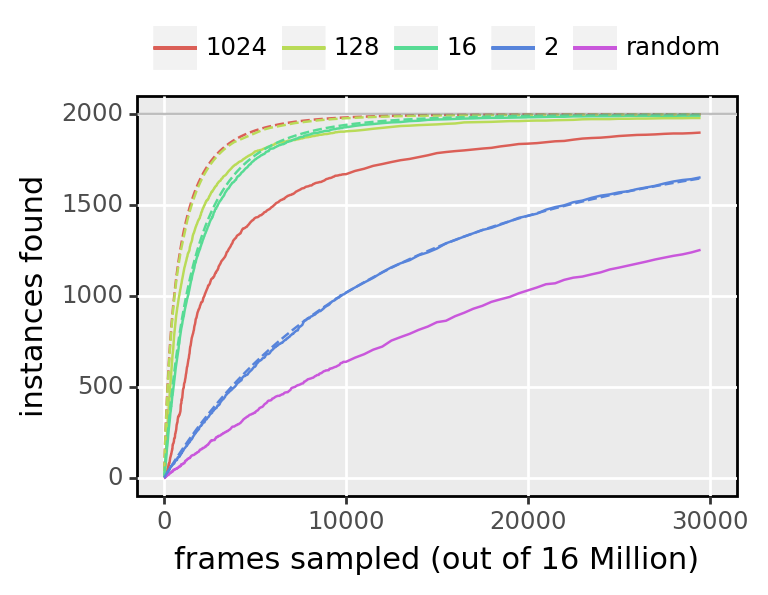

<ggplot: (-9223363253861126256)>

In [1334]:
simplot

In [1344]:
simplot.save('./assets/chunks.pdf')

/nvme_drive/vsms3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 3 x 2 in image.
/nvme_drive/vsms3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./assets/chunks.pdf
/nvme_drive/vsms3/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 9 rows containing missing values.


In [1220]:
pdf.level

0          1
1          1
2          1
3          1
4          1
        ... 
2140    9950
2141    9950
2142    9950
2143    9950
2144    9950
Name: level, Length: 2145, dtype: int64

In [1311]:
pm = pdf.merge(dfmodel[['method', 'nf', 'ni']], how='left', left_on=('method', 'level'), right_on=('method', 'nf'))

In [1312]:
pm

task  method  lower  metric  upper     ratio   ref  level     nf  \
0       t    1024      0       0      0  1.000000     0      1      1   
1       t     128      0       0      0  1.000000     0      1      1   
2       t      16      0       0      0  1.000000     0      1      1   
3       t       2      0       0      0  1.000000     0      1      1   
4       t  random      0       0      0  1.000000     0      1      1   
...   ...     ...    ...     ...    ...       ...   ...    ...    ...   
2340    t    1024   1884    1899   1908  1.513944  1254  29500  29500   
2341    t     128   1975    1979   1983  1.577689  1254  29500  29500   
2342    t      16   1991    1992   1995  1.588048  1254  29500  29500   
2343    t       2   1634    1653   1658  1.317928  1254  29500  29500   
2344    t  random   1240    1254   1288  1.000000  1254  29500  29500   

               ni  
0        4.400408  
1        3.855026  
2        1.328688  
3        0.166367  
4        0.083187  
...           ...  
2340  1999.818522  
2341  1999.479909  
2342  1997.474225  
2343  1647.187363  
2344  1258.262285  

[2345 rows x 10 columns]

In [1262]:
#pm.method[pm.nf.isna()].shape[0]

In [1313]:
pm = pm.assign(gap=(pm['ni'] - pm['metric']))

In [1338]:
gp2 = (ggplot(pm.dropna(axis=0))
+ geom_line(aes(x='level', y='gap', color='method'))
+ theme(panel_grid_minor=element_blank(),
         figure_size=(3,2),
         subplots_adjust={'hspace':.0, 'wspace':.0},
         panel_border=element_line(color='black'),
        legend_position='top',
        legend_direction='horizontal', 
         legend_title=element_blank(),
         strip_text=element_text(size=8),
         plot_margin=0,
         legend_margin=0,
         legend_box_margin=0,
         strip_margin=0
)
 + scale_x_continuous(name='frames sampled (out of {:d} Million)'.format(int(NF//(1e6))), 
                    limits=np.array([xmin,30000.]))
 + scale_y_continuous(name='gap to optimal allocation')
 + annotate('vline', xintercept=[16,128,1024], color='gray',alpha=.5))

In [1345]:
gp2.save('./assets/chunk_gap.pdf')

/nvme_drive/vsms3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 3 x 2 in image.
/nvme_drive/vsms3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./assets/chunk_gap.pdf
/nvme_drive/vsms3/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 9 rows containing missing values.


/nvme_drive/vsms3/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 9 rows containing missing values.


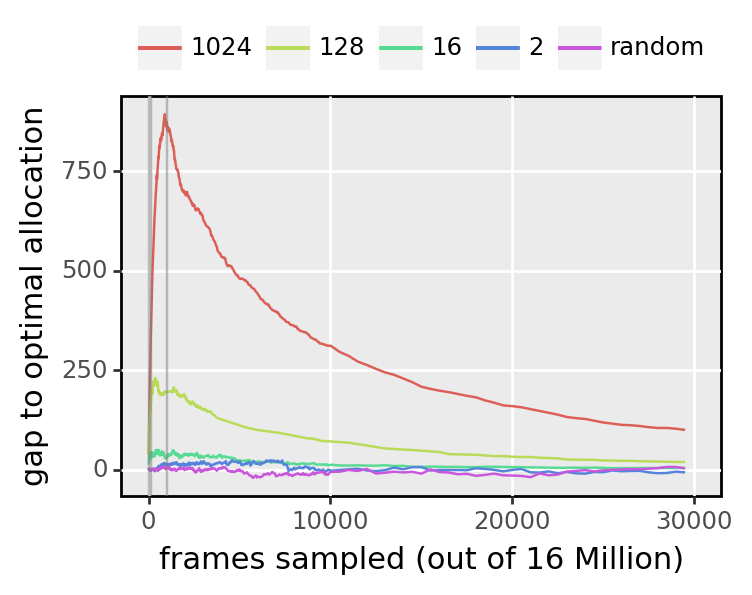

<ggplot: (8782989854938)>

In [1346]:
gp2